### Inference on learned reward estimation network

In [1]:
import numpy as np

# construction of value decomposition network
# implementation adopted from https://github.com/Lizhi-sjtu/MARL-code-pytorch
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from old_cassie.cassie_env.quaternion_function import quaternion2euler


class QMIX_Net(nn.Module):
    def __init__(
        self,
        num_features,
        state_action_dim,
        batch_size: int = 32,
        qmix_hidden_dim: int = 32,
        hyper_hidden_dim: int = 64,
        hyper_layers_num: int = 2,
    ):
        super(QMIX_Net, self).__init__()
        self.N = num_features
        self.state_dim = state_action_dim
        self.batch_size = batch_size
        self.qmix_hidden_dim = qmix_hidden_dim
        self.hyper_hidden_dim = hyper_hidden_dim
        self.hyper_layers_num = hyper_layers_num
        """
        w1:(N, qmix_hidden_dim)
        b1:(1, qmix_hidden_dim)
        w2:(qmix_hidden_dim, 1)
        b2:(1, 1)
        """
        if self.hyper_layers_num == 2:
            print("hyper_layers_num=2")
            self.hyper_w1 = nn.Sequential(
                nn.Linear(self.state_dim, self.hyper_hidden_dim),
                nn.ReLU(),
                nn.Linear(self.hyper_hidden_dim, self.N * self.qmix_hidden_dim),
            )
            self.hyper_w2 = nn.Sequential(
                nn.Linear(self.state_dim, self.hyper_hidden_dim),
                nn.ReLU(),
                nn.Linear(self.hyper_hidden_dim, self.qmix_hidden_dim * 1),
            )
        elif self.hyper_layers_num == 1:
            print("hyper_layers_num=1")
            self.hyper_w1 = nn.Linear(self.state_dim, self.N * self.qmix_hidden_dim)
            self.hyper_w2 = nn.Linear(self.state_dim, self.qmix_hidden_dim * 1)
        else:
            print("wrong!!!")

        self.hyper_b1 = nn.Linear(self.state_dim, self.qmix_hidden_dim)
        self.hyper_b2 = nn.Sequential(
            nn.Linear(self.state_dim, self.qmix_hidden_dim),
            nn.ReLU(),
            nn.Linear(self.qmix_hidden_dim, 1),
        )

    def forward(self, input):
        q, s = input[:, : self.N], input[:, self.N :]
        # print("q.shape", q.shape)
        # print("s.shape", s.shape)
        # q is the feature of agents (like norm of actions), s is the global state, action
        q = q.view(-1, 1, self.N)  # (batch_size * max_episode_len, 1, N)
        s = s.reshape(-1, self.state_dim)  # (batch_size * max_episode_len, state_dim)

        w1 = torch.abs(
            self.hyper_w1(s)
        )  # (batch_size * max_episode_len, N * qmix_hidden_dim)
        b1 = self.hyper_b1(s)  # (batch_size * max_episode_len, qmix_hidden_dim)
        w1 = w1.view(
            -1, self.N, self.qmix_hidden_dim
        )  # (batch_size * max_episode_len, N,  qmix_hidden_dim)
        b1 = b1.view(
            -1, 1, self.qmix_hidden_dim
        )  # (batch_size * max_episode_len, 1, qmix_hidden_dim)

        q_hidden = F.elu(
            torch.bmm(q, w1) + b1
        )  # (batch_size * max_episode_len, 1, qmix_hidden_dim)

        w2 = torch.abs(
            self.hyper_w2(s)
        )  # (batch_size * max_episode_len, qmix_hidden_dim * 1)
        b2 = self.hyper_b2(s)  # (batch_size * max_episode_len,1)
        w2 = w2.view(
            -1, self.qmix_hidden_dim, 1
        )  # (batch_size * max_episode_len, qmix_hidden_dim, 1)
        b2 = b2.view(-1, 1, 1)  # (batch_size * max_episode_len, 1， 1)

        q_total = torch.bmm(q_hidden, w2) + b2  # (batch_size * max_episode_len, 1， 1)
        # print(q_total.size())
        q_total = q_total.view(input.size()[0], 1)  # (batch_size, max_episode_len, 1)

        return q_total


class VDN_Net(nn.Module):
    def __init__(
        self,
    ):
        super(VDN_Net, self).__init__()

    def forward(self, q):
        return torch.sum(q, dim=-1, keepdim=True)

construction of feature network
state definition:
[useful_state, ref_pos[pos_index], ref_vel[vel_index], wrench_sensor]
useful_state = [pelvis_height, # 1
                new_orientation[:], # quaternion; 1:5
                motor_position, # 10 dim; 5:15
                new_translationalVelocity[:], # 4 dim; 15:19
                rotational_velocity, # 3 dim; 19:22
                motor_velocity,  # 10 dim; 22:32
                new_translationalAcceleration[:], # 4 dim; 32:36
                joint_position, # 6 dim; 36:42
                joint_velocity] # 6 dim; 42:46

 ref_pos[pos_index] # 19 dim; 46:65
 ref_vel[vel_index] # 20 dim; 65:85
 wrench_sensor # 6 dim; 85:91



state = np.ones((100, 91))
pelvis_height = state[:, 0] # 1
new_orientation = state[:, 1:5] # quaternion; 1:5
motor_position = state[:, 5:15] # 10 dim; 5:15
new_translationalVelocity = state[:, 15:19] # 4 dim; 15:19
rotational_velocity = state[:, 19:22] # 3 dim; 19:22
motor_velocity = state[:, 22:32]  # 10 dim; 22:32
new_translationalAcceleration = state[:, 32:36] # 4 dim; 32:36
joint_position = state[:, 36:42] # 6 dim; 36:42
joint_velocity = state[:, 42:46]
ref_pos = state[:, 46:65]
ref_vel = state[:, 65:85]
wrench_sensor = state[:, 85:91] # 6 dim, motor position of the arm

In [2]:
def construct_features(
    pelvis_position: np.array,
    pelvis_orientation: np.array,
    center_of_mass: np.array,
    left_foot_forces: np.array,
    right_foot_forces: np.array,
    foot_pos: np.array,
    com_vel: np.array,
    com_am: np.array,
    com_inertia: np.array,
    state: np.array,
    action: np.array,
):
    assert state.shape[1] == 85
    assert action.shape[1] == 10
    pelvis_height = state[:, 0]  # 1
    new_orientation = state[:, 1:5]  # quaternion; 1:5
    motor_position = state[:, 5:15]  # 10 dim; 5:15
    new_translationalVelocity = state[:, 15:19]  # 4 dim; 15:19
    rotational_velocity = state[:, 19:22]  # 3 dim; 19:22
    motor_velocity = state[:, 22:32]  # 10 dim; 22:32
    new_translationalAcceleration = state[:, 32:36]  # 4 dim; 32:36
    joint_position = state[:, 36:42]  # 6 dim; 36:42
    joint_velocity = state[:, 42:46]
    ref_pos = state[:, 46:65]
    ref_vel = state[:, 65:85]
    # wrench_sensor = state[:, 85:91] # 6 dim, motor position of the arm
    # 1st the norm of the action performed
    action_norm = np.linalg.norm(action, axis=1).reshape(-1, 1)

    # 2nd the distance to the obstacle
    # construct pelvis location
    # distance_to_obstacle = np.abs(pelvis_position[:, 1]-6).reshape(-1, 1)
    distance_to_obstacle = np.linalg.norm(
        pelvis_position[:, 0:2] - np.array([6, 0]), axis=1
    ).reshape(-1, 1)

    print("distance_to_obstacle.shape", distance_to_obstacle.shape)

    # 3rd roll of pelvis
    qroll = pelvis_orientation[:, 0].reshape(-1, 1)
    print("qroll.shape", qroll.shape)

    # 4th/5th stench hip yaw (don't know which one is stench)
    q2lst = motor_position[:, 1].reshape(-1, 1)
    q2rst = motor_position[:, 6].reshape(-1, 1)
    print("q2lst.shape", q2lst.shape)
    print("q2rst.shape", q2rst.shape)

    # 6th pelvis pitch
    qpitch = pelvis_orientation[:, 2].reshape(-1, 1)
    print("qpitch.shape", qpitch.shape)

    # 7th/8th stance leg length: computed using left/right keen pitch angle
    q4l = motor_position[:, 3]
    q4r = motor_position[:, 8]
    qllstl = np.sqrt(0.5292 * np.cos(q4l + 0.035) + 0.5301).reshape(-1, 1)
    qllstr = np.sqrt(0.5292 * np.cos(q4r + 0.035) + 0.5301).reshape(-1, 1)
    print("qllstl.shape", qllstl.shape)
    print("qllstr.shape", qllstr.shape)

    # 9th/10th swing leg row
    qlrswl = qroll + motor_position[:, 0].reshape(-1, 1)
    qlrswr = qroll + motor_position[:, 5].reshape(-1, 1)
    print("qlrswl.shape", qlrswl.shape)
    print("qlrswr.shape", qlrswr.shape)

    # 11th/12th swing leg pitch
    qlpswl = -qpitch + motor_position[:, 2].reshape(-1, 1)
    print("qlpswl.shape", qlpswl.shape)
    qlpswl = (
        qlpswl
        - np.arccos(
            (
                0.5
                * np.true_divide(
                    np.cos(0.035 + q4l) + 0.5292,
                    np.sqrt(0.5292 * np.cos(q4l + 0.035) + 0.5301),
                )
            )
        ).reshape(-1, 1)
        + 0.1
    )
    print("qlpswl.shape", qlpswl.shape)
    qlpswl.reshape(-1, 1)
    qlpswr = (
        -qpitch
        + motor_position[:, 7].reshape(-1, 1)
        - np.arccos(
            (0.5 * (np.cos(0.035 + q4r) + 0.5292))
            / (np.sqrt(0.5292 * np.cos(q4r + 0.035) + 0.5301))
        ).reshape(-1, 1)
        + 0.1
    )
    qlpswr.reshape(-1, 1)
    print("qlpswl.shape", qlpswl.shape)
    print("qlpswr.shape", qlpswr.shape)

    # 13th/14th swing foot pitch
    qfpswr = -qpitch + motor_position[:, 9].reshape(-1, 1) + 1.1
    qfpswr.reshape(-1, 1)
    print("qfpswr.shape", qfpswr.shape)

    qfpswl = -qpitch + motor_position[:, 4].reshape(-1, 1) + 1.1
    qfpswl.reshape(-1, 1)
    print("qfpswl.shape", qfpswl.shape)

    # add distance between center of the feet to center of mass
    # 15th/16th distance between center of the feet to center of mass
    center_of_foot = (foot_pos[:, 0:3] + foot_pos[:, 3:6]) / 2
    com_to_cof = np.linalg.norm(center_of_mass - center_of_foot, axis=1).reshape(-1, 1)

    # 17th/18th foot forces
    left_foot_forces = left_foot_forces.reshape(-1, 1)
    right_foot_forces = right_foot_forces.reshape(-1, 1)

    ret = np.concatenate(
        [
            action,
            com_to_cof,
            left_foot_forces,
            right_foot_forces,
            action_norm,
            distance_to_obstacle,
            com_vel,
            com_am,
            qroll,
            q2lst,
            q2rst,
            qpitch,
            qllstl,
            qllstr,
            qlrswl,
            qlrswr,
            qlpswl,
            qlpswr,
            qfpswl,
            qfpswr,
            state,
            action,
        ],
        axis=1,
    )
    print(ret.shape)

    return ret

In [3]:
# collect data
import os
import numpy as np
import torch as th
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
from gymnasium.envs.registration import register
from ipmd import IPMD

register(
    id="CassieMirror-v1",
    entry_point="arm_cassie_env.cassie_env.oldCassie:OldCassieMirrorEnv",
    max_episode_steps=600,
)

In [4]:
data_set_size = 600 * 30
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 3e6,
    "env_id": "CassieMirror-v1",
    "progress_bar": True,
    "verbose": 1,
    "ent_coef": "auto",
    "learning_rate": 5e-3,
    "n_envs": 32,
    "gradient_steps": 1,
    "batch_size": 512,
    'expert_replay_buffer_loc': 'expert_demo/SAC/10traj_morestable',
    'expert_traj_size': 600,
    "buffer_size": 200000,
}
eval_env = make_vec_env(
    config["env_id"],
    n_envs=1,
    # vec_env_cls=SubprocVecEnv,
    env_kwargs={"render": False, "record_for_reward_inference": True},
)
model_path = "logs/2023-07-19-19-56-18-goodipmd/best_model.zip"
best_irl_model = IPMD('MlpPolicy', 
                     env=eval_env, 
                     train_freq=data_set_size,
                     gamma=1.00, 
                     verbose=config['verbose'],
                     buffer_size=config['buffer_size'],
                     ent_coef=config['ent_coef'], 
                     batch_size=config['batch_size'], 
                     learning_rate=config['learning_rate'],
                     gradient_steps=config['gradient_steps'],
                     learning_starts=100,
                     expert_replay_buffer_loc=config['expert_replay_buffer_loc'], 
                     expert_traj_size=config['expert_traj_size'],
                     )
# best_irl_model.train_freq = data_set_size
best_irl_model.set_parameters(model_path)

Using cuda device
tensor(447.1955, device='cuda:0')


In [5]:

_, callback = best_irl_model._setup_learn(
    data_set_size,
    callback=None,
)
best_irl_model.collect_rollouts(
    best_irl_model.env,
    train_freq=best_irl_model.train_freq,
    action_noise=best_irl_model.action_noise,
    callback=callback,
    learning_starts=0,
    replay_buffer=best_irl_model.replay_buffer,
    log_interval=1,
)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 600      |
|    ep_rew_mean     | 431      |
| time/              |          |
|    episodes        | 1        |
|    fps             | 134      |
|    time_elapsed    | 4        |
|    total_timesteps | 600      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 600      |
|    ep_rew_mean     | 429      |
| time/              |          |
|    episodes        | 2        |
|    fps             | 157      |
|    time_elapsed    | 7        |
|    total_timesteps | 1200     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 600      |
|    ep_rew_mean     | 431      |
| time/              |          |
|    episodes        | 3        |
|    fps             | 167      |
|    time_elapsed    | 10       |
|    total_timesteps | 1800     |
--------------

RolloutReturn(episode_timesteps=18000, n_episodes=30, continue_training=True)

In [6]:
reward_function = best_irl_model.policy.reward_est
print(reward_function)

RewardEstimation(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (rf0): Sequential(
    (0): Linear(in_features=95, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [7]:
print(best_irl_model.replay_buffer.pos)

18000


In [8]:
buffer_length = best_irl_model.replay_buffer.size()
full_states, full_actions = (
    best_irl_model.replay_buffer.observations,
    best_irl_model.replay_buffer.actions,
)
print(full_states.shape)
states = full_states[:buffer_length, 0, :]
print(states.shape)
actions = full_actions[:buffer_length, 0, :]
print(actions.shape)
states = th.asarray(full_states[:buffer_length, 0, :]).to("cuda:0")
actions = th.asarray(full_actions[:buffer_length, 0, :]).to("cuda:0")
sa_pairs = th.cat((states, actions), dim=1).to("cuda:0")
print(sa_pairs.shape)
# print(reward_function)
rewards = th.cat(reward_function(states, actions), dim=1)
print(rewards.shape)
# print(sa_pairs.get_device())
trained_traj_samples = np.concatenate(
    [sa_pairs.cpu().numpy(), rewards.detach().cpu().numpy()], axis=1
)
os.makedirs("logs/reward_inference", exist_ok=True)
np.save("logs/reward_inference/irl_trained_trajectory", trained_traj_samples)

(200000, 1, 85)
(18000, 85)
(18000, 10)
torch.Size([18000, 95])
torch.Size([18000, 1])


In [9]:
# loop through the folder logs/traj_state_buffer
# for each file, load the state buffer
import os
import pickle

files = os.listdir("logs/reward_inference/traj_state_buffer")
state_buffers = []
pelvis_positions = []
pelvis_orientations_euler = []
for file in sorted(files):
    state_buffer = pickle.load(
        open("logs/reward_inference/traj_state_buffer/" + file, "rb")
    )

    # get the pelvis position
    state_buffers.append(state_buffer)
    pelvis_position_buffer = [
        [
            buffer.pelvis.position[0],
            buffer.pelvis.position[1],
            buffer.pelvis.position[2],
        ]
        for buffer in state_buffer
    ]
    pelvis_positions.append(pelvis_position_buffer)

    # get the pelvis orientation in quanterion and convert to euler angles
    temp = [buffer.pelvis.orientation[0:4] for buffer in state_buffer]
    pelvis_position_euler_buffer = []
    for i in temp:
        pelvis_position_euler_buffer.append(quaternion2euler(i))

    pelvis_orientations_euler.append(pelvis_position_euler_buffer)

# convert to numpy array
pelvis_positions = np.concatenate(pelvis_positions, axis=0)
pelvis_orientations_euler = np.concatenate(pelvis_orientations_euler, axis=0)

assert pelvis_positions.shape[1] == 3
assert pelvis_orientations_euler.shape[1] == 3

left_foot_forces = []
right_foot_forces = []
center_of_mass_positions = []
feet_positions = []
com_velocities = []
com_angular_momentums = []
com_inertia_matrices = []

for file in sorted(os.listdir("logs/reward_inference/traj_useful_recorded_data")):
    useful_recording = np.array(
        pickle.load(
            open("logs/reward_inference/traj_useful_recorded_data/" + file, "rb")
        )
    )
    print(useful_recording.shape)
    (
        left_foot_force,
        right_foot_force,
        center_of_mass_pos,
        feet_pos,
        com_vel,
        com_am,
        com_inertia_mat,
    ) = (
        useful_recording[:, 0],
        useful_recording[:, 1],
        useful_recording[:, 2:5],
        useful_recording[:, 5:11],
        useful_recording[:, 11:14],
        useful_recording[:, 14:17],
        useful_recording[:, 17:],
    )
    left_foot_forces.append(left_foot_force)
    right_foot_forces.append(right_foot_force)
    center_of_mass_positions.append(center_of_mass_pos)
    feet_positions.append(feet_pos)
    com_velocities.append(com_vel)
    com_angular_momentums.append(com_am)
    com_inertia_matrices.append(com_inertia_mat)


left_foot_forces = np.concatenate(left_foot_forces, axis=0)
right_foot_forces = np.concatenate(right_foot_forces, axis=0)
center_of_mass_positions = np.concatenate(center_of_mass_positions, axis=0)
feet_positions = np.concatenate(feet_positions, axis=0)
com_velocities = np.concatenate(com_velocities, axis=0)
com_angular_momentums = np.concatenate(com_angular_momentums, axis=0)
com_inertia_matrices = np.concatenate(com_inertia_matrices, axis=0)

assert center_of_mass_positions.shape[1] == 3
assert feet_positions.shape[1] == 6

# get data
irl_trained_trajectory = np.load("logs/reward_inference/irl_trained_trajectory.npy")[
    : pelvis_orientations_euler.shape[0]
]
assert irl_trained_trajectory.shape[0] == pelvis_positions.shape[0]

(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(384, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(392, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)
(600, 26)


AssertionError: 

In [10]:
print(center_of_mass_positions.shape)
irl_trained_trajectory = irl_trained_trajectory[: center_of_mass_positions.shape[0]]
print(irl_trained_trajectory.shape)

(35576, 3)
(18000, 96)


In [ ]:
assert feet_positions.shape[0] == feet_positions.shape[0]

In [ ]:
training_set_index = np.random.choice(
    irl_trained_trajectory.shape[0],
    int(0.8 * irl_trained_trajectory.shape[0]),
    replace=False,
)
data_set = construct_features(
    pelvis_position=pelvis_positions,
    pelvis_orientation=pelvis_orientations_euler,
    center_of_mass=center_of_mass_positions,
    left_foot_forces=left_foot_forces,
    right_foot_forces=right_foot_forces,
    foot_pos=feet_positions,
    com_vel=com_velocities,
    com_am=com_angular_momentums,
    com_inertia=com_inertia_matrices,
    state=irl_trained_trajectory[:, 0:85],
    action=irl_trained_trajectory[:, 85:95],
)
# Convert your numpy array to a PyTorch tensor
numpy_array = data_set[training_set_index]
tensor_data = torch.Tensor(numpy_array)

targets = irl_trained_trajectory[training_set_index, 95]
tensor_targets = torch.Tensor(targets).reshape(-1, 1)

# Define hyperparameters
batch_size = 32
shuffle = True  # Set to False if you want to keep the order

# Create a TensorDataset from the tensor data
dataset = TensorDataset(tensor_data, tensor_targets)

# Create a DataLoader for your training dataset
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

distance_to_obstacle.shape (17784, 1)
qroll.shape (17784, 1)
q2lst.shape (17784, 1)
q2rst.shape (17784, 1)
qpitch.shape (17784, 1)
qllstl.shape (17784, 1)
qllstr.shape (17784, 1)
qlrswl.shape (17784, 1)
qlrswr.shape (17784, 1)
qlpswl.shape (17784, 1)
qlpswl.shape (17784, 1)
qlpswl.shape (17784, 1)
qlpswr.shape (17784, 1)
qfpswr.shape (17784, 1)
qfpswl.shape (17784, 1)
(17784, 128)


In [ ]:
# Convert your validation numpy array to a PyTorch tensor
val_numpy_array = data_set[~training_set_index]
val_tensor_data = torch.Tensor(val_numpy_array)

val_targets = irl_trained_trajectory[~training_set_index, 95]
val_tensor_targets = torch.Tensor(val_targets).reshape(-1, 1)

# Create a TensorDataset from the validation tensor data
val_dataset = TensorDataset(val_tensor_data, val_tensor_targets)

# Define hyperparameters
batch_size = 32

# Create a DataLoader for your validation dataset
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your dataset and data loader
# Assuming you have already prepared your data and loaded it into `train_loader` and `val_loader`

# Define hyperparameters
output_size = 1
learning_rate = 1e-3
num_epochs = 250
state_action_dim = irl_trained_trajectory.shape[1] - 1
num_features = data_set.shape[1] - state_action_dim
# Create the regression model
model = QMIX_Net(num_features=num_features, state_action_dim=state_action_dim).to(
    device
)

hyper_layers_num=2


In [ ]:
# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Initialize running loss
    running_loss = 0.0

    # Iterate over the training dataset
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    train_loss = running_loss / len(train_loader.dataset)

    # Set model to evaluation mode
    model.eval()

    # Initialize validation loss
    val_loss = 0.0

    # Disable gradient calculation to speed up inference
    with torch.no_grad():
        # Iterate over the validation dataset
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Update validation loss
            val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss for the epoch
    val_loss = val_loss / len(val_loader.dataset)

    # Print the losses for each epoch
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

# Save the trained model
torch.save(model.state_dict(), "vdn_inference.pth")

Epoch [10/250], Train Loss: 3.2113, Val Loss: 3.1030
Epoch [20/250], Train Loss: 0.4329, Val Loss: 0.4708
Epoch [30/250], Train Loss: 0.1764, Val Loss: 0.1701
Epoch [40/250], Train Loss: 0.0918, Val Loss: 0.0925
Epoch [50/250], Train Loss: 0.0680, Val Loss: 0.0771
Epoch [60/250], Train Loss: 0.0634, Val Loss: 0.0746
Epoch [70/250], Train Loss: 0.0556, Val Loss: 0.0551
Epoch [80/250], Train Loss: 0.0528, Val Loss: 0.0531
Epoch [90/250], Train Loss: 0.0476, Val Loss: 0.0465
Epoch [100/250], Train Loss: 0.0465, Val Loss: 0.0451
Epoch [110/250], Train Loss: 0.0455, Val Loss: 0.0463
Epoch [120/250], Train Loss: 0.0463, Val Loss: 0.0494
Epoch [130/250], Train Loss: 0.0439, Val Loss: 0.0513
Epoch [140/250], Train Loss: 0.0440, Val Loss: 0.0457
Epoch [150/250], Train Loss: 0.0427, Val Loss: 0.0450
Epoch [160/250], Train Loss: 0.0421, Val Loss: 0.0423
Epoch [170/250], Train Loss: 0.0404, Val Loss: 0.0402
Epoch [180/250], Train Loss: 0.0402, Val Loss: 0.0547
Epoch [190/250], Train Loss: 0.0401, 

### Loading only

In [ ]:
model = QMIX_Net(num_features=num_features, state_action_dim=state_action_dim).to(
    device
)
model.load_state_dict(torch.load("vdn_inference.pth"))

hyper_layers_num=2


<All keys matched successfully>

In [ ]:
# initialize captum models
# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import (
    IntegratedGradients,
    DeepLift,
    GradientShap,
    NoiseTunnel,
    FeatureAblation,
)

ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

test_data = torch.Tensor(data_set[0]).reshape(1, -1).to(device)
ig_attr_test = ig.attribute(test_data, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(test_data)
dl_attr_test = dl.attribute(test_data)
# gs_attr_test = gs.attribute(sa_pairs, X_train)
fa_attr_test = fa.attribute(test_data)

ig_attr_test = ig_attr_test.cpu()
ig_nt_attr_test = ig_nt_attr_test.cpu()
dl_attr_test = dl_attr_test.cpu()
# gs_attr_test = gs.attribute(sa_pairs, X_train)
fa_attr_test = fa_attr_test.cpu()

In [ ]:
data_set[0].shape

(128,)

In [ ]:
feature_names = [
    "Left Hip Roll",
    "Left Hip Yaw",
    "Left Hip Pitch",
    "Left Knee",
    "Left Foot",
    "Right Hip Roll",
    "Right Hip Yaw",
    "Right Hip Pitch",
    "Rigt Knee",
    "Rigt Foot",
    "com_to_cof",
    "left foot forces",
    "right foot forces",
    "||a||",
    "distance to table",
    "Com Vel 1",
    "Com Vel 2",
    "Com Vel 3",
    "COM angular Mom 1",
    "COM angular Mom 2",
    "COM angular Mom 3",
    "pelvis_roll",
    "left hip yaw",
    "right hip yaw",
    "pelvis pitch",
    "left leg length",
    "right leg length",
    "left leg roll",
    "right leg roll",
    "left leg pitch",
    "right leg pitch",
    "left foot pitch",
    "right foot pitch",
]

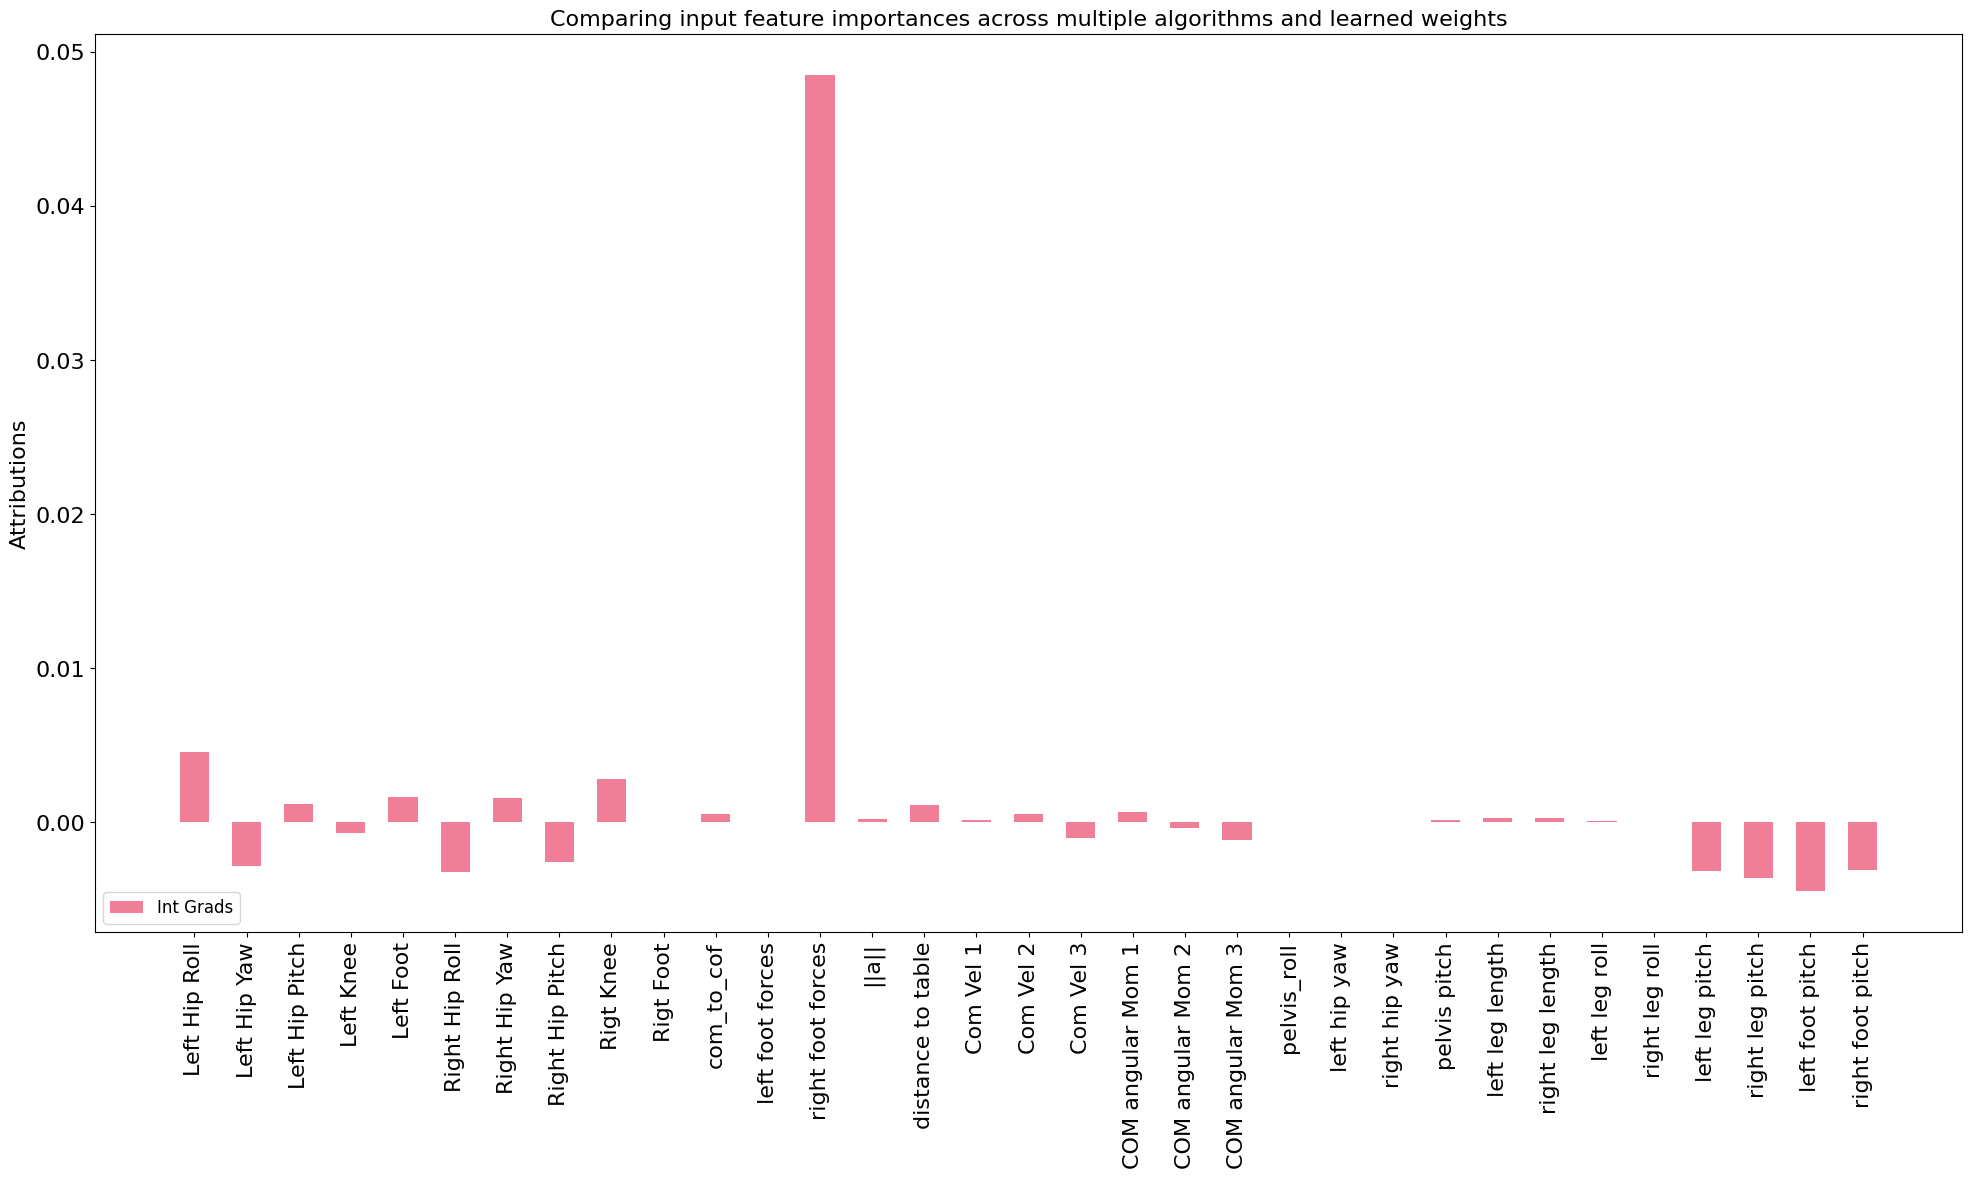

In [ ]:
import matplotlib.pyplot as plt

# prepare attributions for visualization
x_axis_data = np.arange(len(feature_names))
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))
# x_axis_data_labels = feature_names

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
ig_attr_test_norm_sum = ig_attr_test_norm_sum[:33]

# ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
# ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

# dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
# dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

# gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
# gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

# fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
# fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

# lin_weight = model.lin1.weight[0].detach().numpy()
# y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14 * 4
# legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation']
legends = ["Int Grads"]
plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title(
    "Comparing input feature importances across multiple algorithms and learned weights"
)
ax.set_ylabel("Attributions")

FONT_SIZE = 16
plt.rc("font", size=FONT_SIZE)  # fontsize of the text sizes
plt.rc("axes", titlesize=FONT_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=FONT_SIZE)  # fontsize of the x and y labels
plt.rc("legend", fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(
    x_axis_data,
    ig_attr_test_norm_sum,
    width,
    align="center",
    alpha=0.8,
    color="#eb5e7c",
)
# ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
# ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
# ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
# ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
# ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0)
ax.set_xticklabels(x_axis_data_labels, rotation="vertical")

plt.legend(legends, loc=3)
plt.show()

In [ ]:
data_set.shape

(17784, 128)

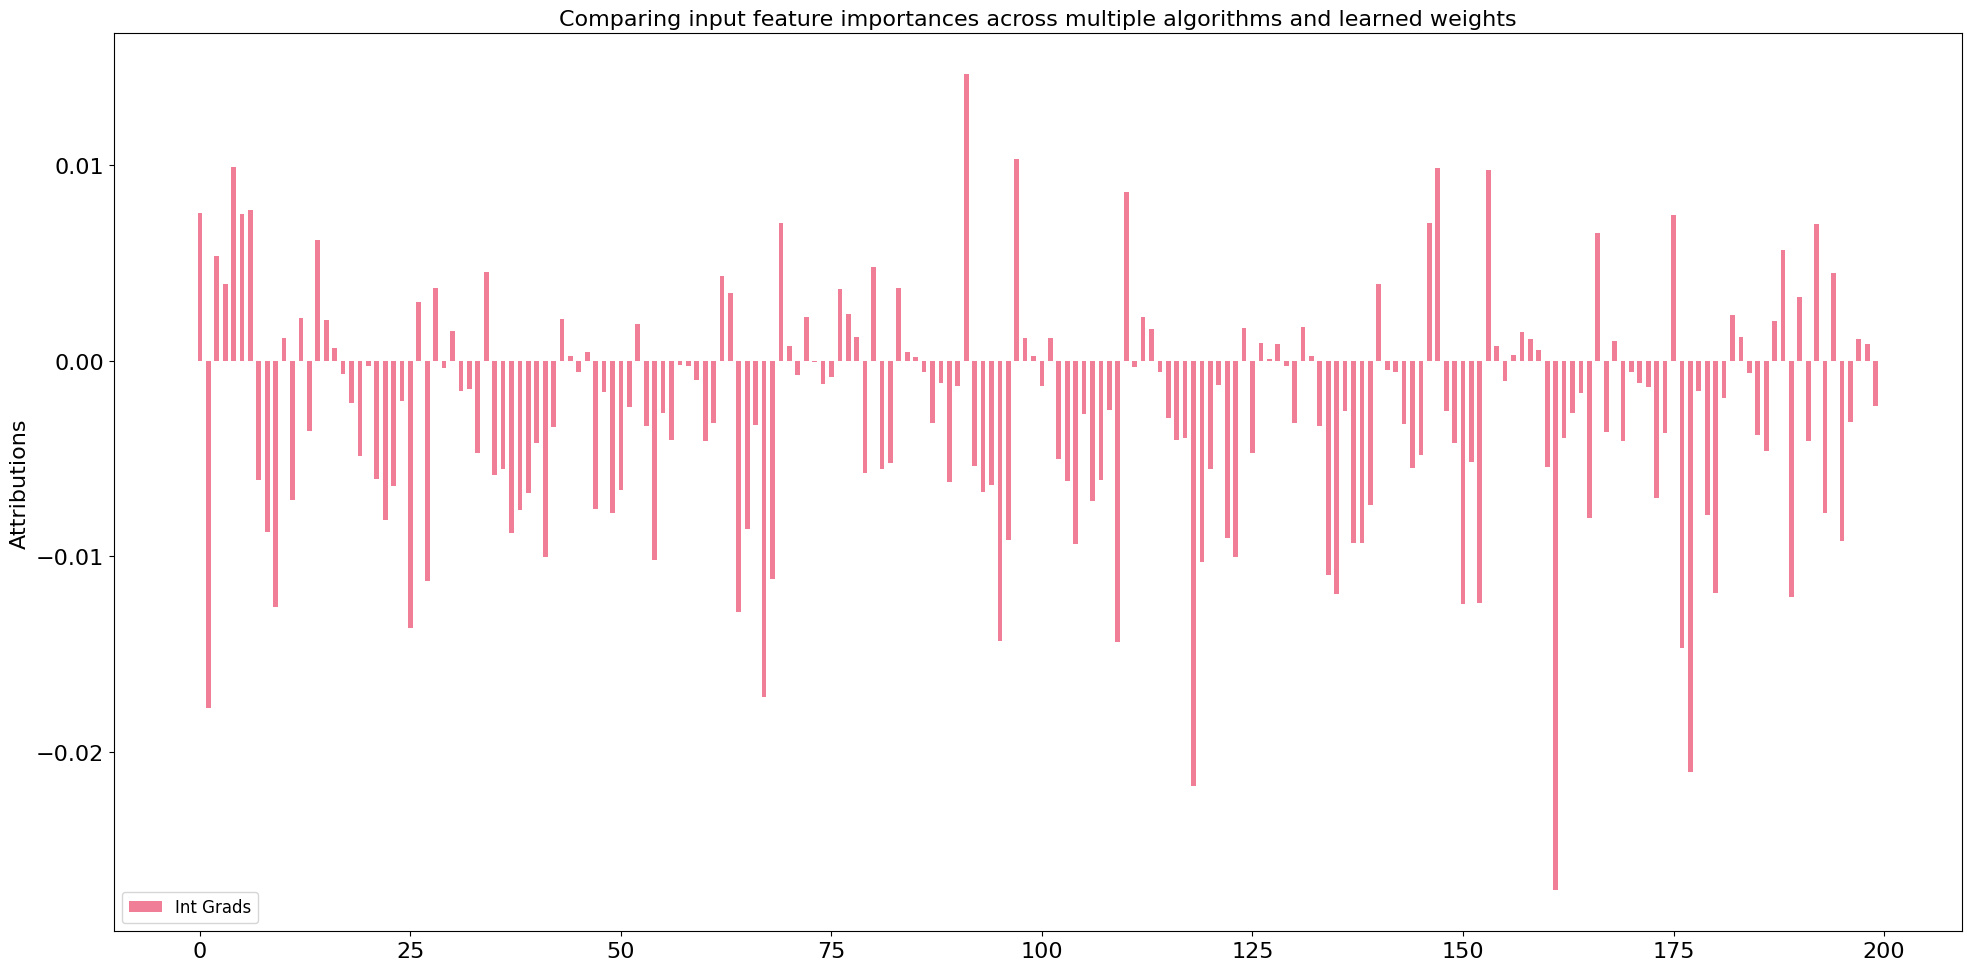

In [ ]:
feature_idx = 7

test_data = torch.Tensor(data_set[0:200, :]).to(device)
ig_attr_test = ig.attribute(test_data, n_steps=50).cpu()
feature_names = np.arange(200)
x_axis_data = np.arange(200)
_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy()[:, feature_idx - 1]
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
ig_attr_test_norm_sum = ig_attr_test_norm_sum
width = 0.14 * 4
# legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation']
legends = ["Int Grads"]
plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title(
    "Comparing input feature importances across multiple algorithms and learned weights"
)
ax.set_ylabel("Attributions")

FONT_SIZE = 16
plt.rc("font", size=FONT_SIZE)  # fontsize of the text sizes
plt.rc("axes", titlesize=FONT_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=FONT_SIZE)  # fontsize of the x and y labels
plt.rc("legend", fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(
    x_axis_data,
    ig_attr_test_norm_sum,
    width,
    align="center",
    alpha=0.8,
    color="#eb5e7c",
)
# ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
# ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
# ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
# ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
# ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

# ax.set_xticks(x_axis_data + 0)
# ax.set_xticklabels(x_axis_data_labels, rotation='vertical')
plt.legend(legends, loc=3)
plt.show()

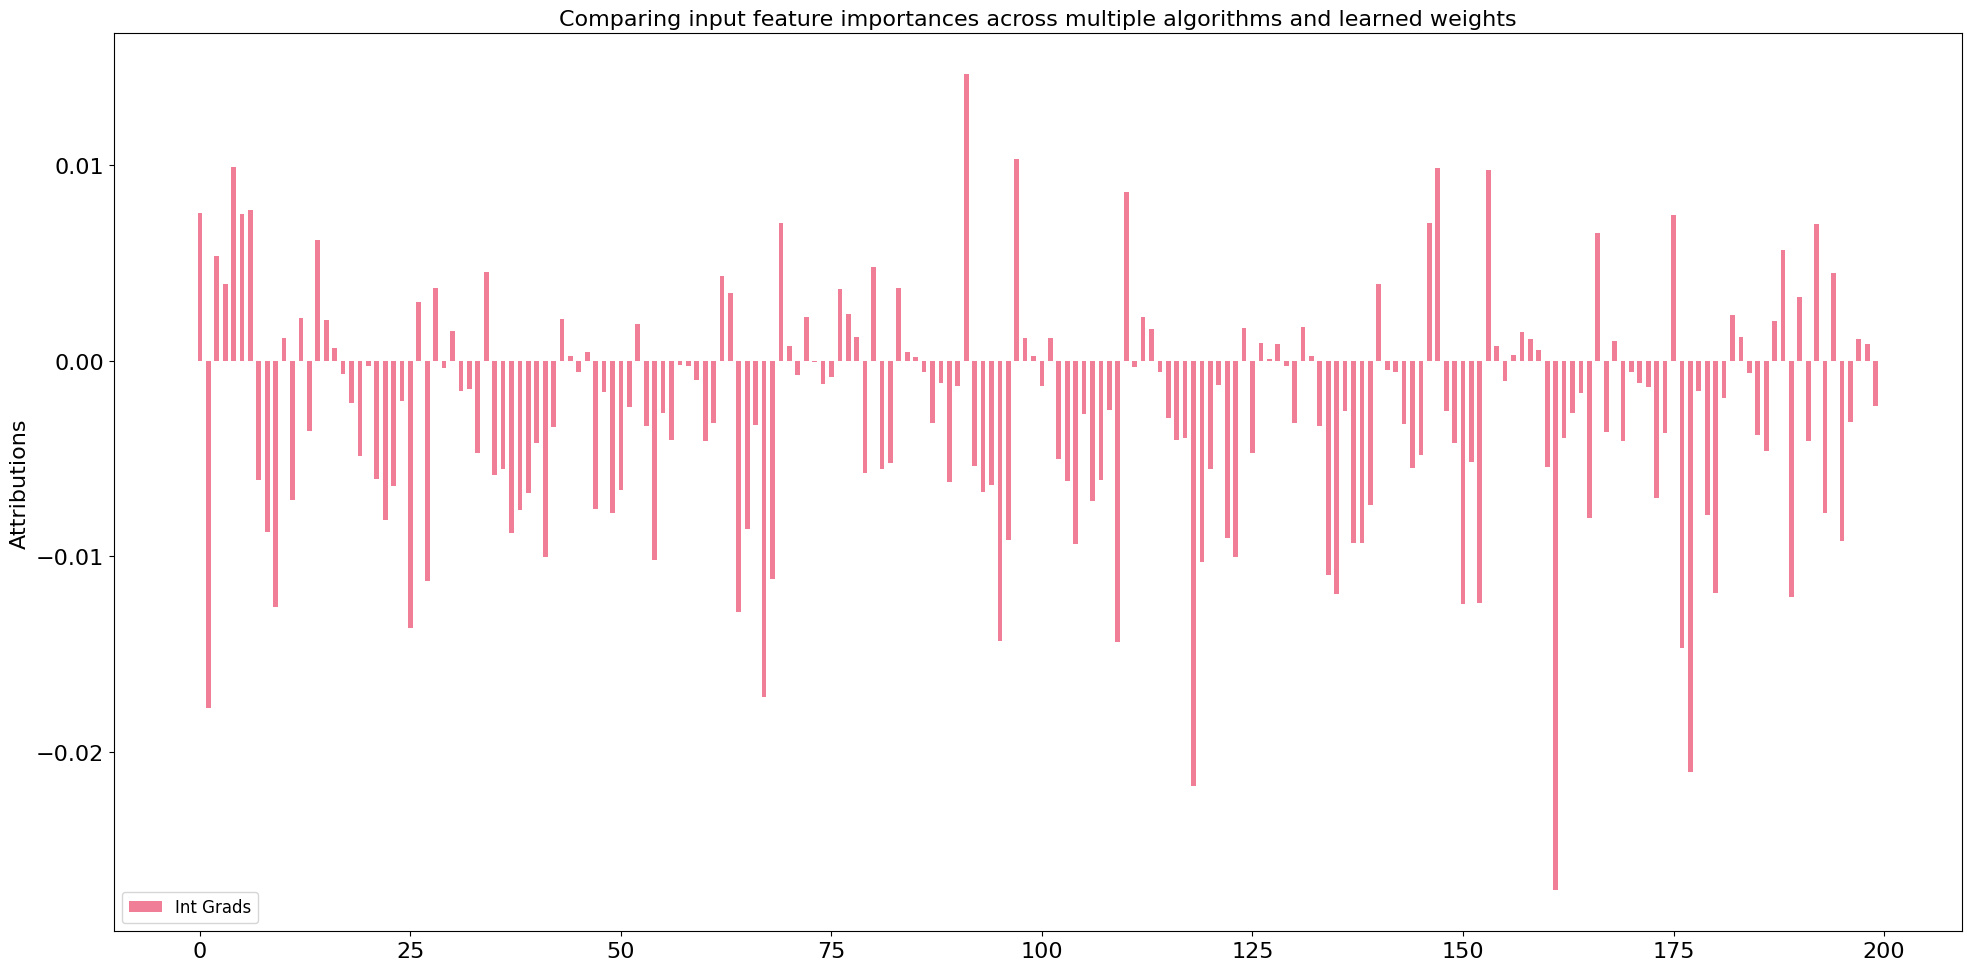

In [ ]:
feature_idx = 5 - 1  # distance to table

test_data = torch.Tensor(data_set[:200, :]).to(device)
ig_attr_test = ig.attribute(test_data, n_steps=50).cpu()
feature_names = np.arange(200)
x_axis_data = np.arange(200)
_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy()[:200, feature_idx]
# ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
ig_attr_test_norm_sum = ig_attr_test_norm_sum
width = 0.14 * 4
# legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation']
legends = ["Int Grads"]
plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title(
    "Comparing input feature importances across multiple algorithms and learned weights"
)
ax.set_ylabel("Attributions")

FONT_SIZE = 16
plt.rc("font", size=FONT_SIZE)  # fontsize of the text sizes
plt.rc("axes", titlesize=FONT_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=FONT_SIZE)  # fontsize of the x and y labels
plt.rc("legend", fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(
    x_axis_data,
    ig_attr_test_norm_sum,
    width,
    align="center",
    alpha=0.8,
    color="#eb5e7c",
)
# ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
# ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
# ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
# ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
# ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

# ax.set_xticks(x_axis_data + 0)
# ax.set_xticklabels(x_axis_data_labels, rotation='vertical')
plt.legend(legends, loc=3)
plt.show()

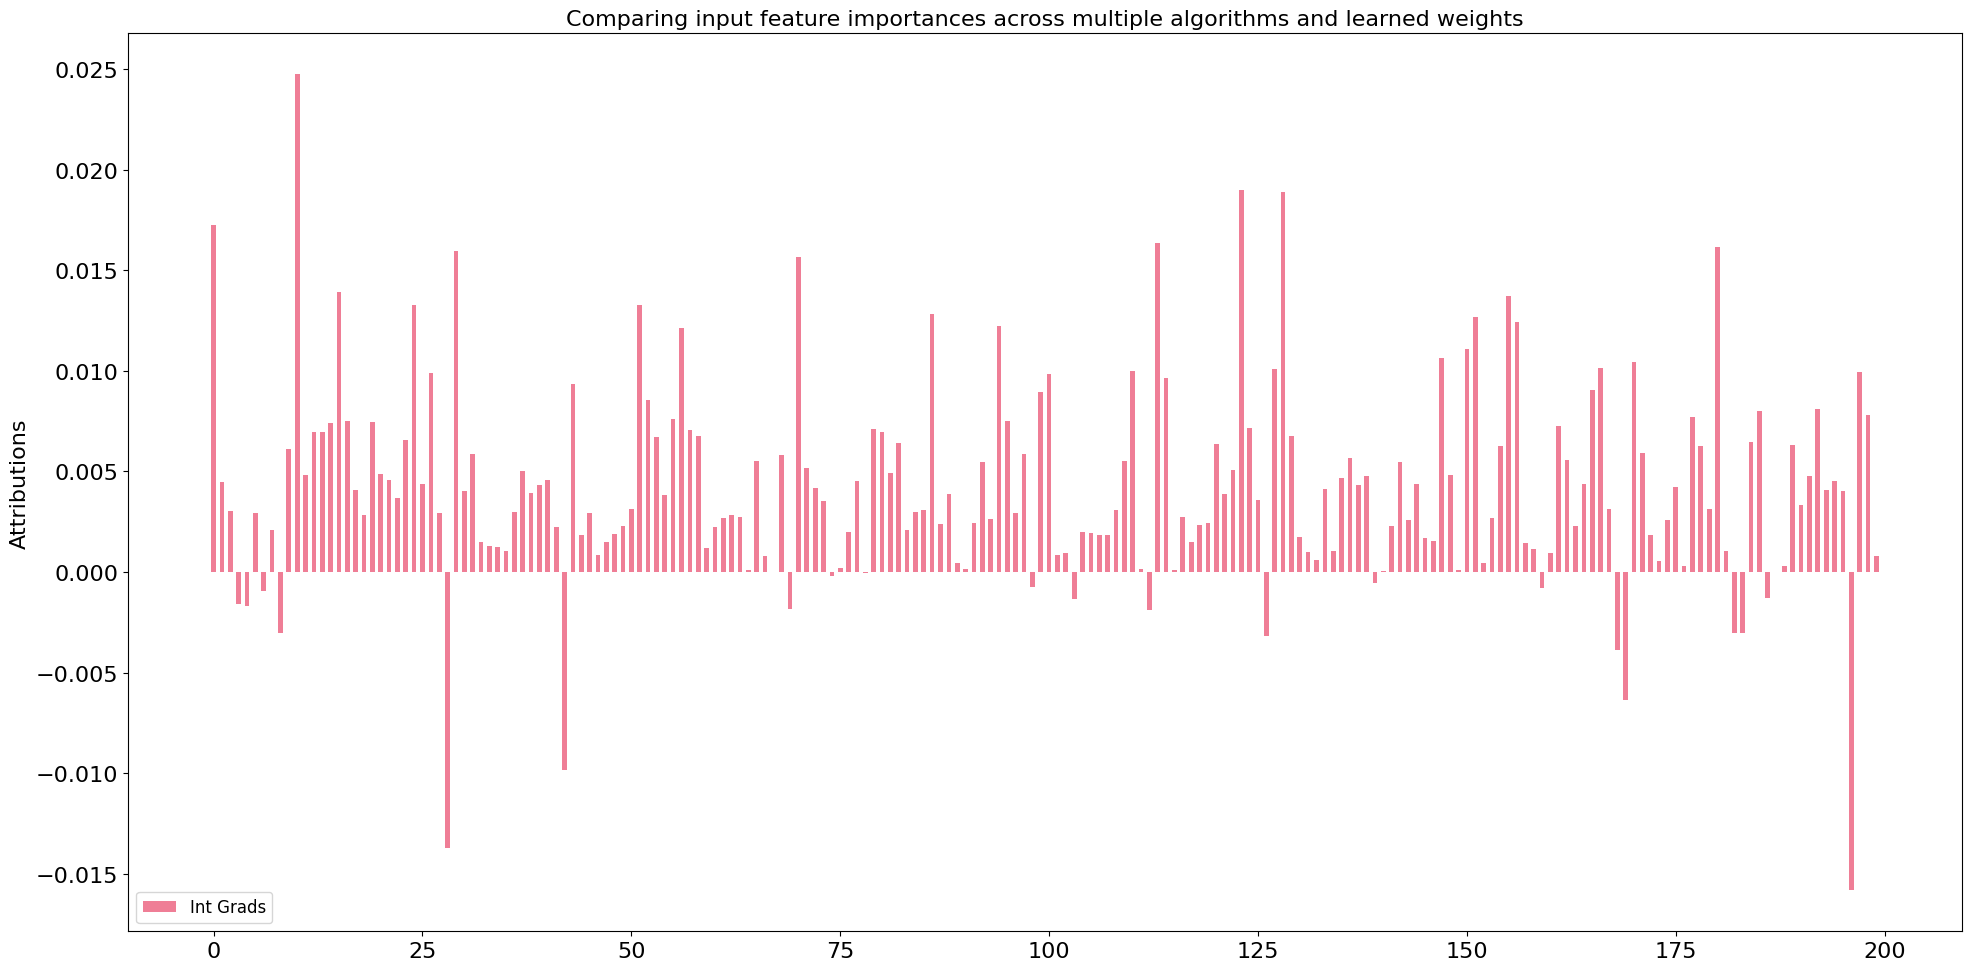

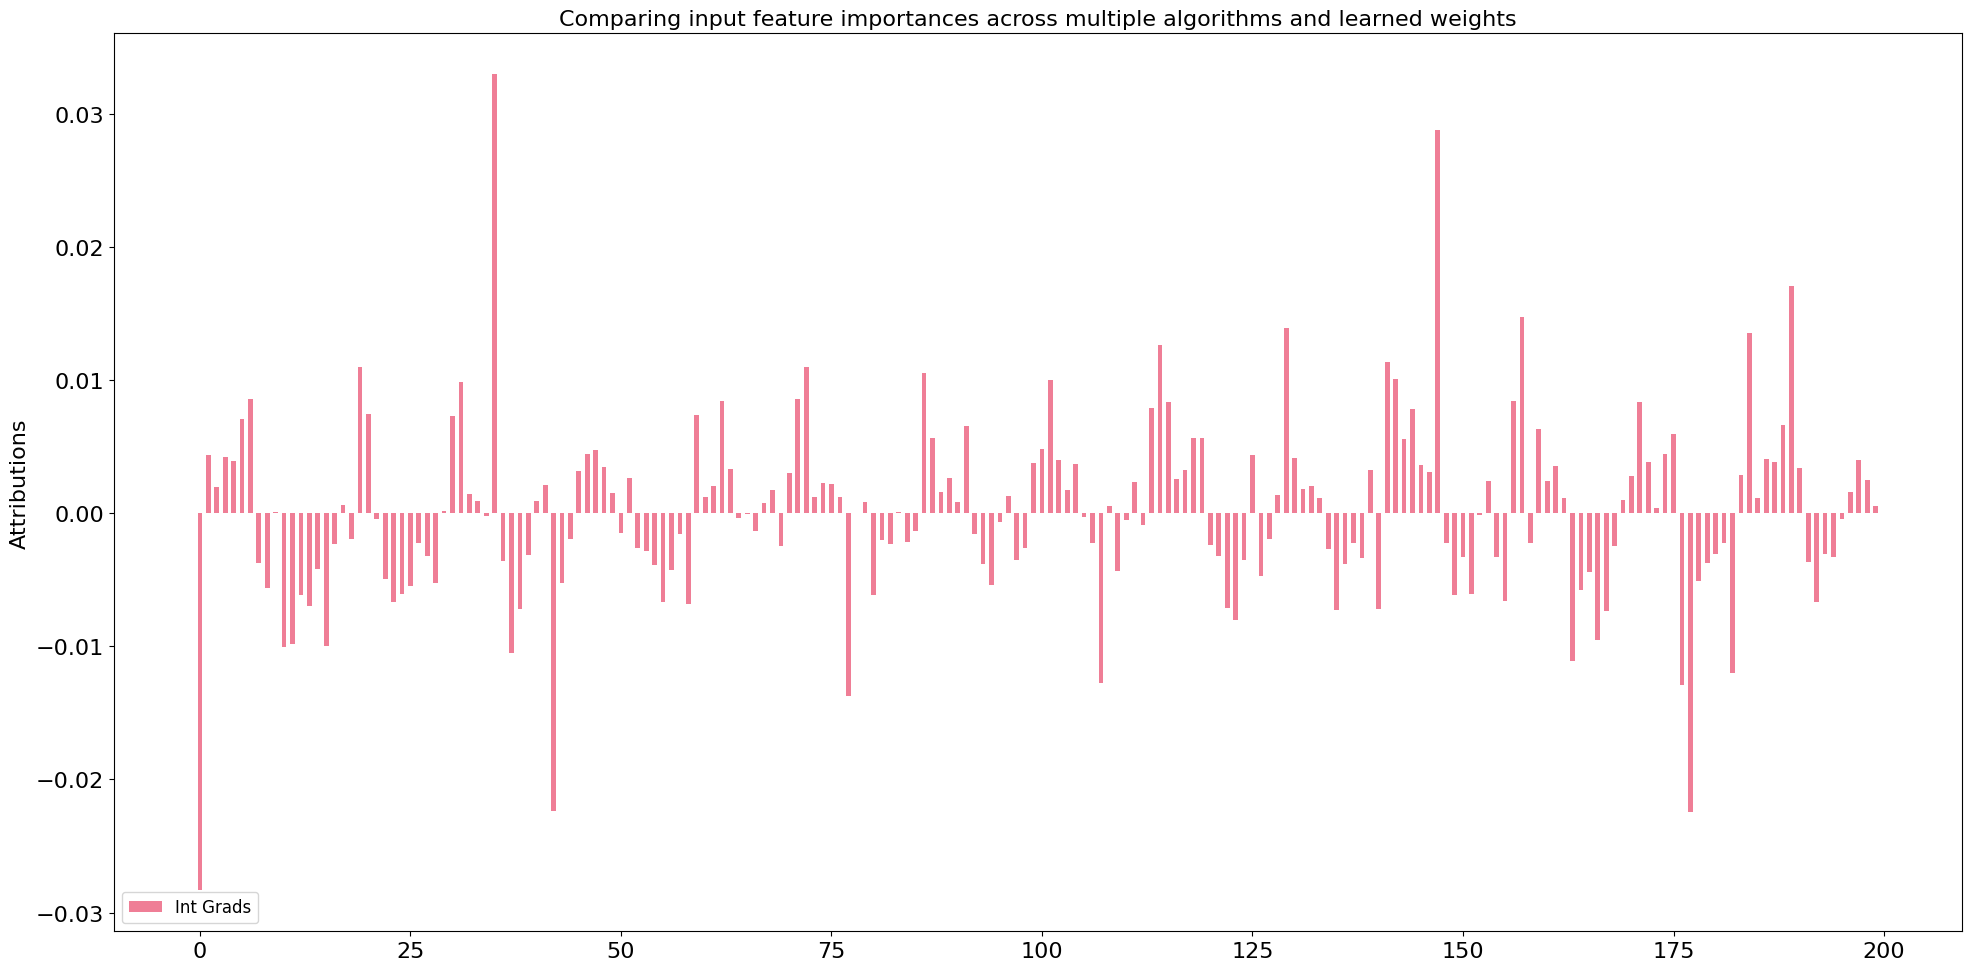

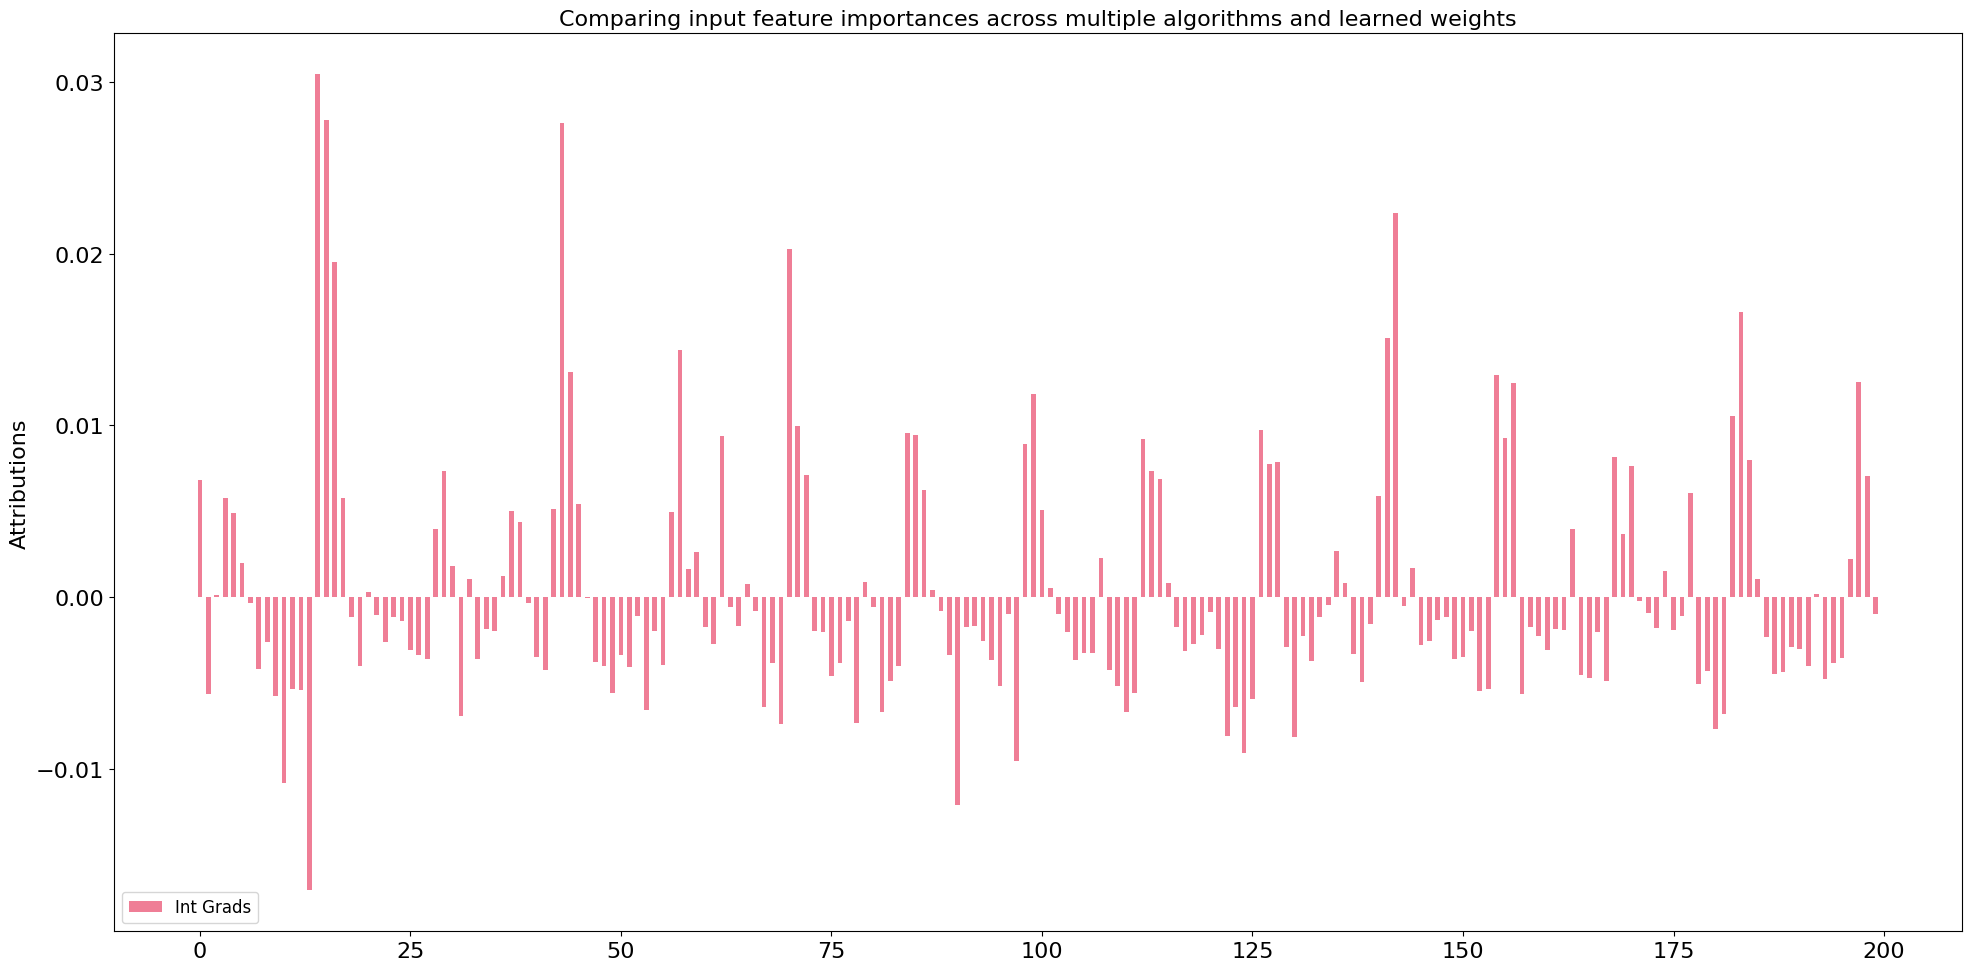

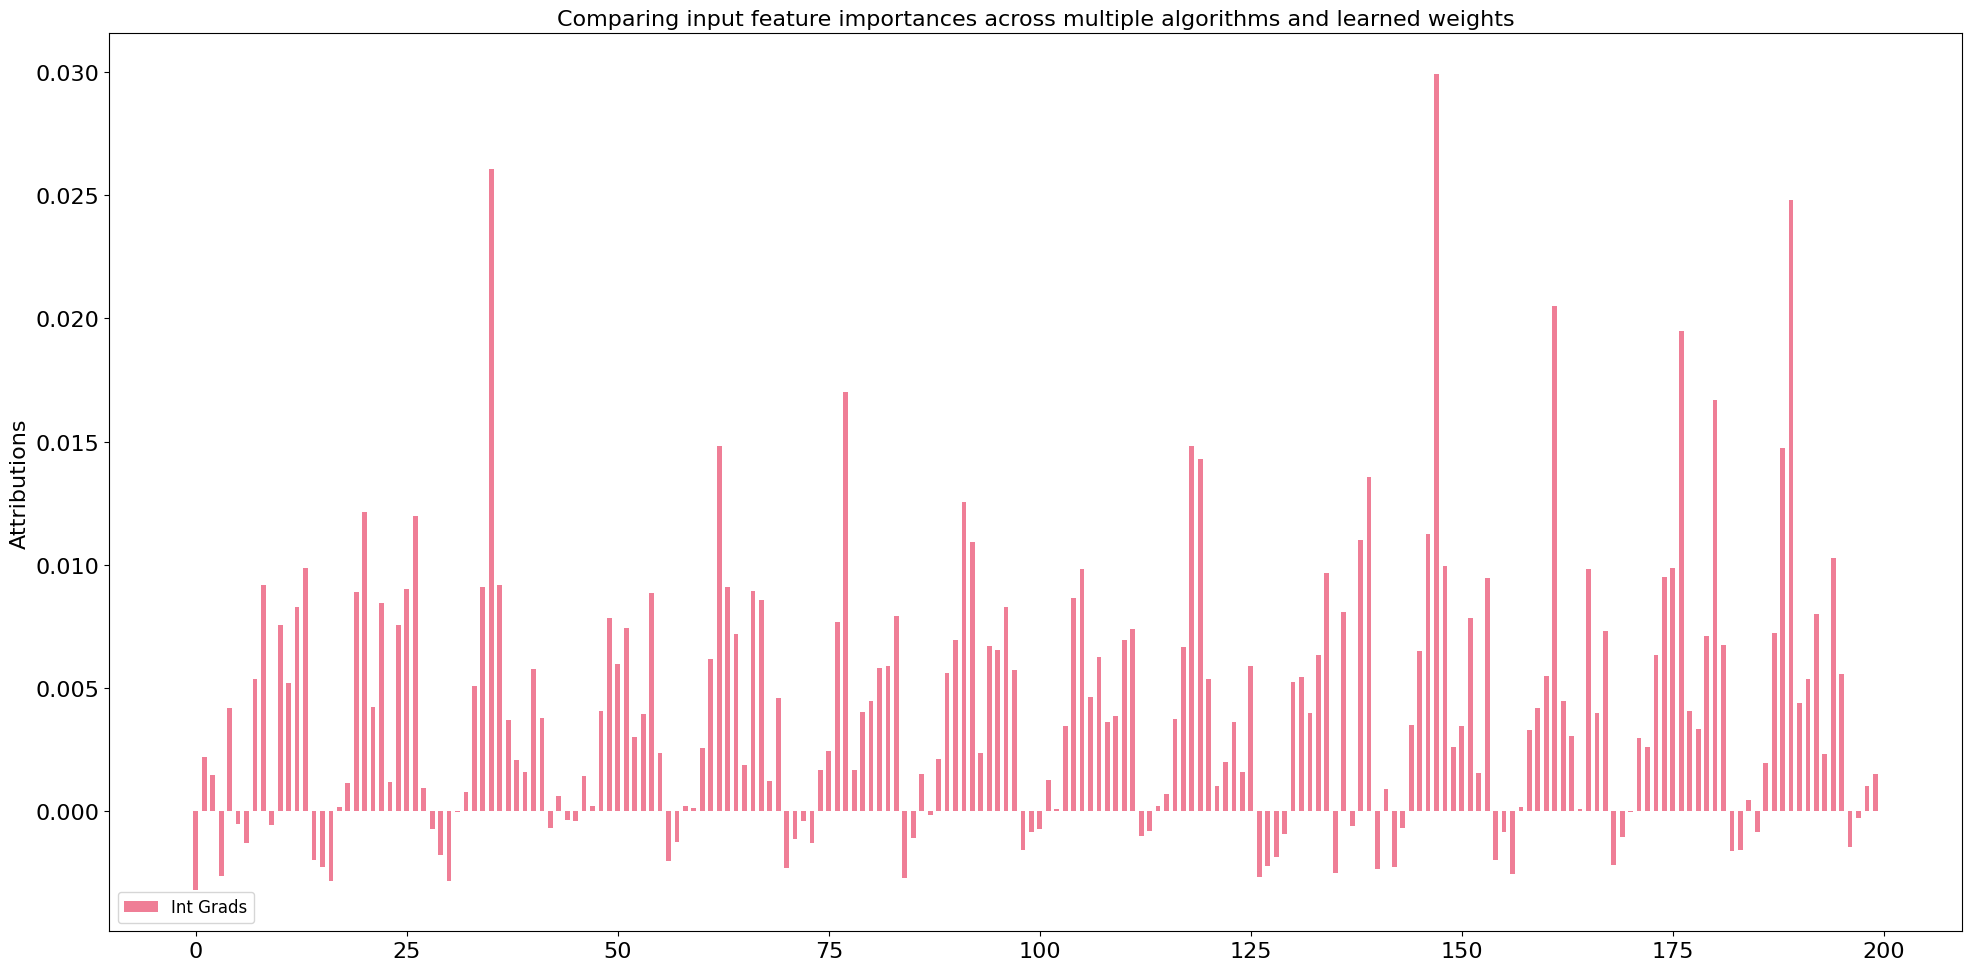

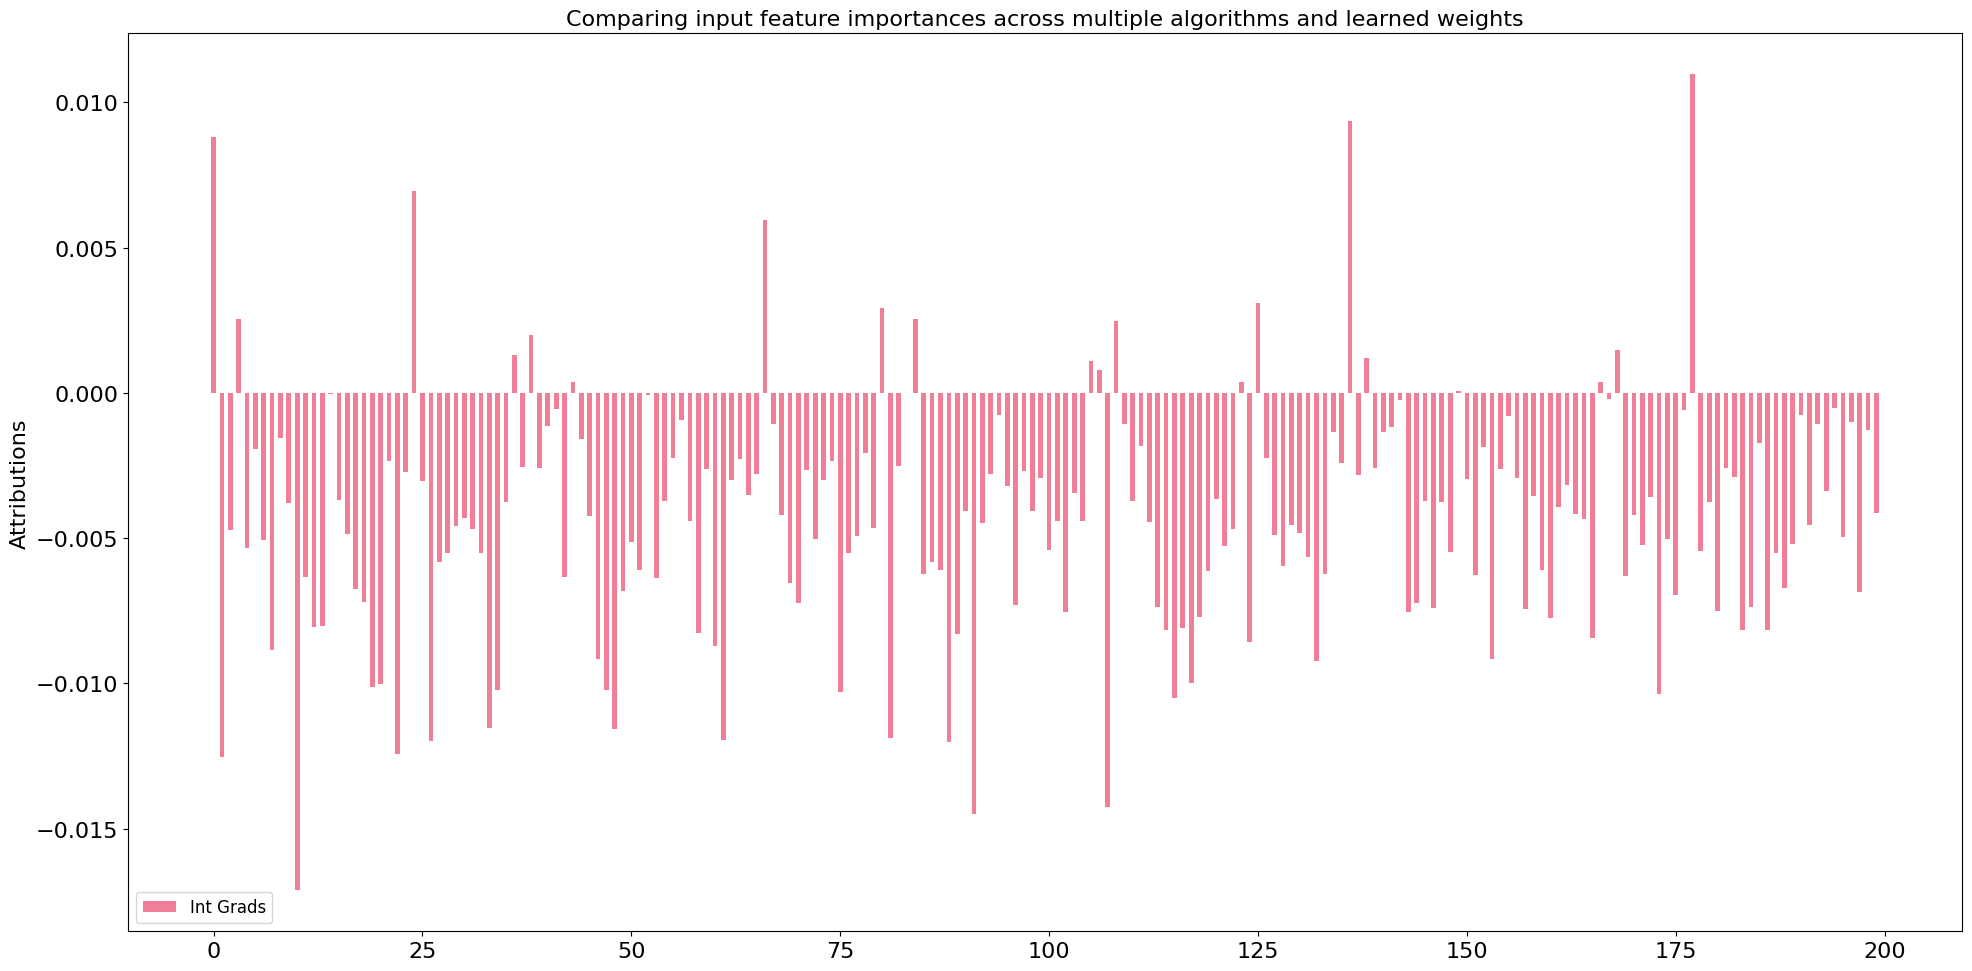

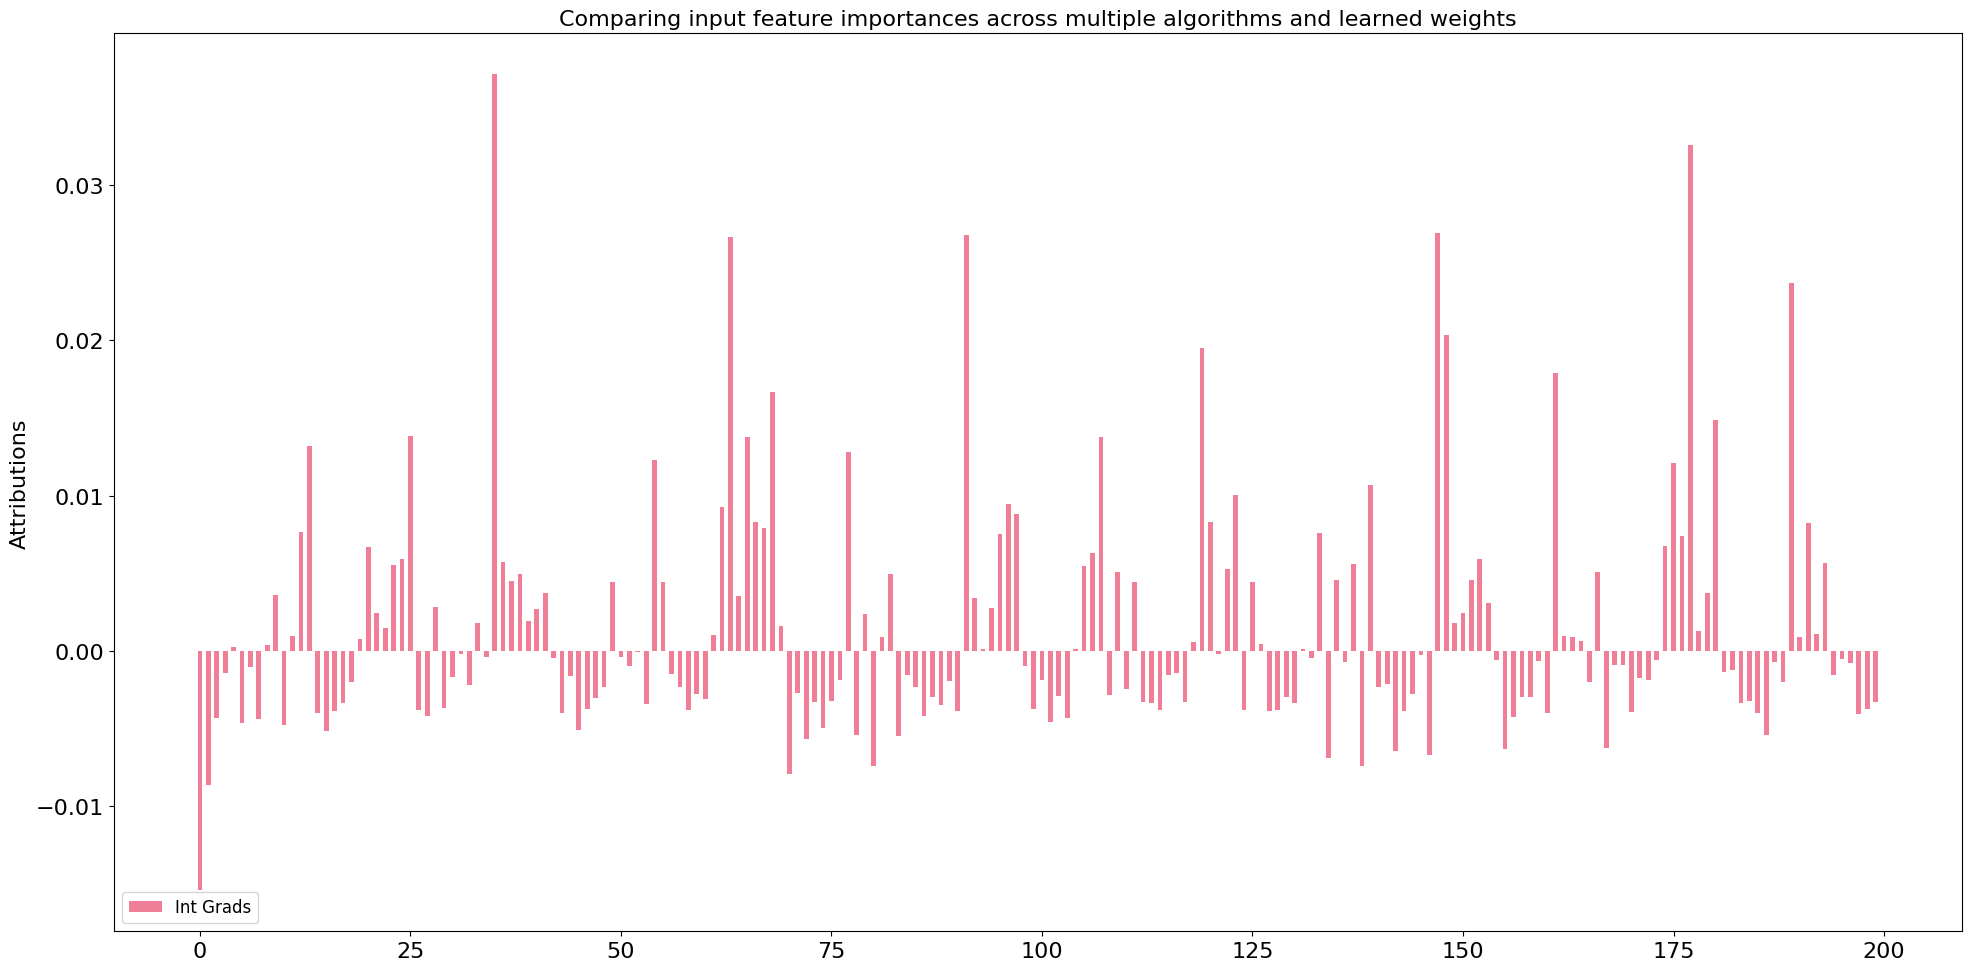

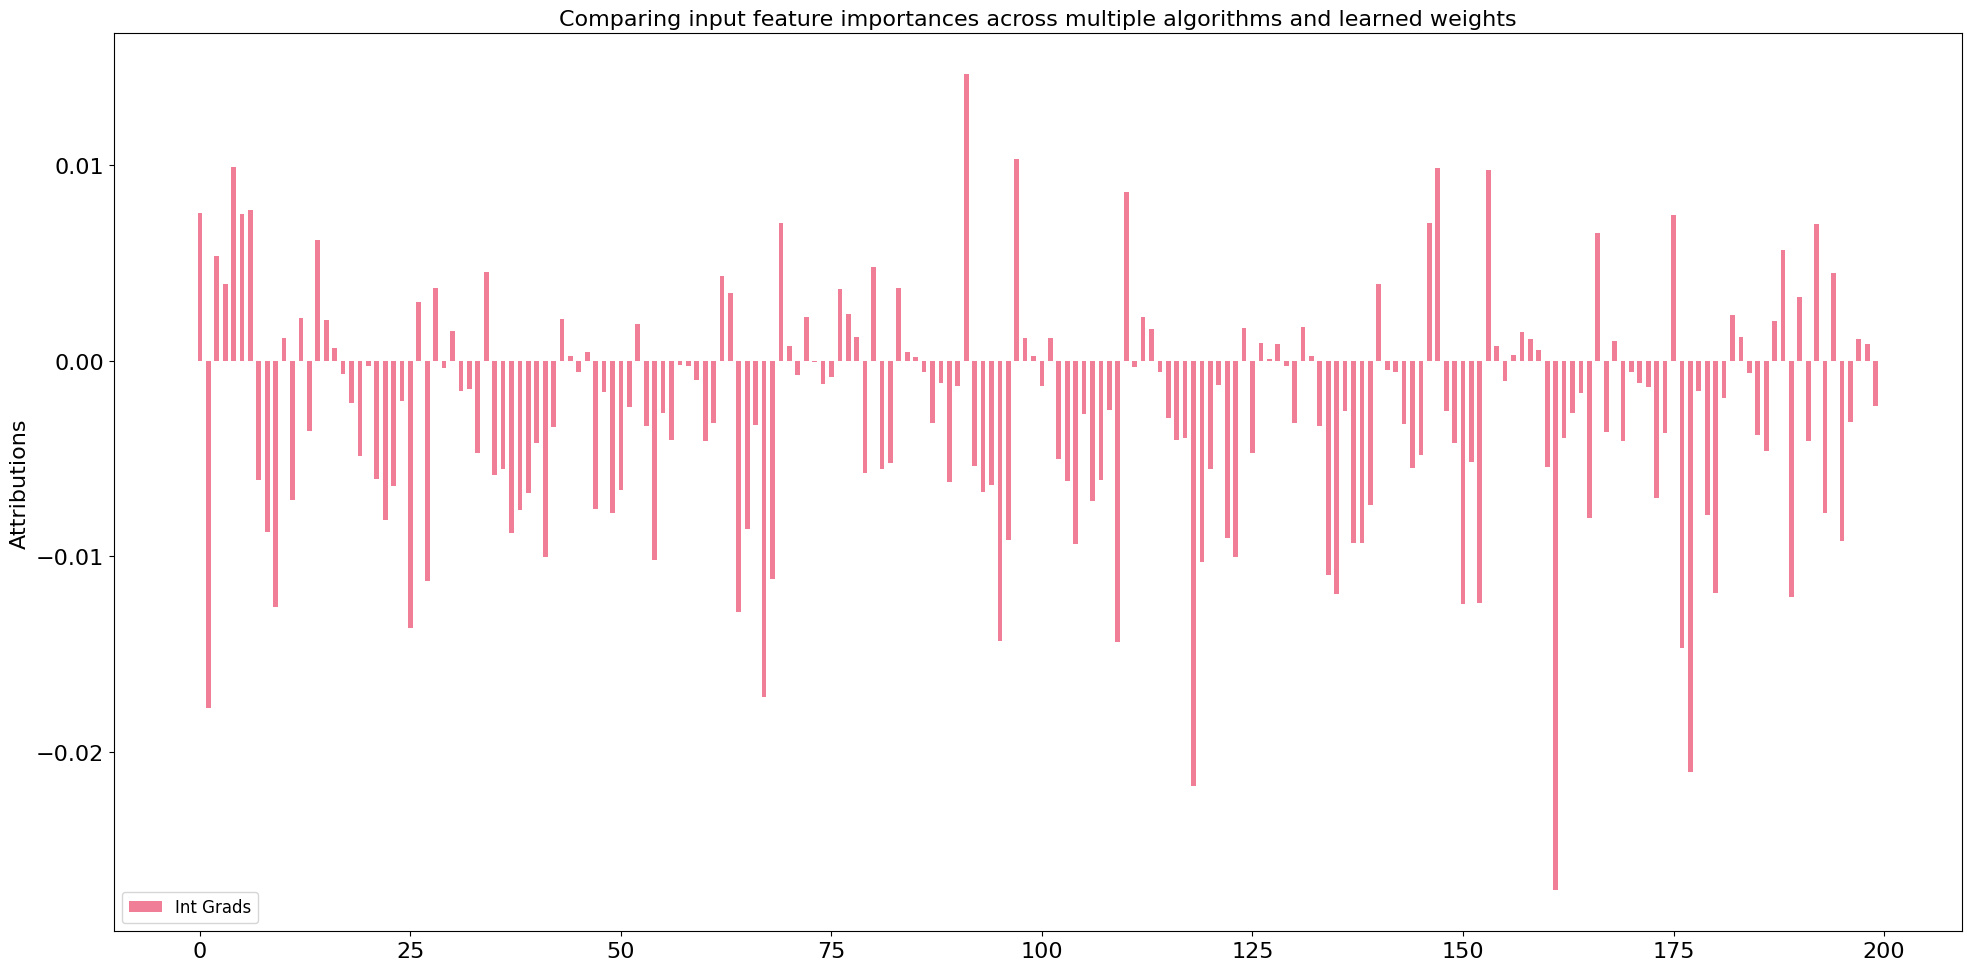

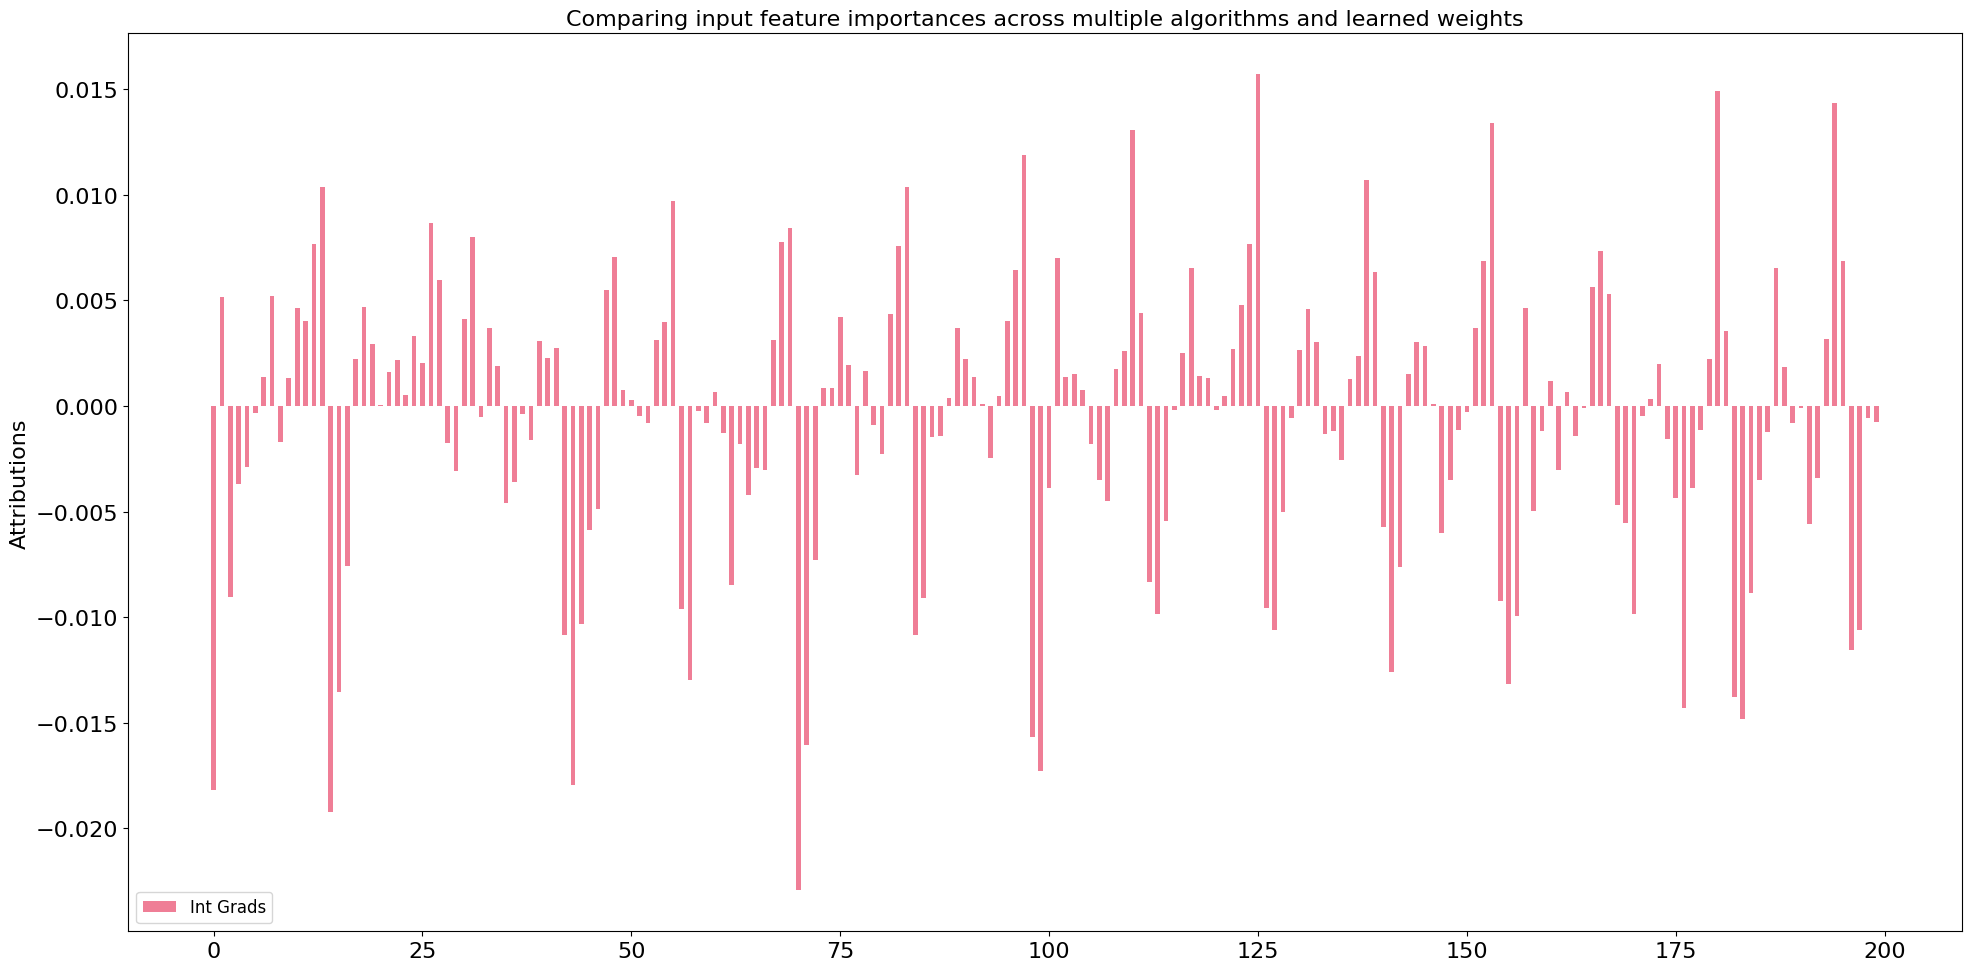

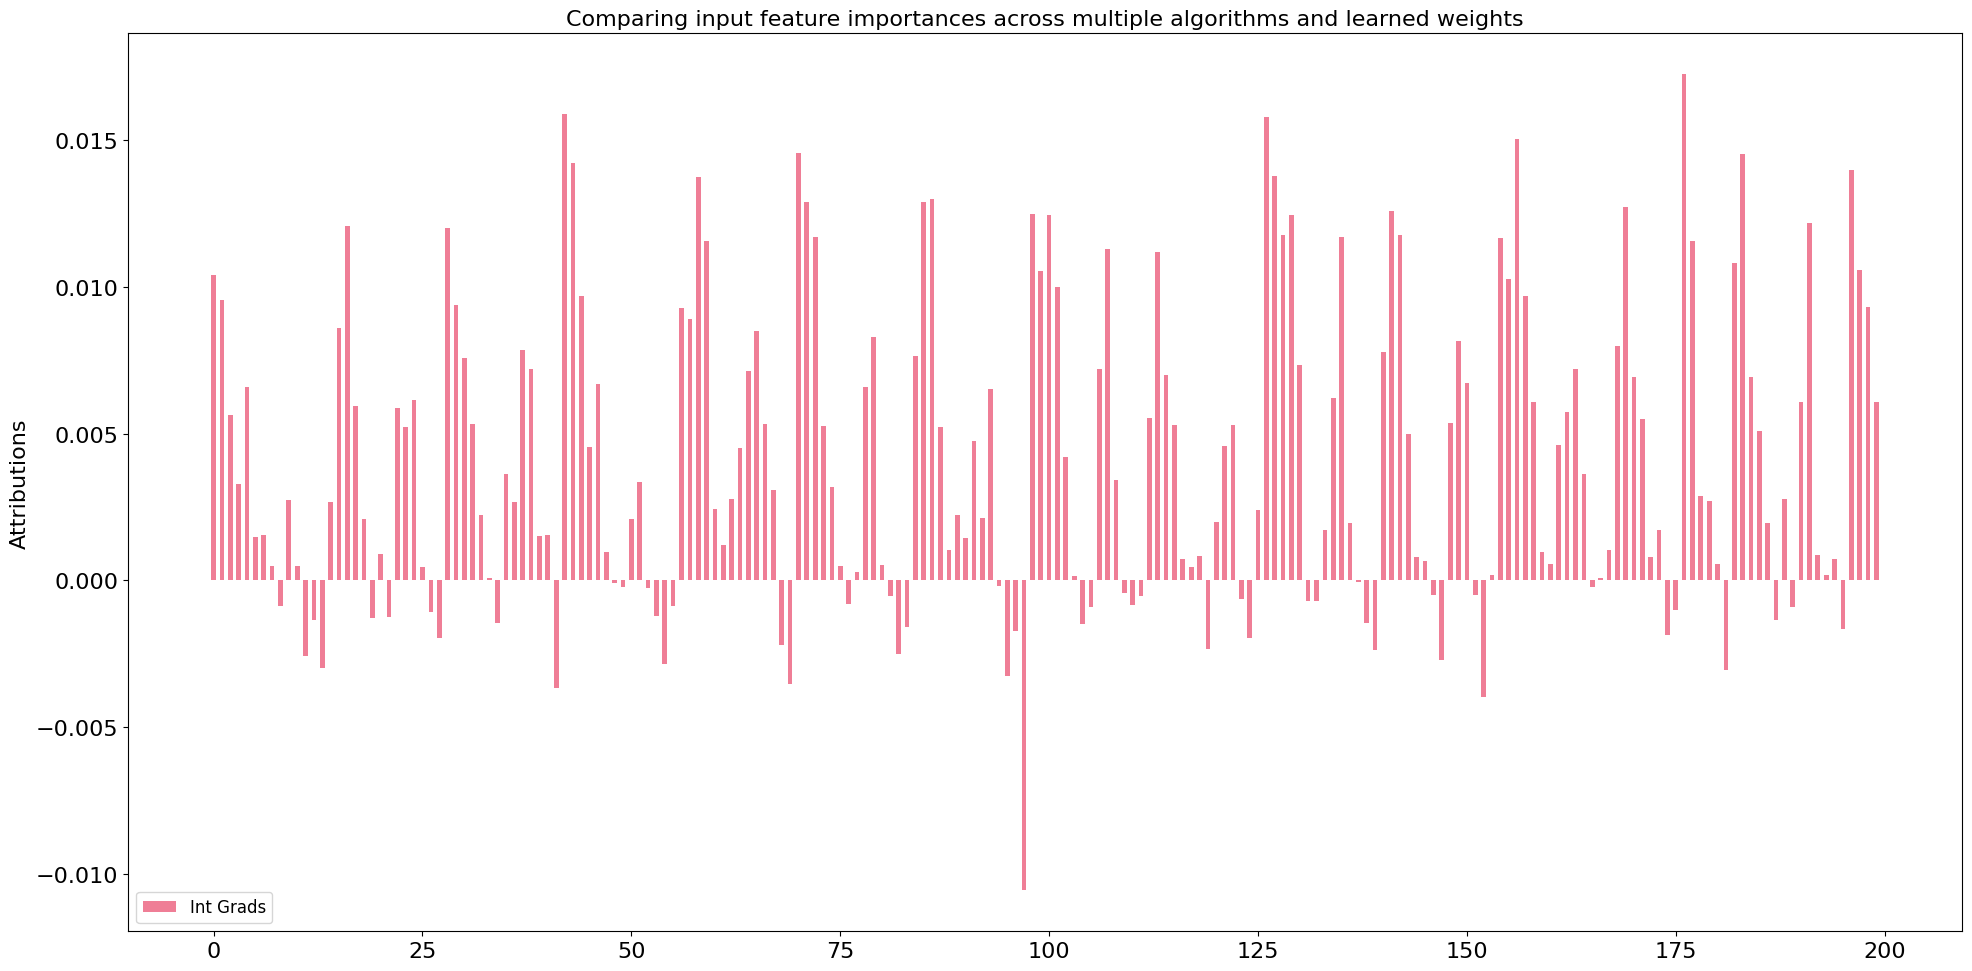

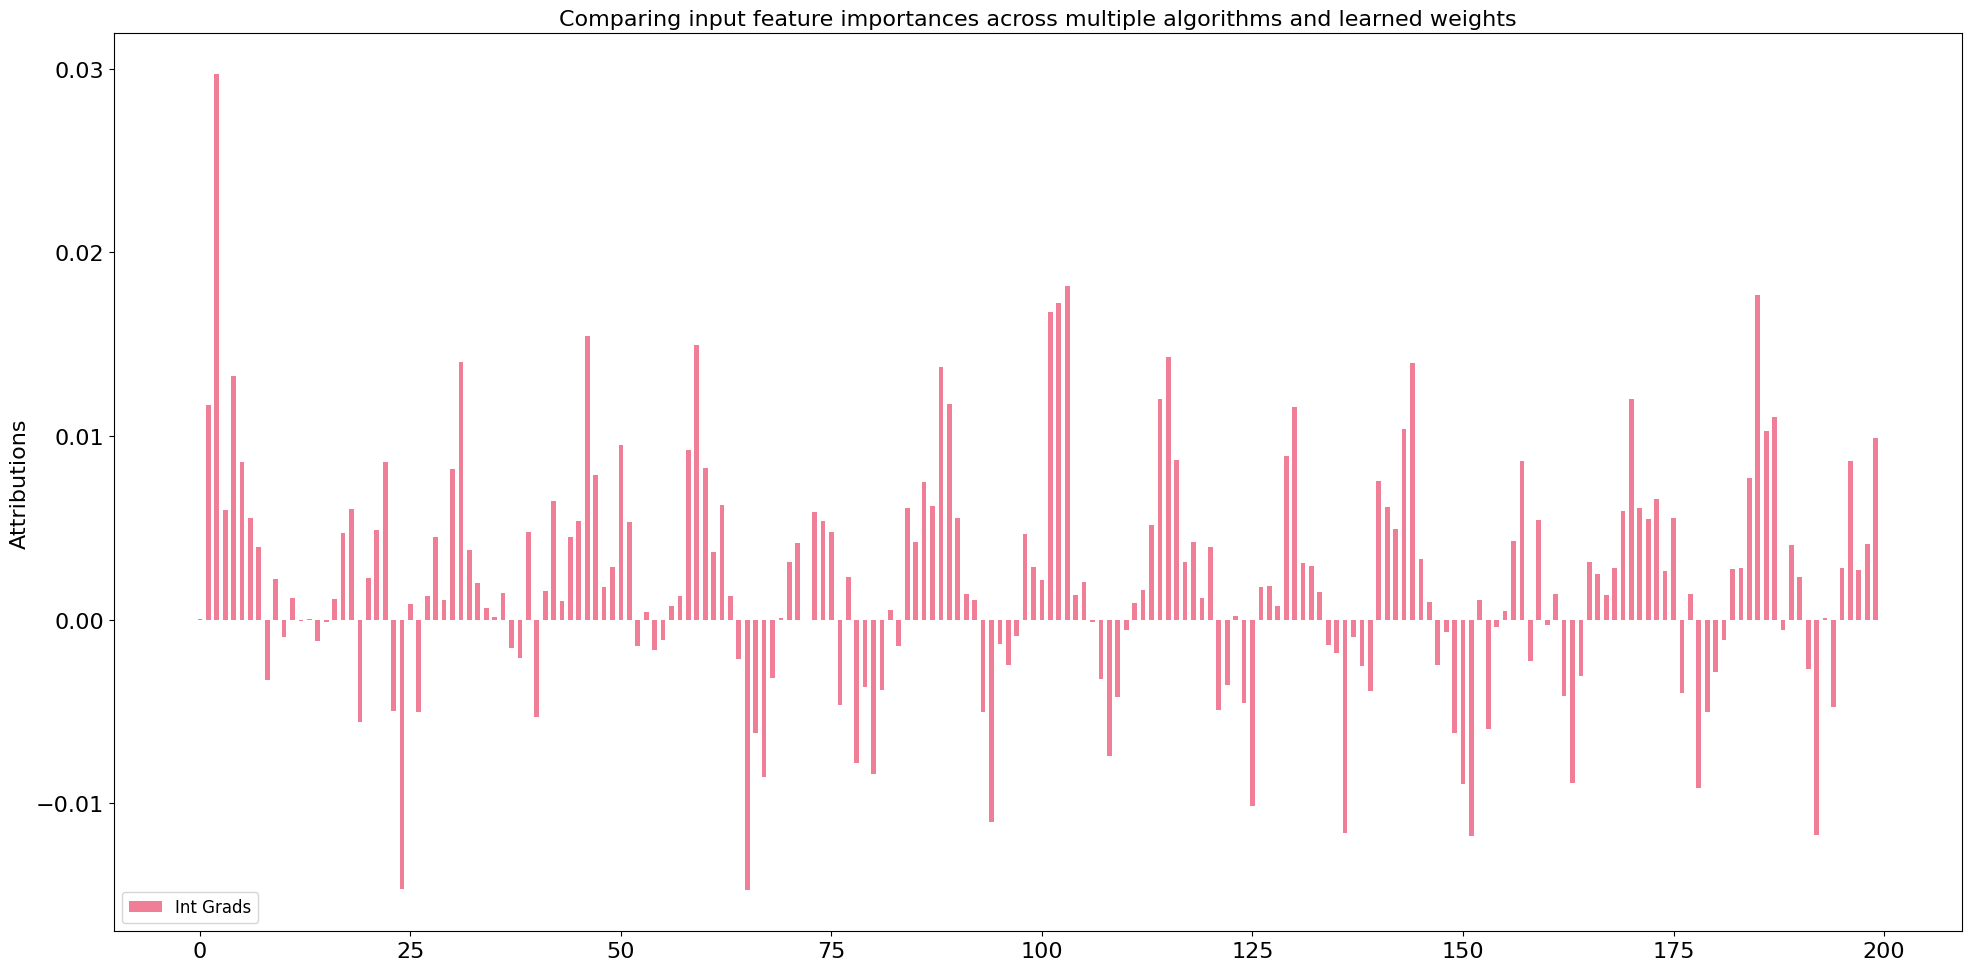

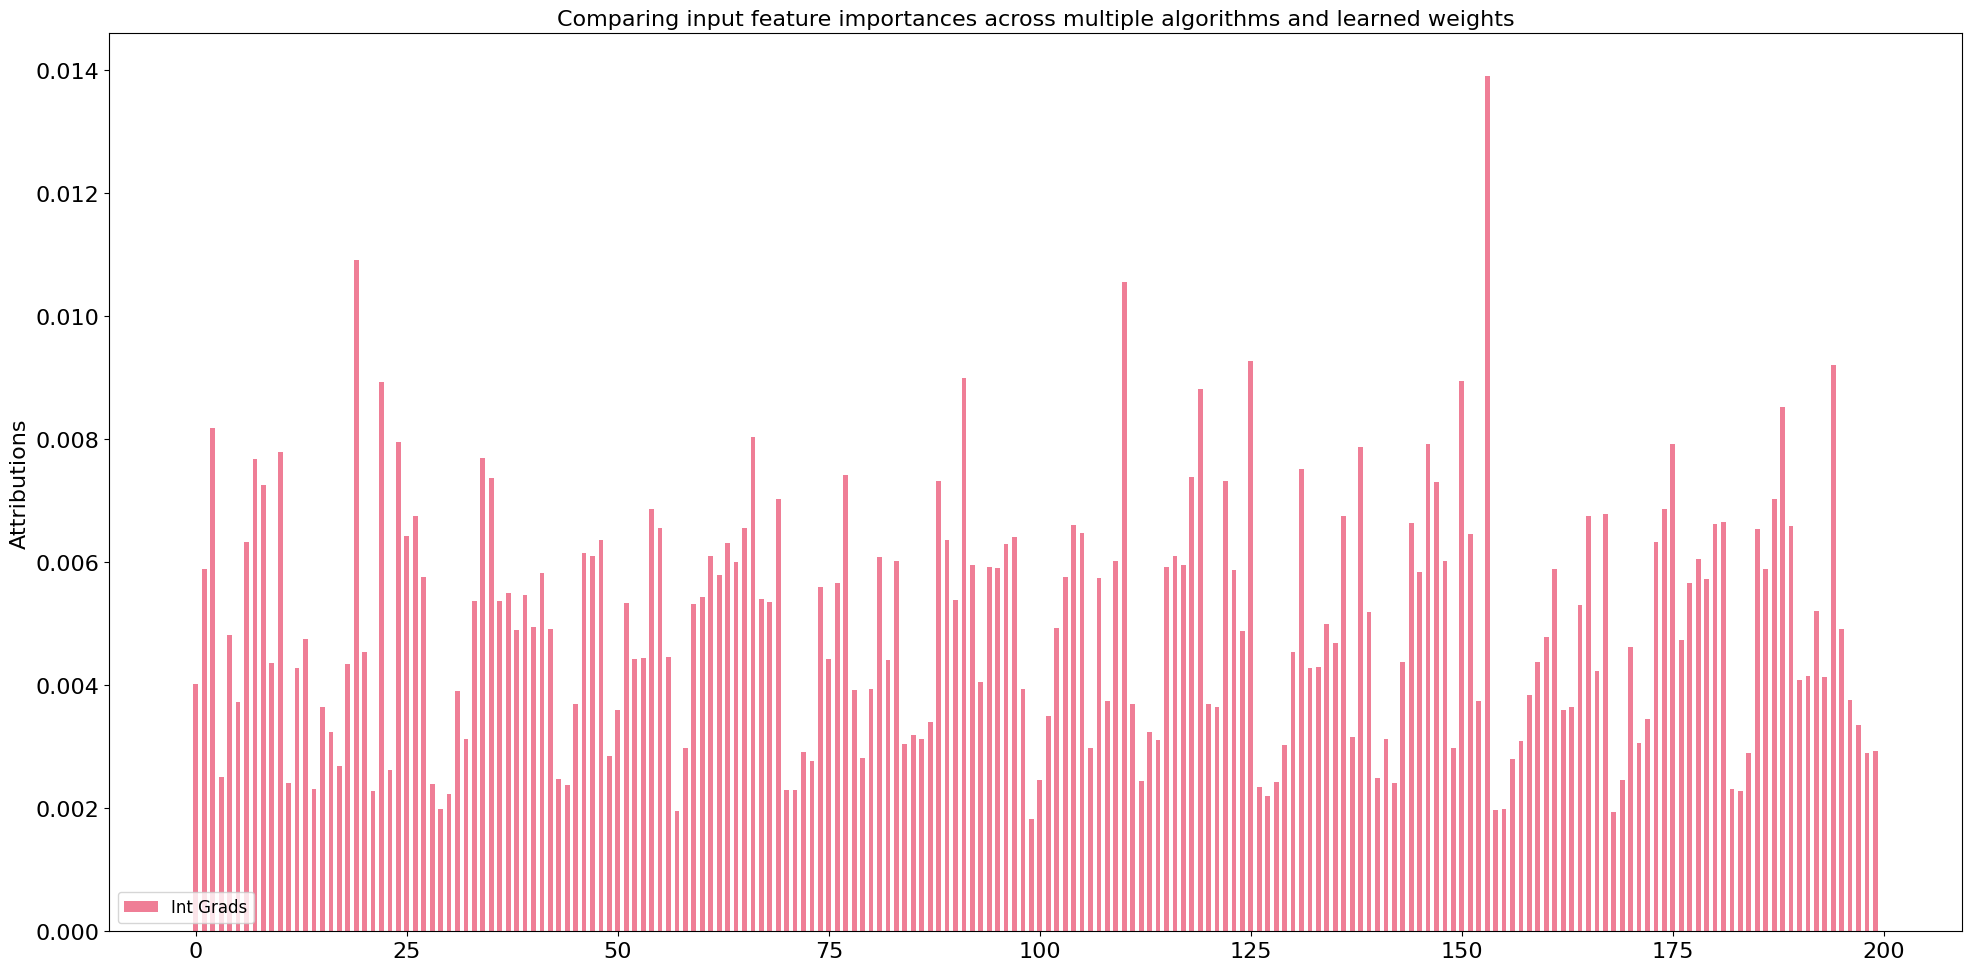

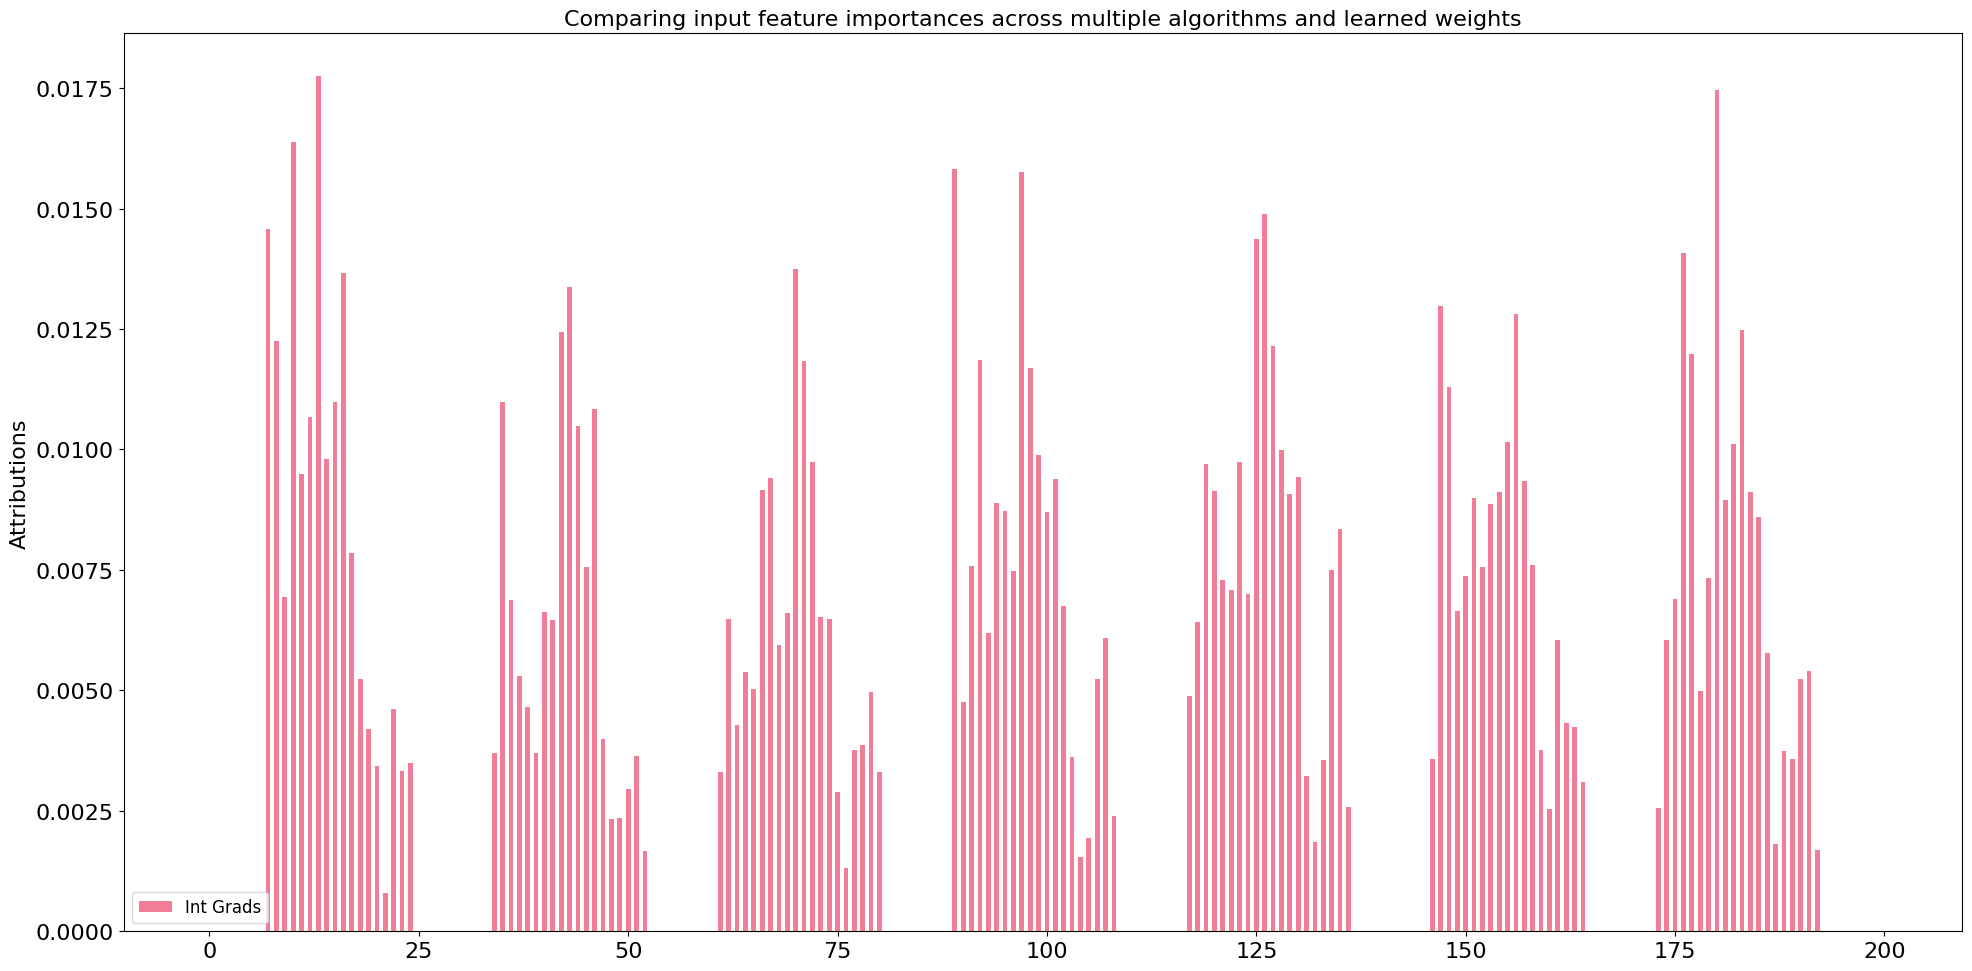

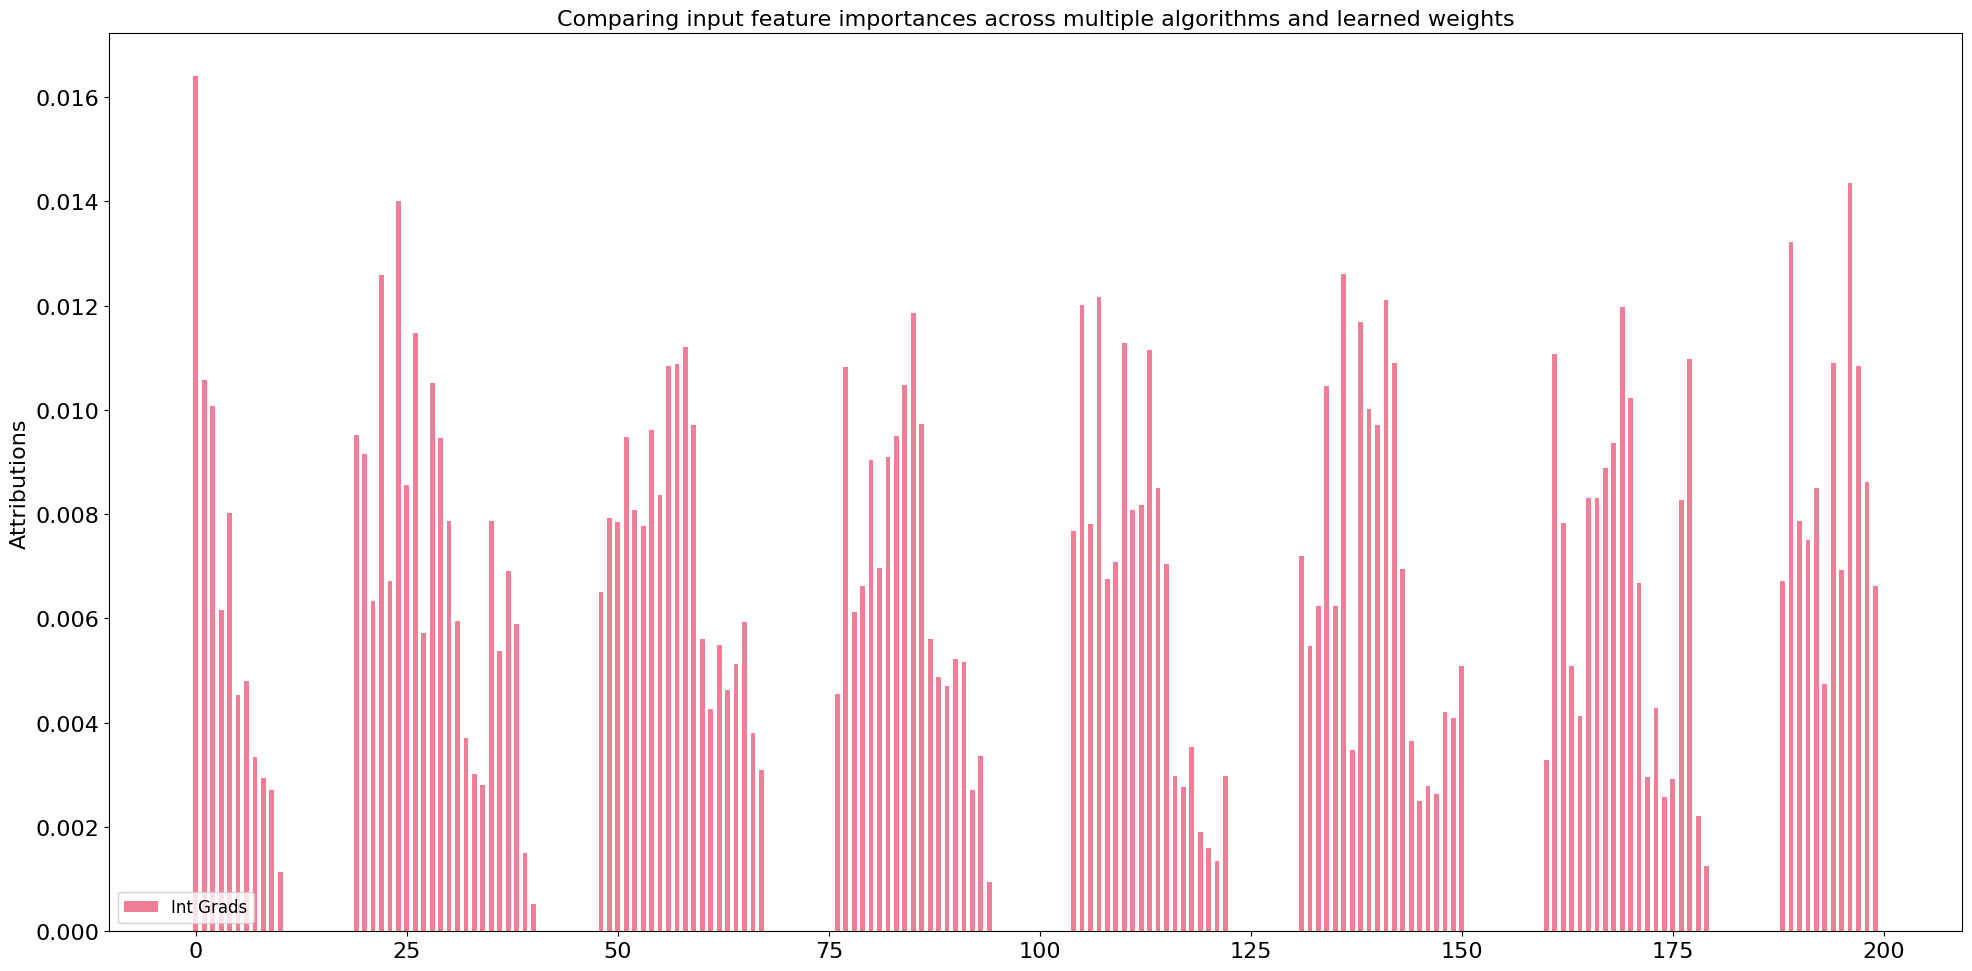

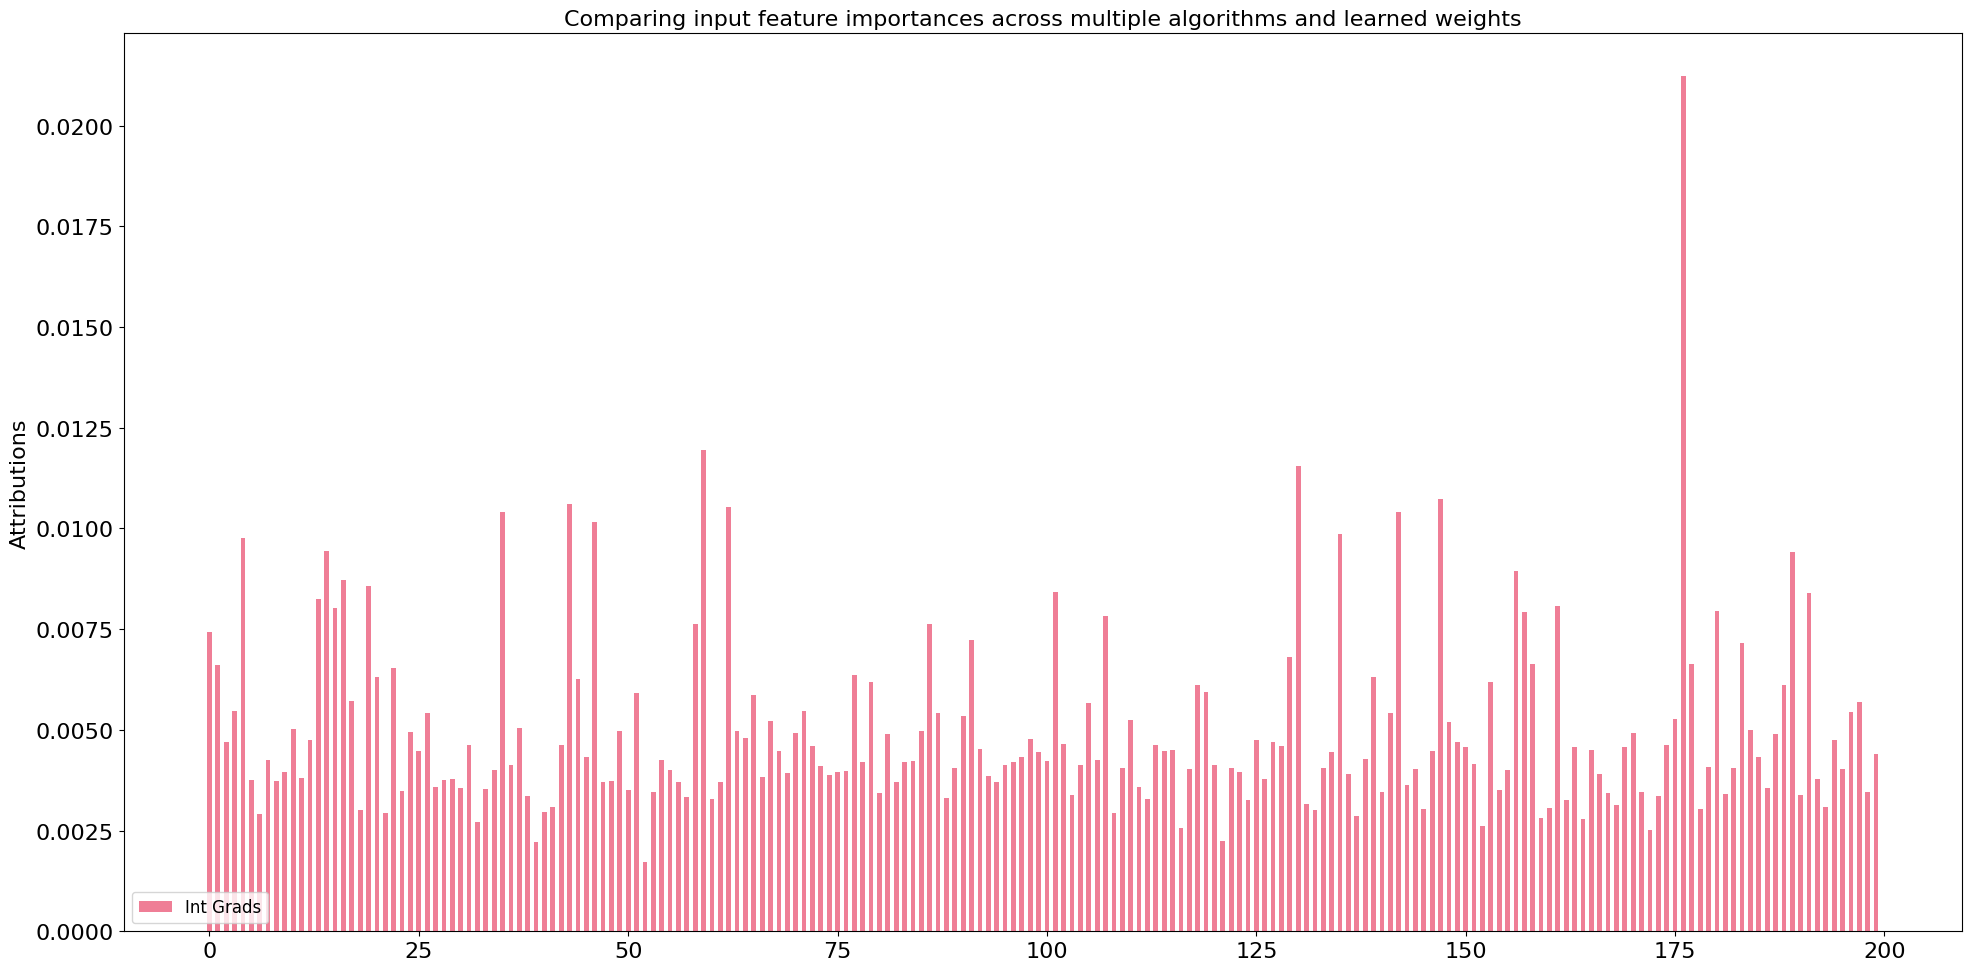

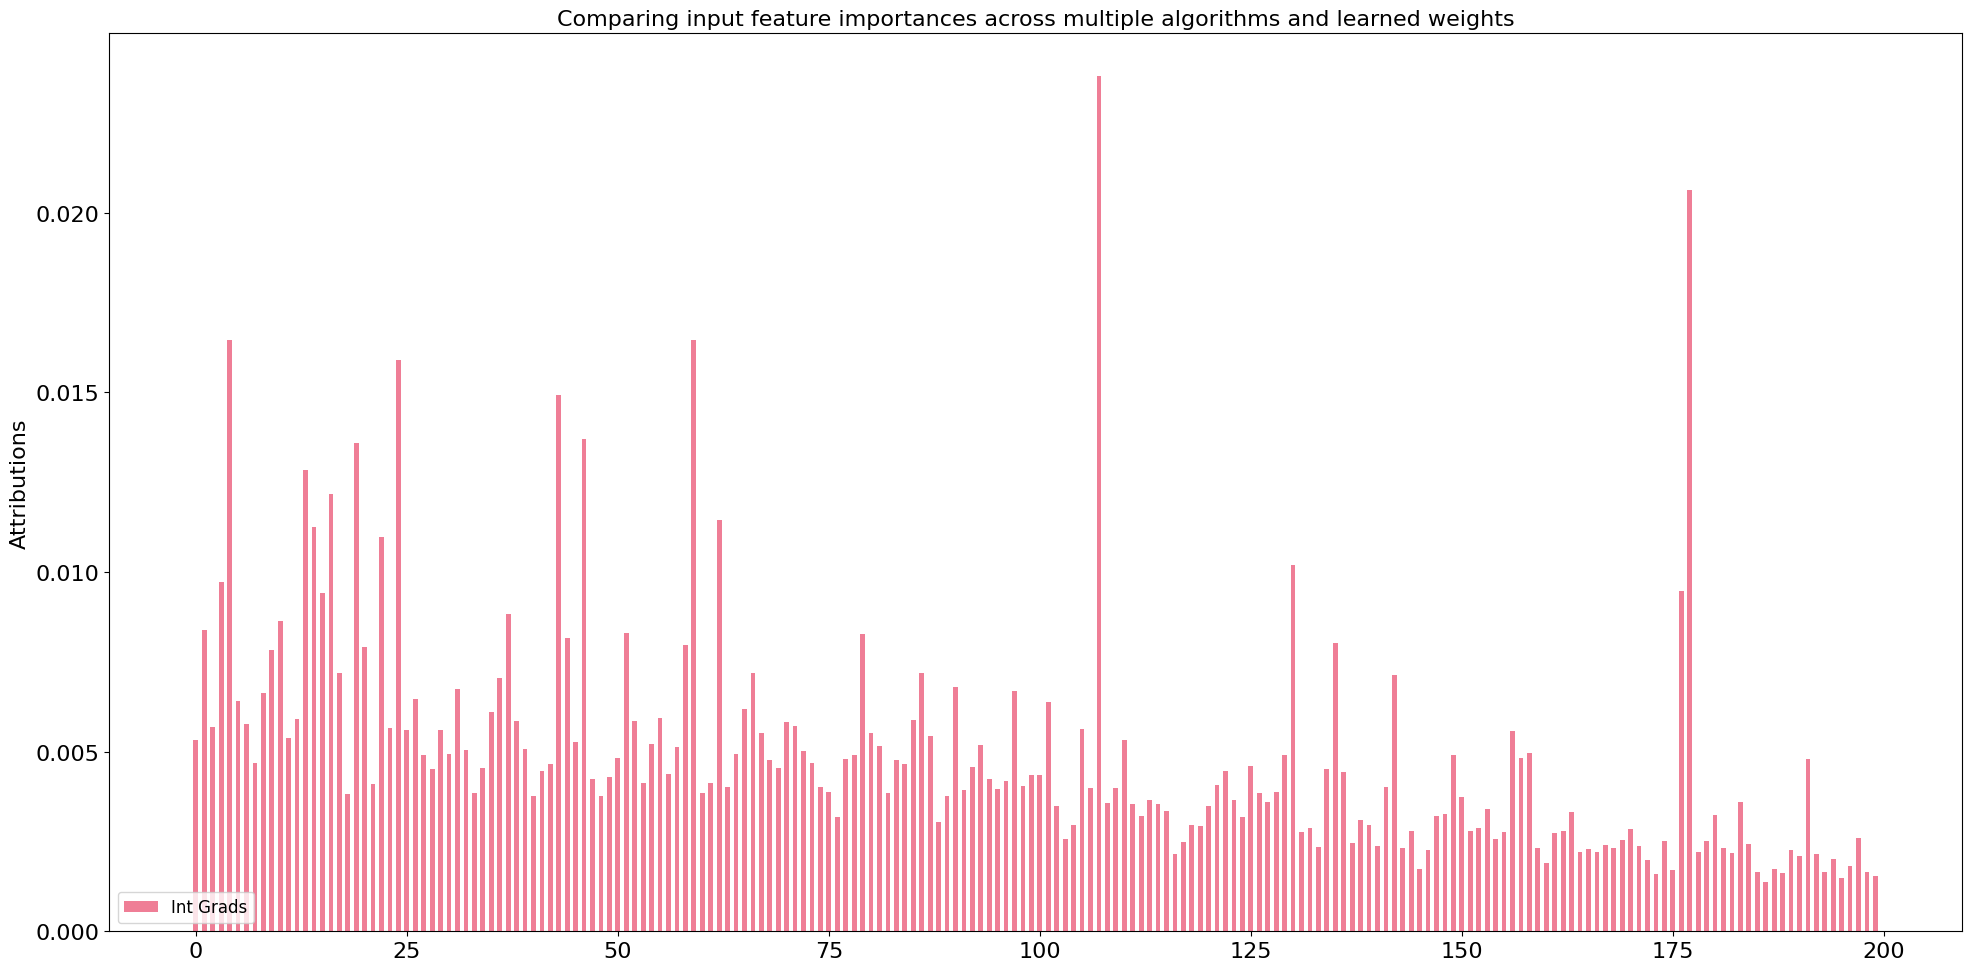

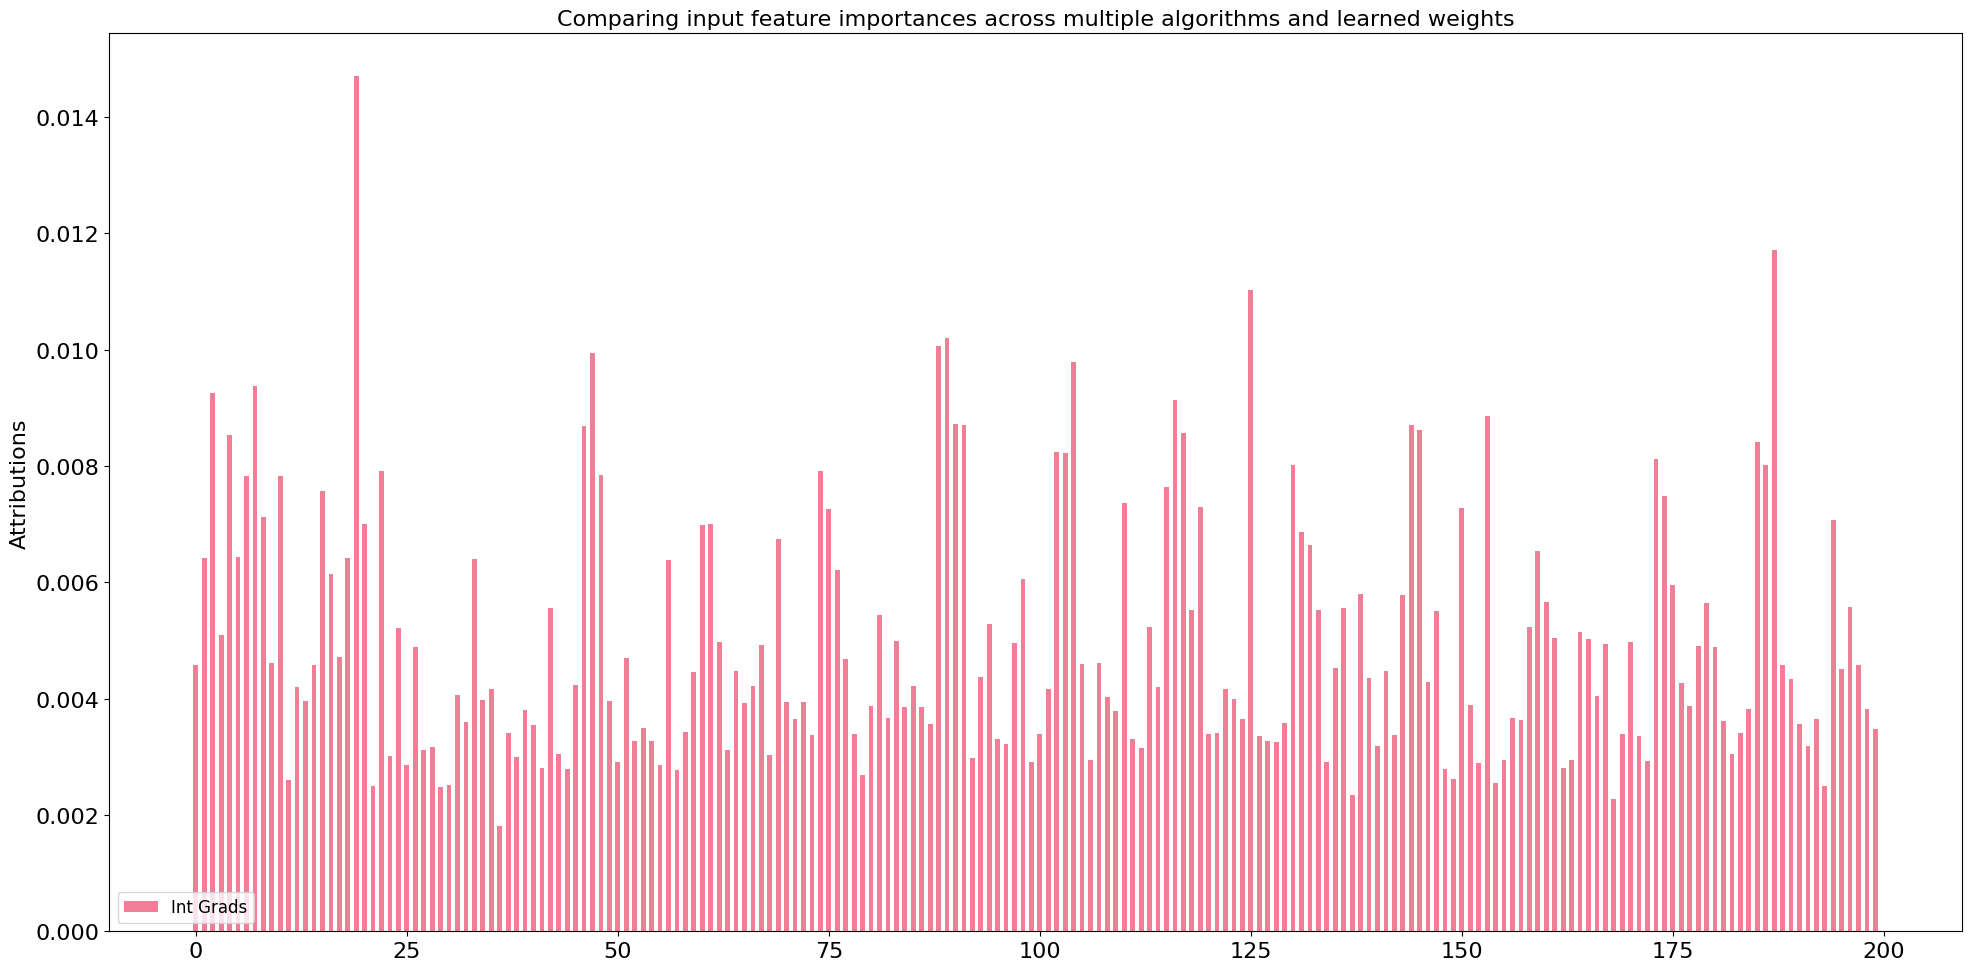

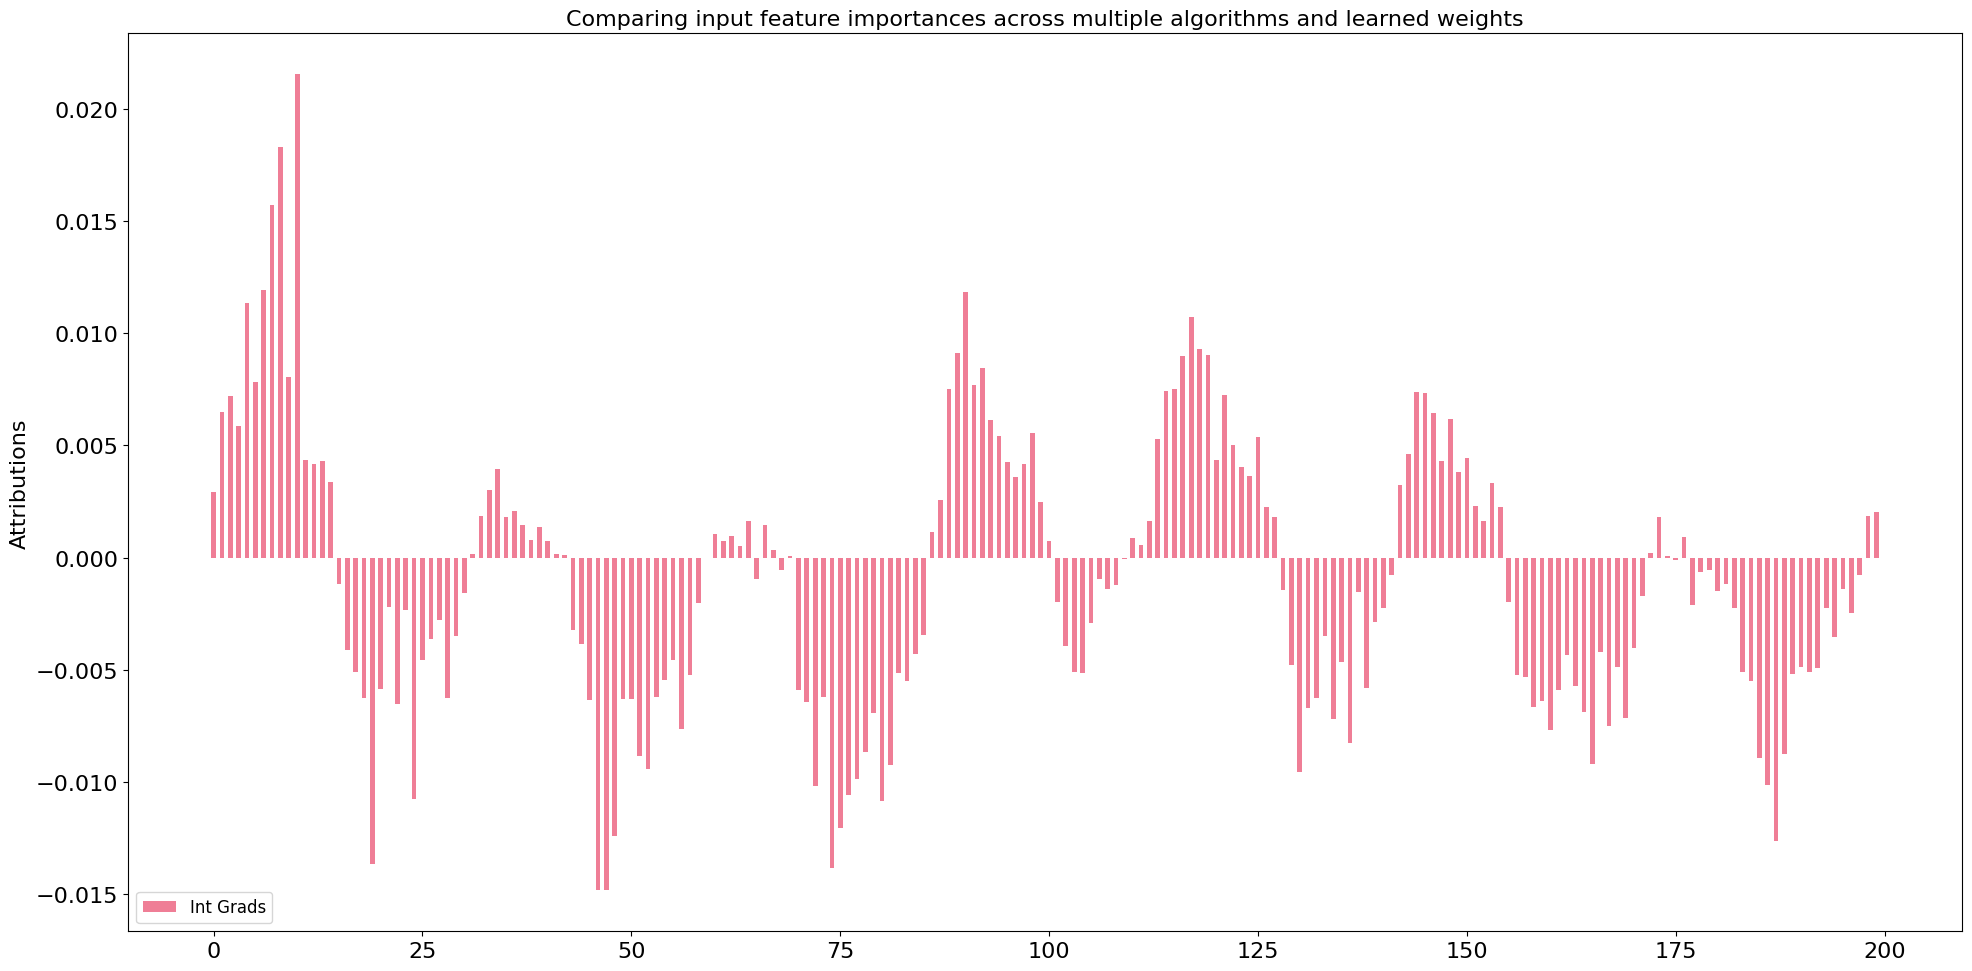

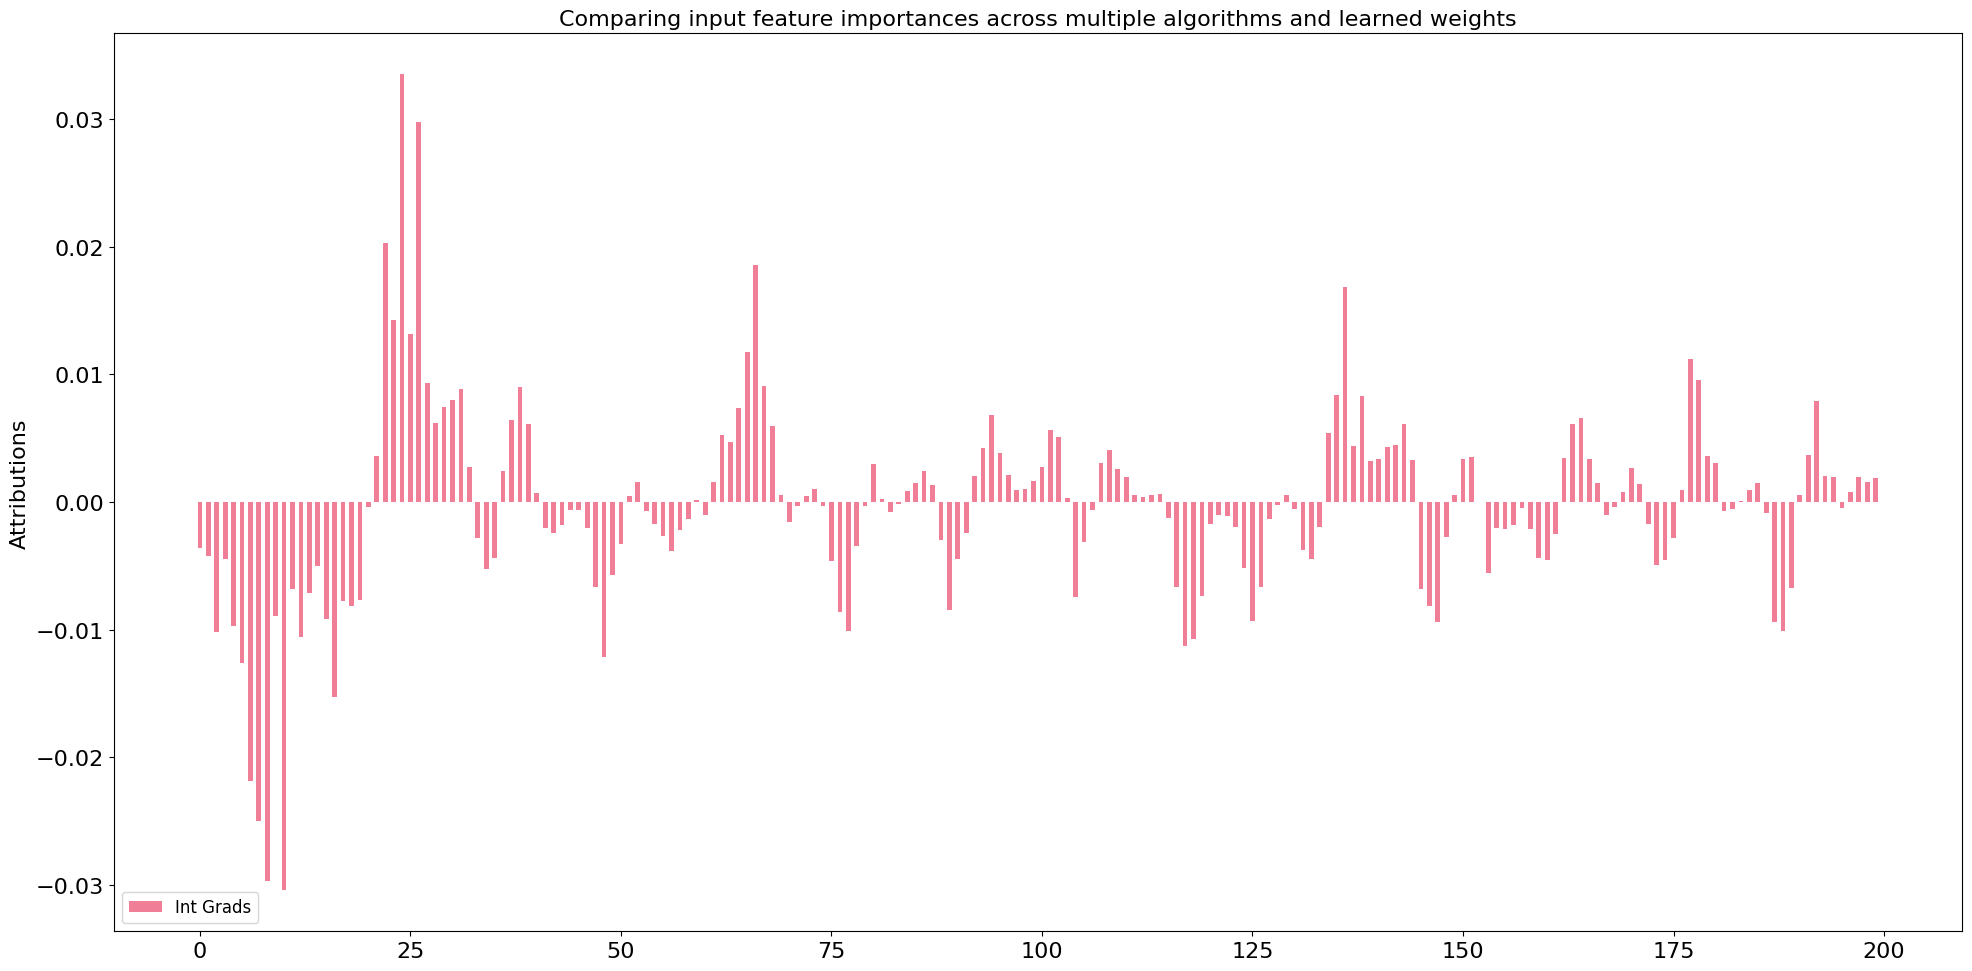

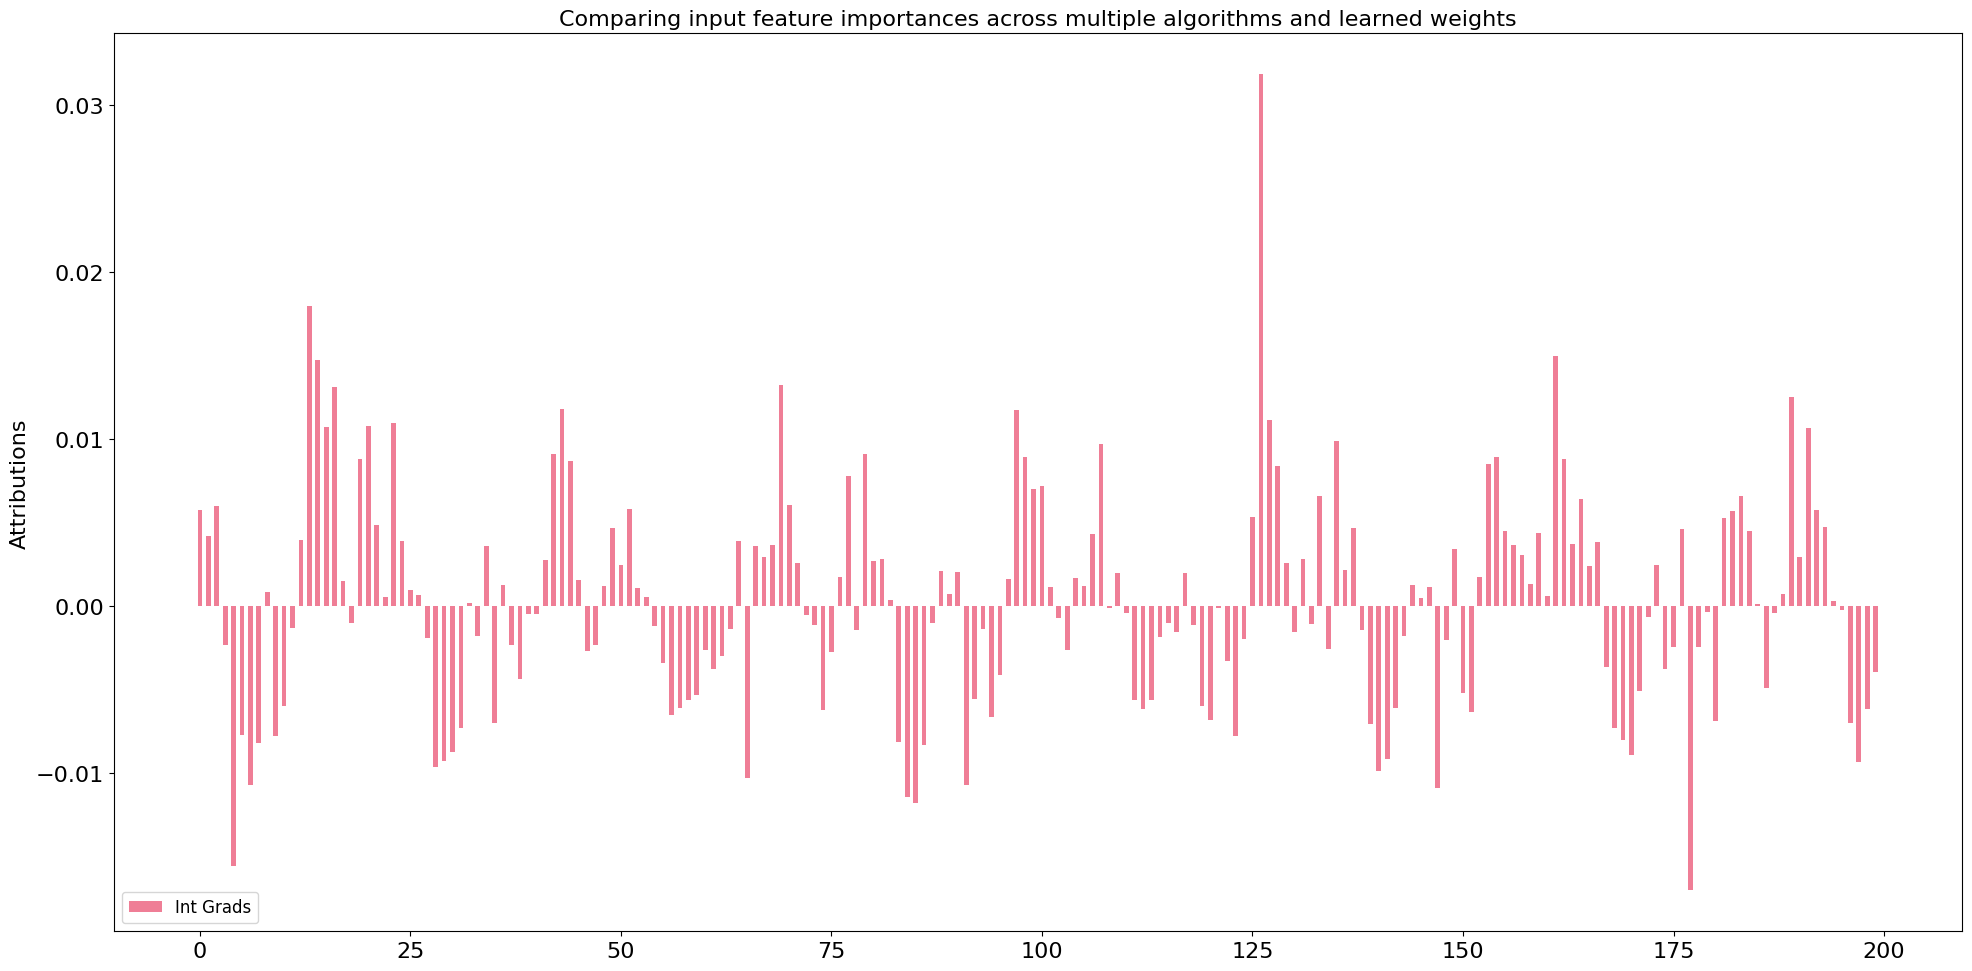

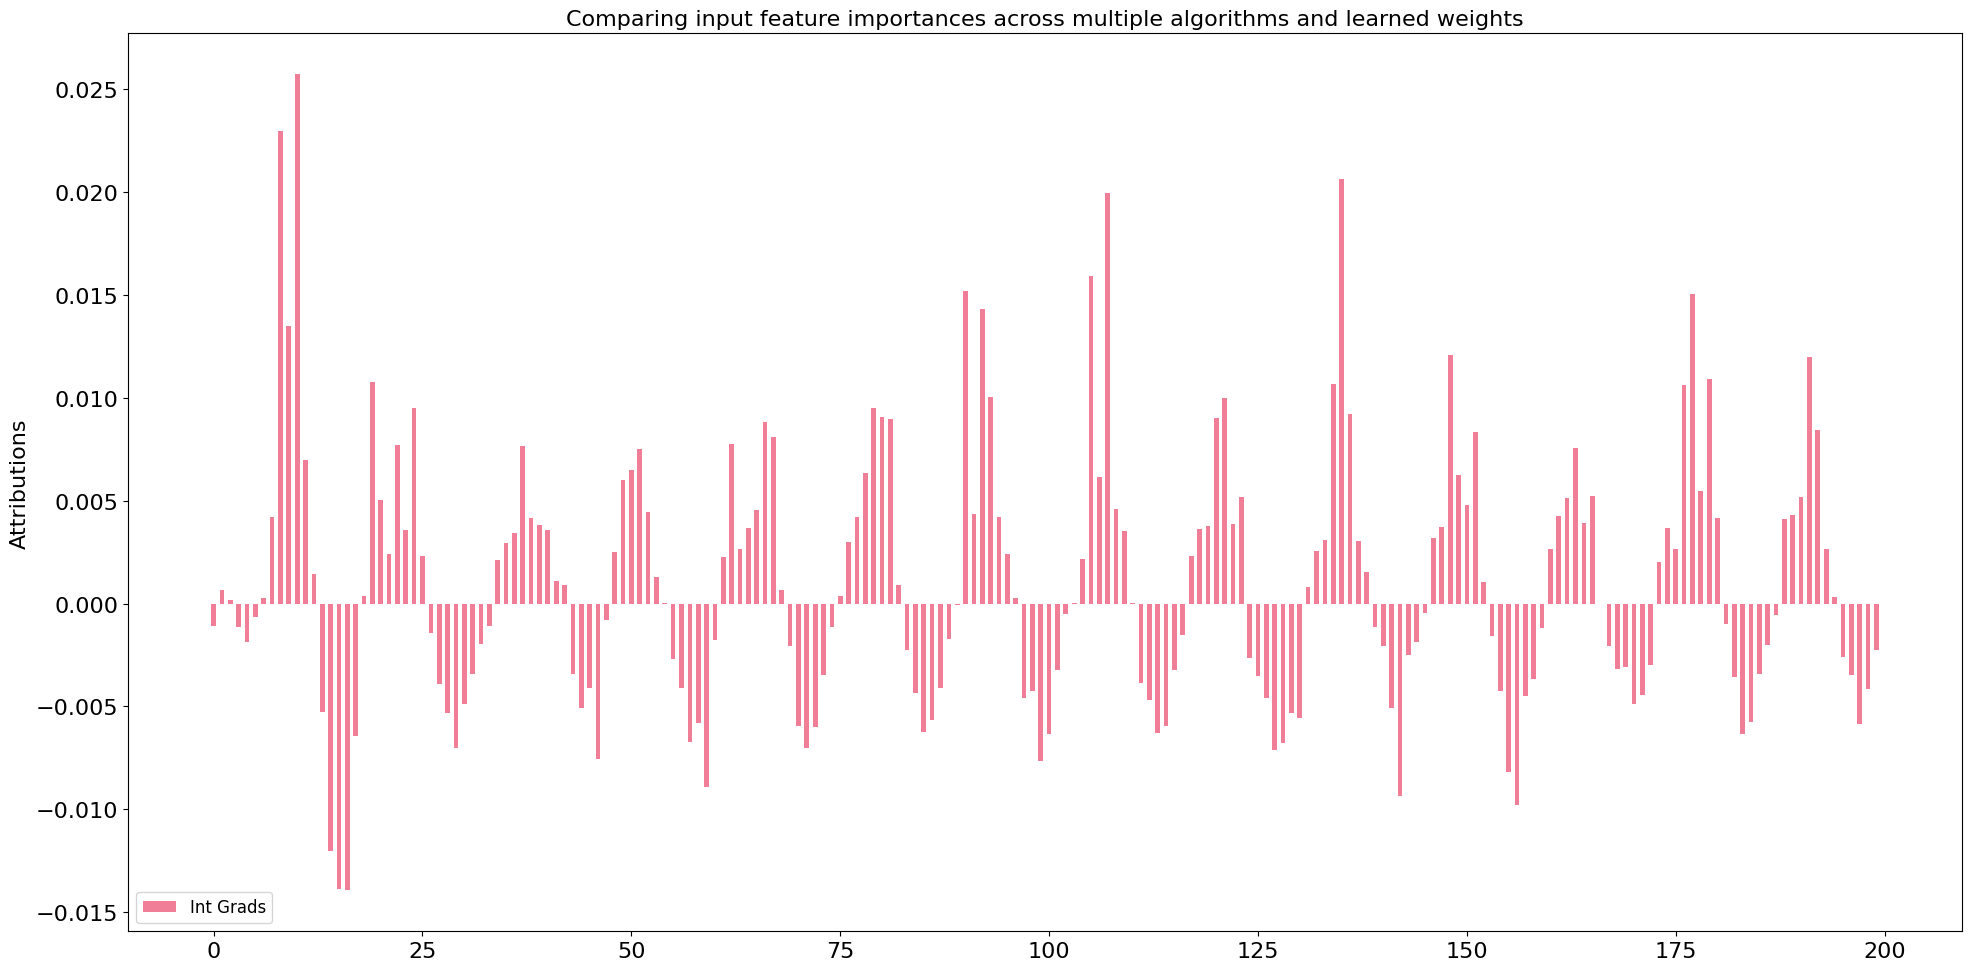

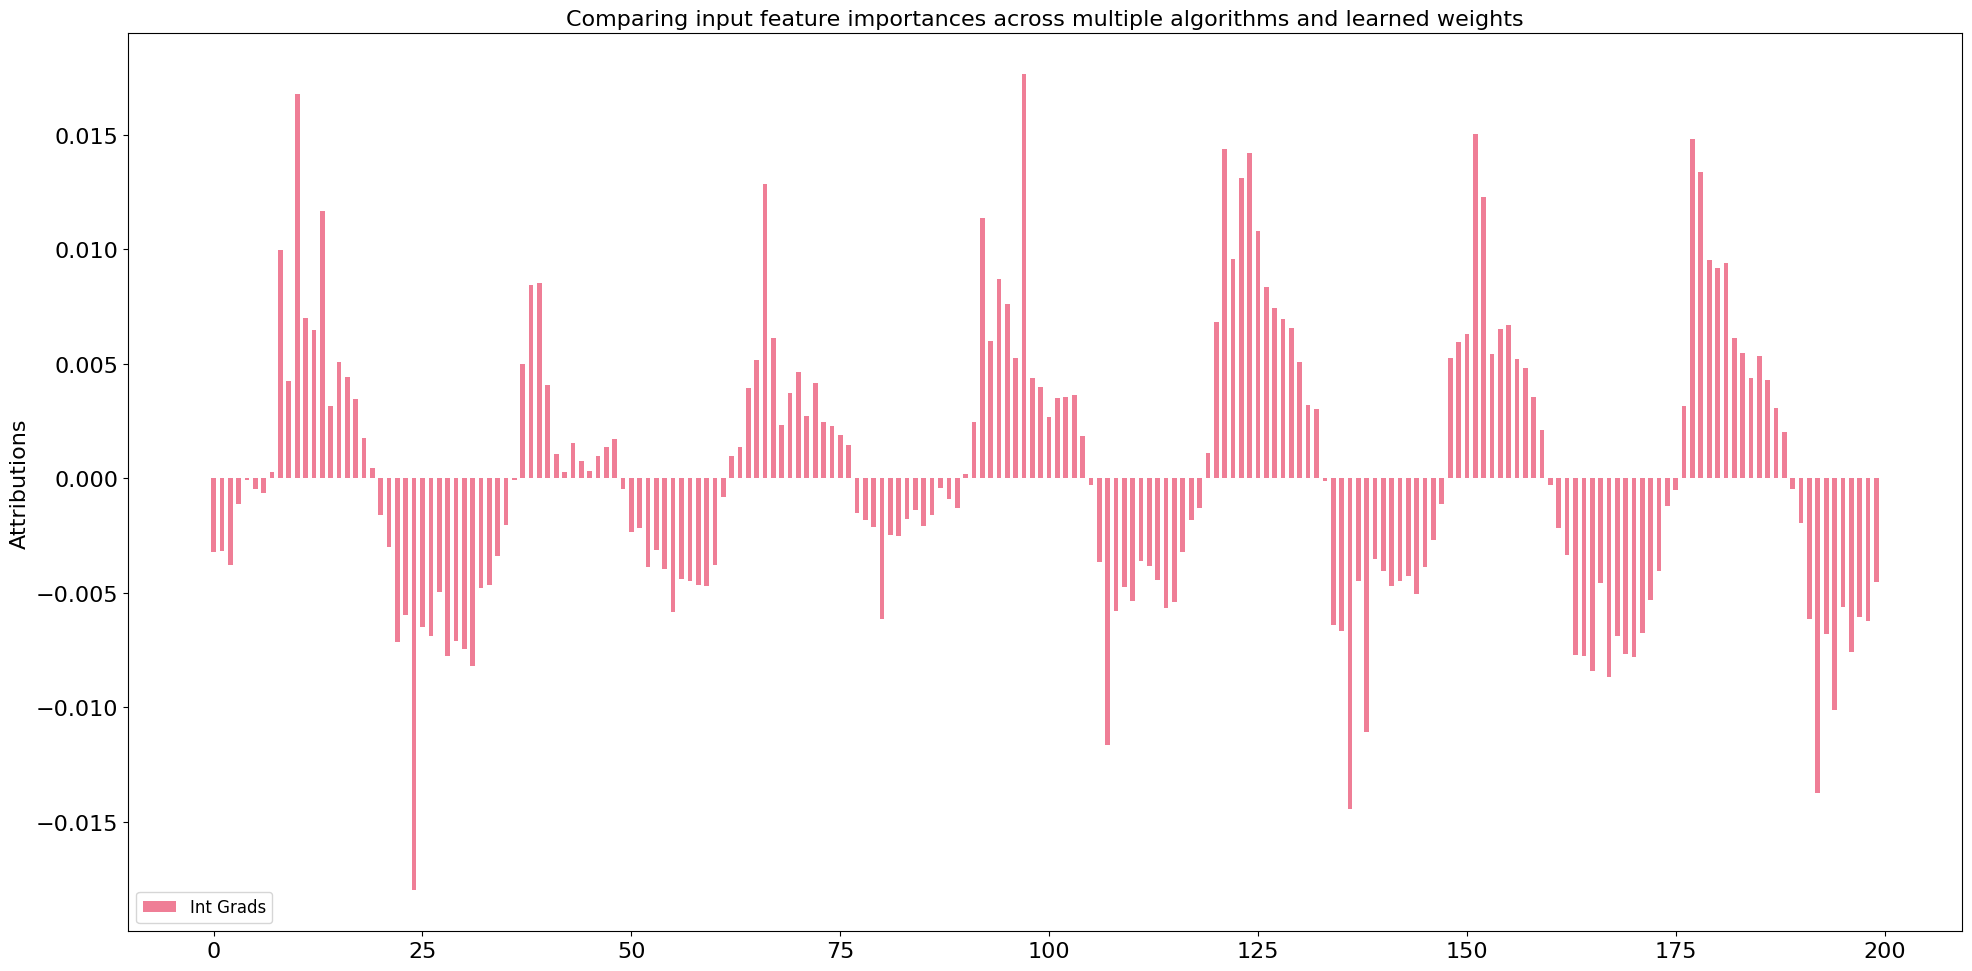

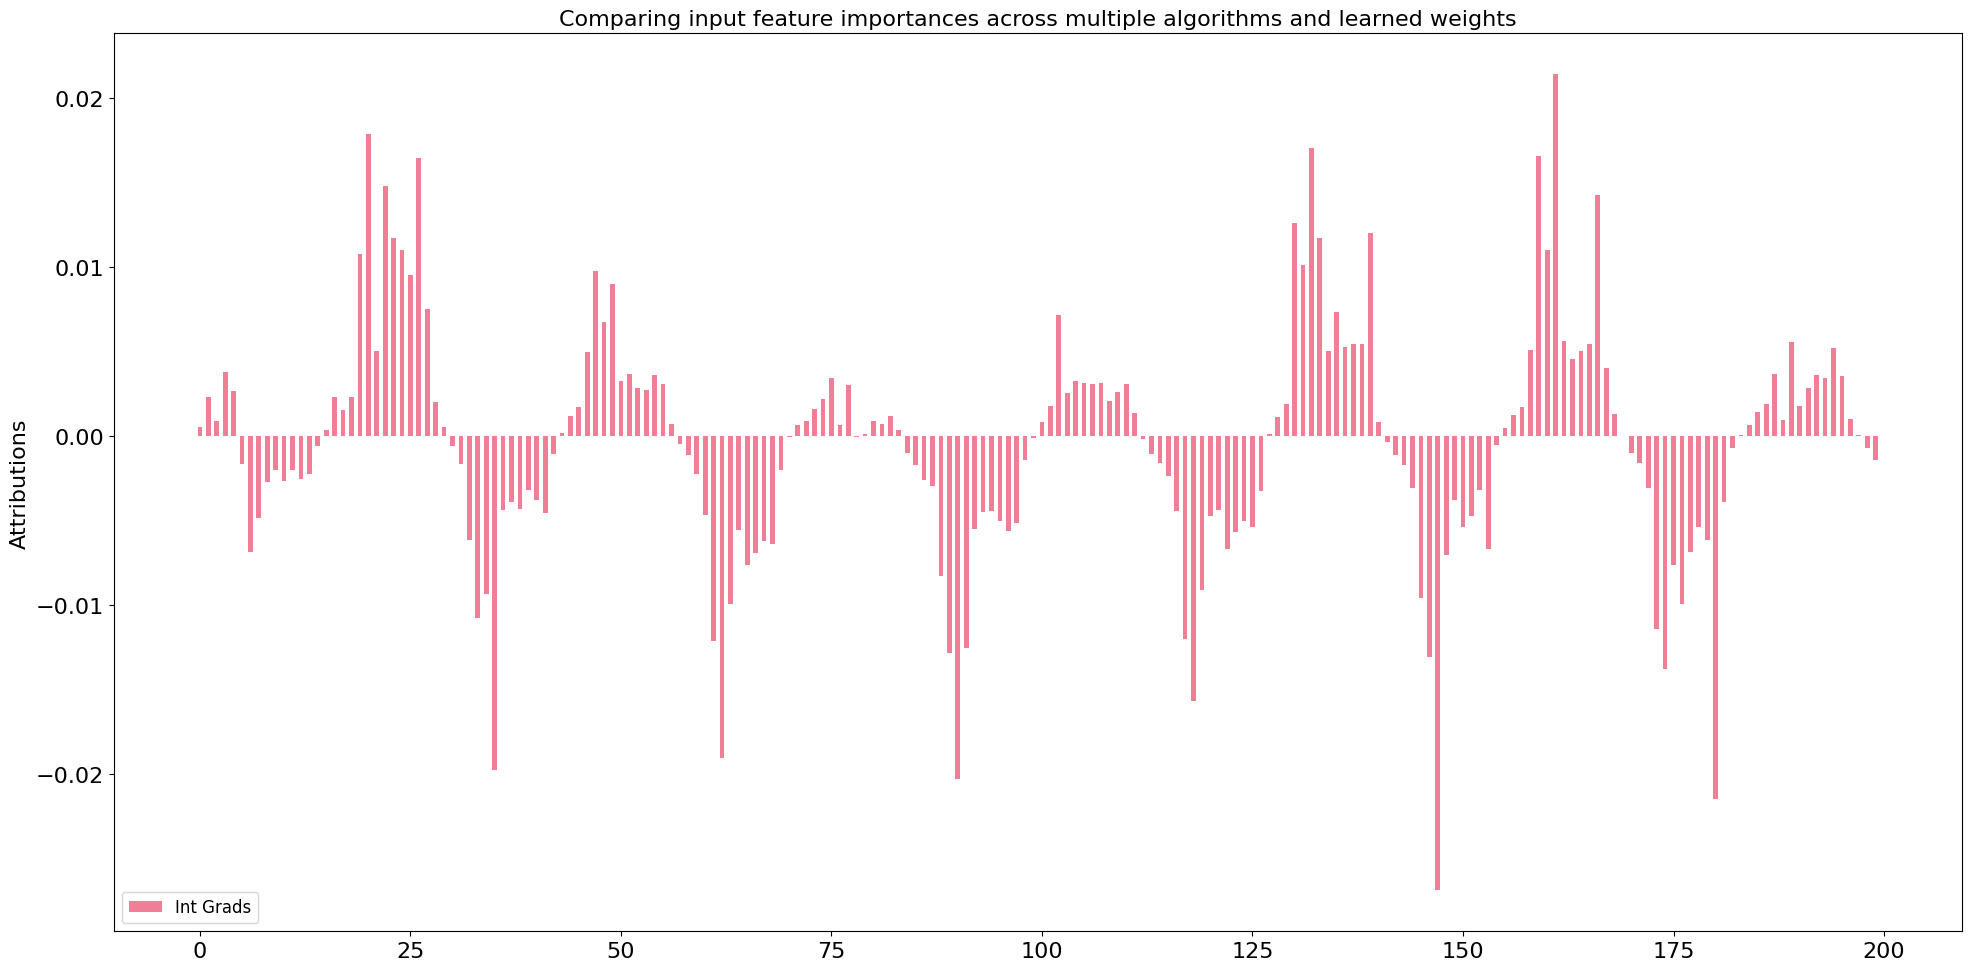

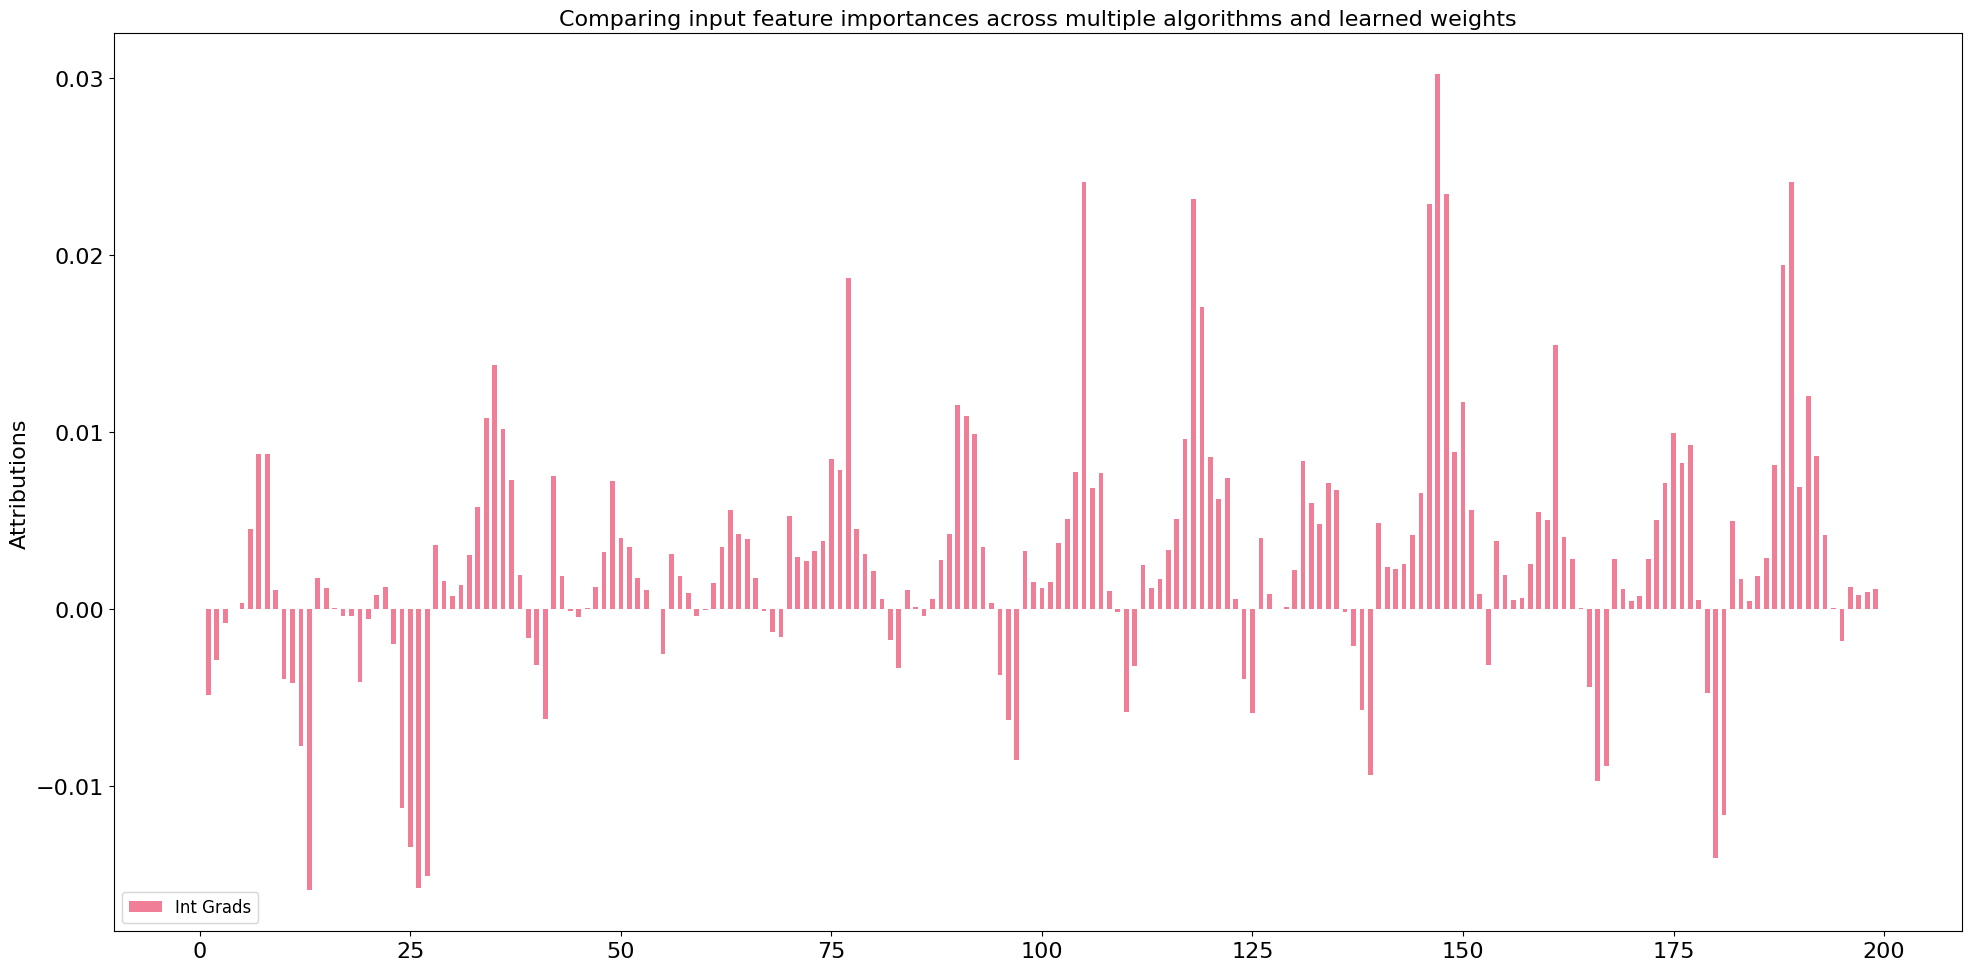

In [ ]:
def plot_feature_at(feature: int = 1):
    feature_idx = feature

    test_data = torch.Tensor(data_set[0:200, :]).to(device)
    ig_attr_test = ig.attribute(test_data, n_steps=50).cpu()
    feature_names = np.arange(200)
    x_axis_data = np.arange(200)
    _axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

    ig_attr_test_sum = ig_attr_test.detach().numpy()[:, feature_idx]
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    ig_attr_test_norm_sum = ig_attr_test_norm_sum
    width = 0.14 * 4
    # legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation']
    legends = ["Int Grads"]
    plt.figure(figsize=(20, 10))

    ax = plt.subplot()
    ax.set_title(
        "Comparing input feature importances across multiple algorithms and learned weights"
    )
    ax.set_ylabel("Attributions")

    FONT_SIZE = 16
    plt.rc("font", size=FONT_SIZE)  # fontsize of the text sizes
    plt.rc("axes", titlesize=FONT_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=FONT_SIZE)  # fontsize of the x and y labels
    plt.rc("legend", fontsize=FONT_SIZE - 4)  # fontsize of the legend

    ax.bar(
        x_axis_data,
        ig_attr_test_norm_sum,
        width,
        align="center",
        alpha=0.8,
        color="#eb5e7c",
    )
    # ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
    # ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
    # ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
    # ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
    # ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
    ax.autoscale_view()
    plt.tight_layout()

    # ax.set_xticks(x_axis_data + 0)
    # ax.set_xticklabels(x_axis_data_labels, rotation='vertical')
    plt.legend(legends, loc=3)
    plt.show()


for i in range(23):
    plot_feature_at(i)

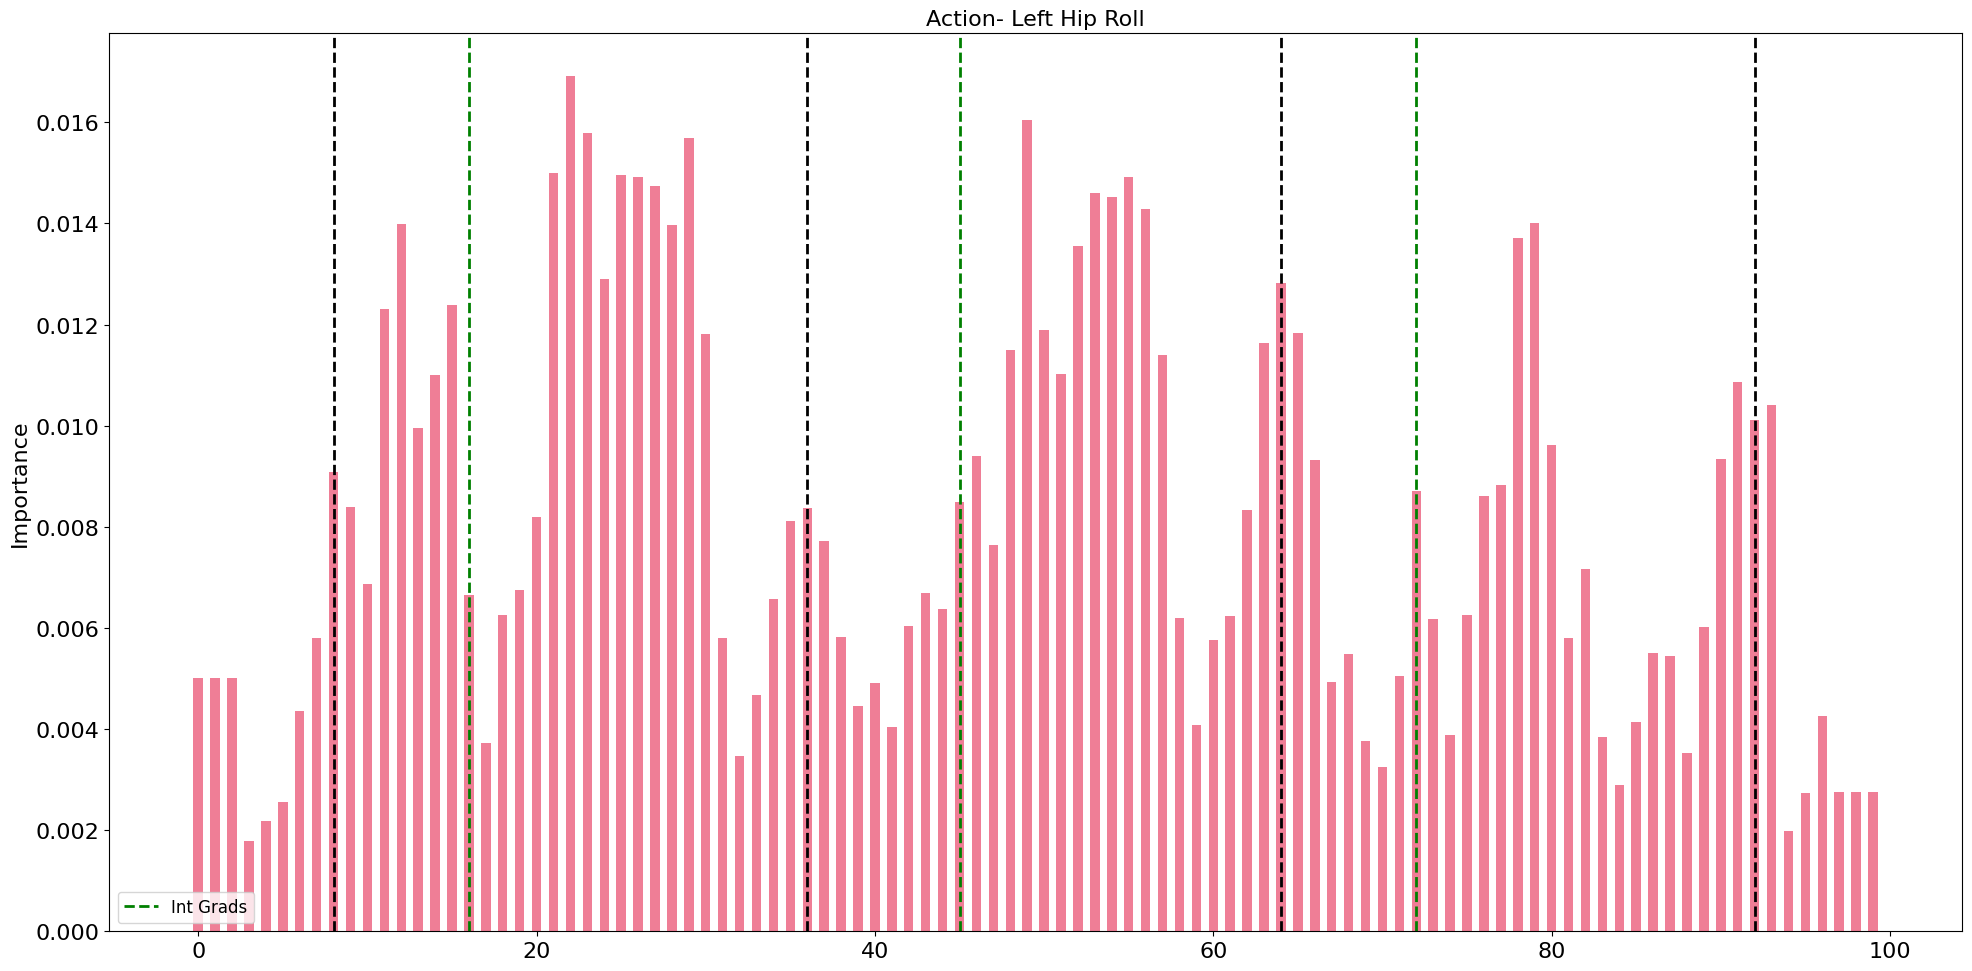

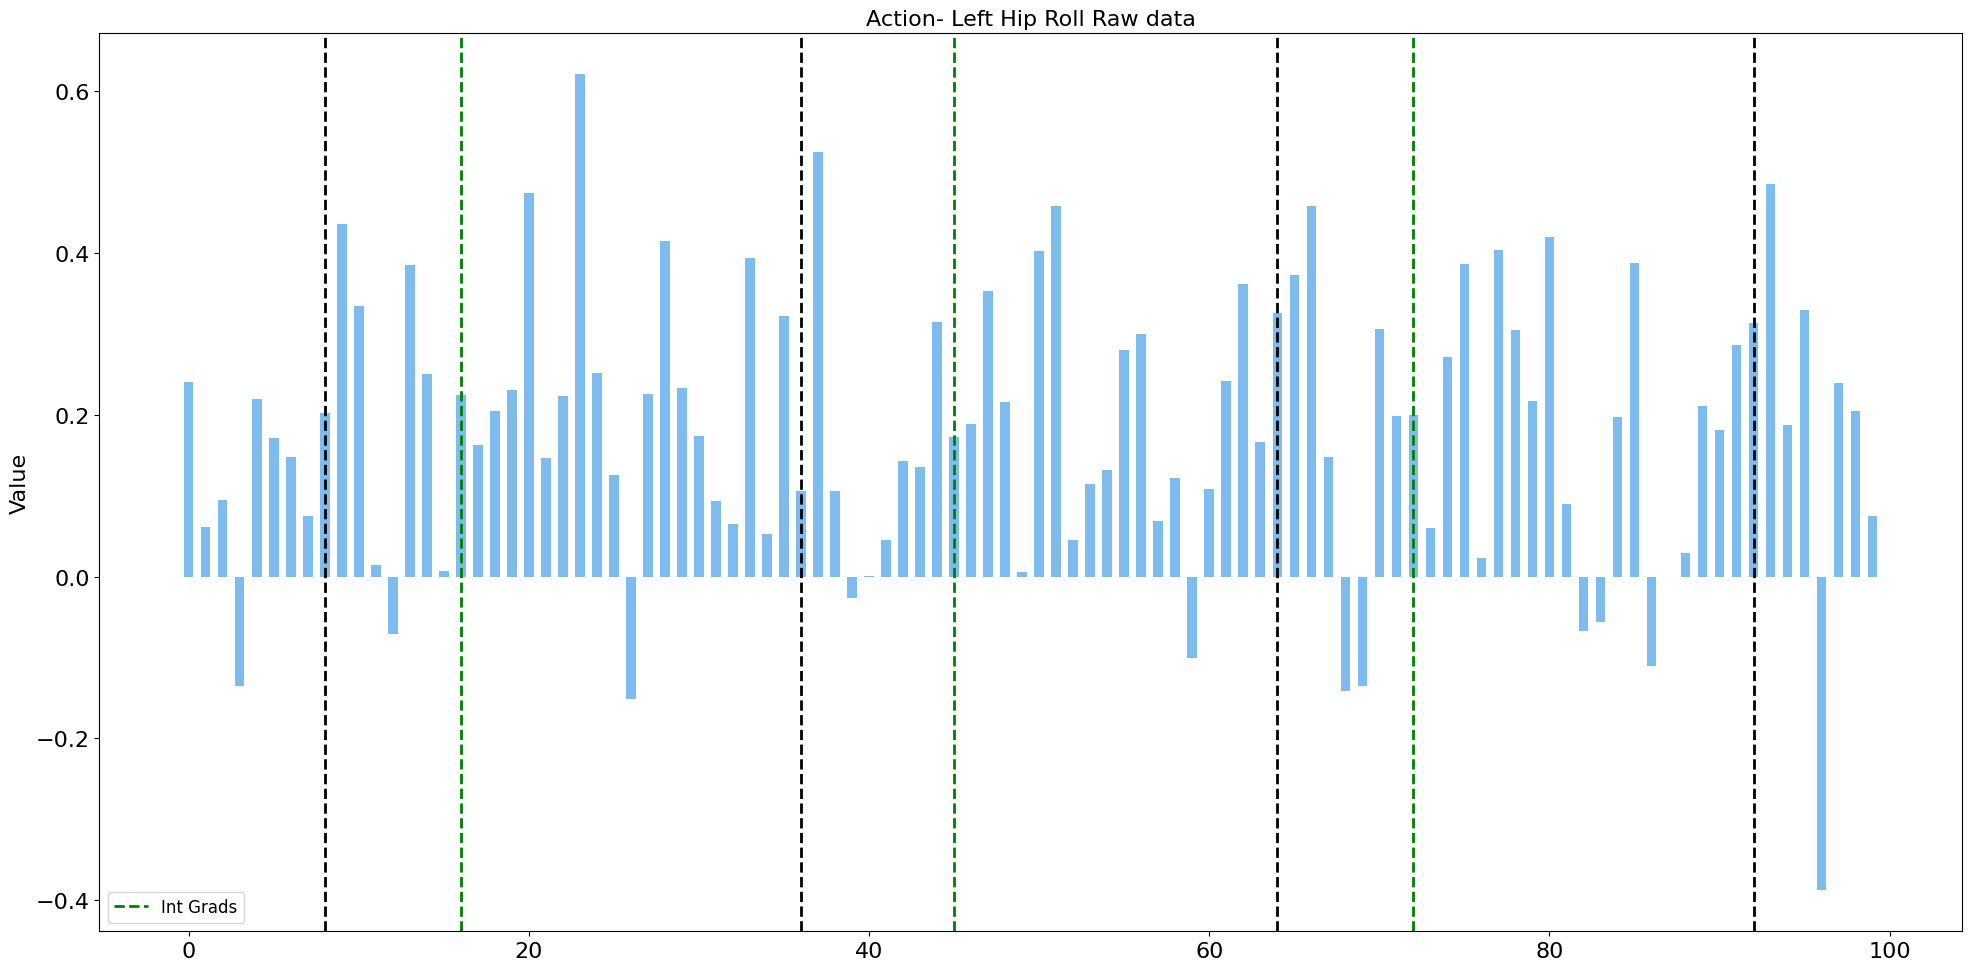

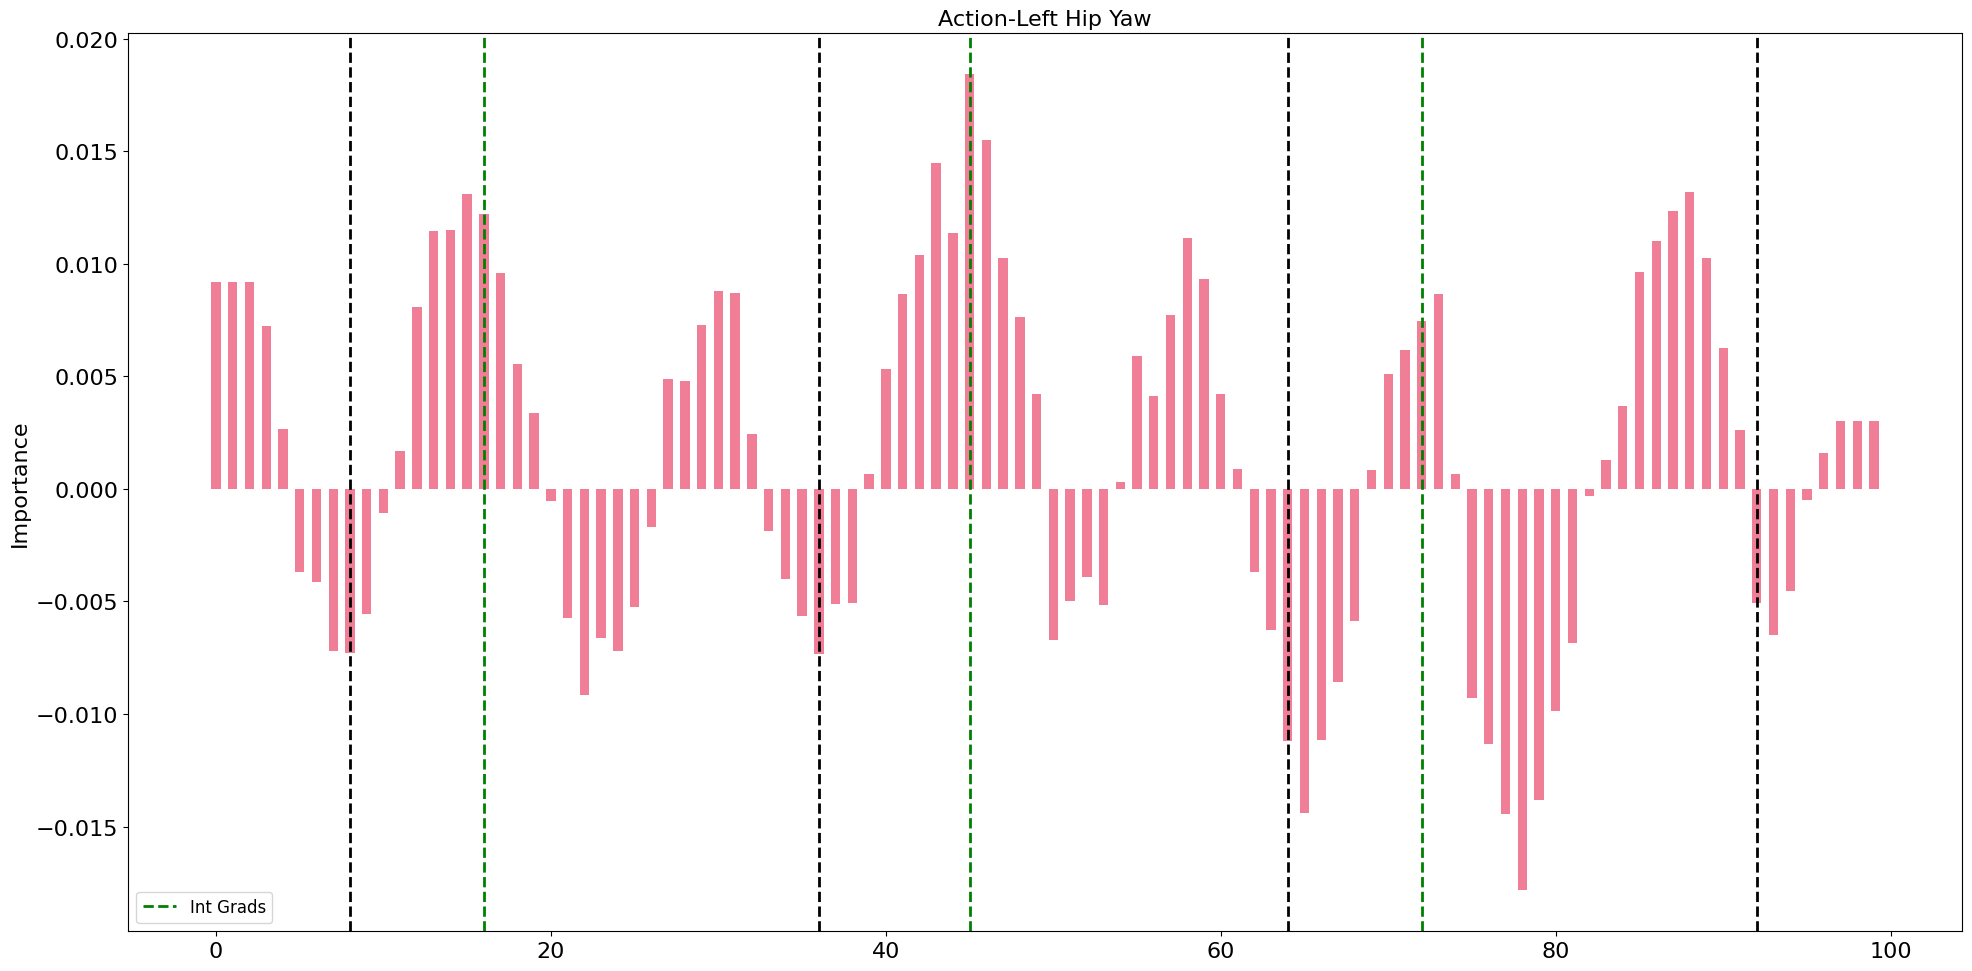

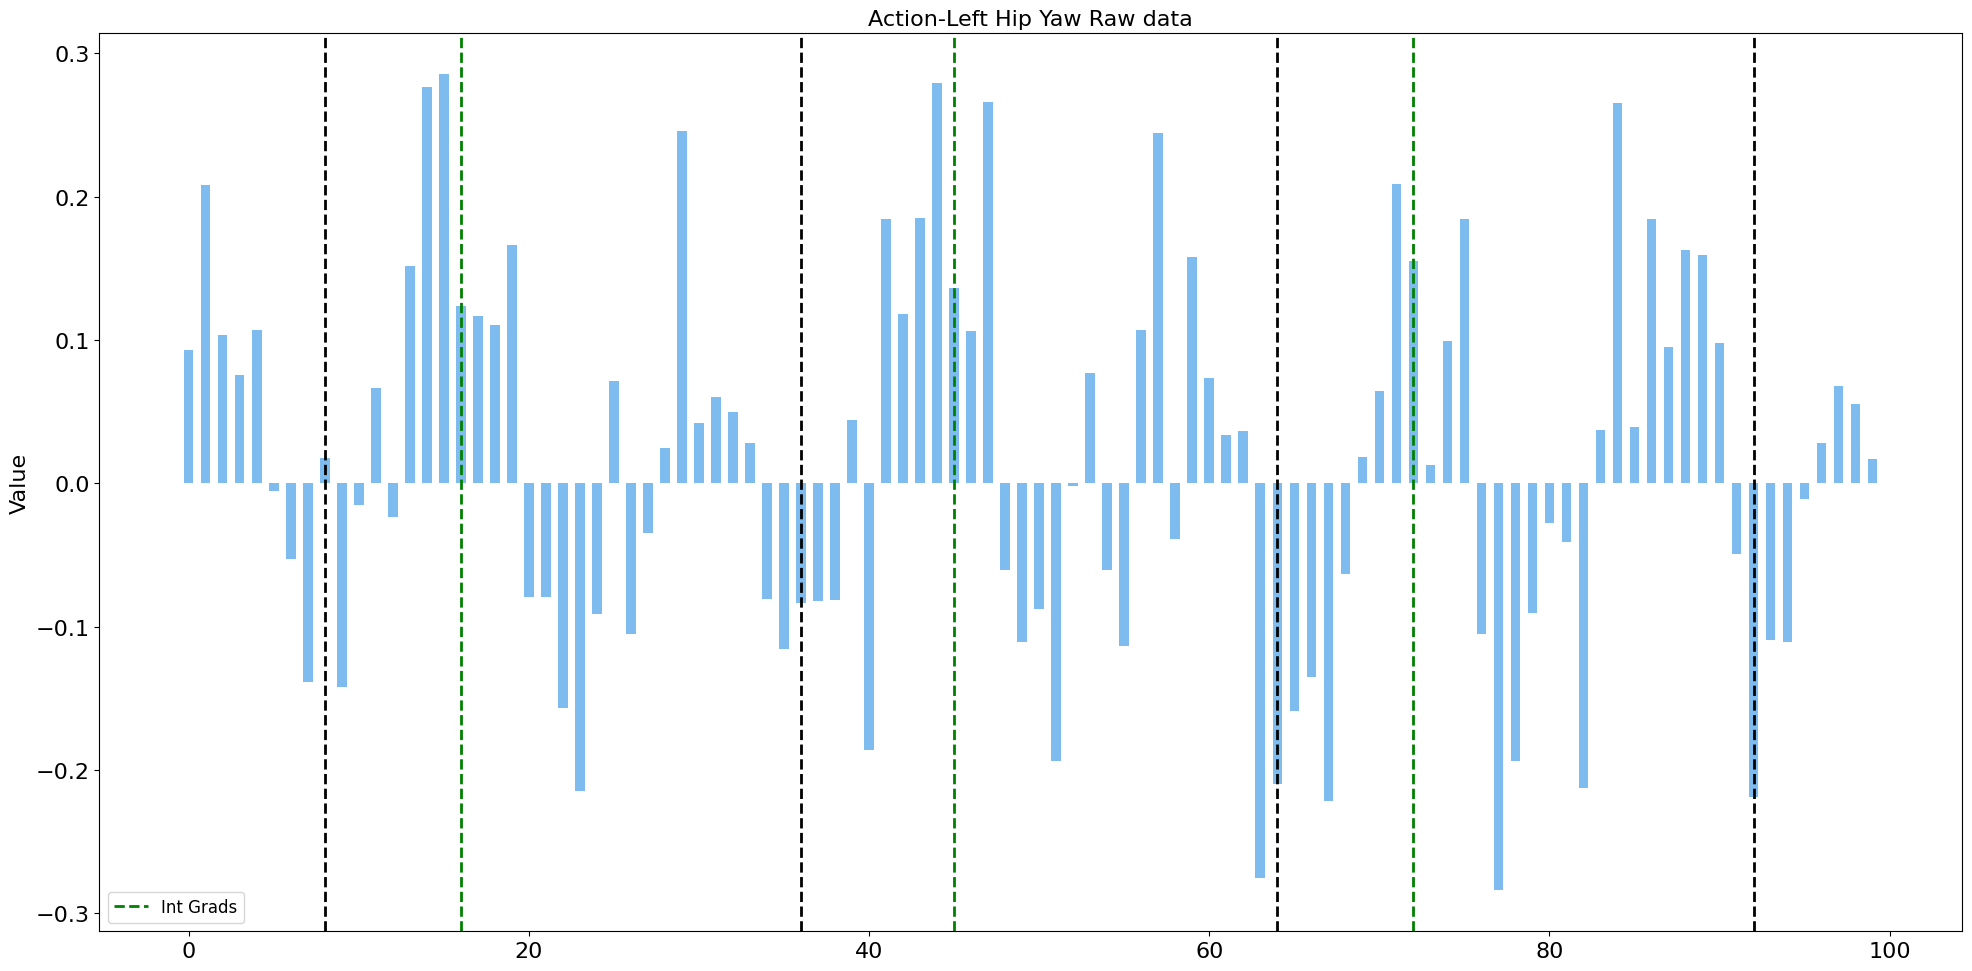

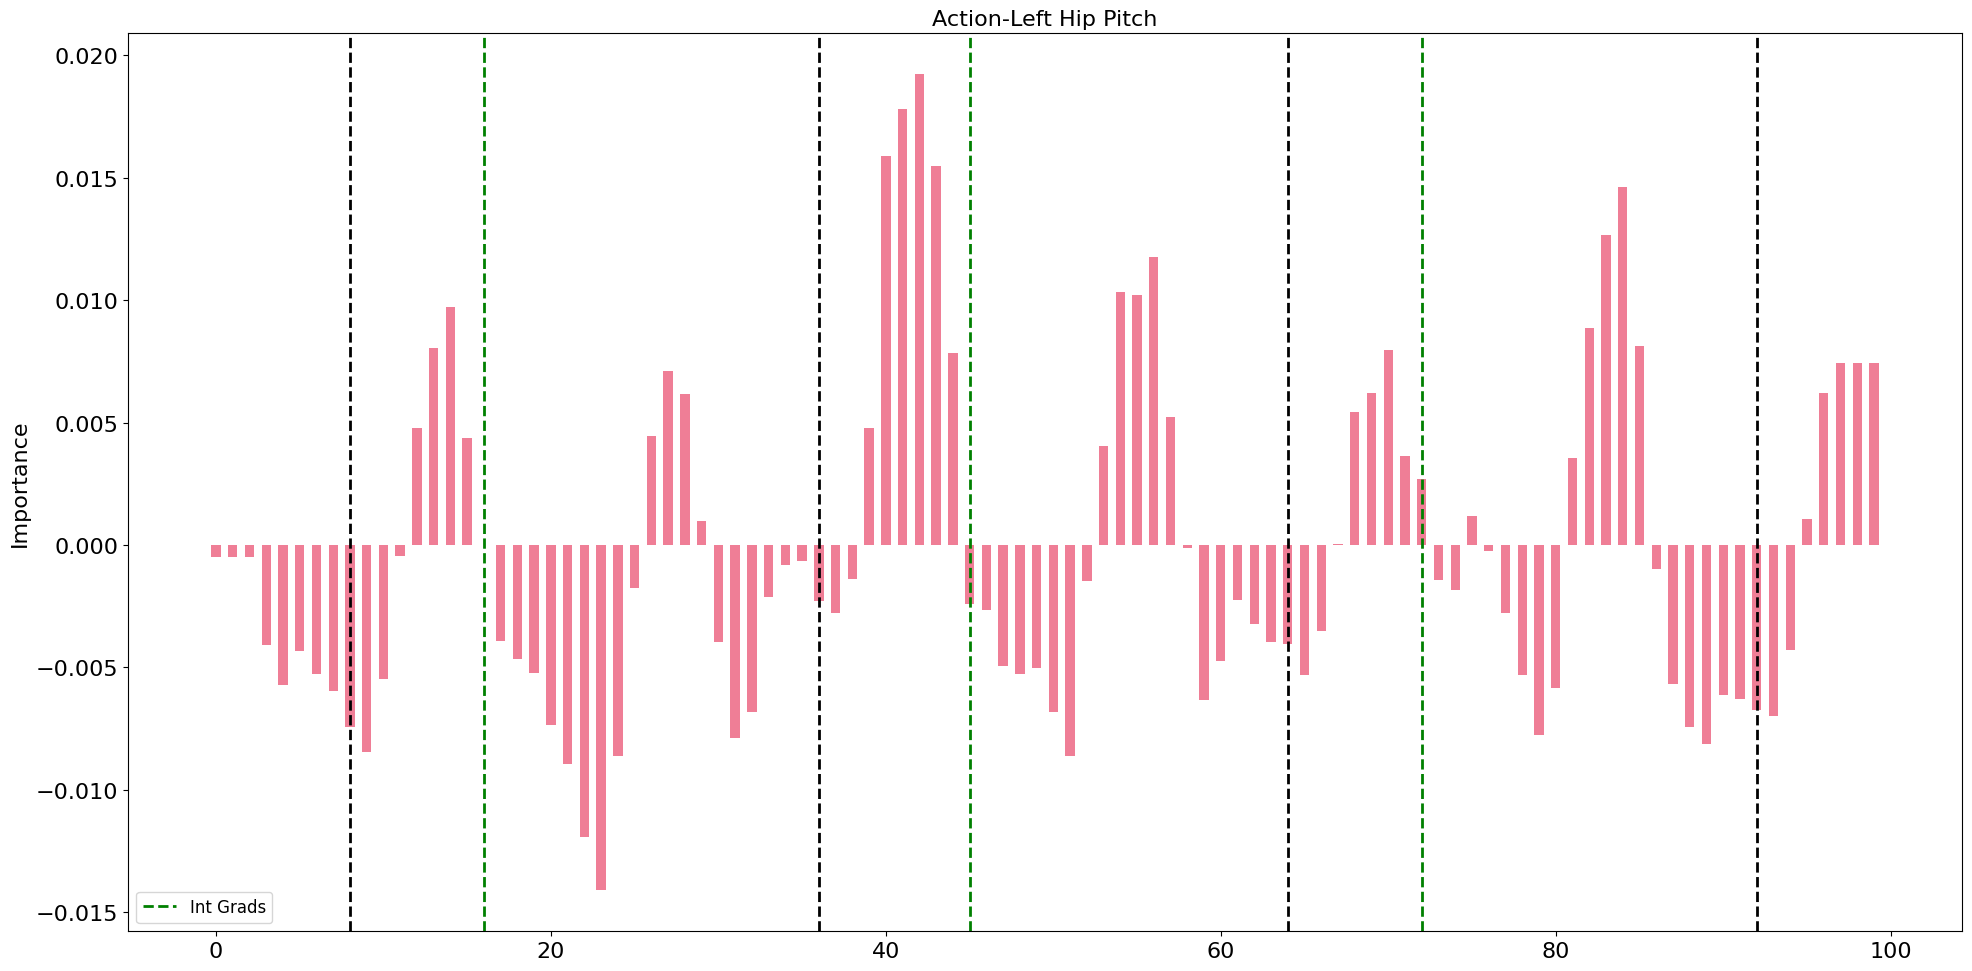

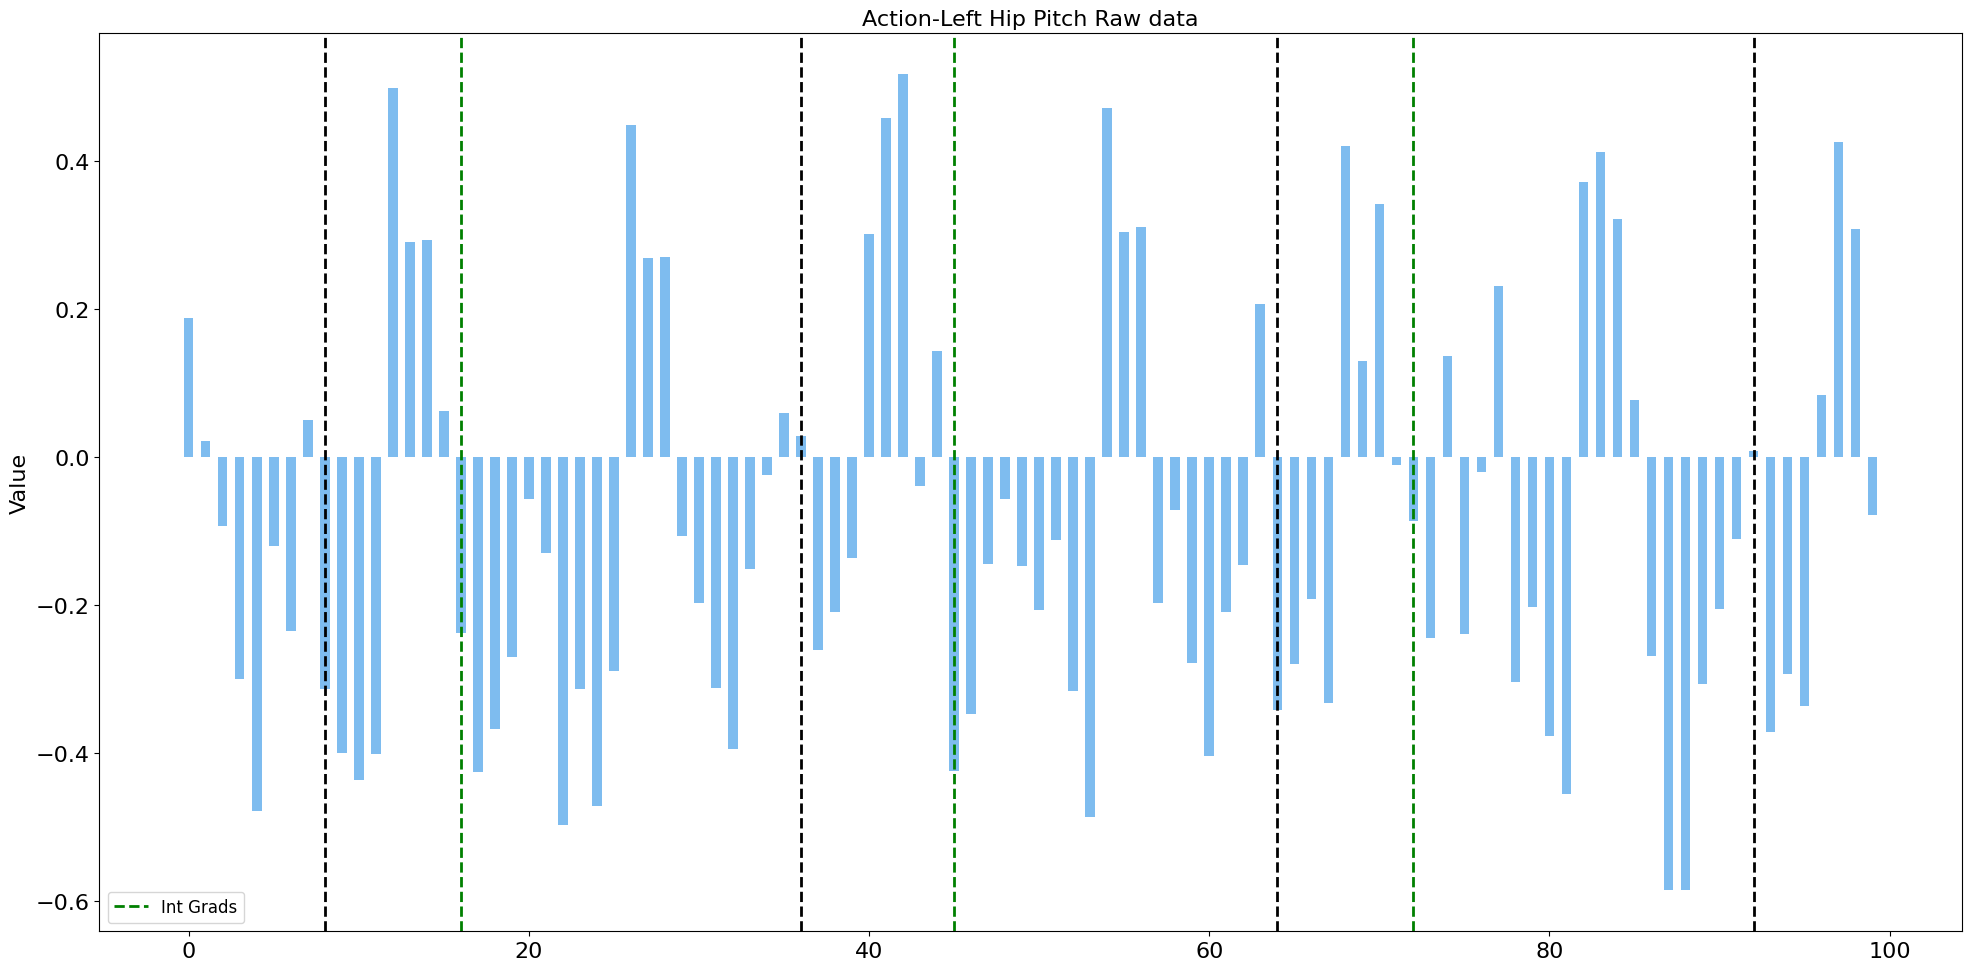

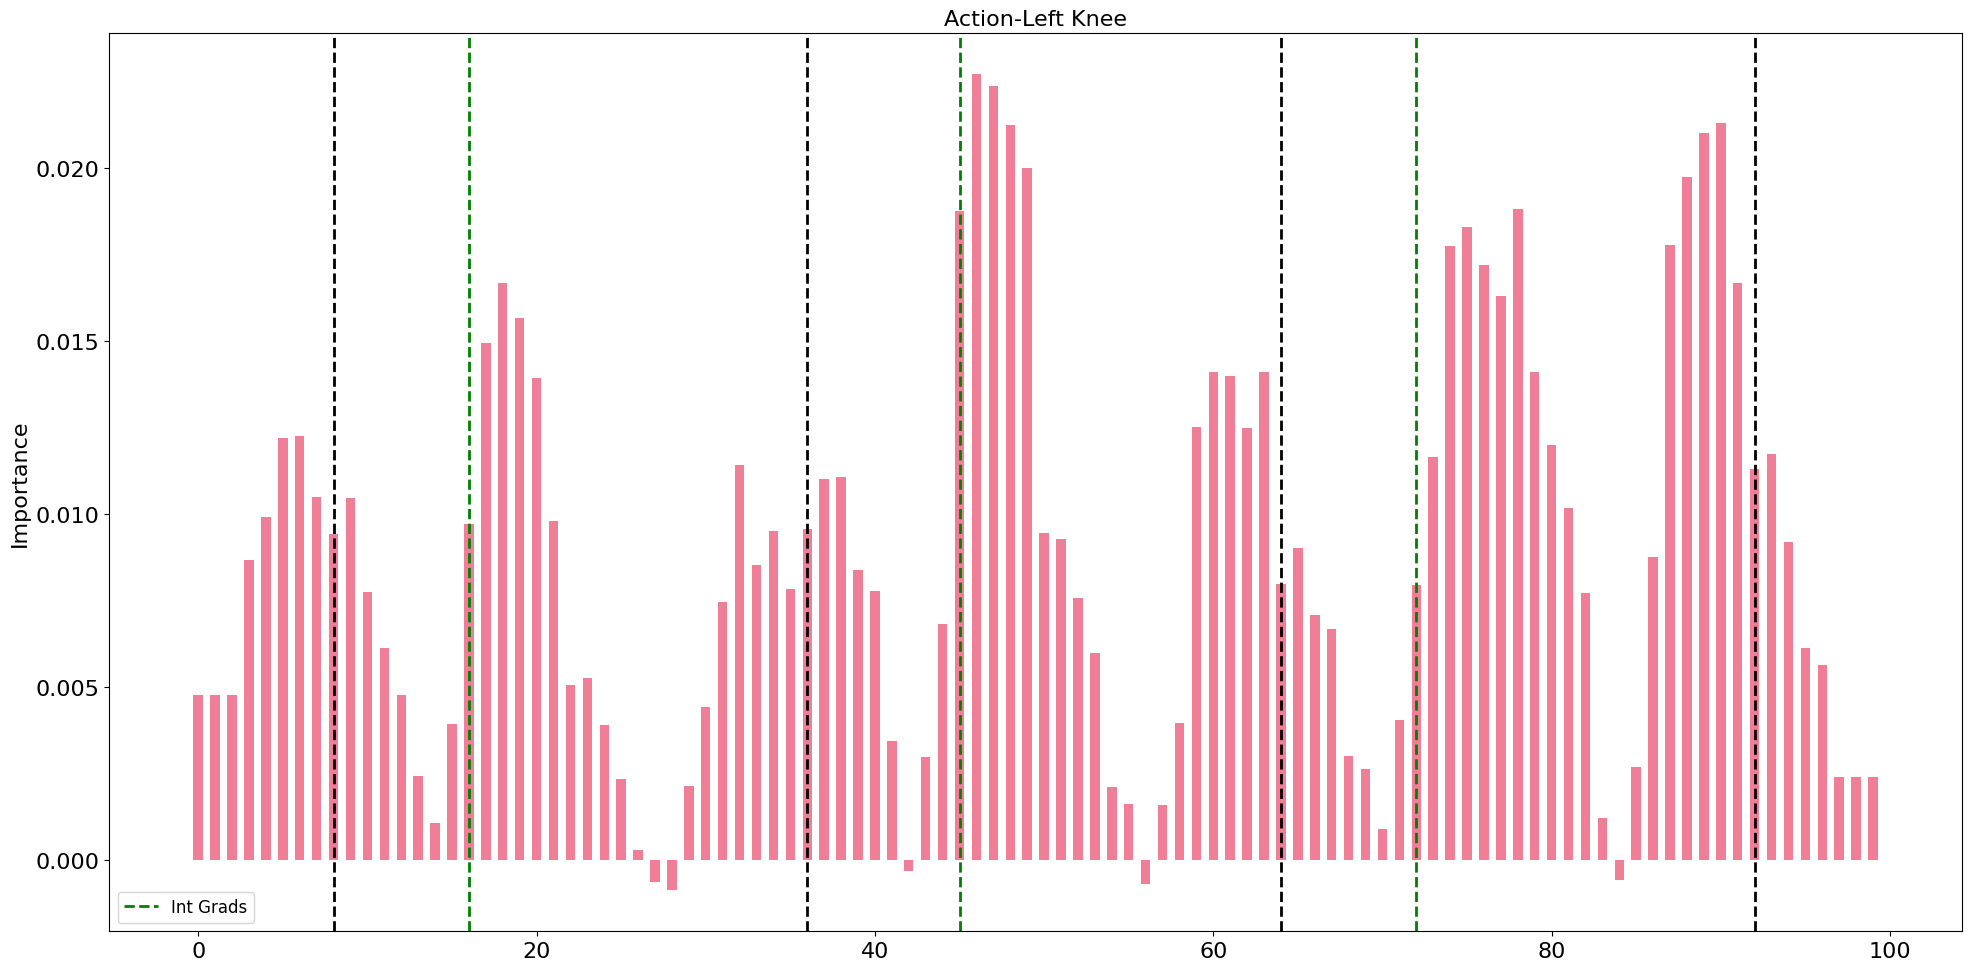

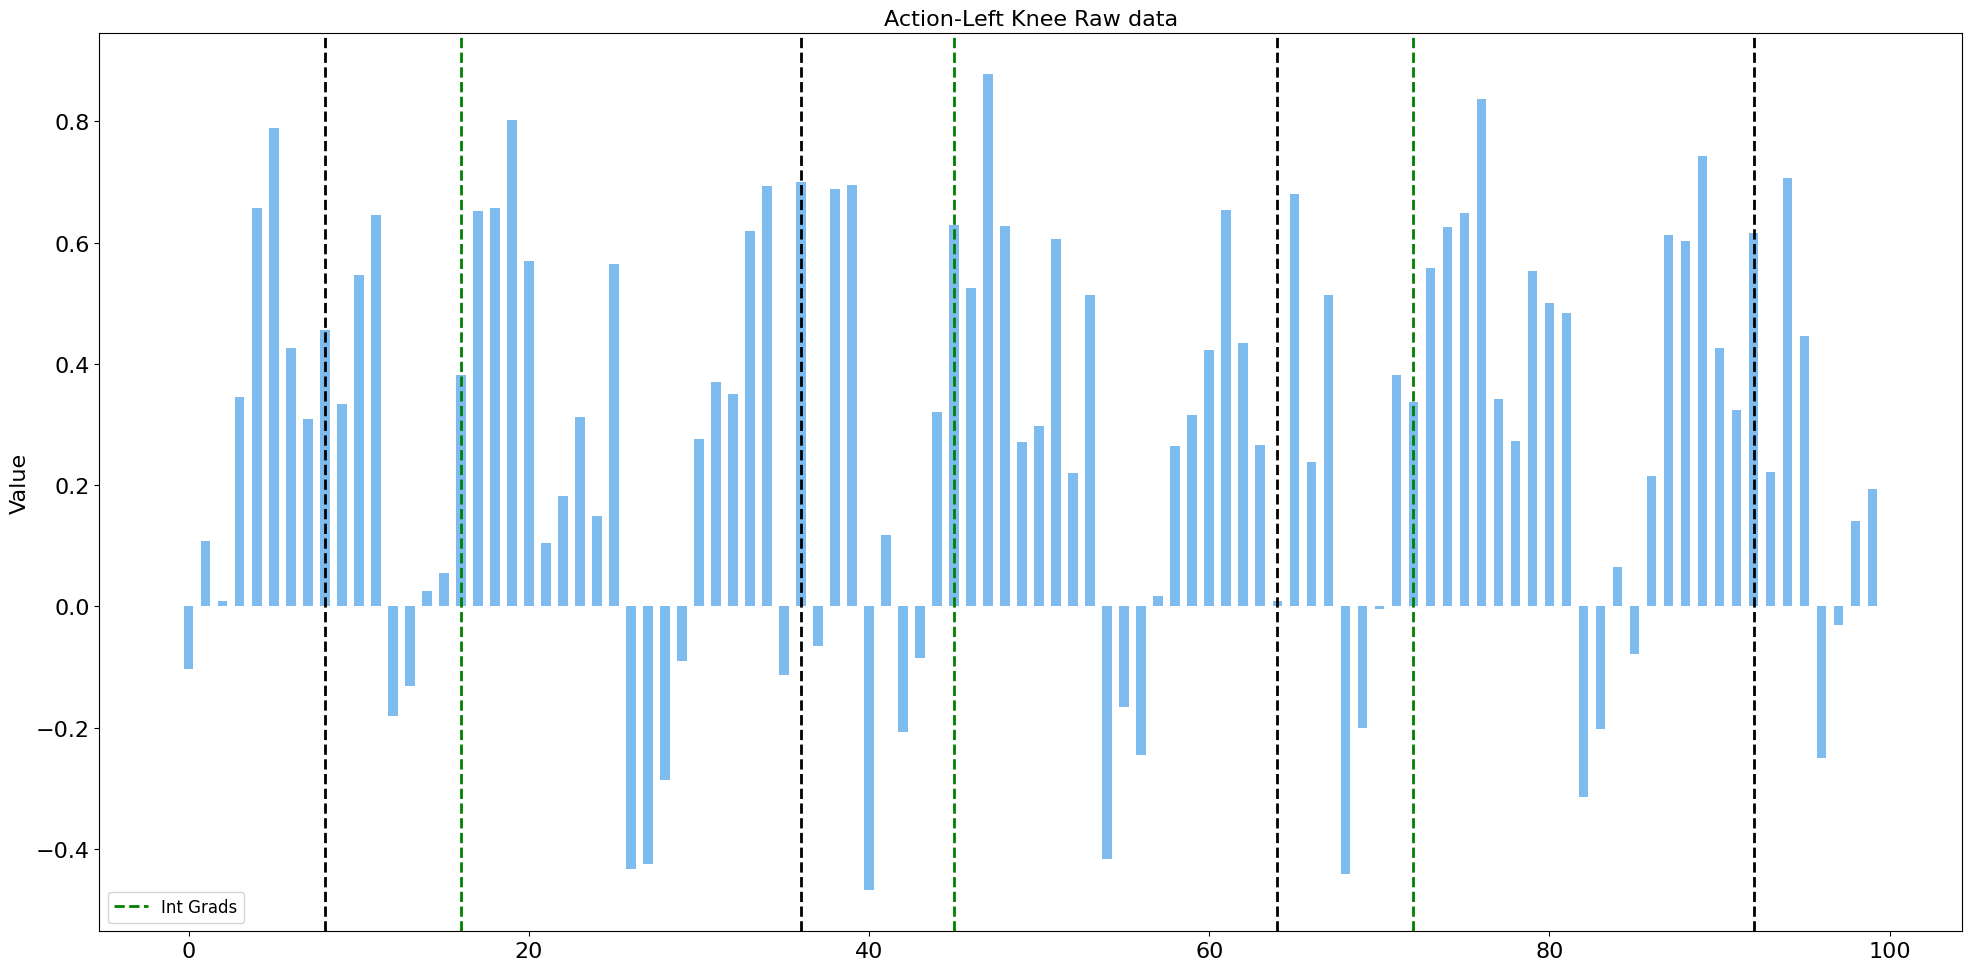

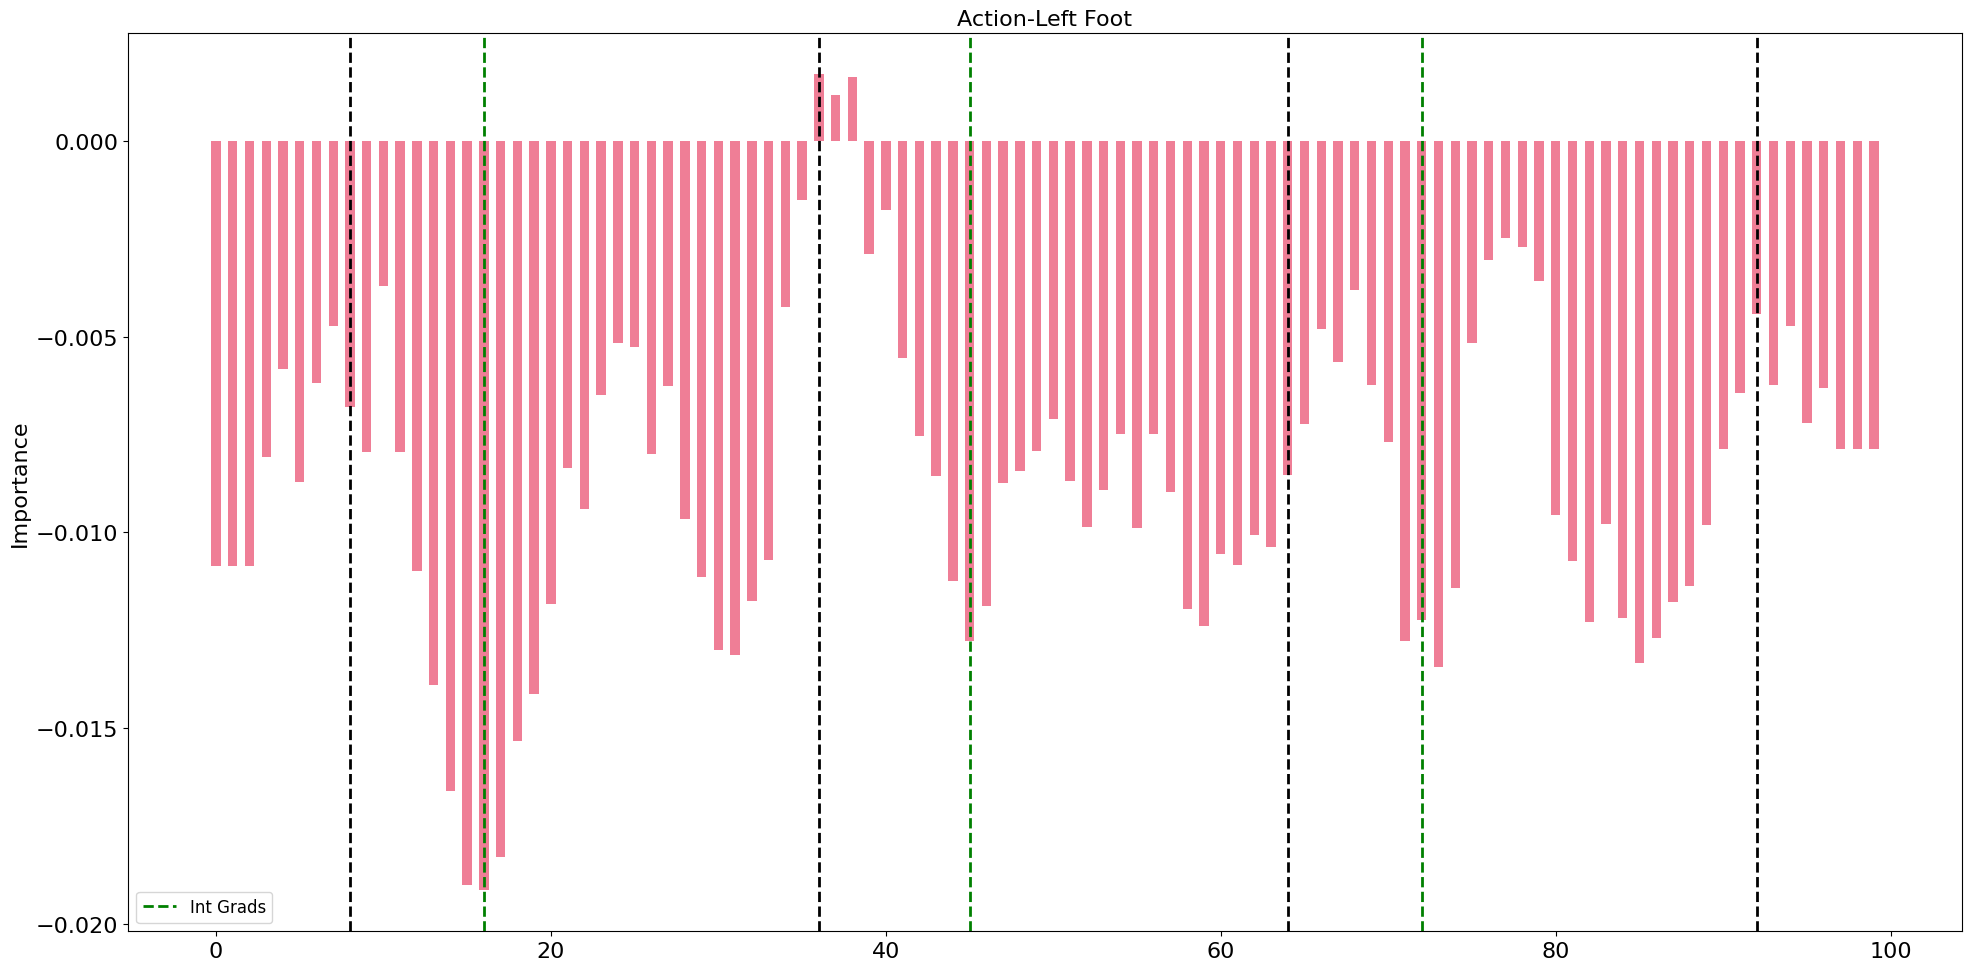

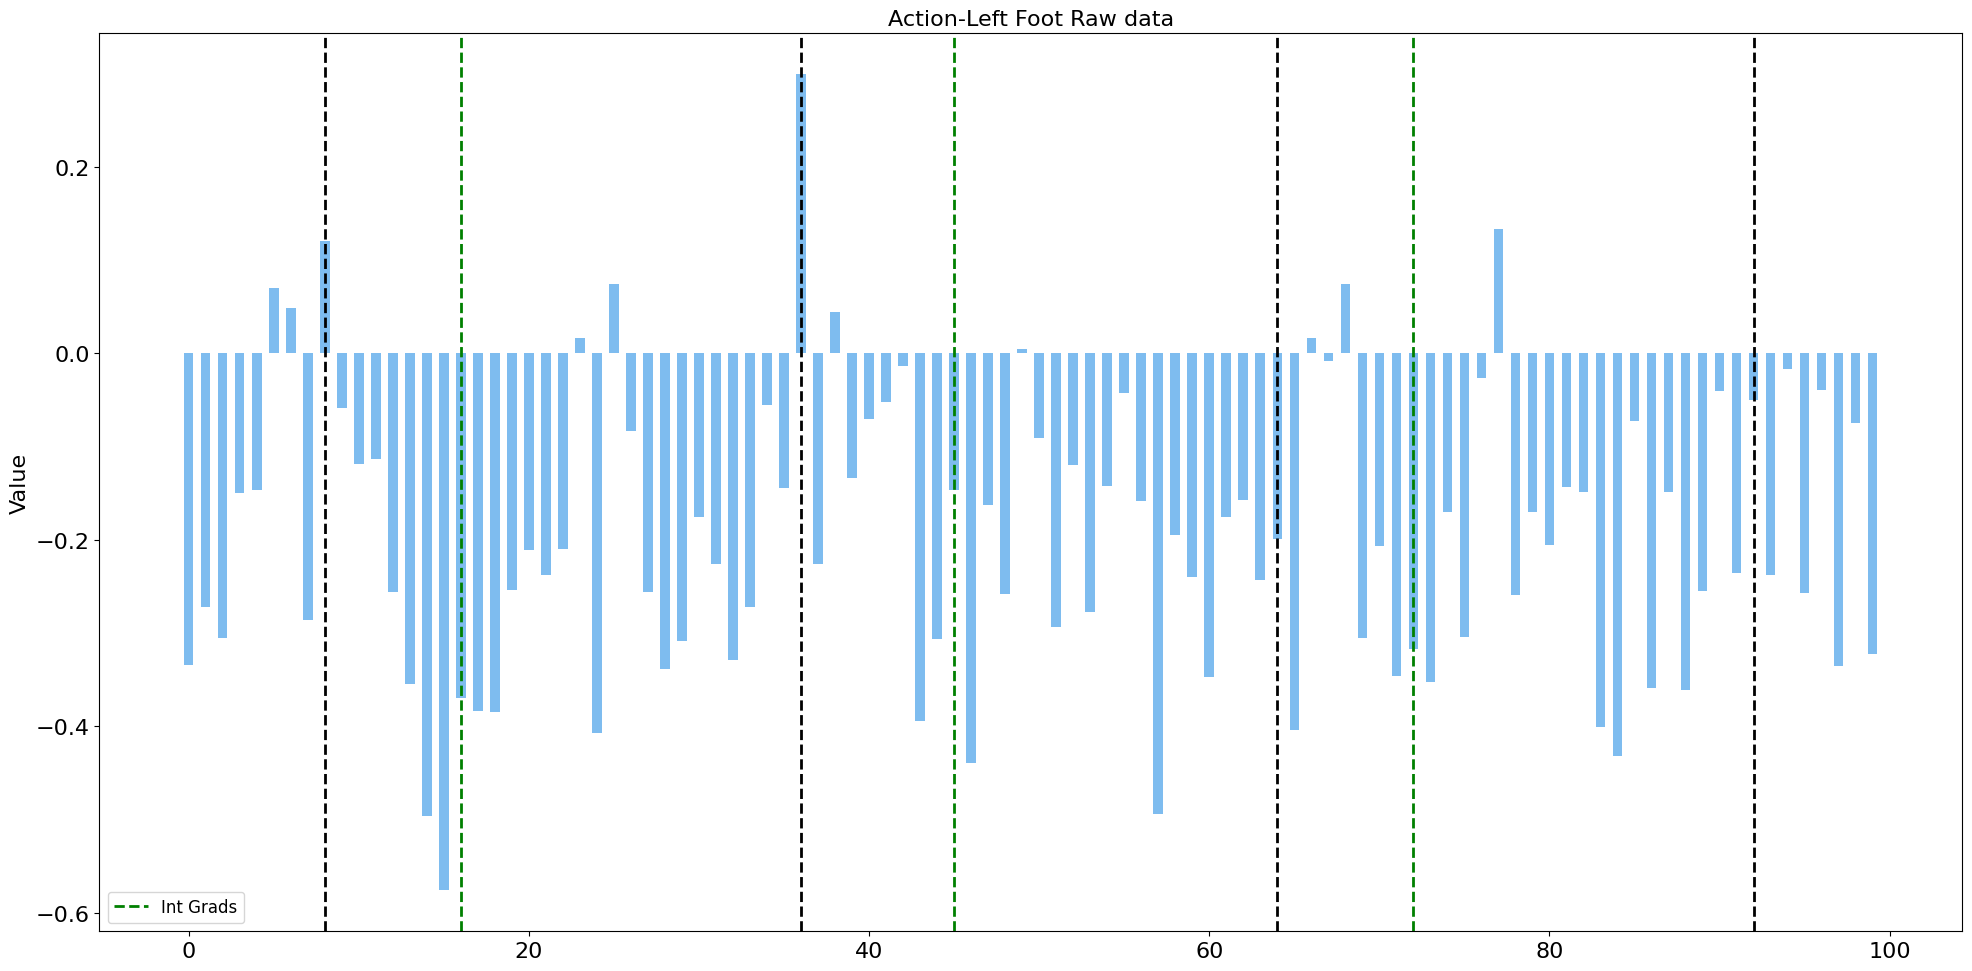

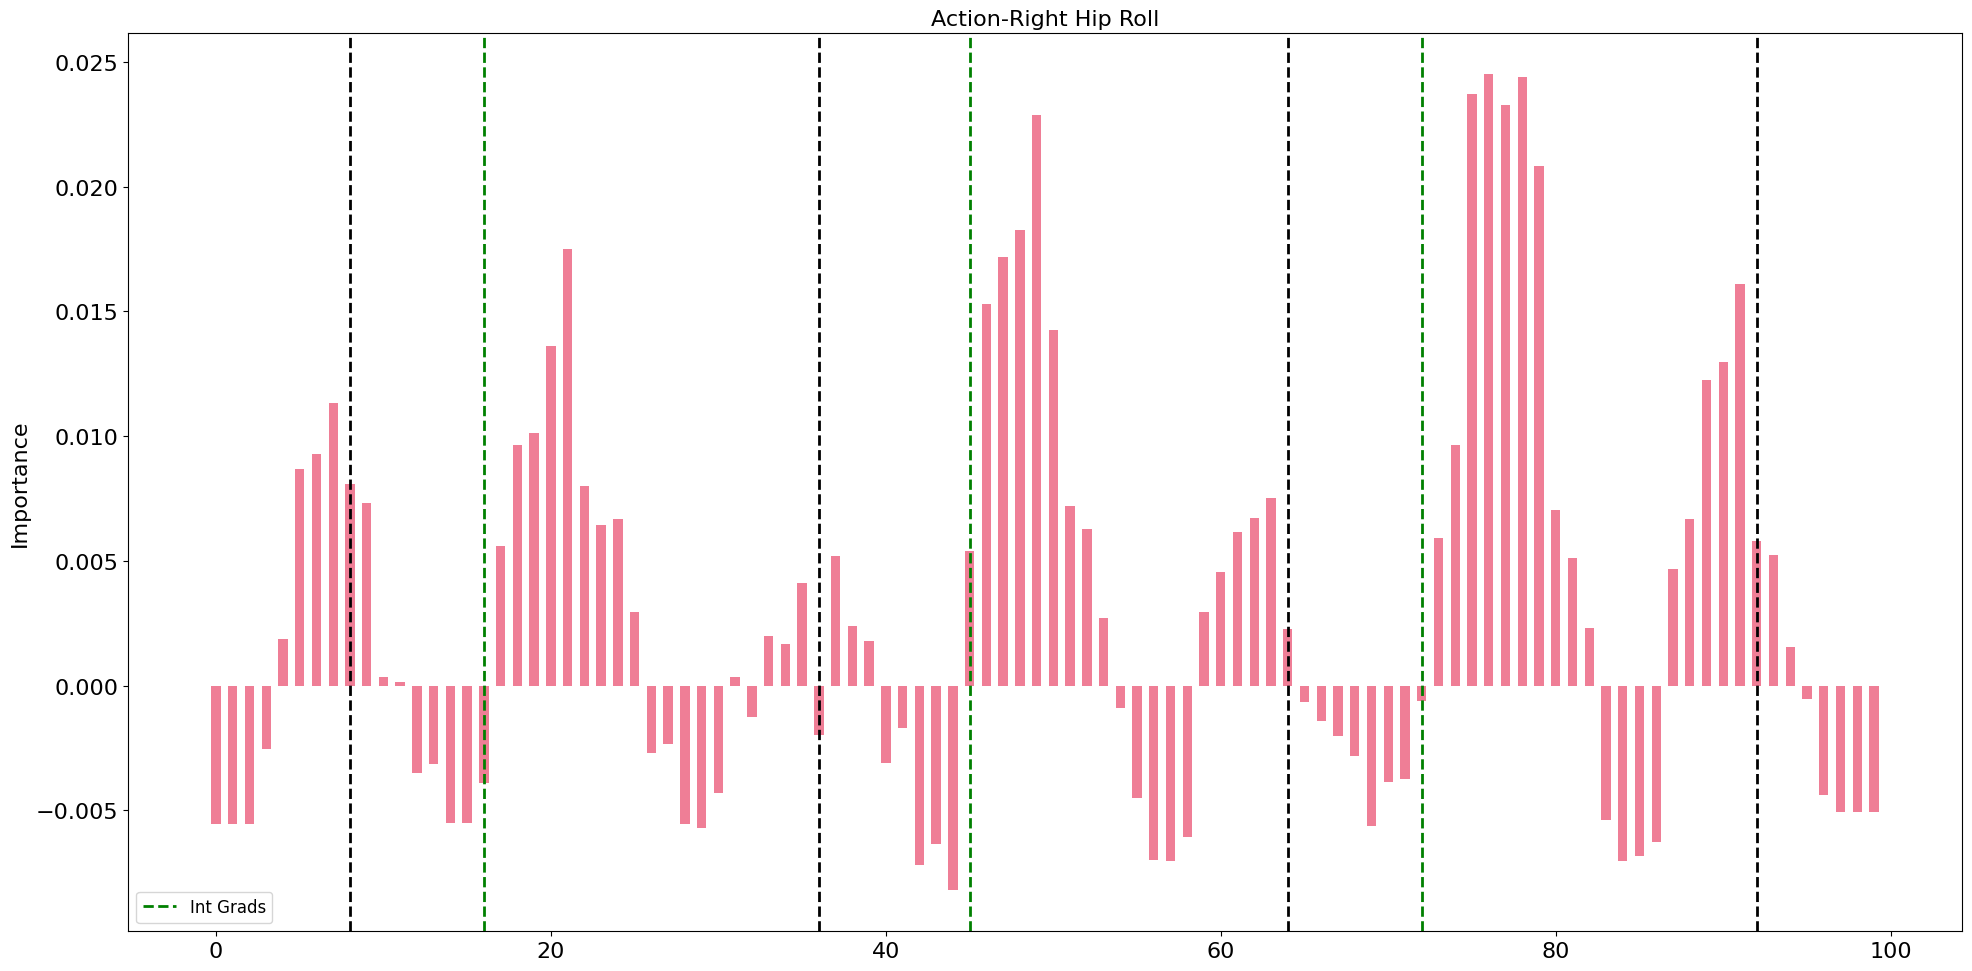

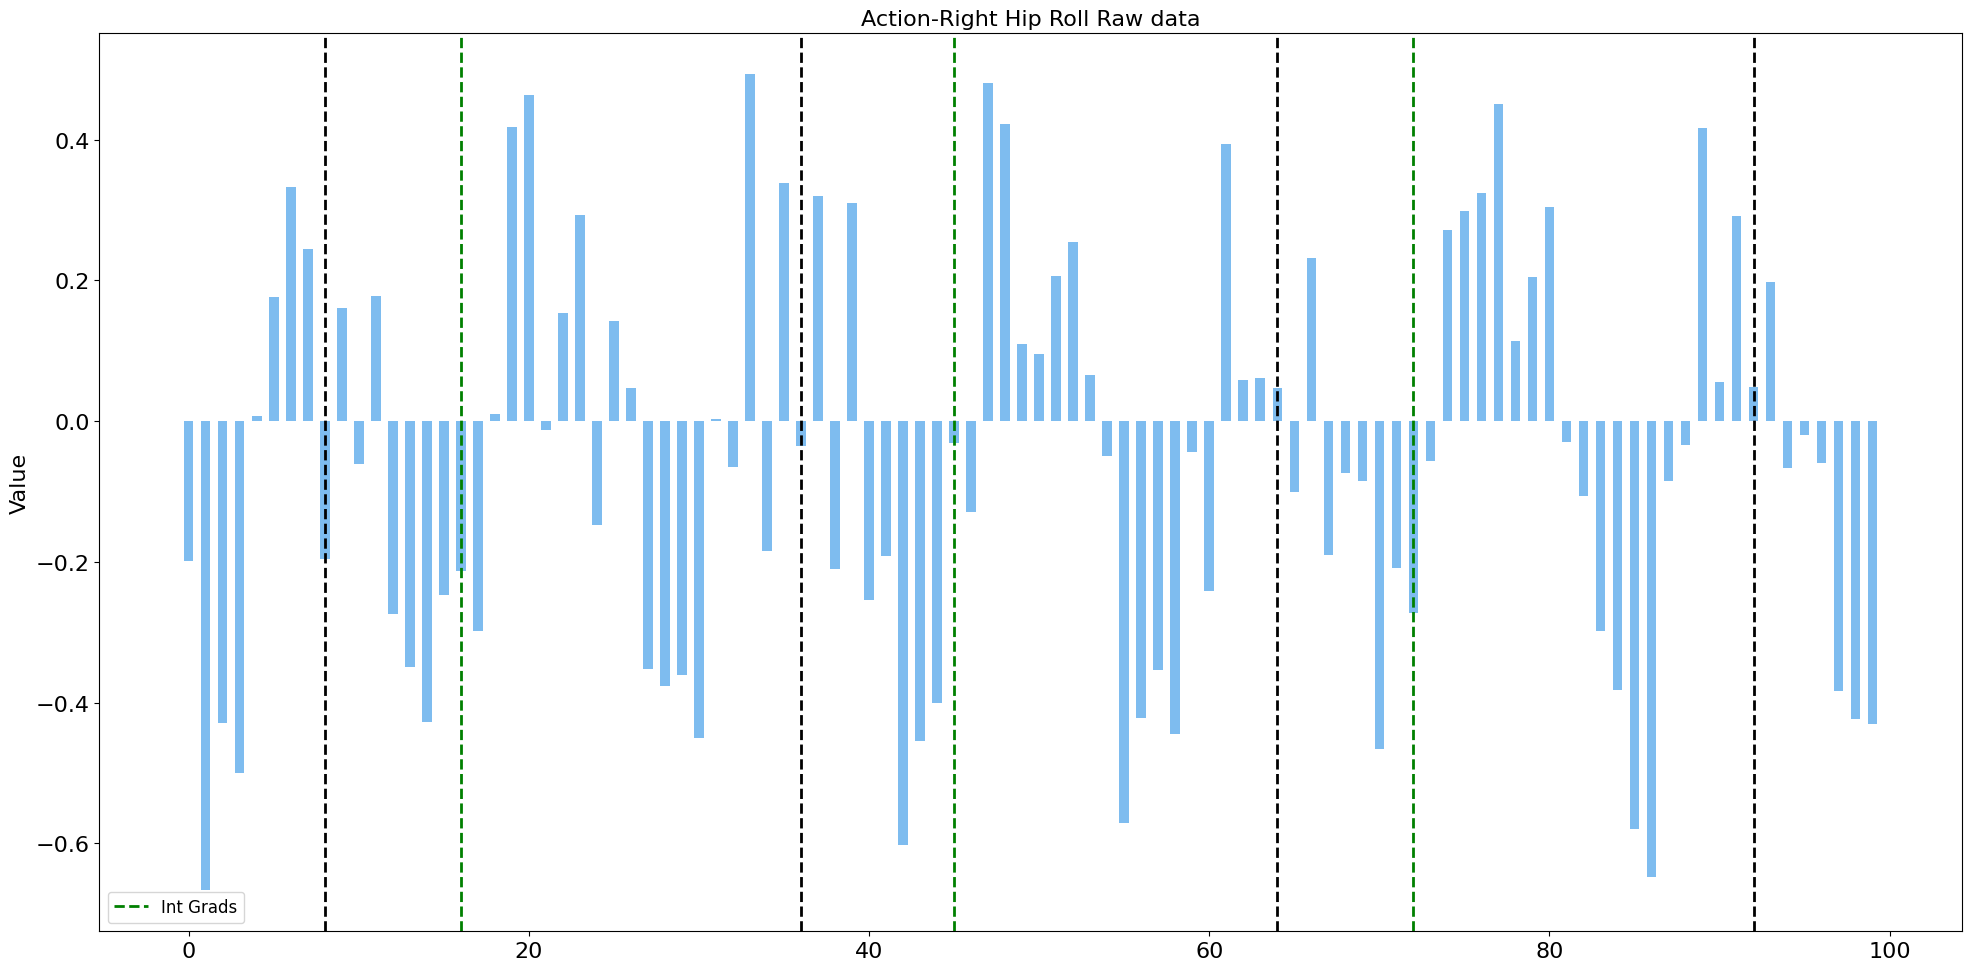

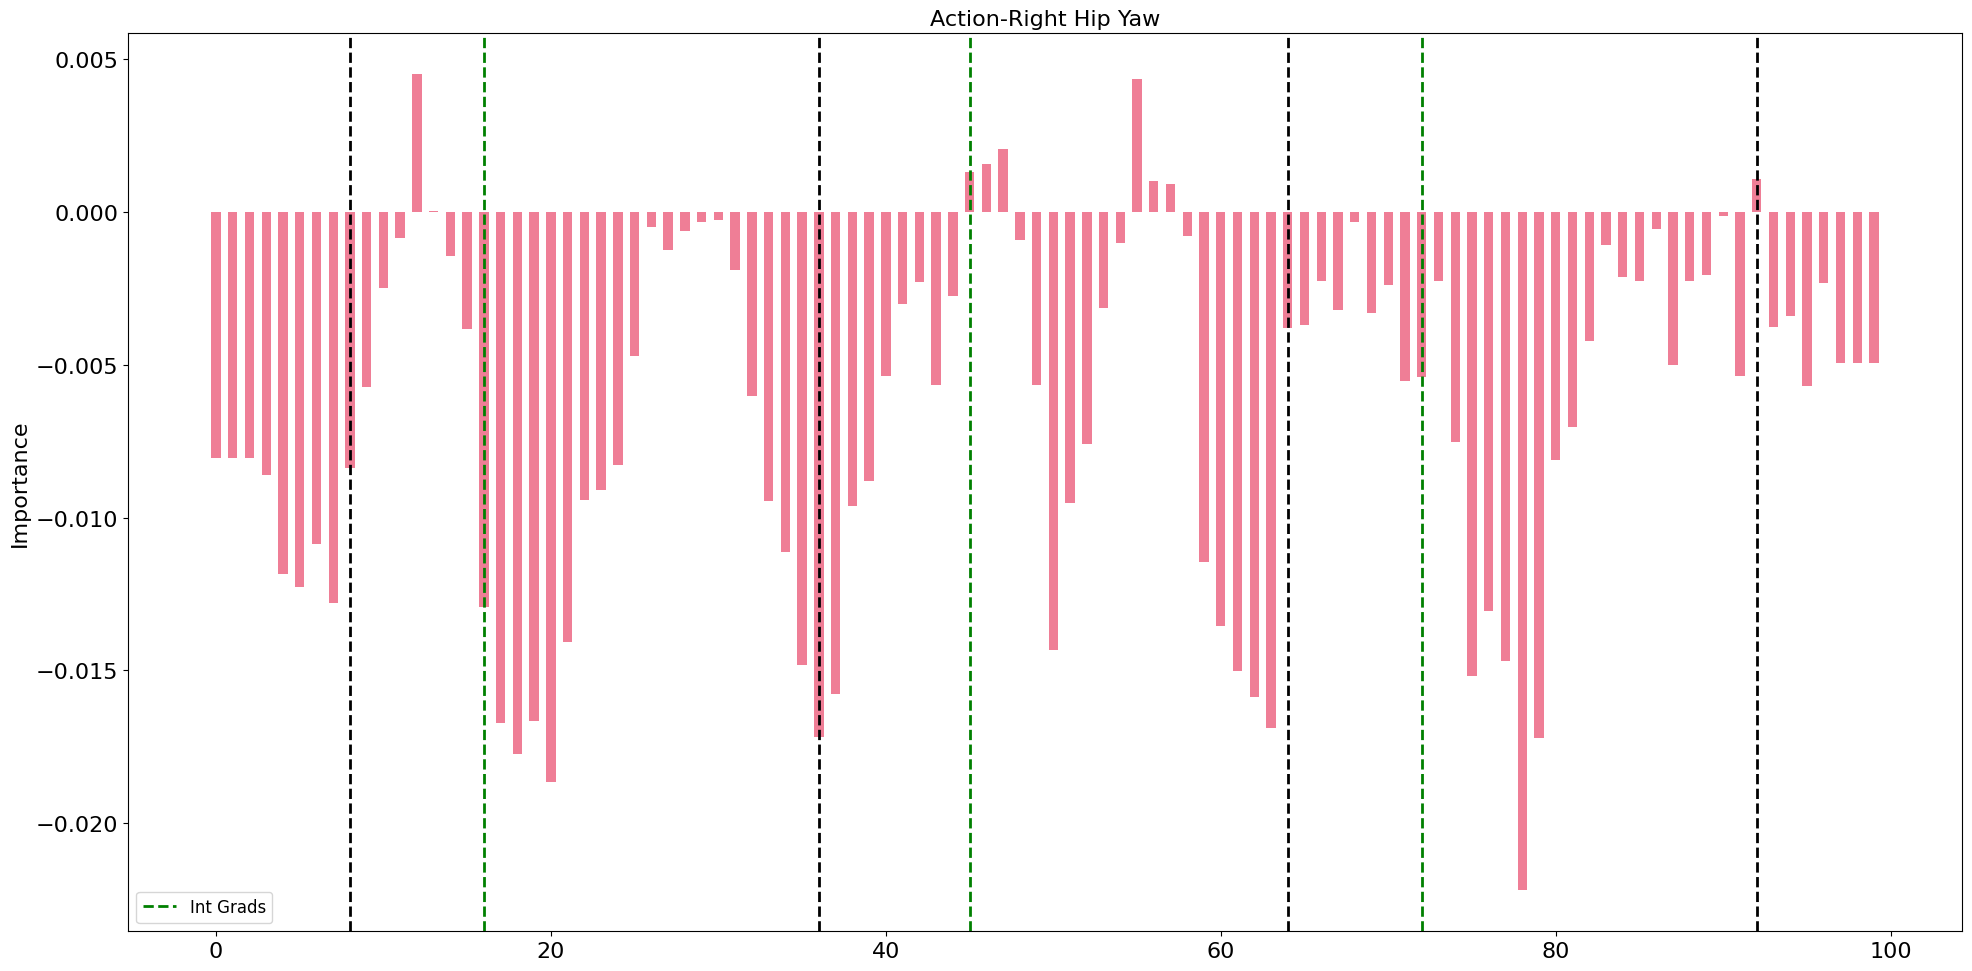

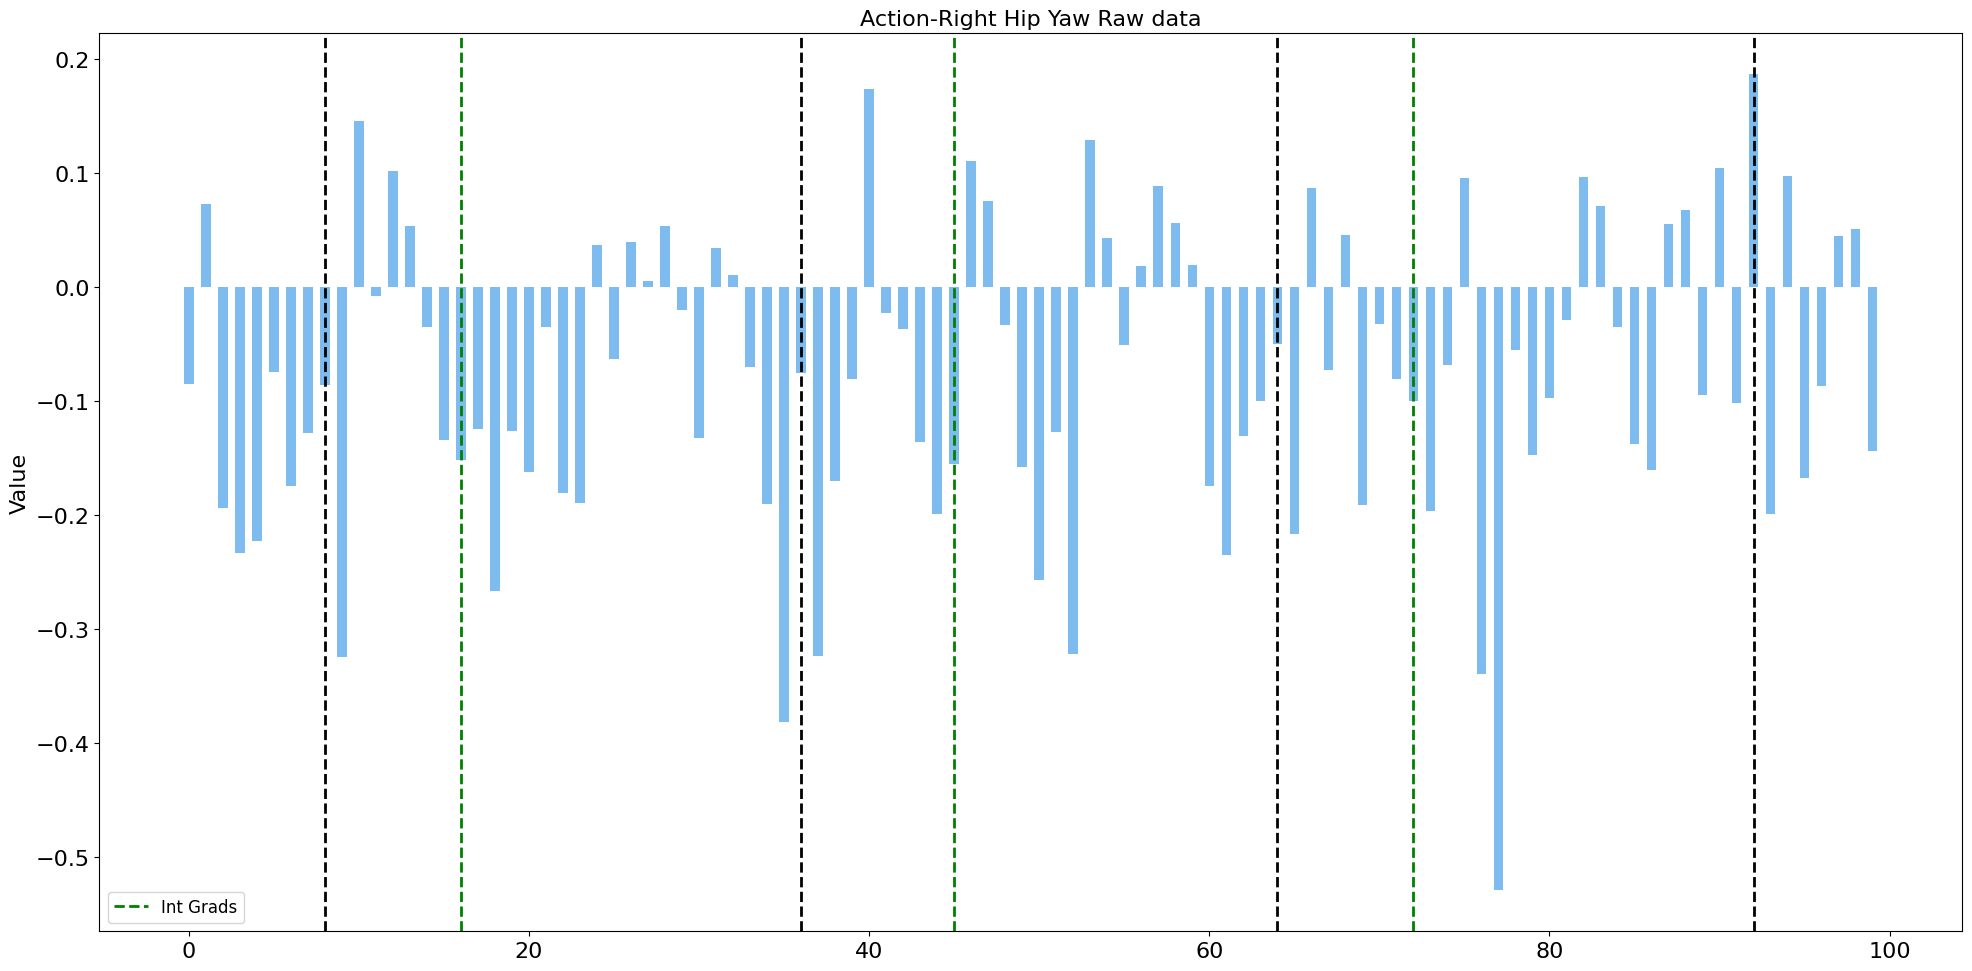

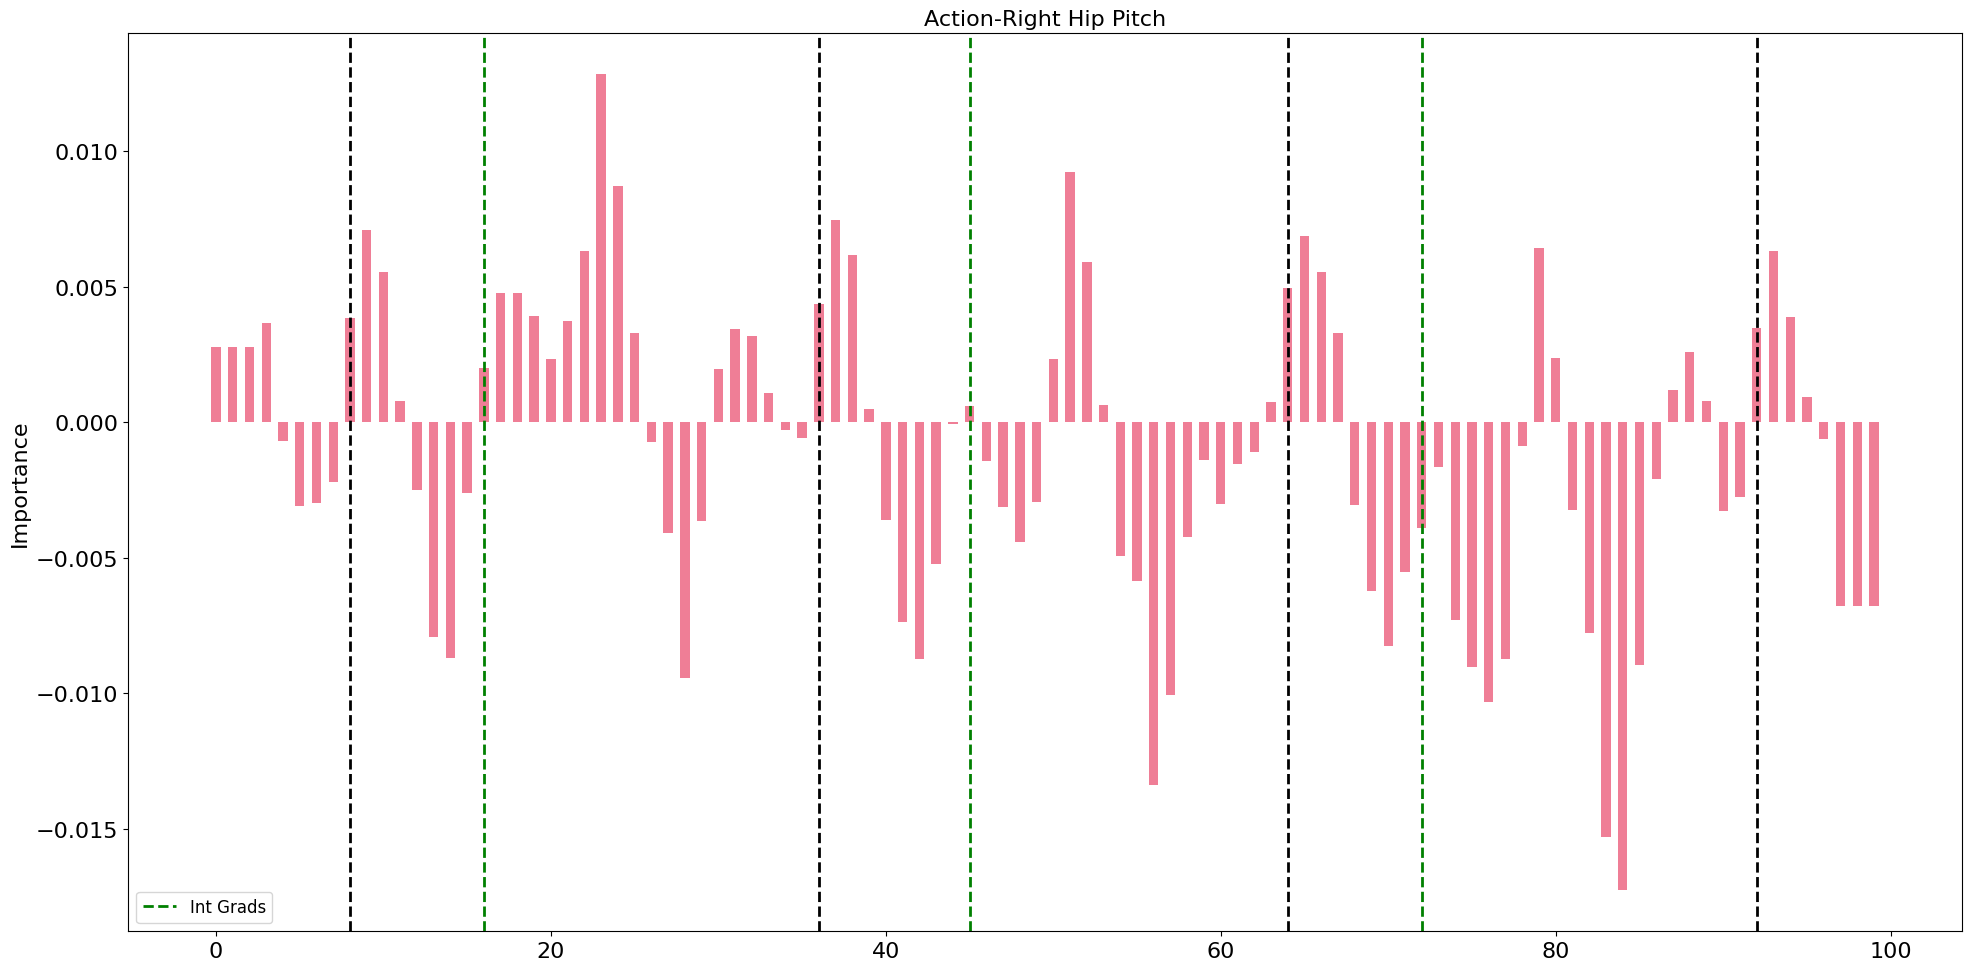

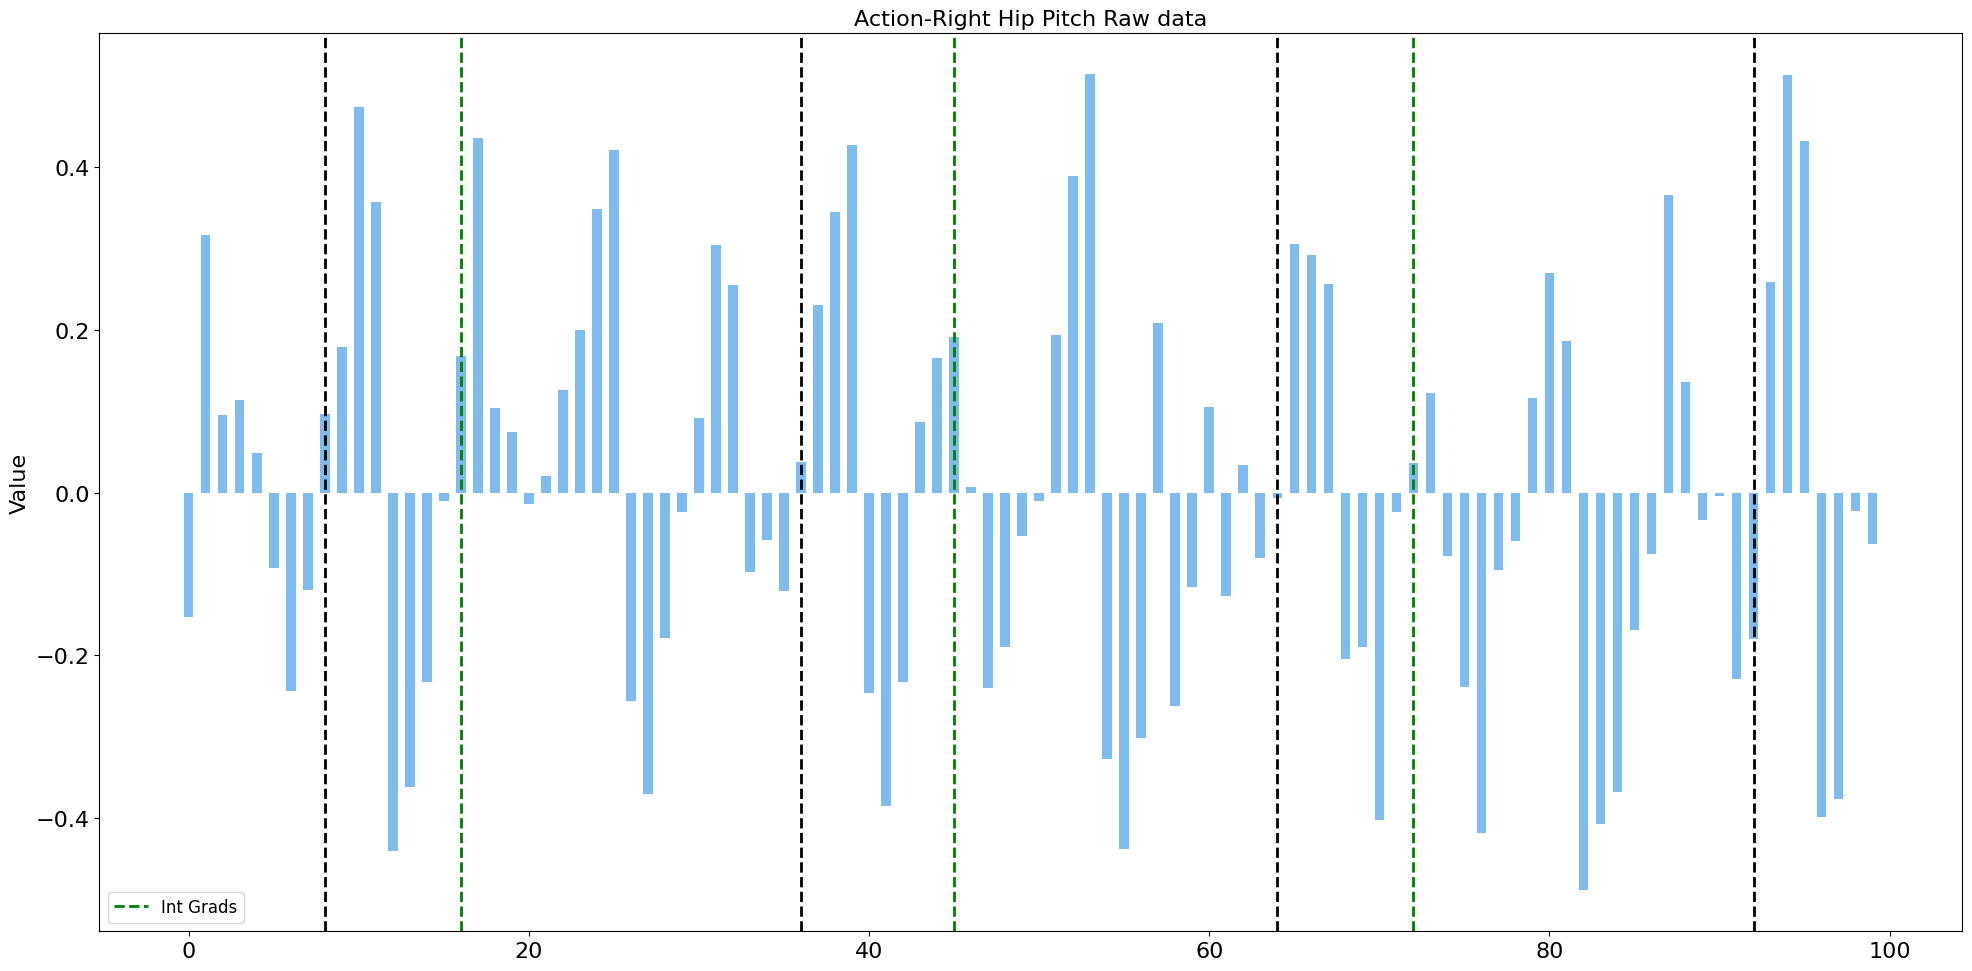

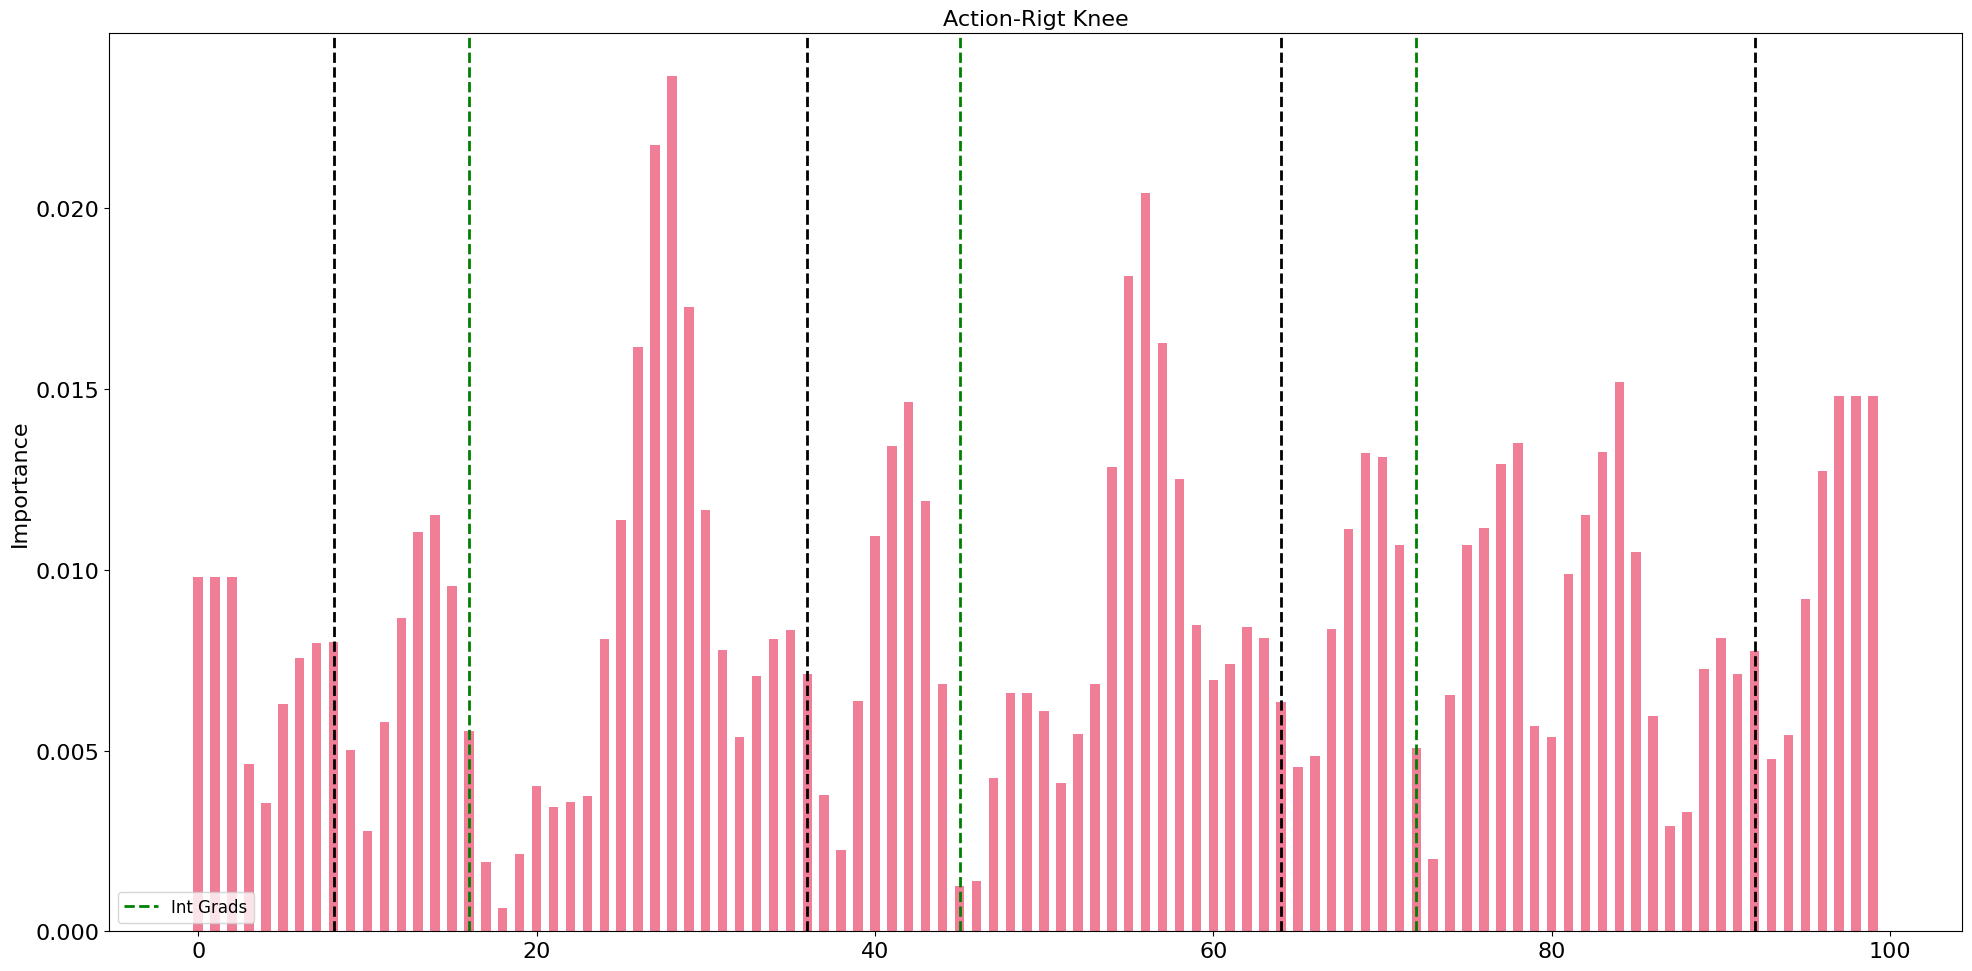

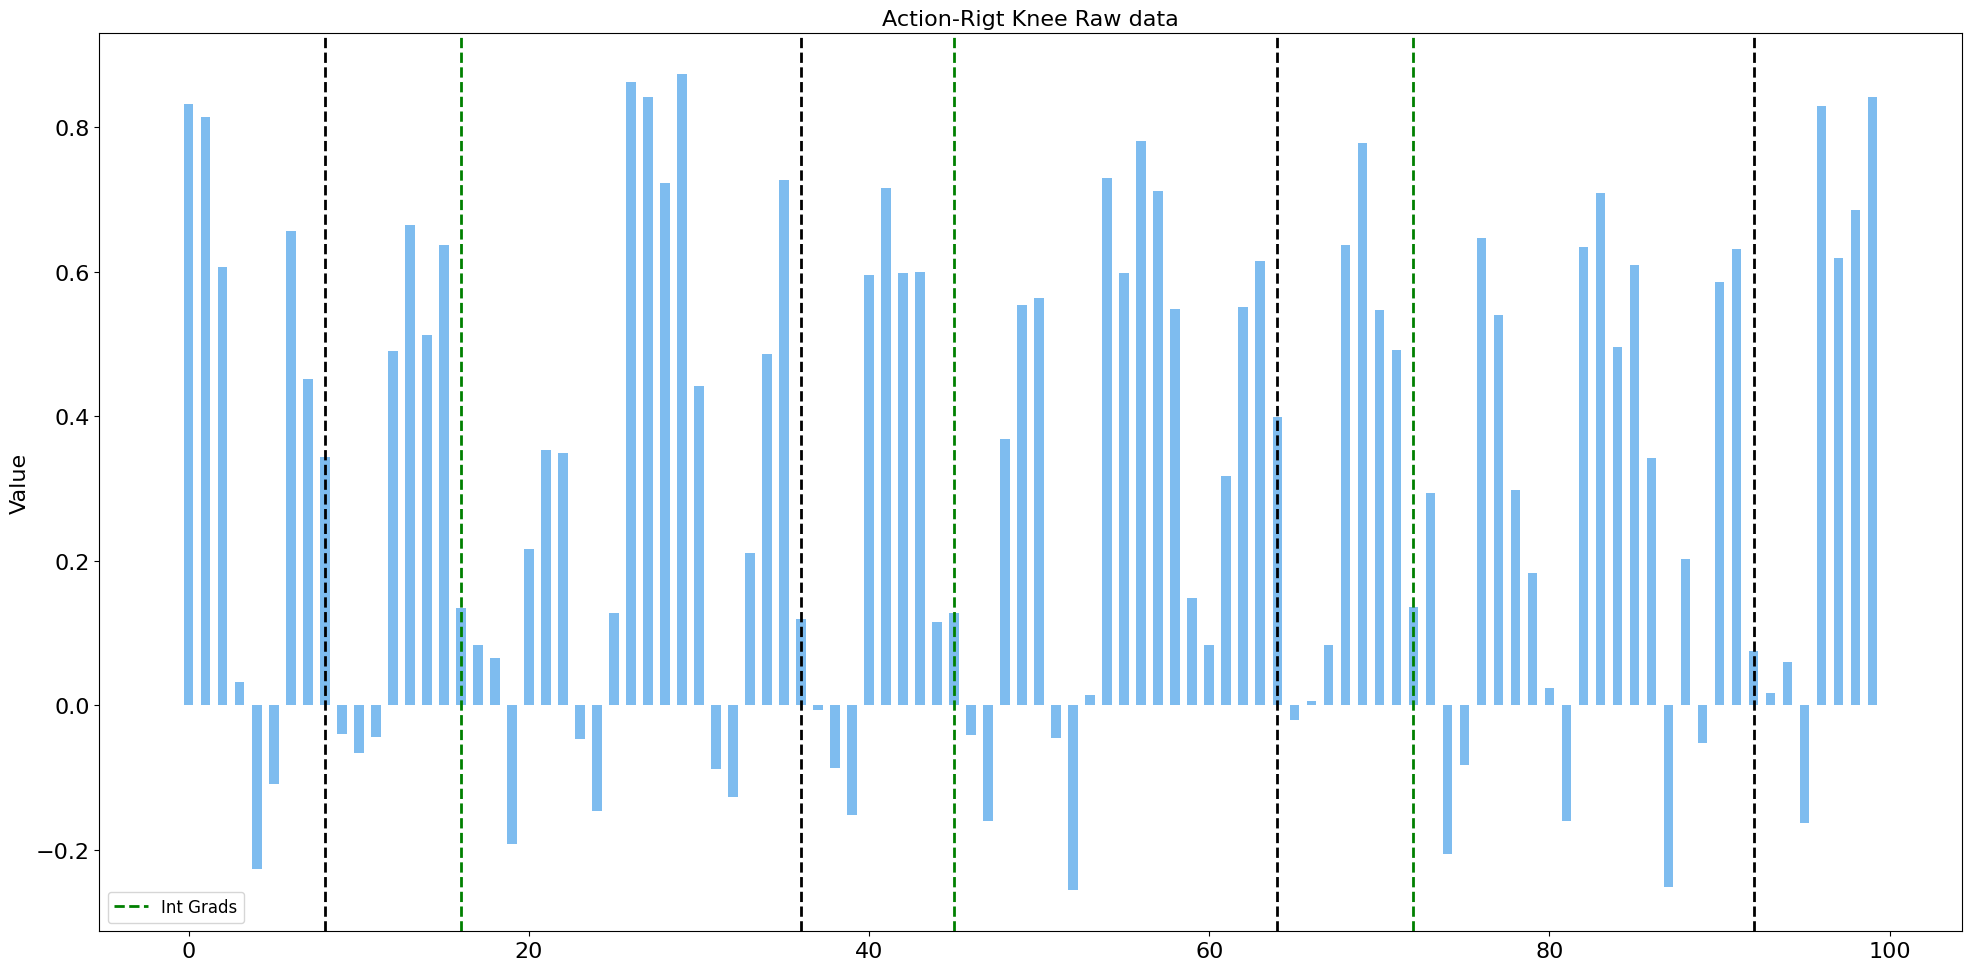

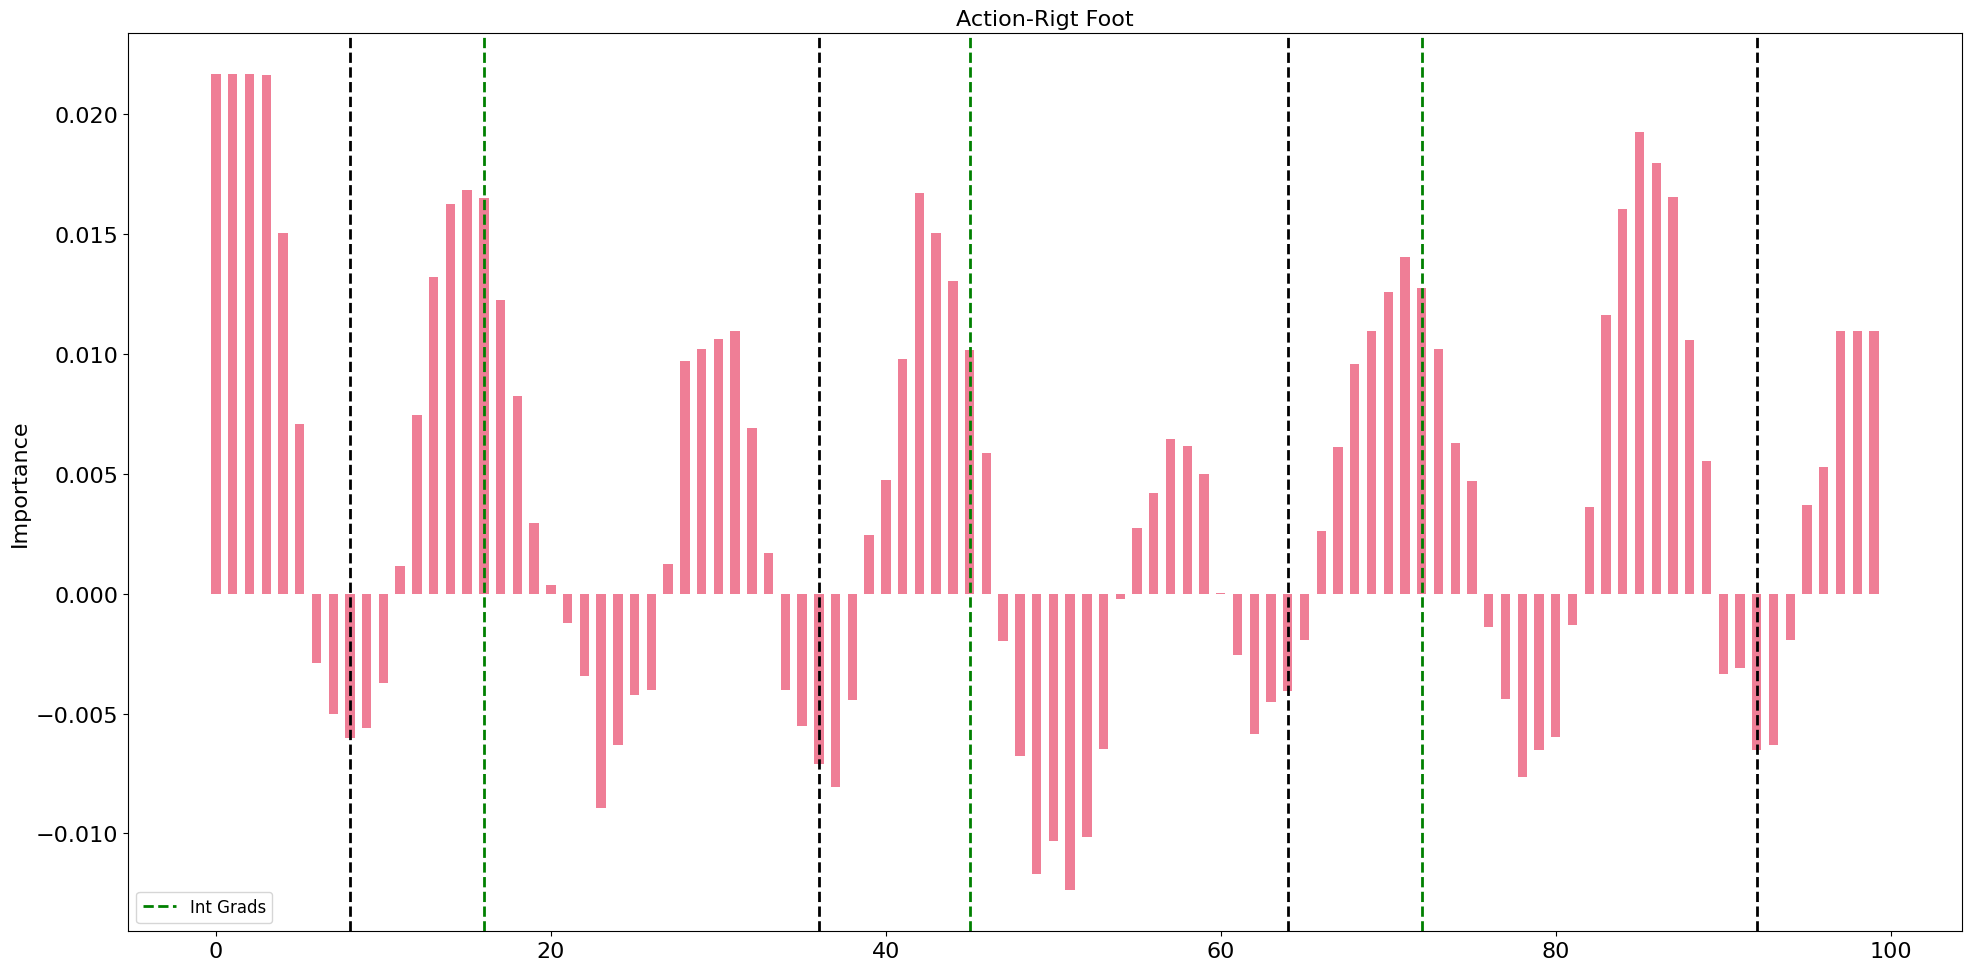

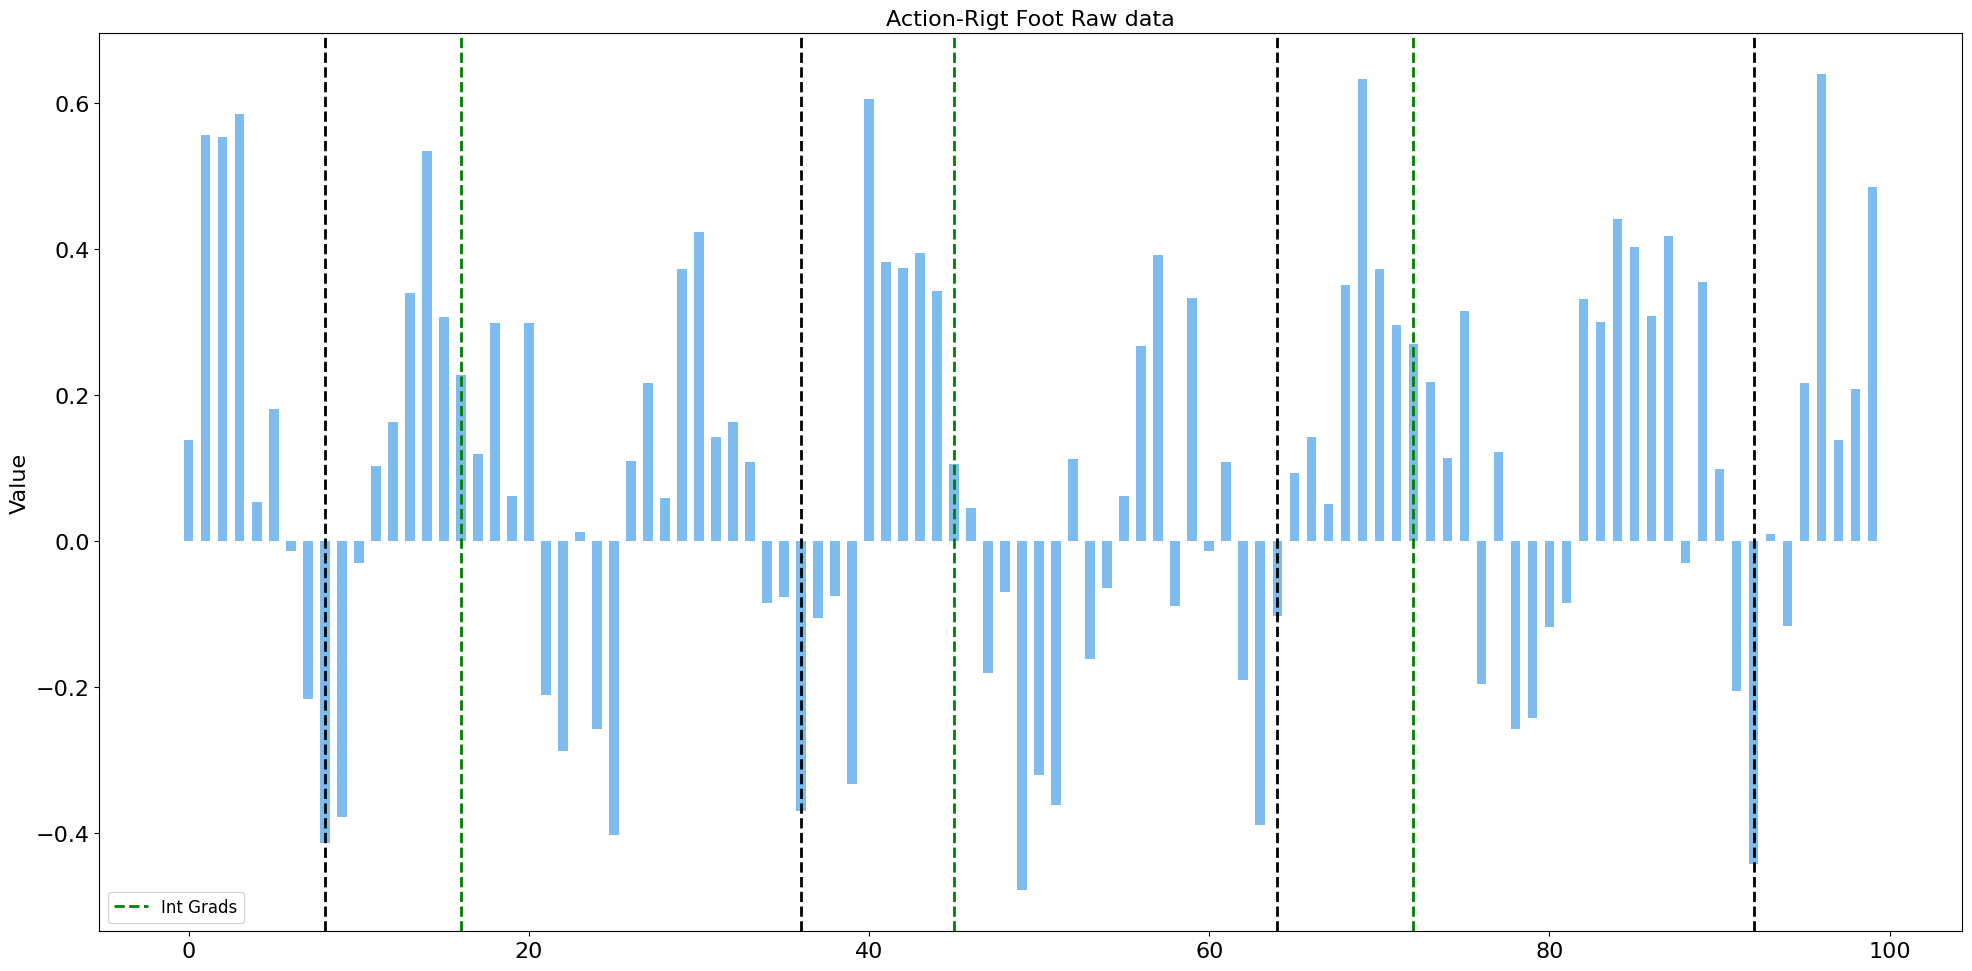

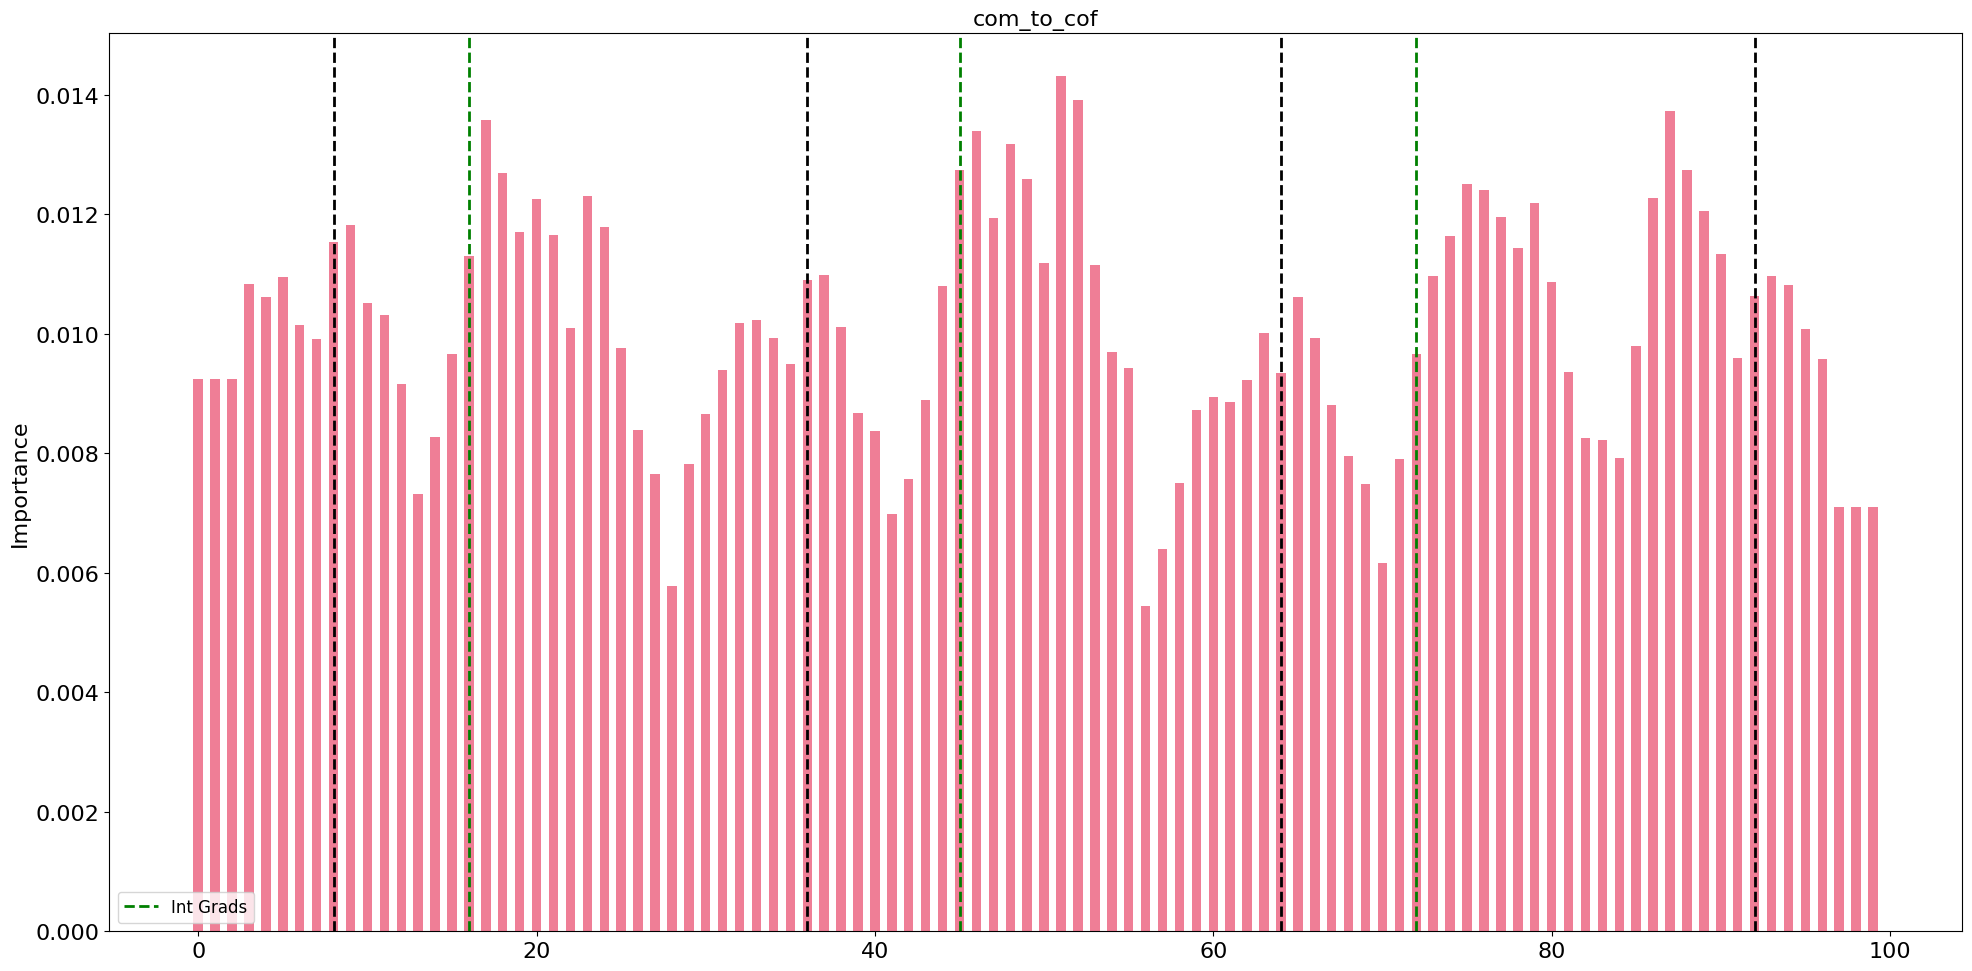

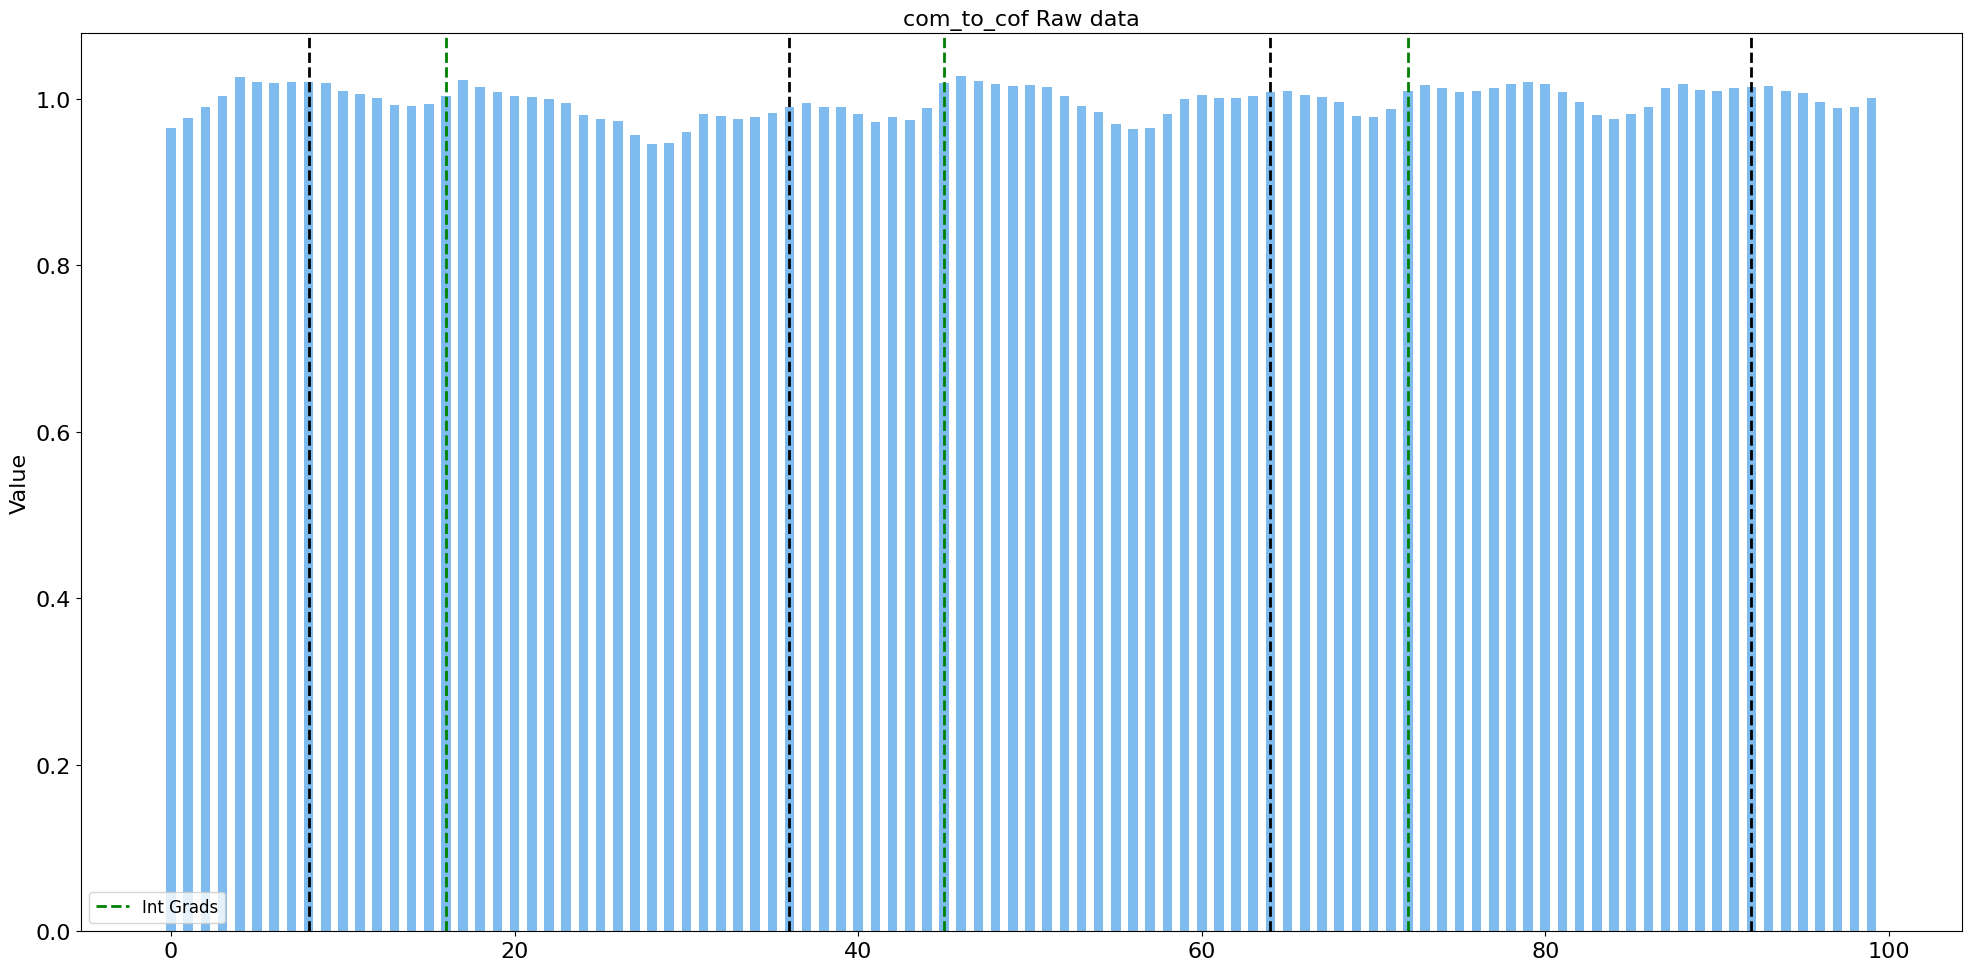

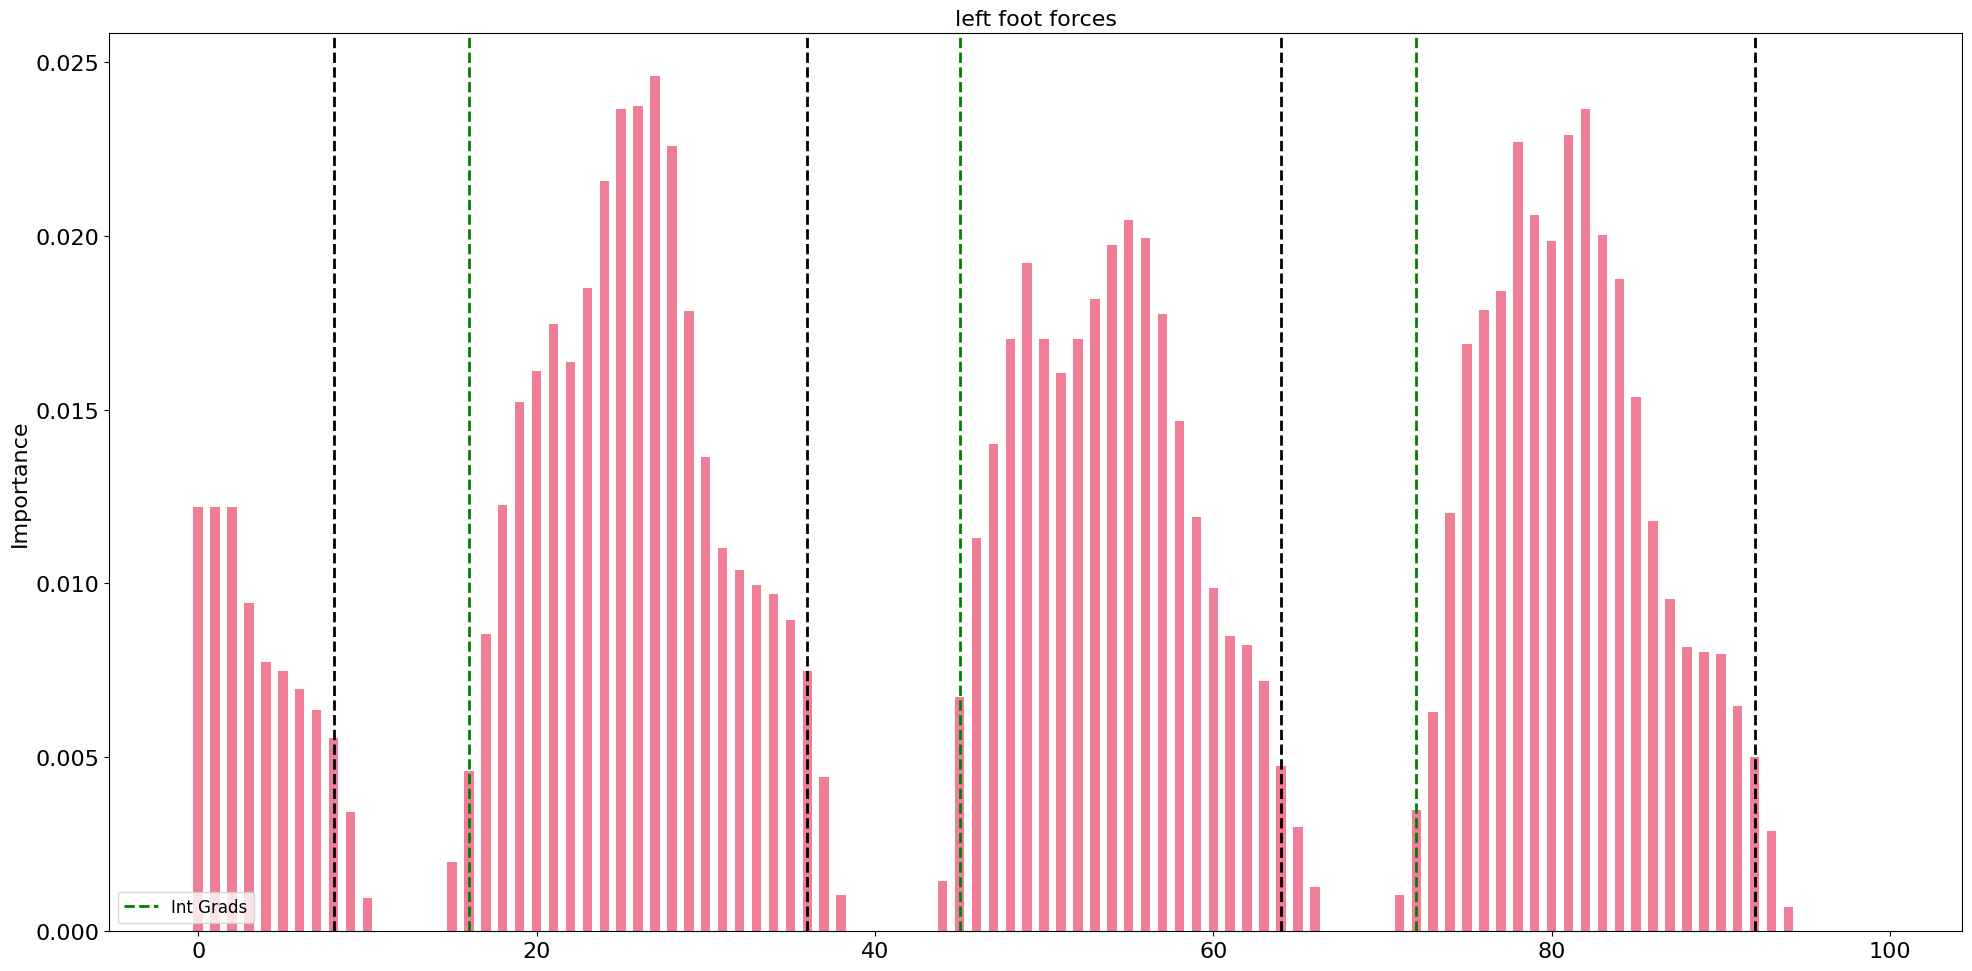

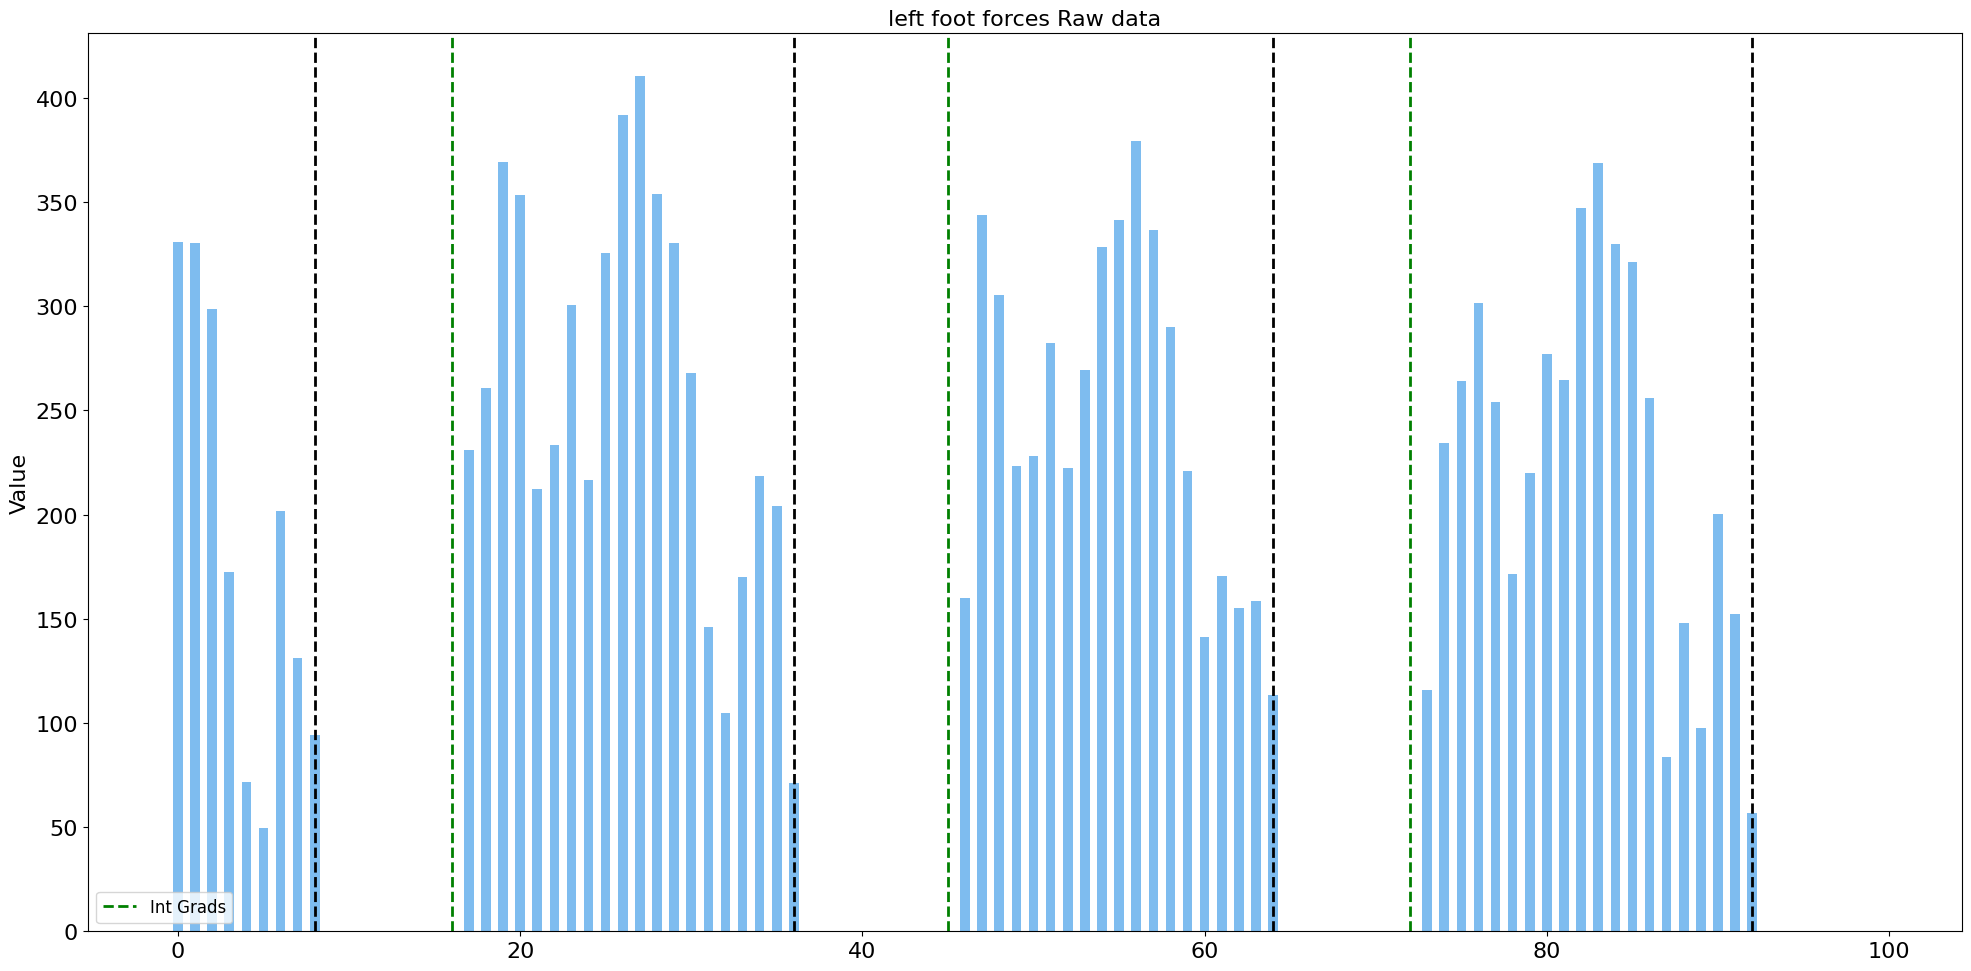

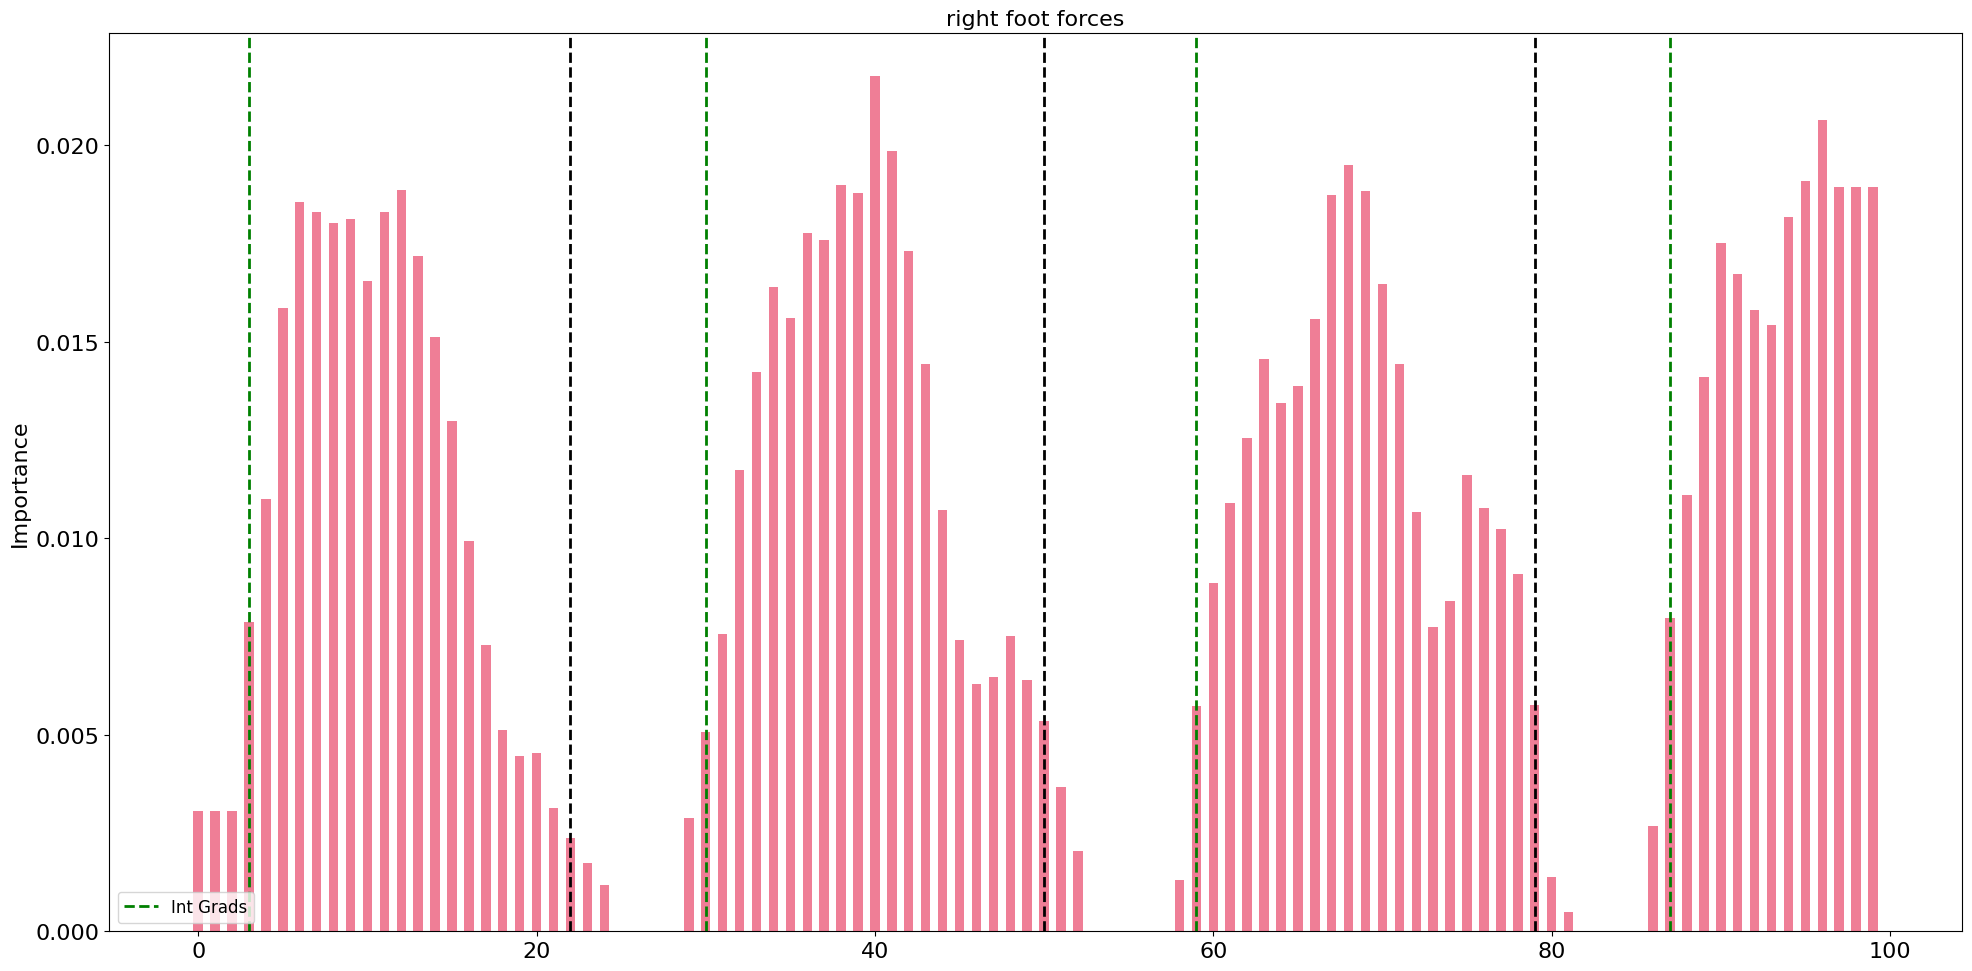

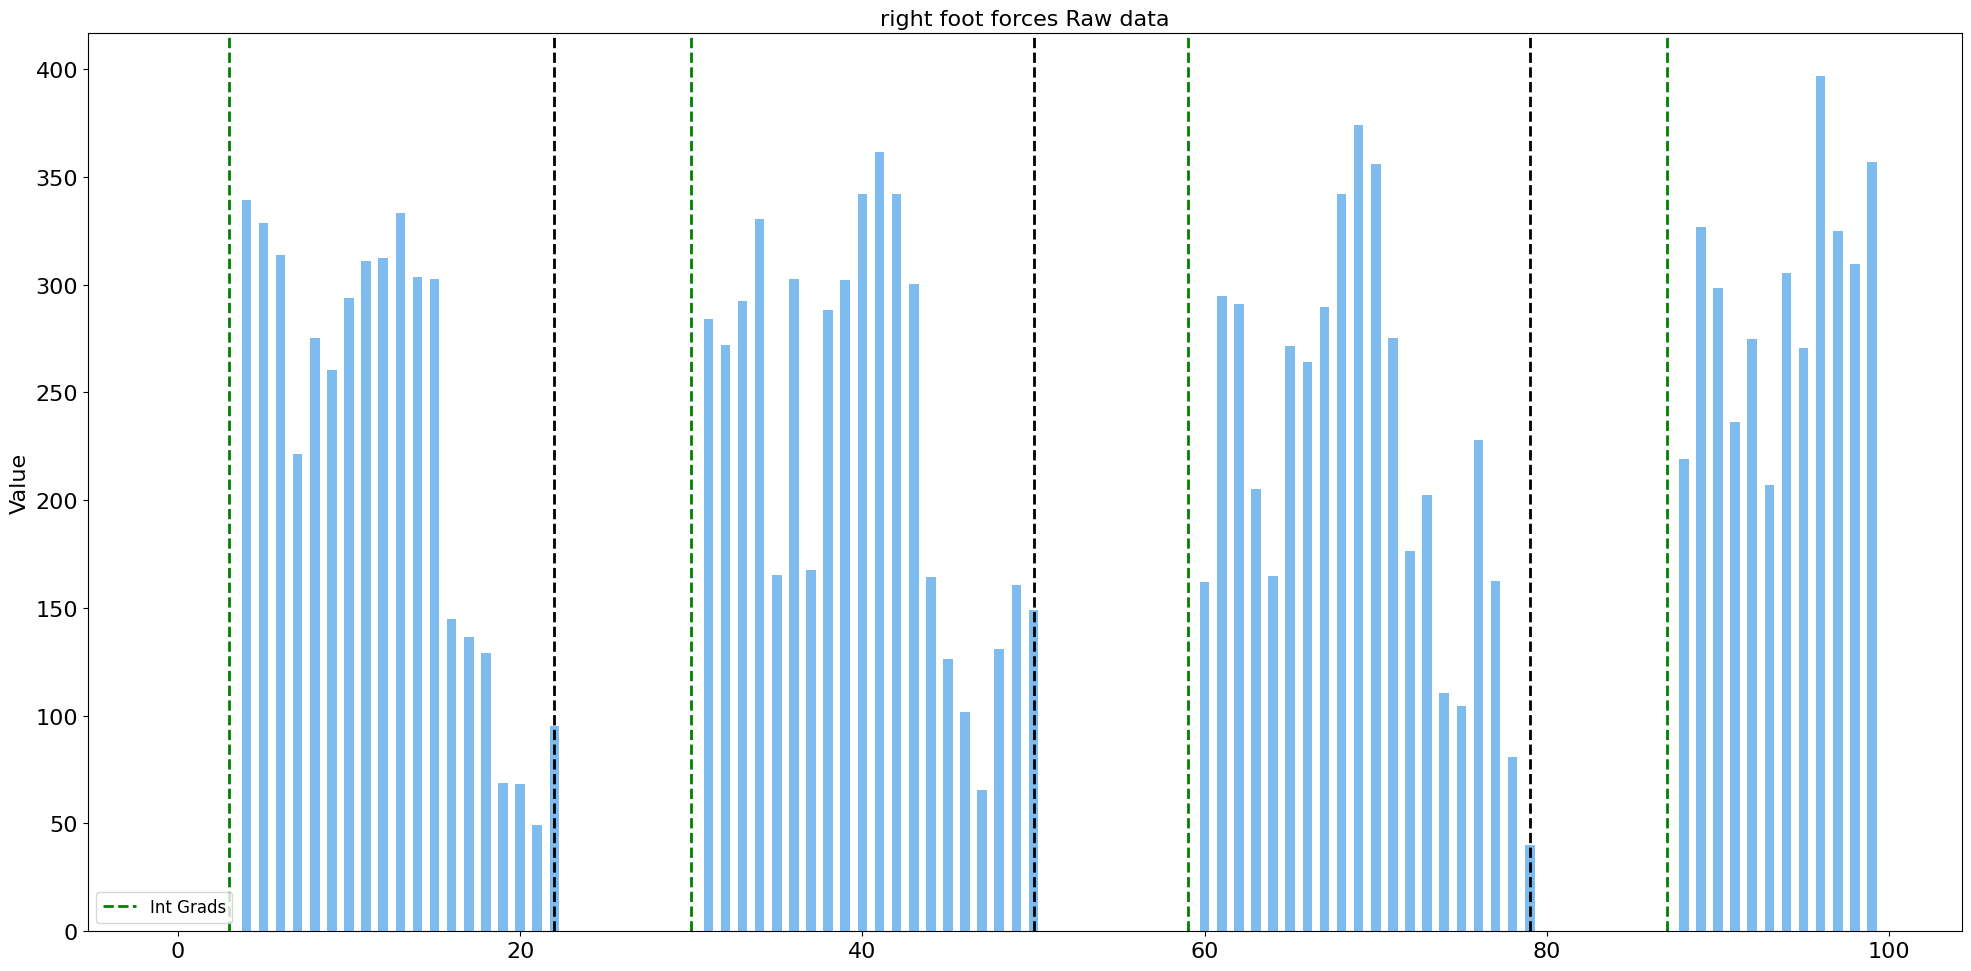

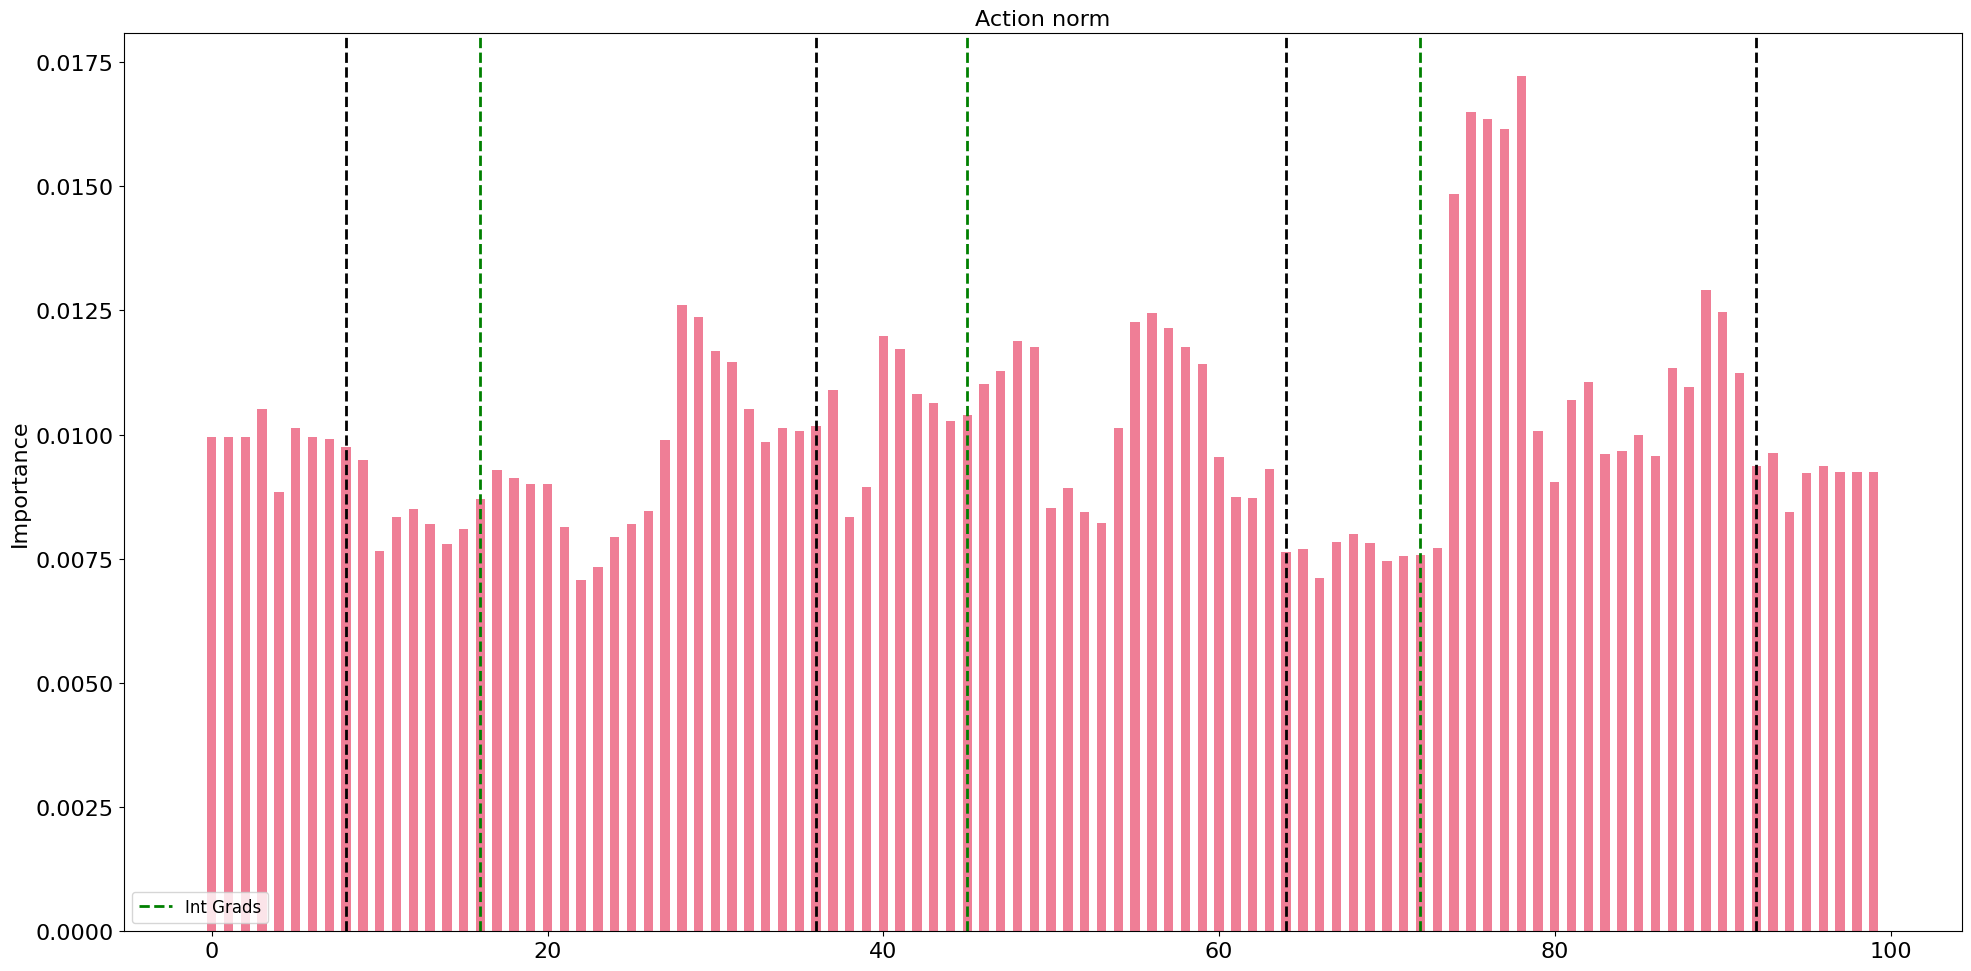

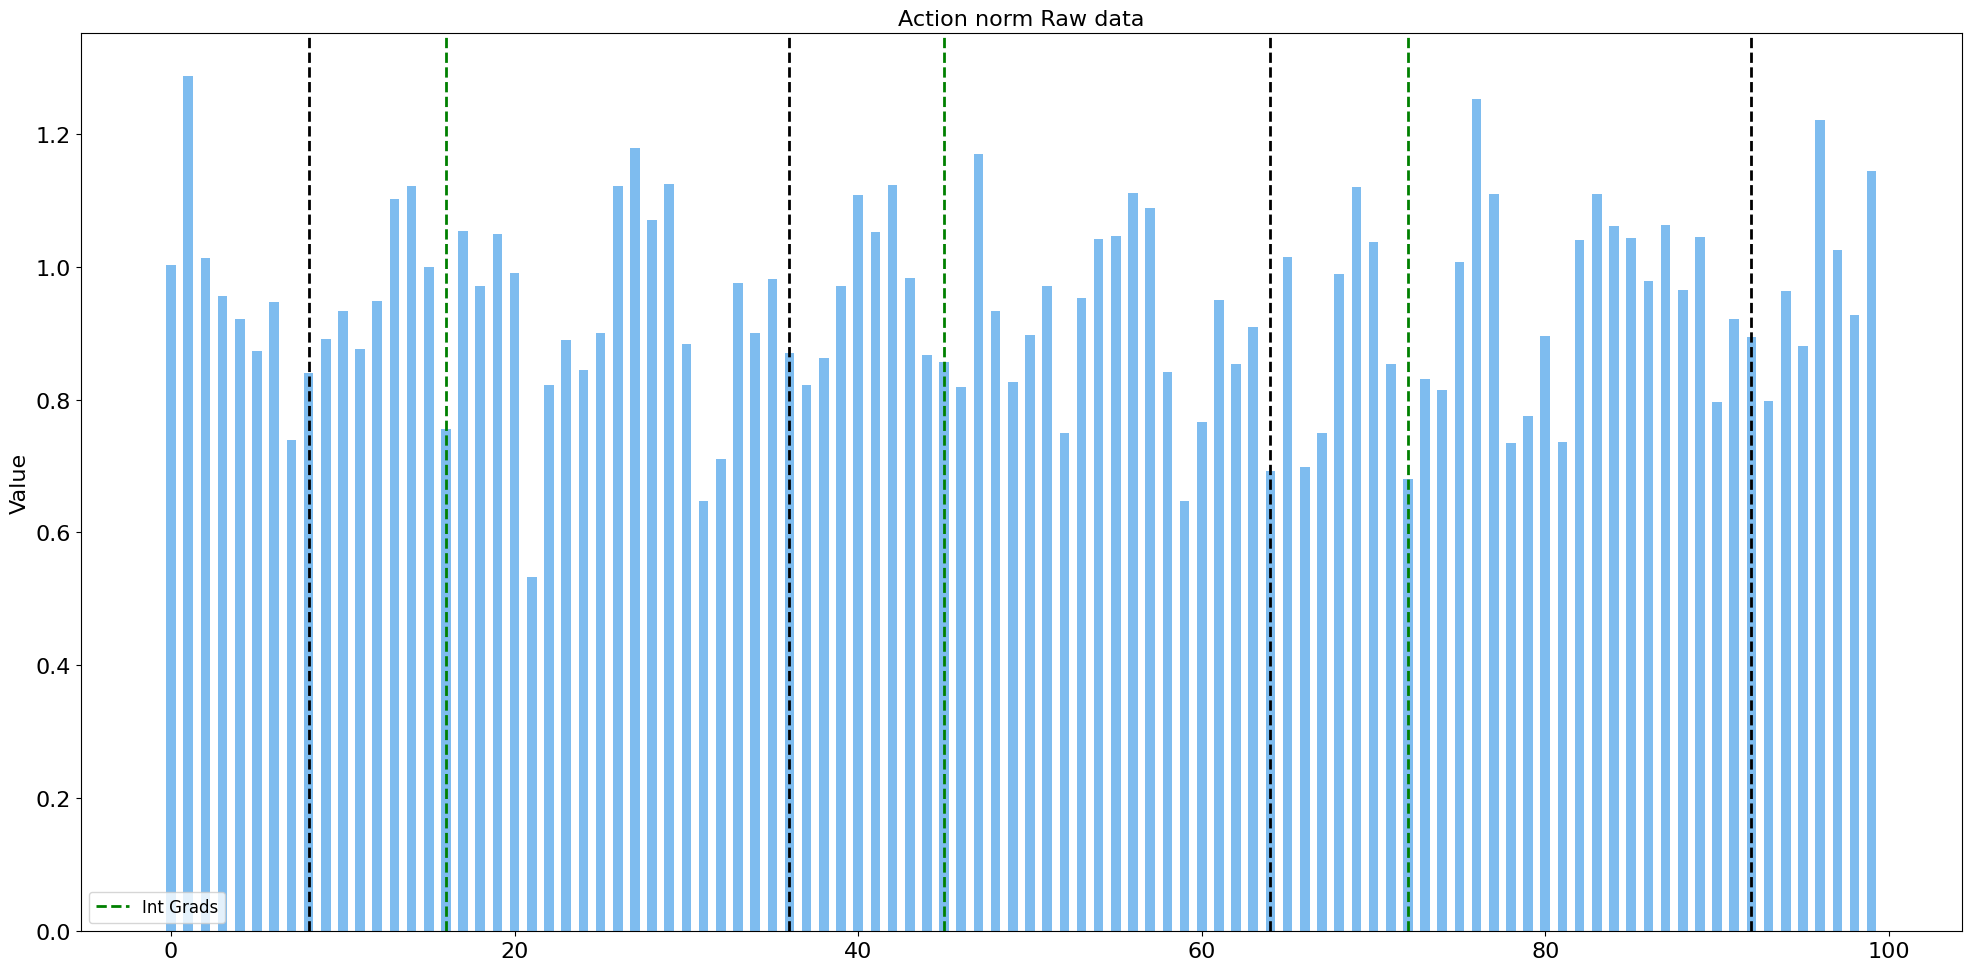

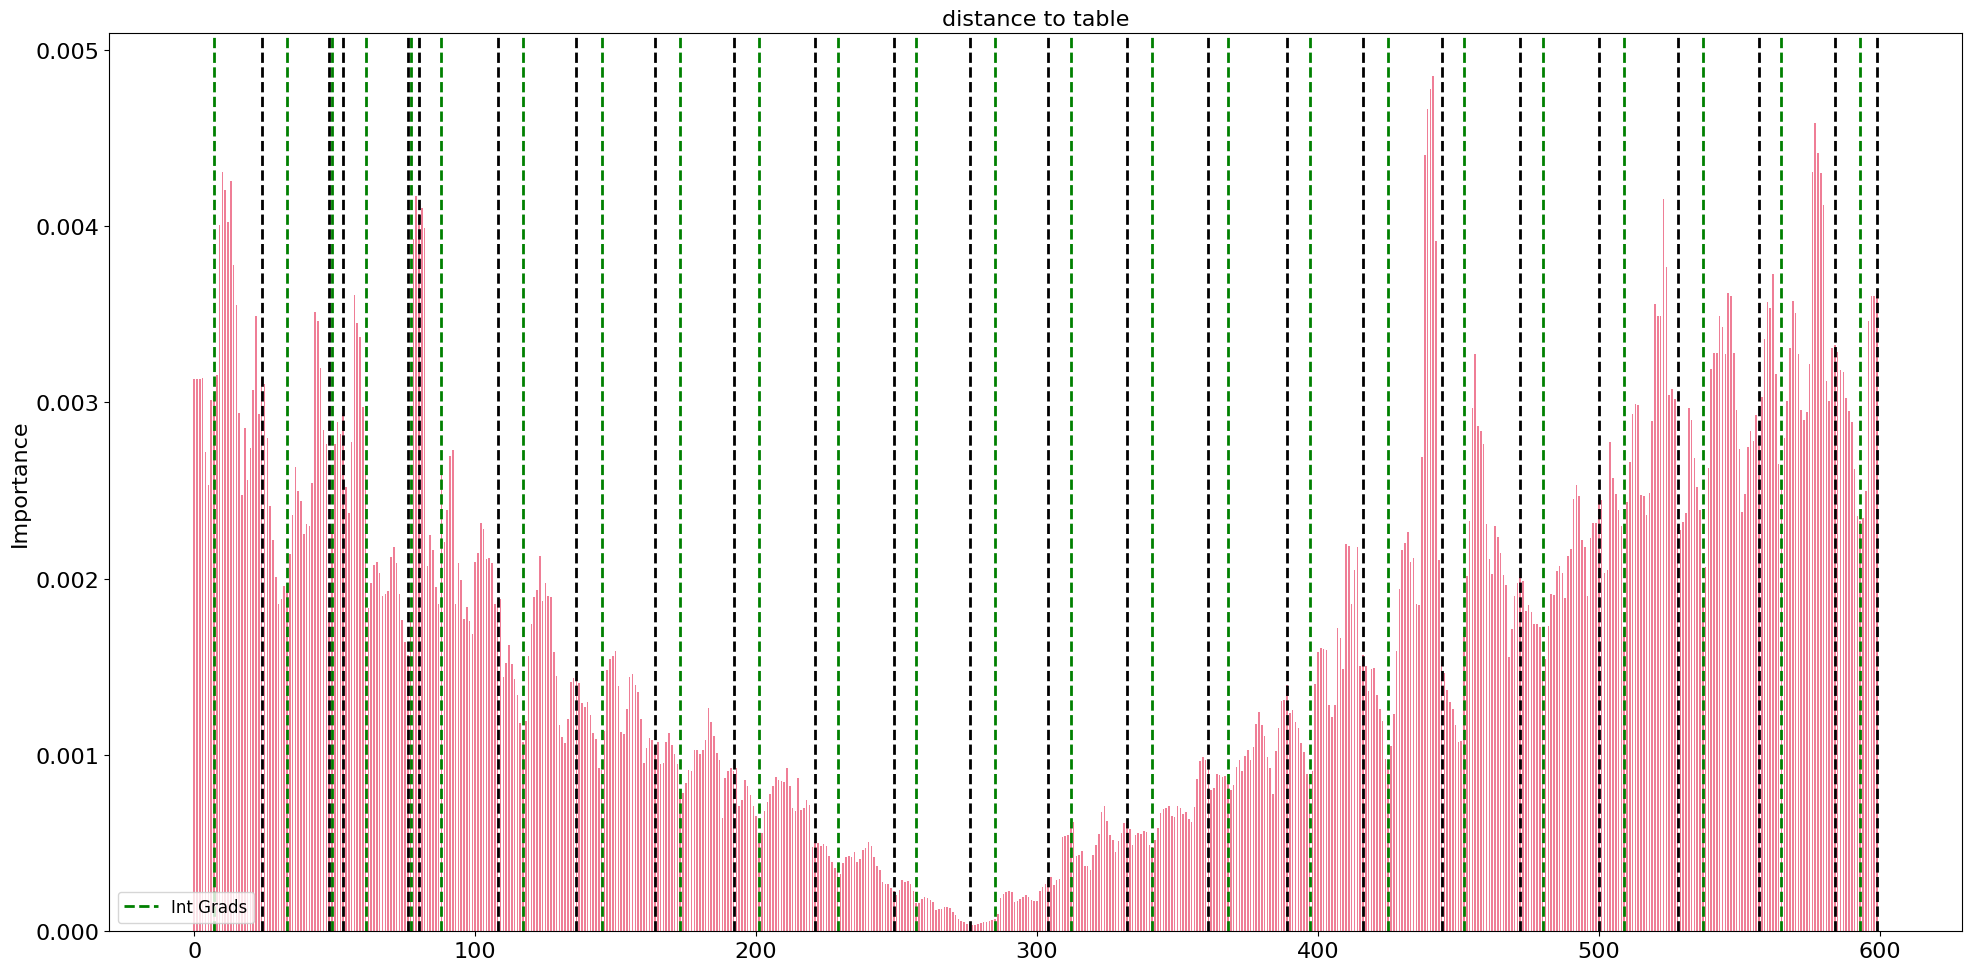

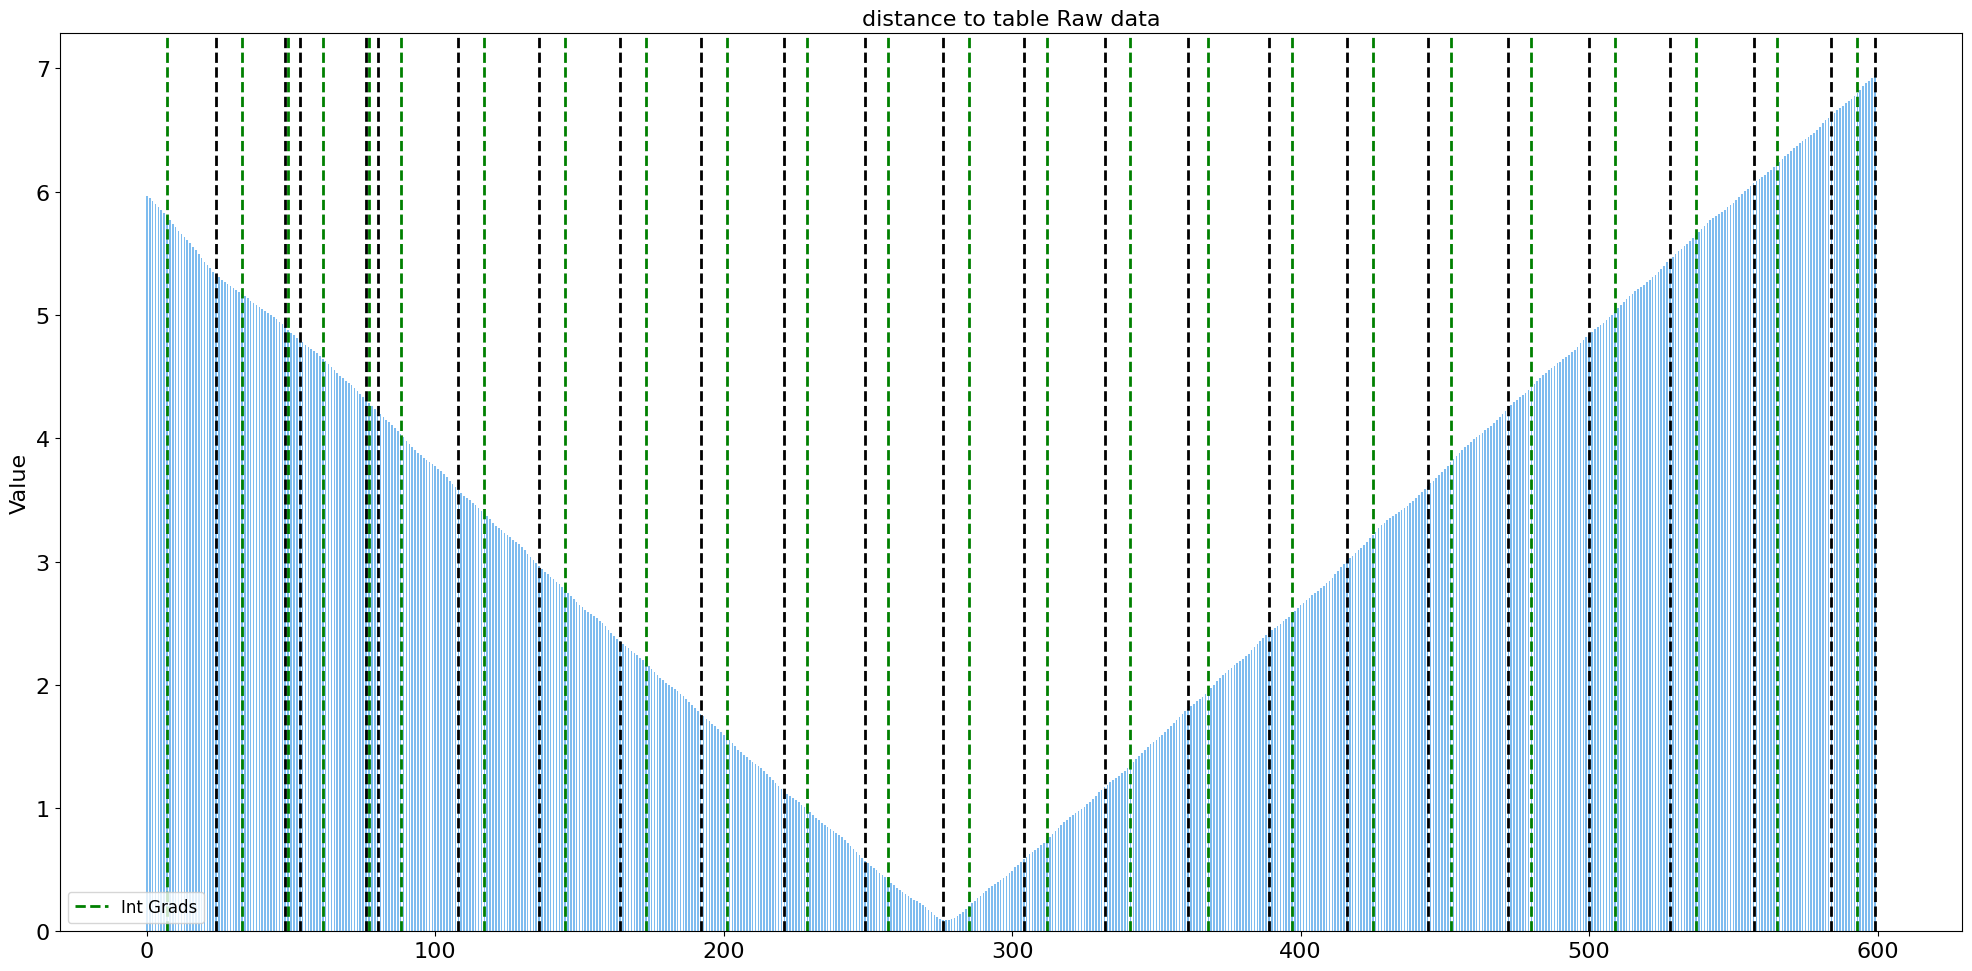

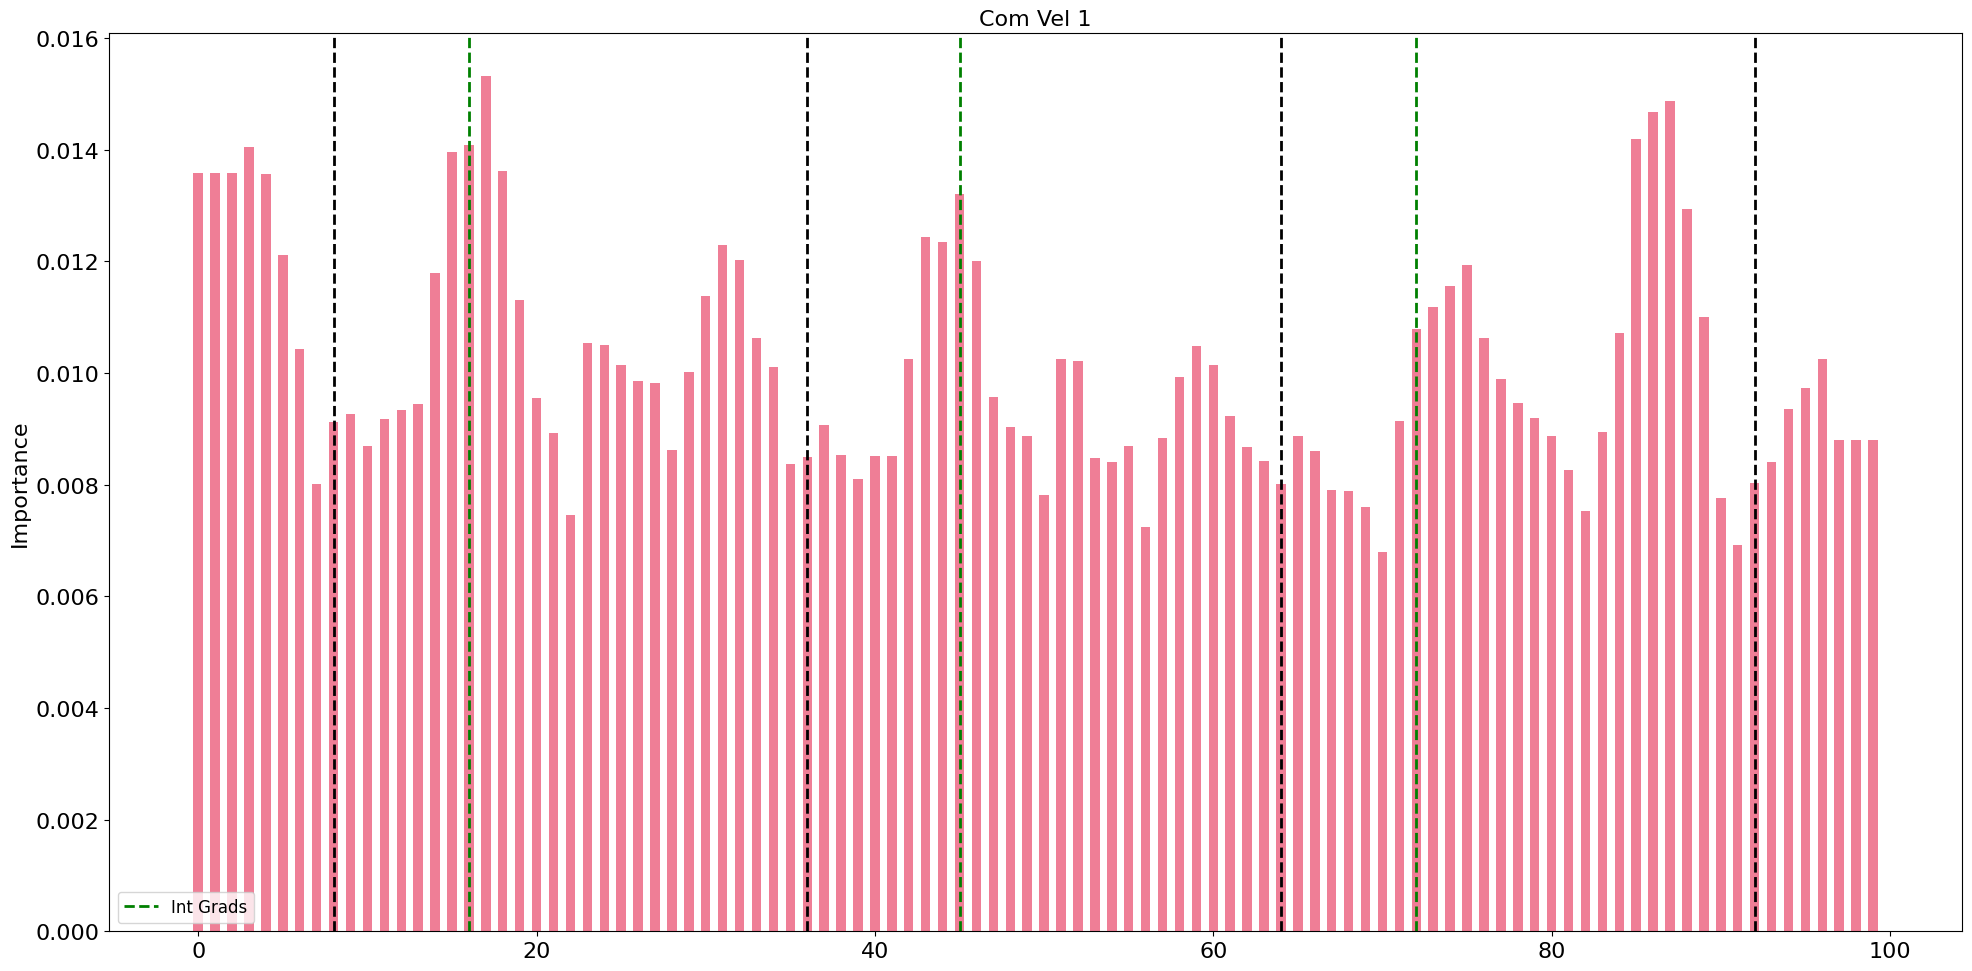

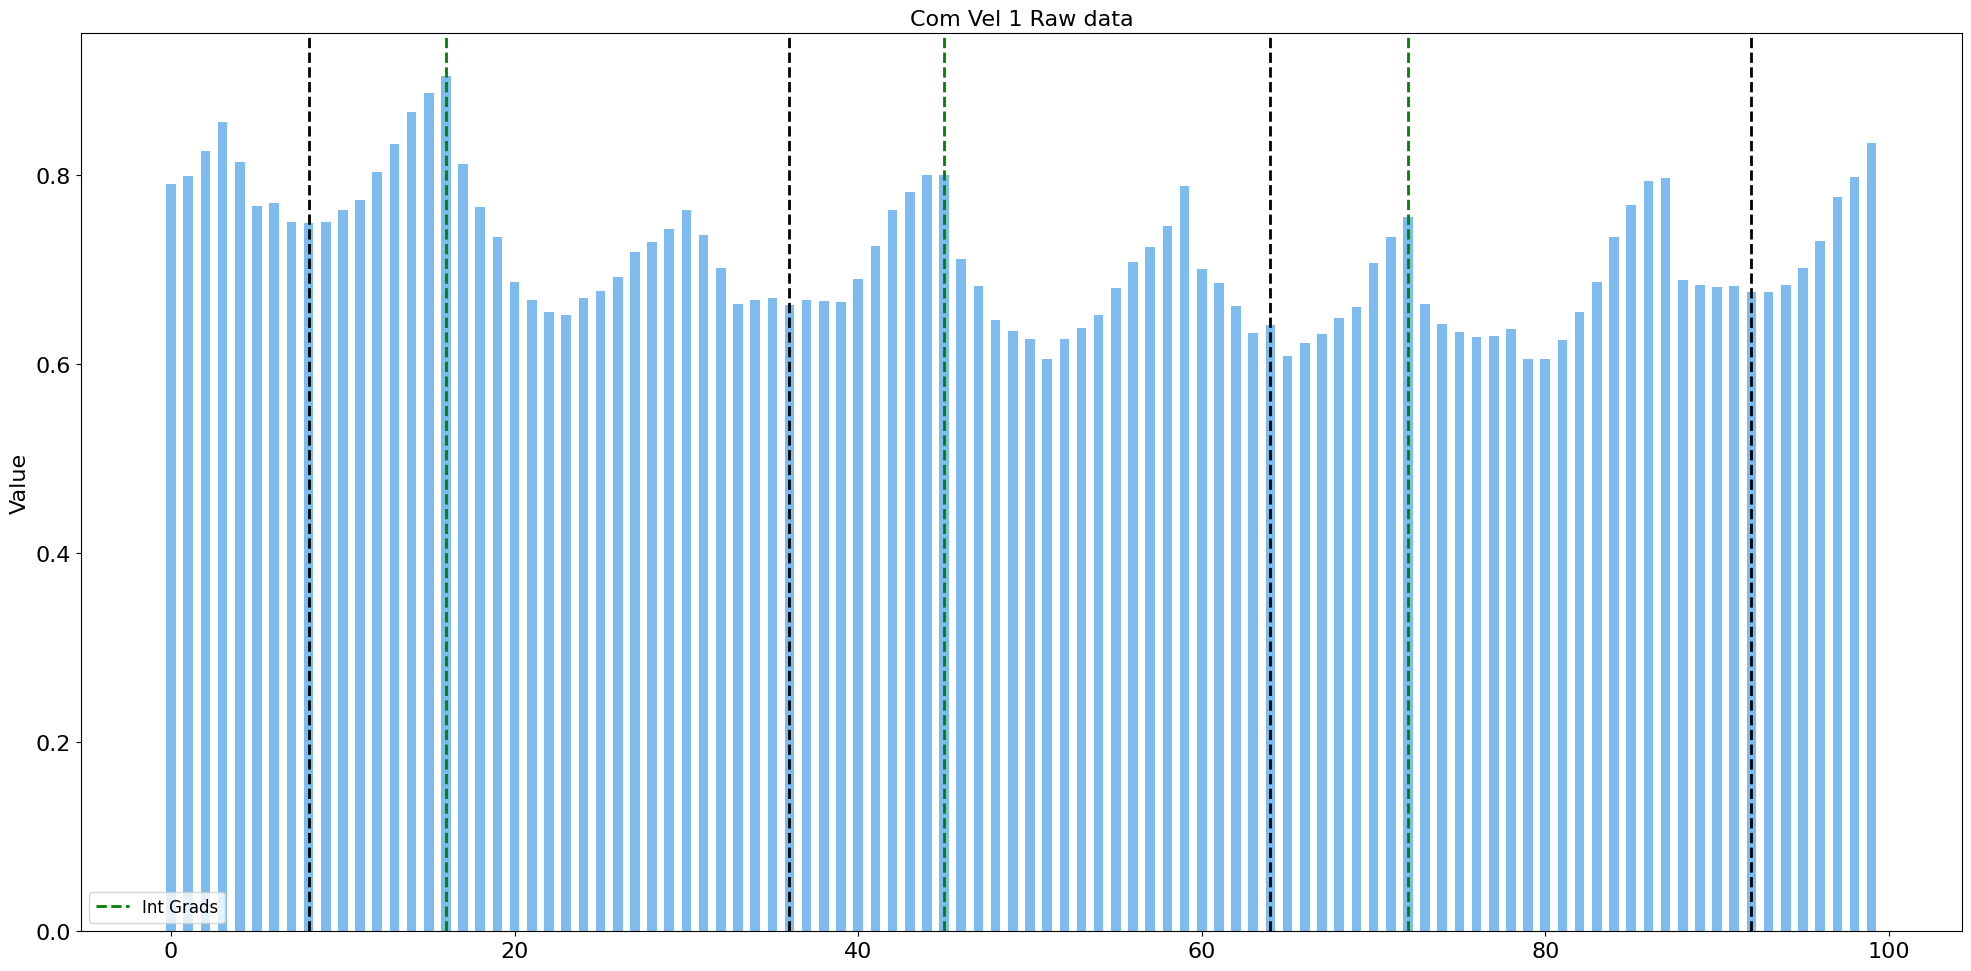

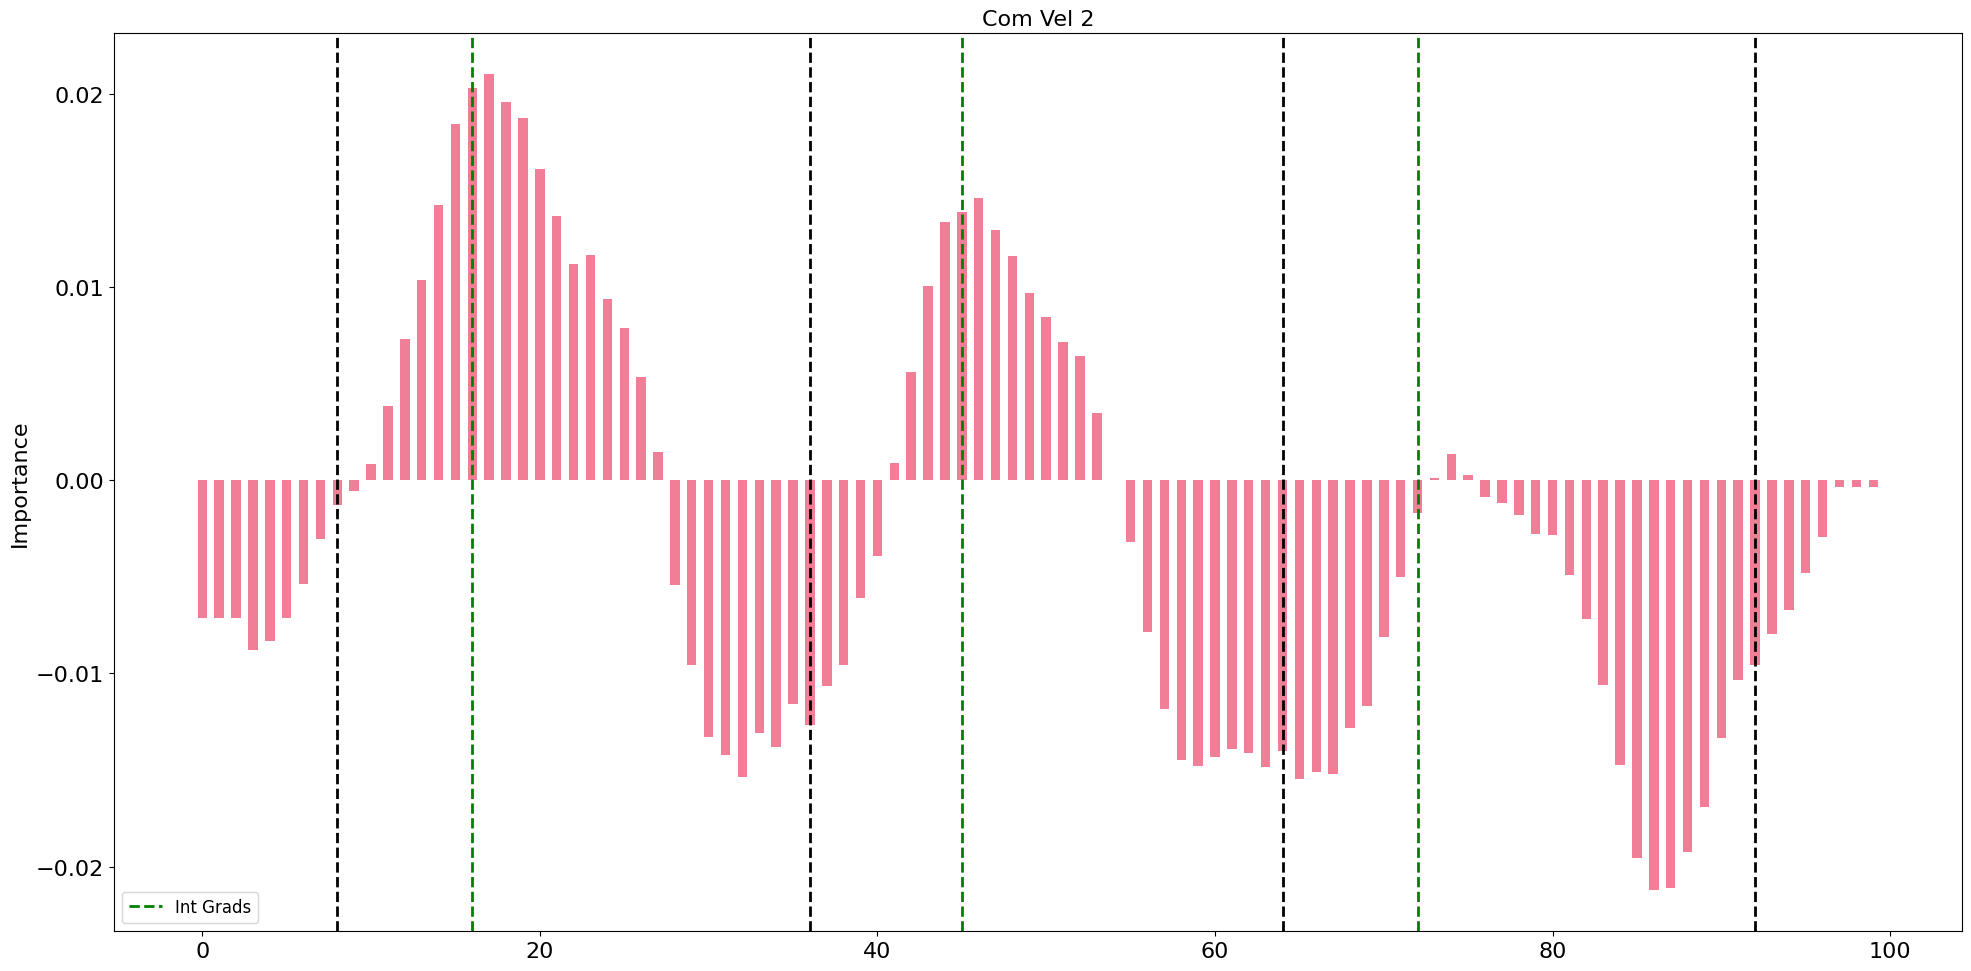

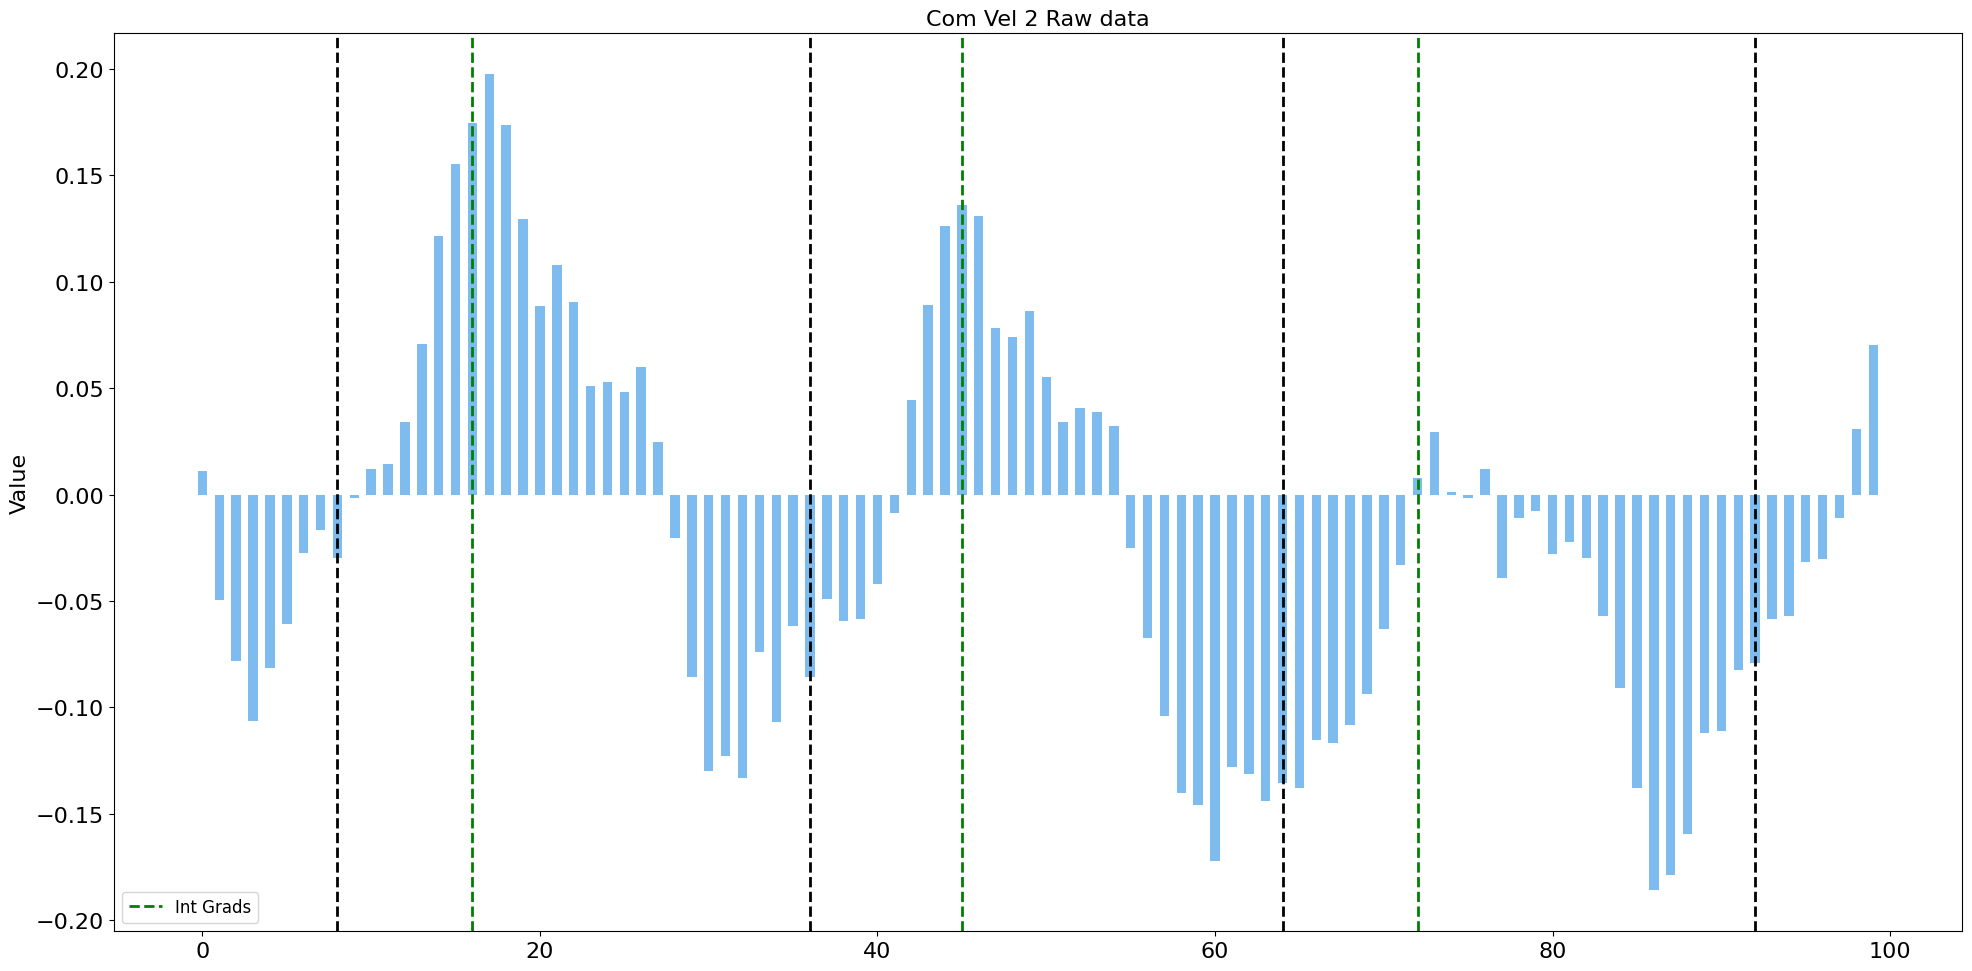

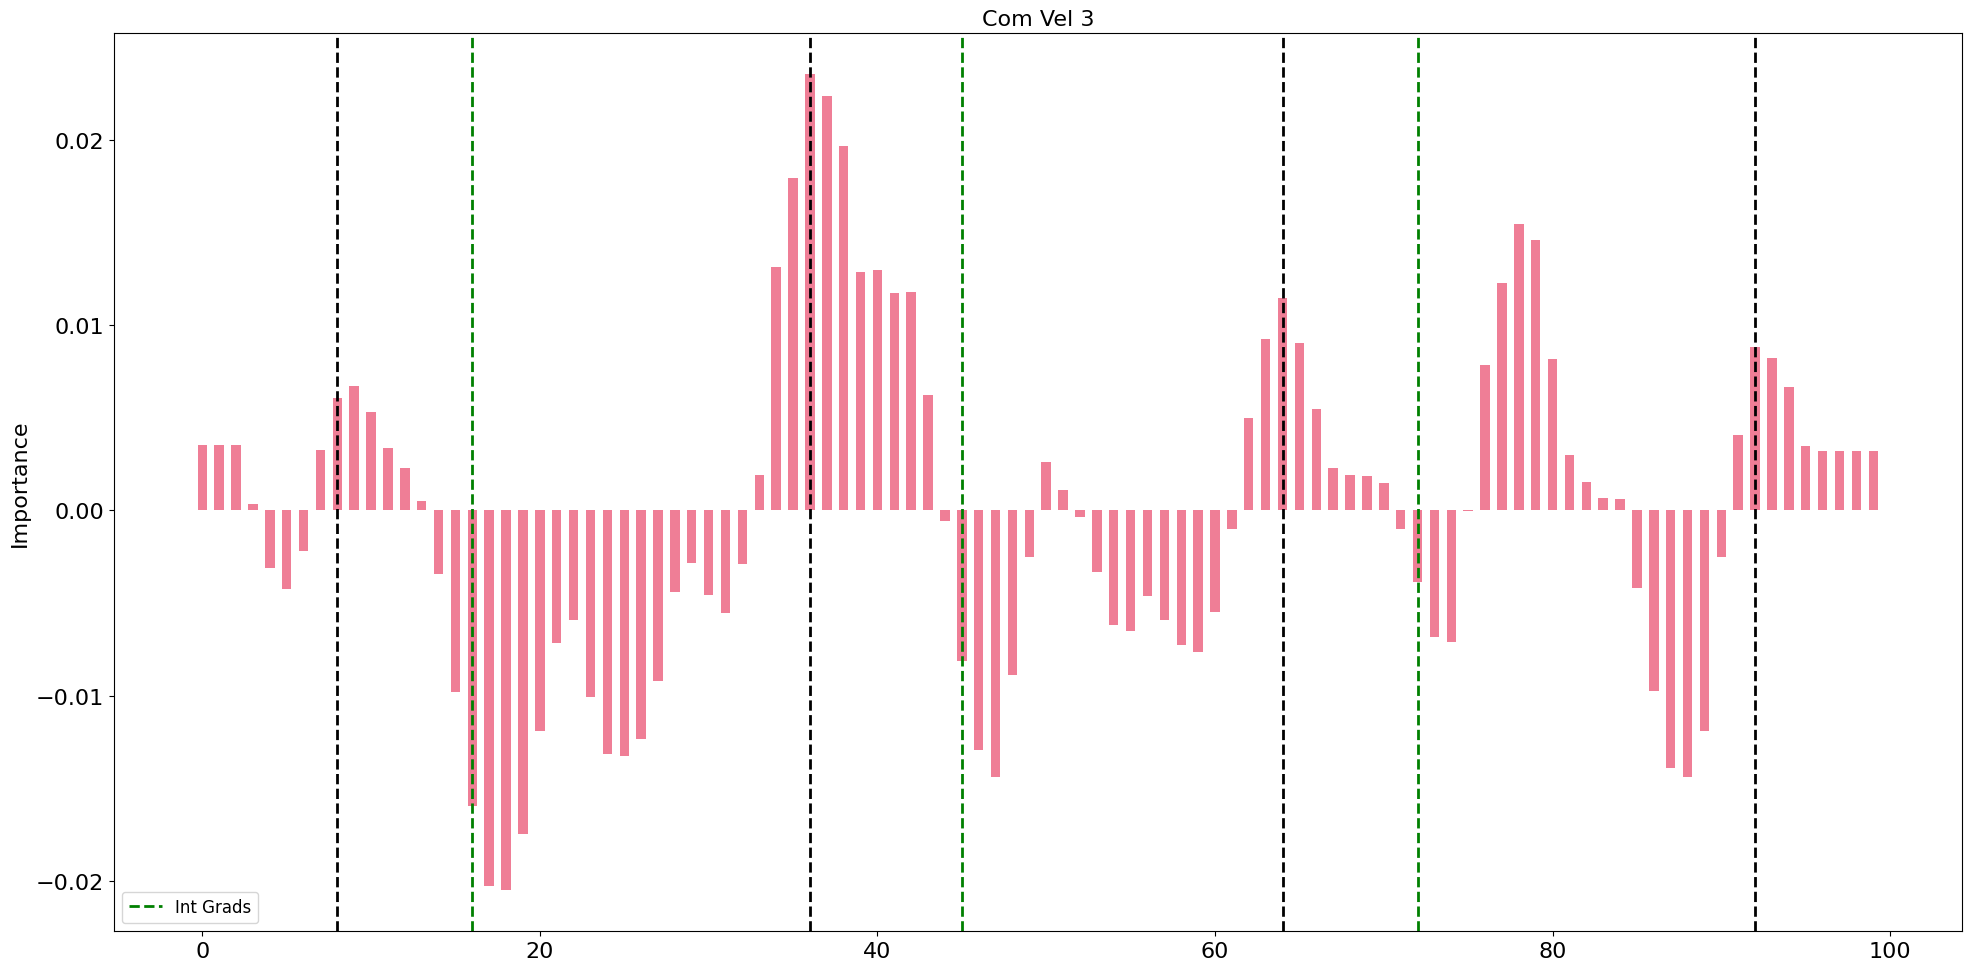

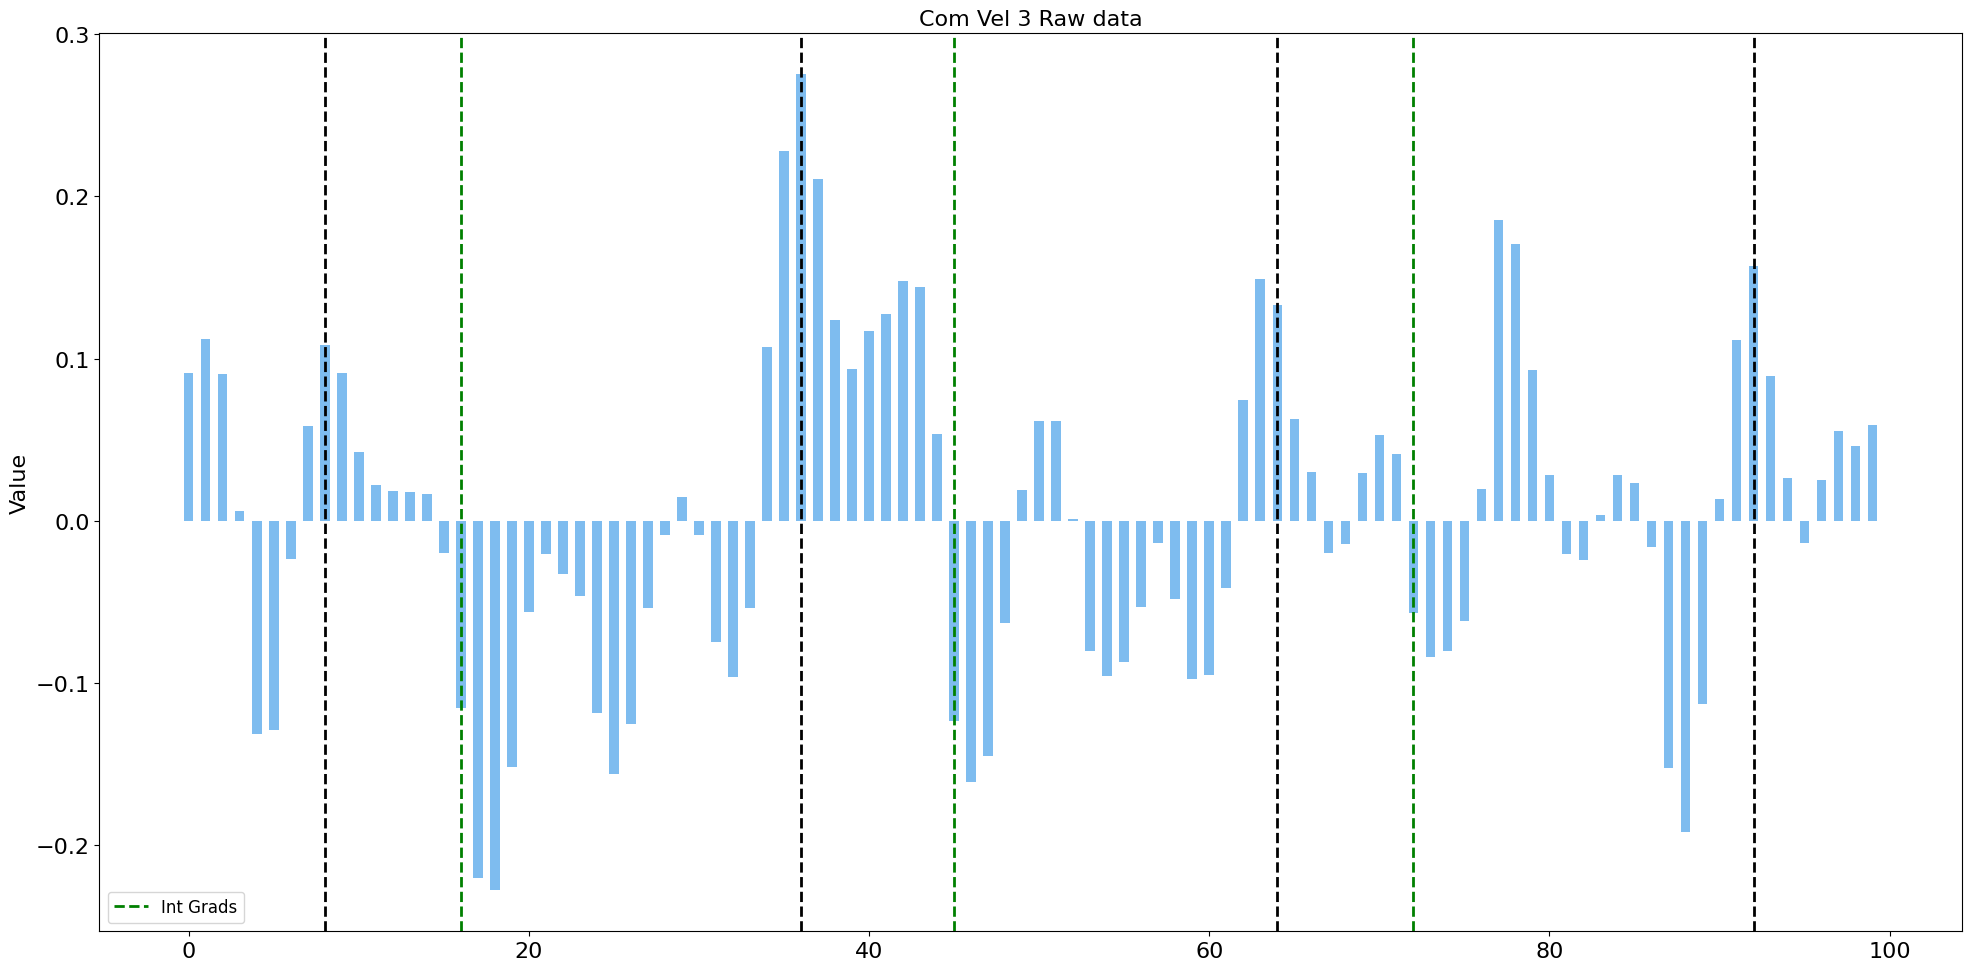

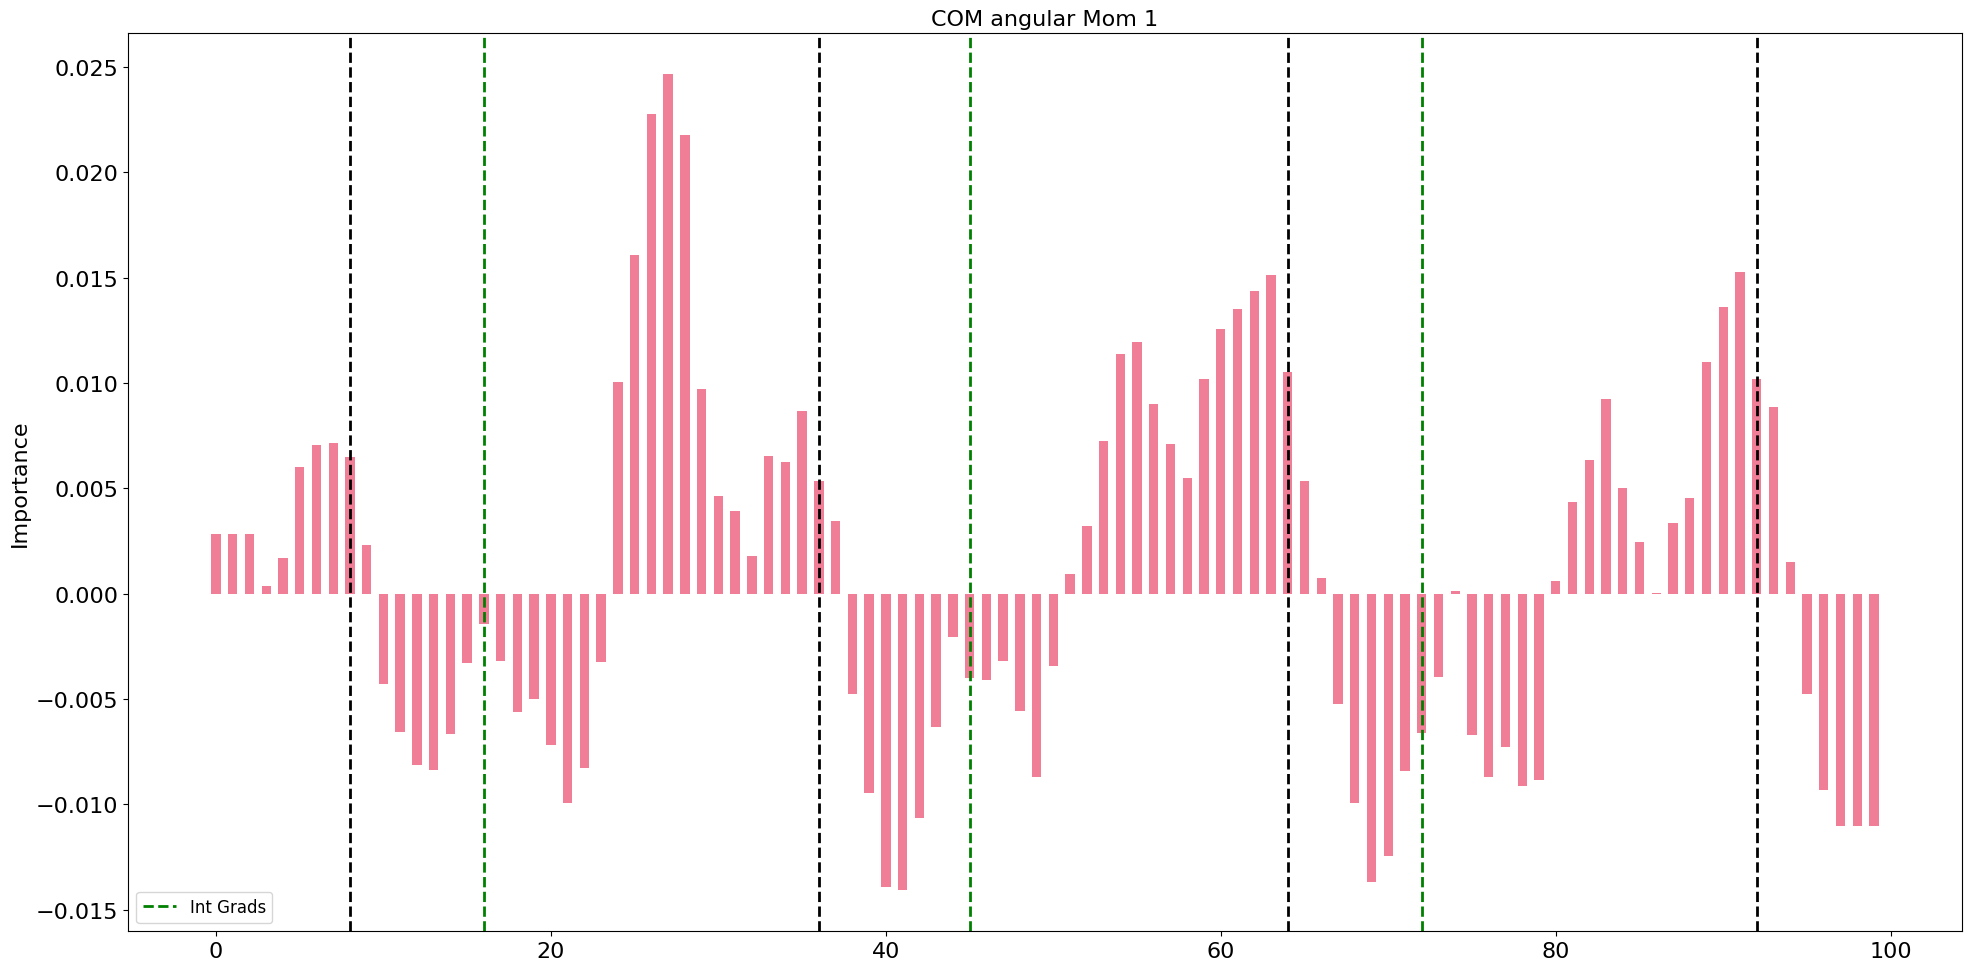

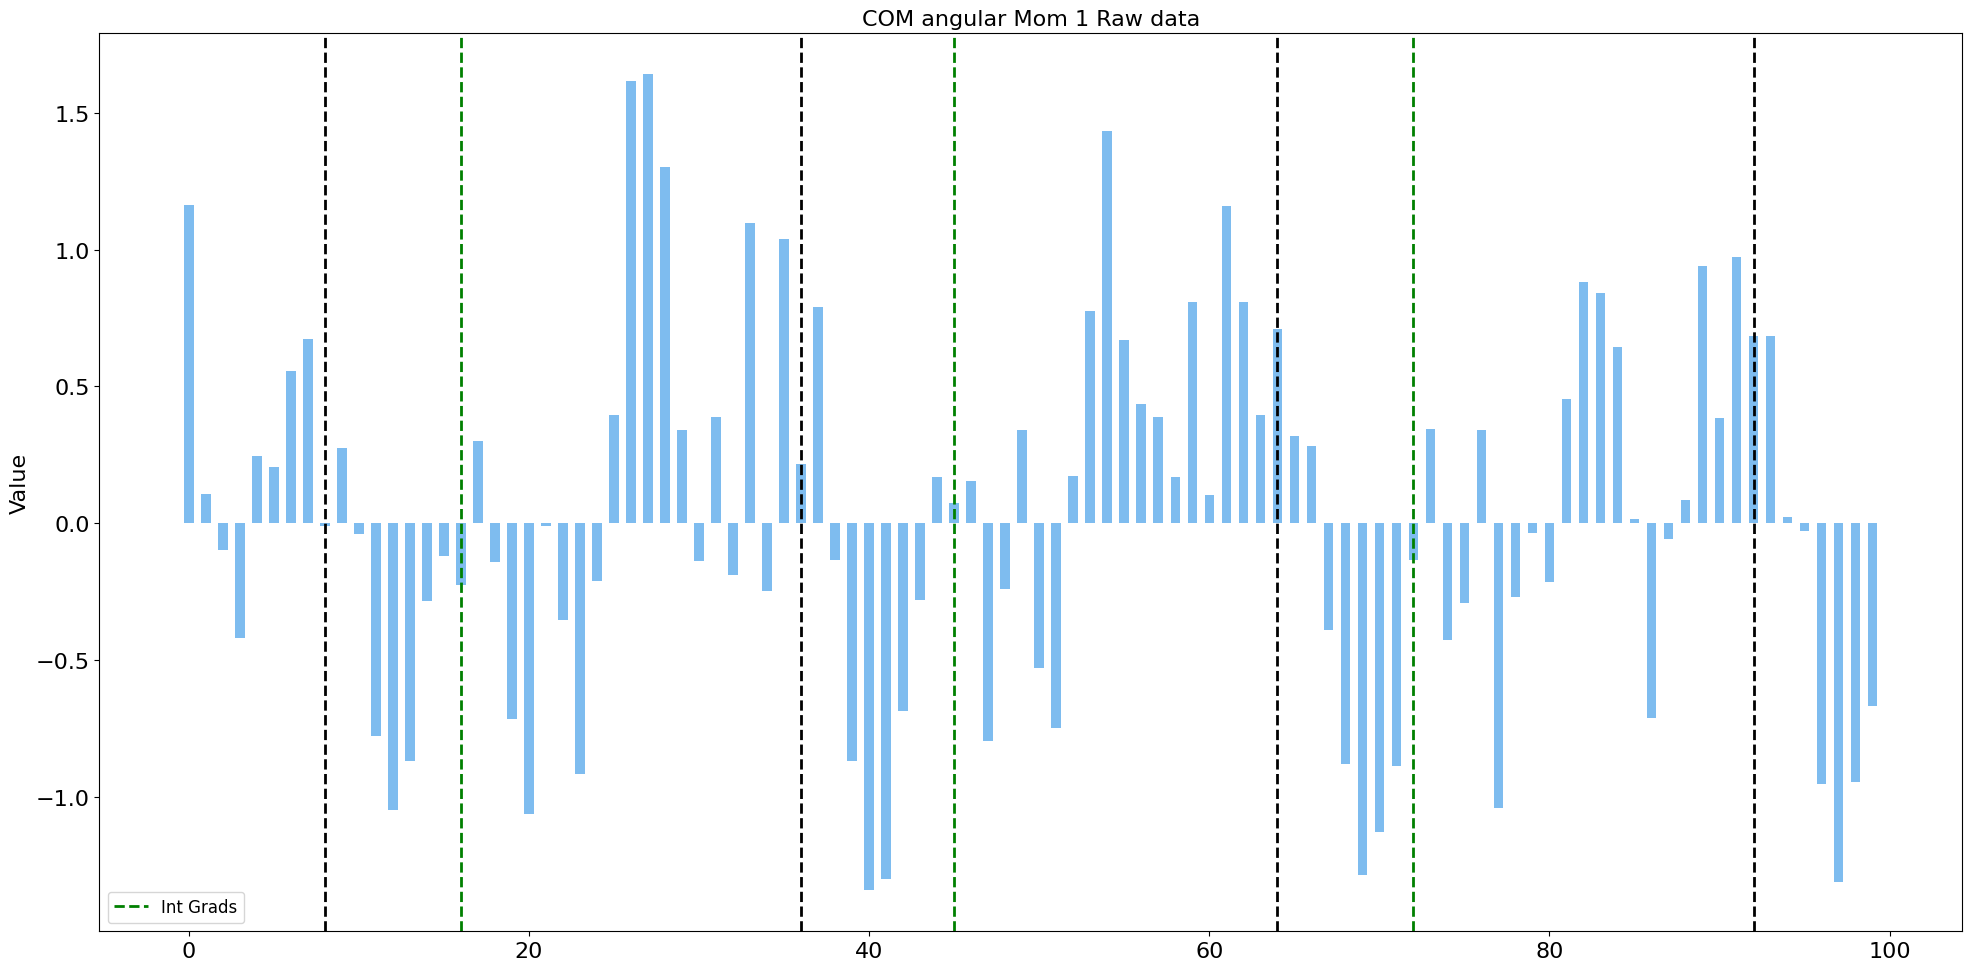

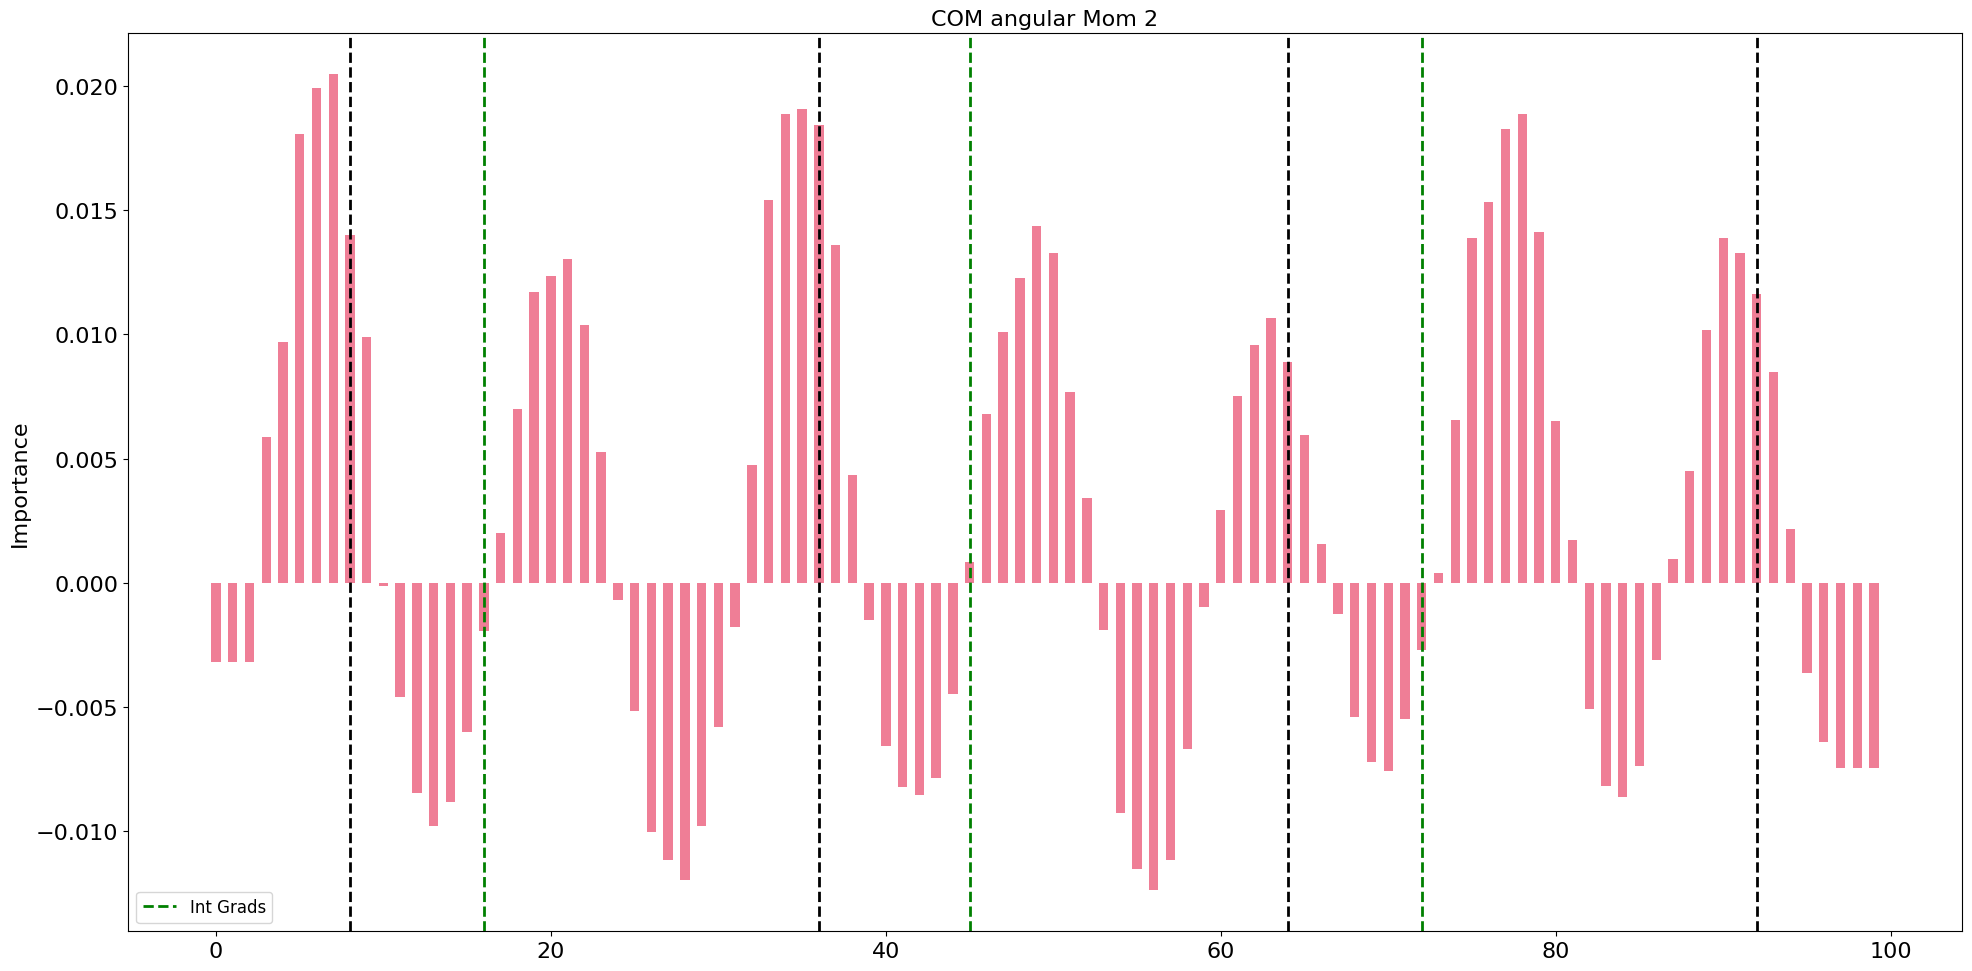

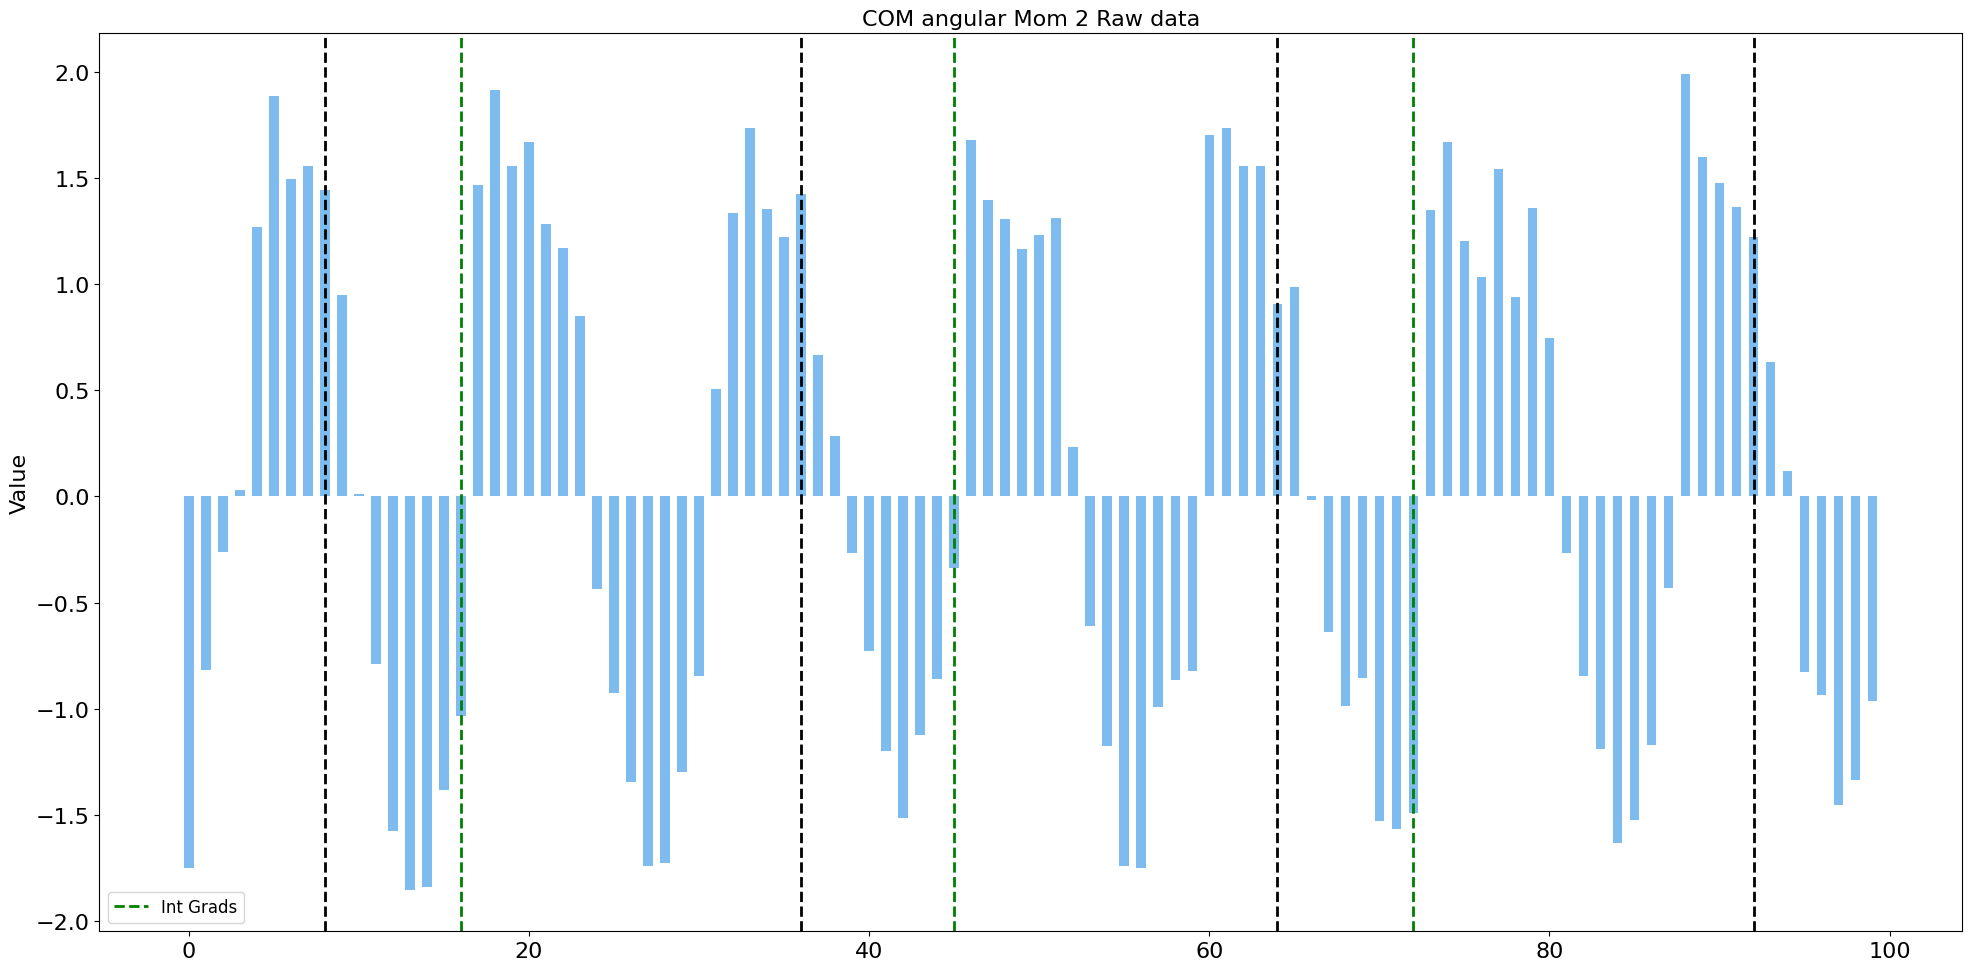

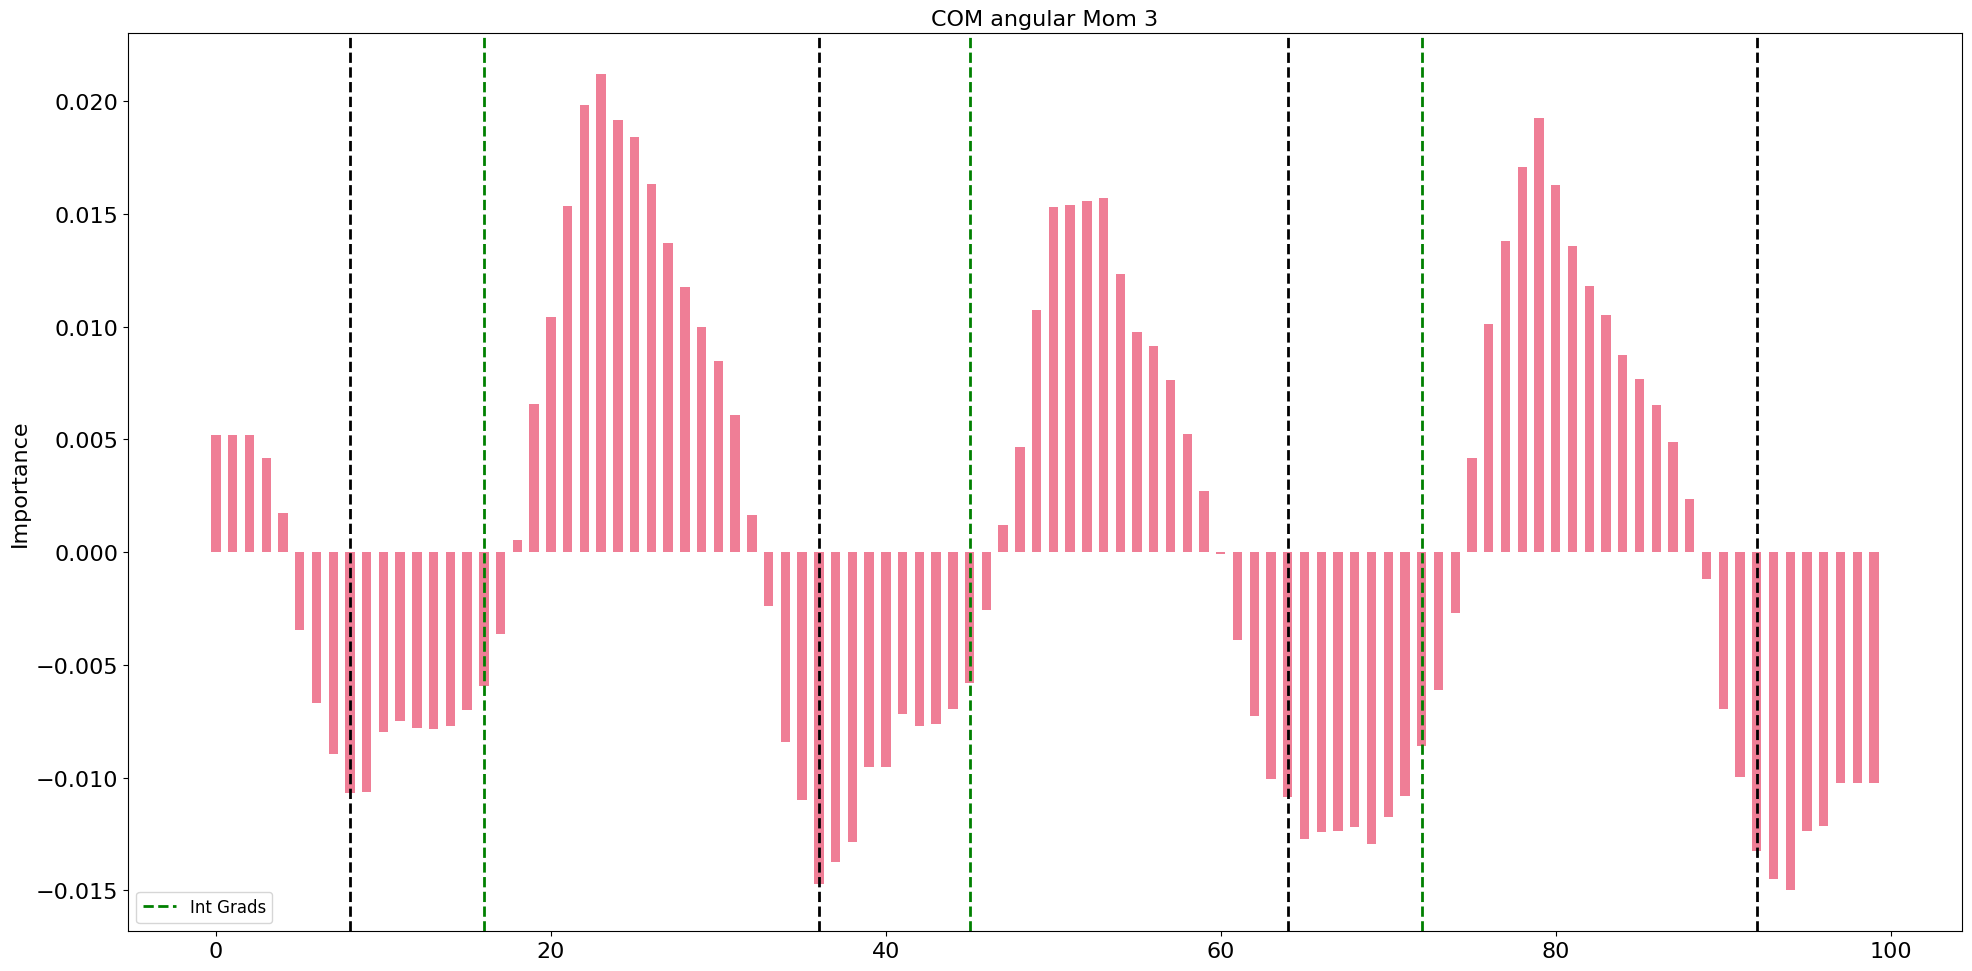

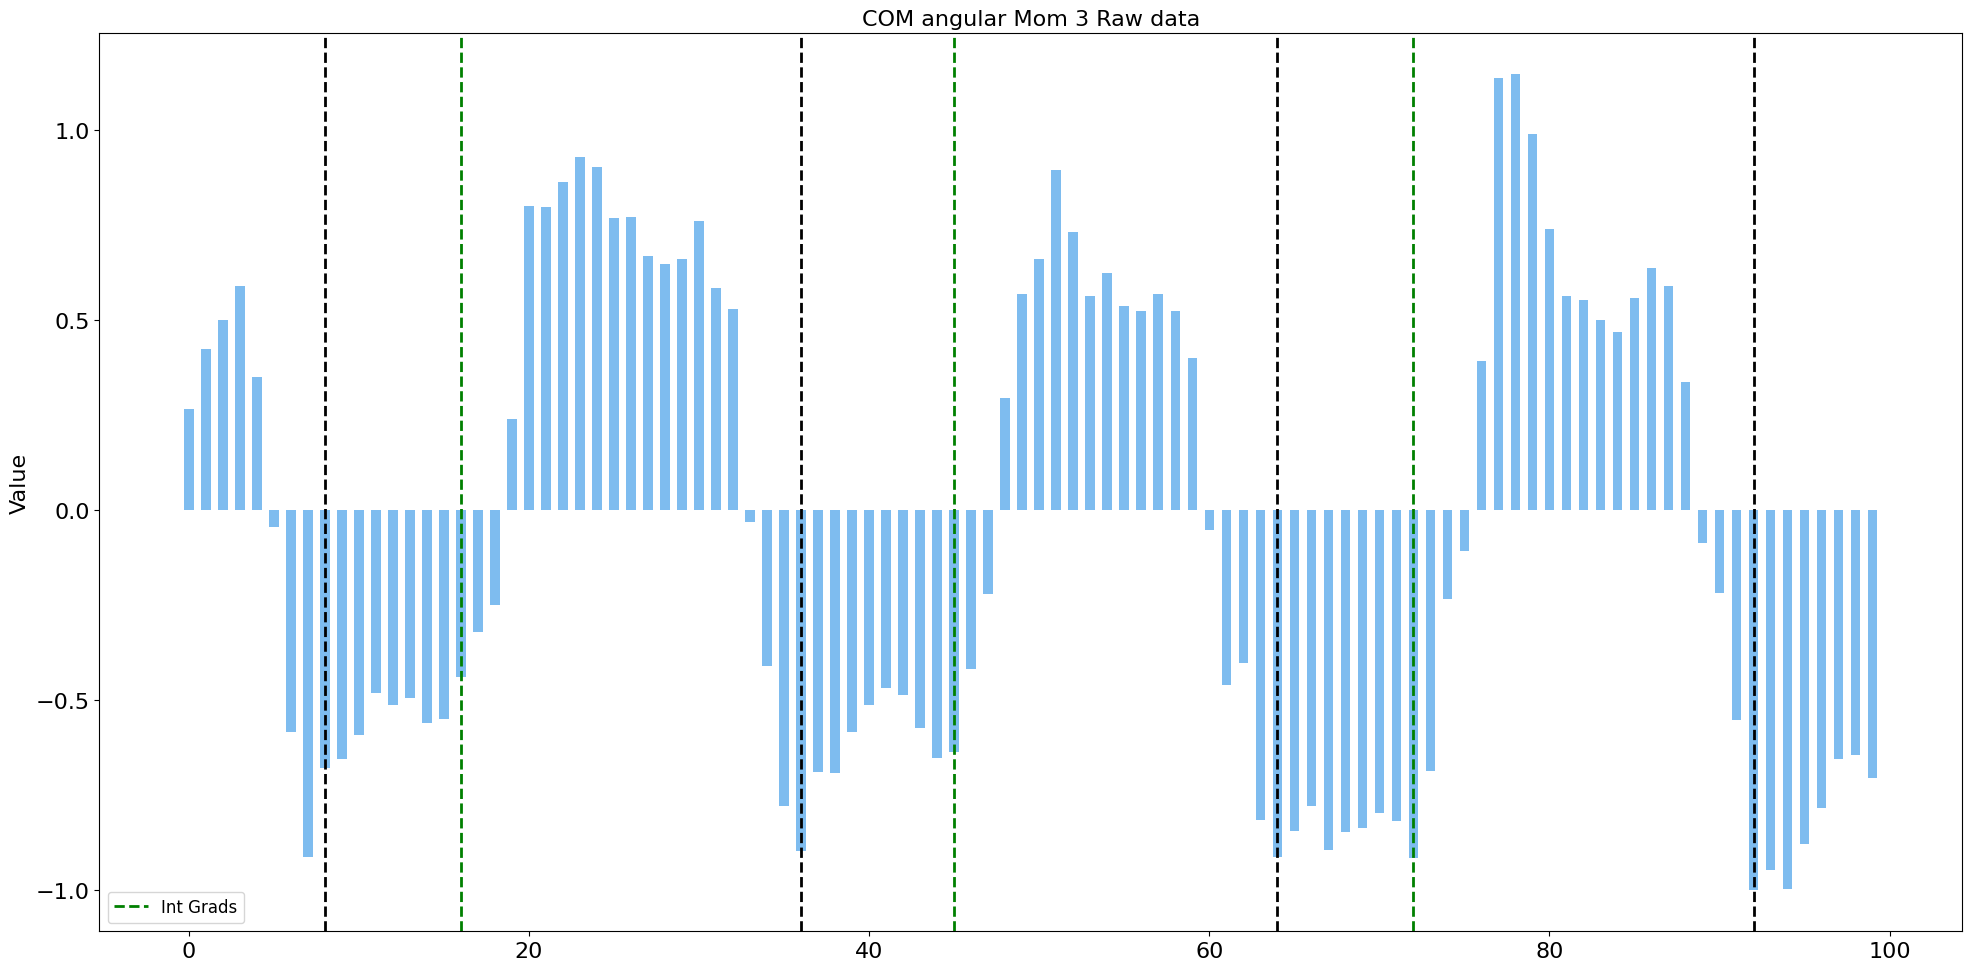

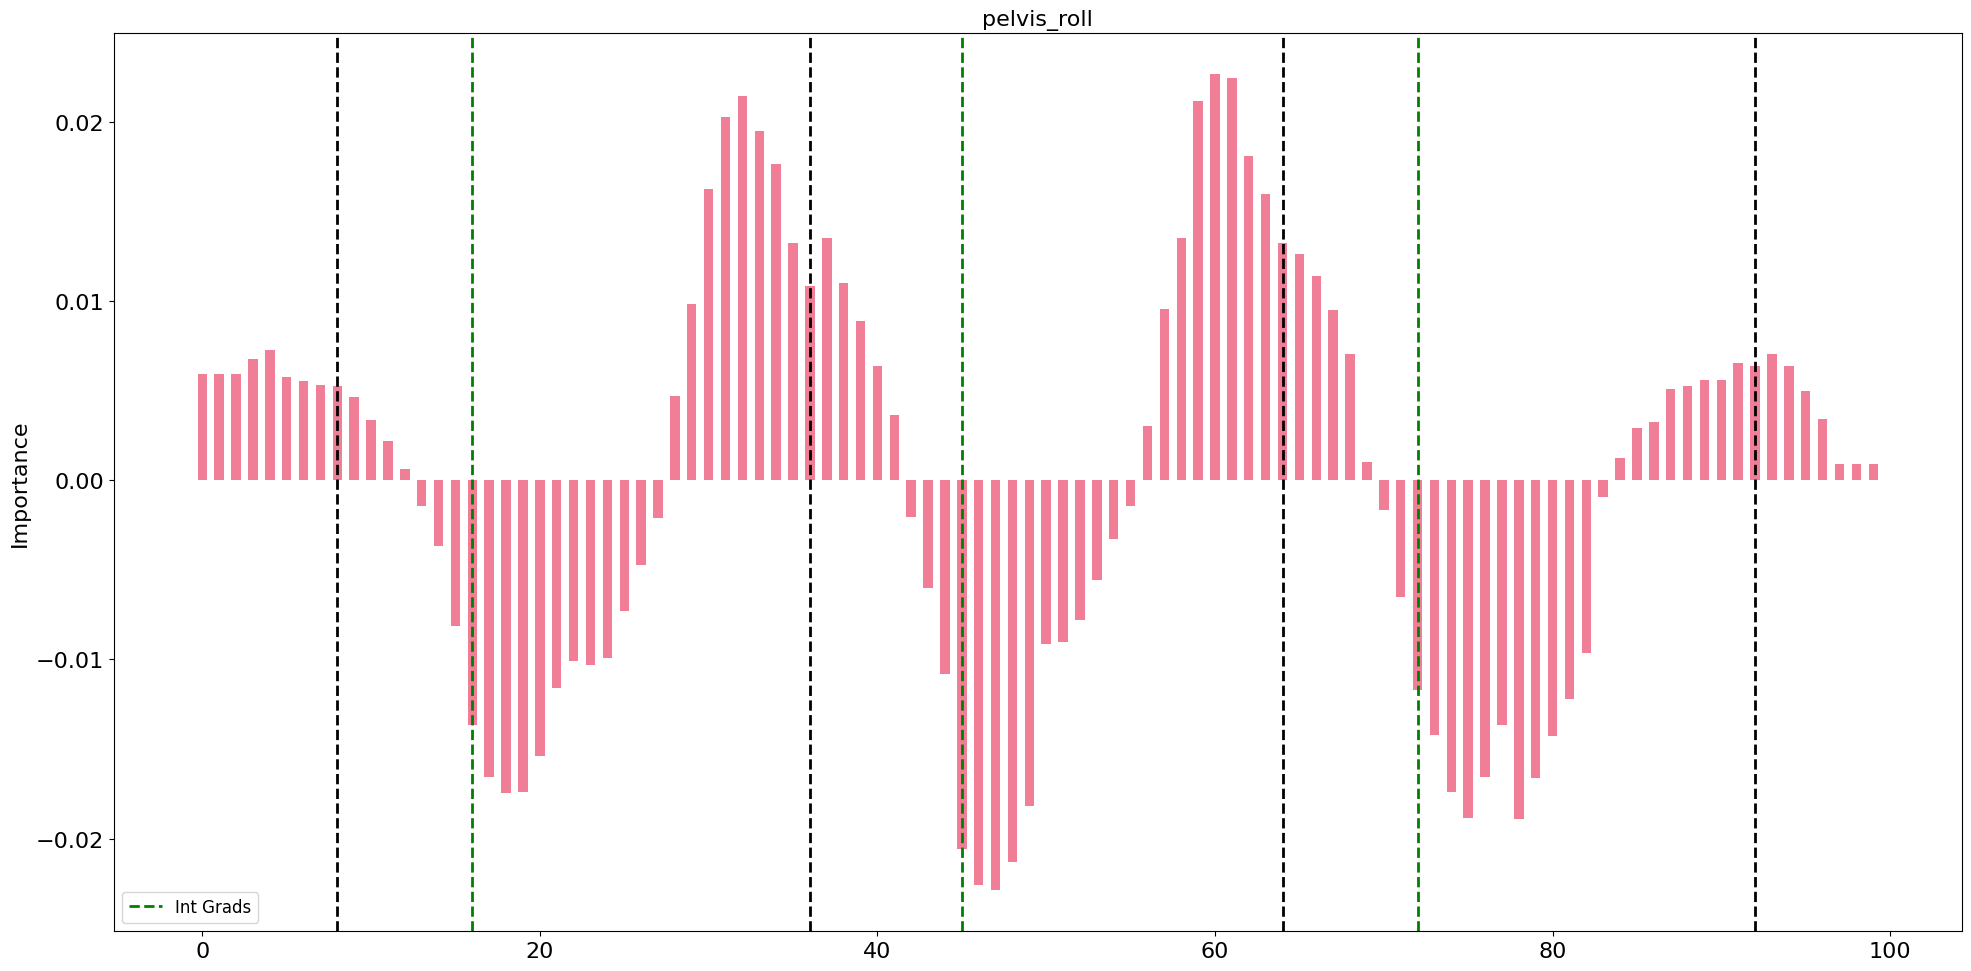

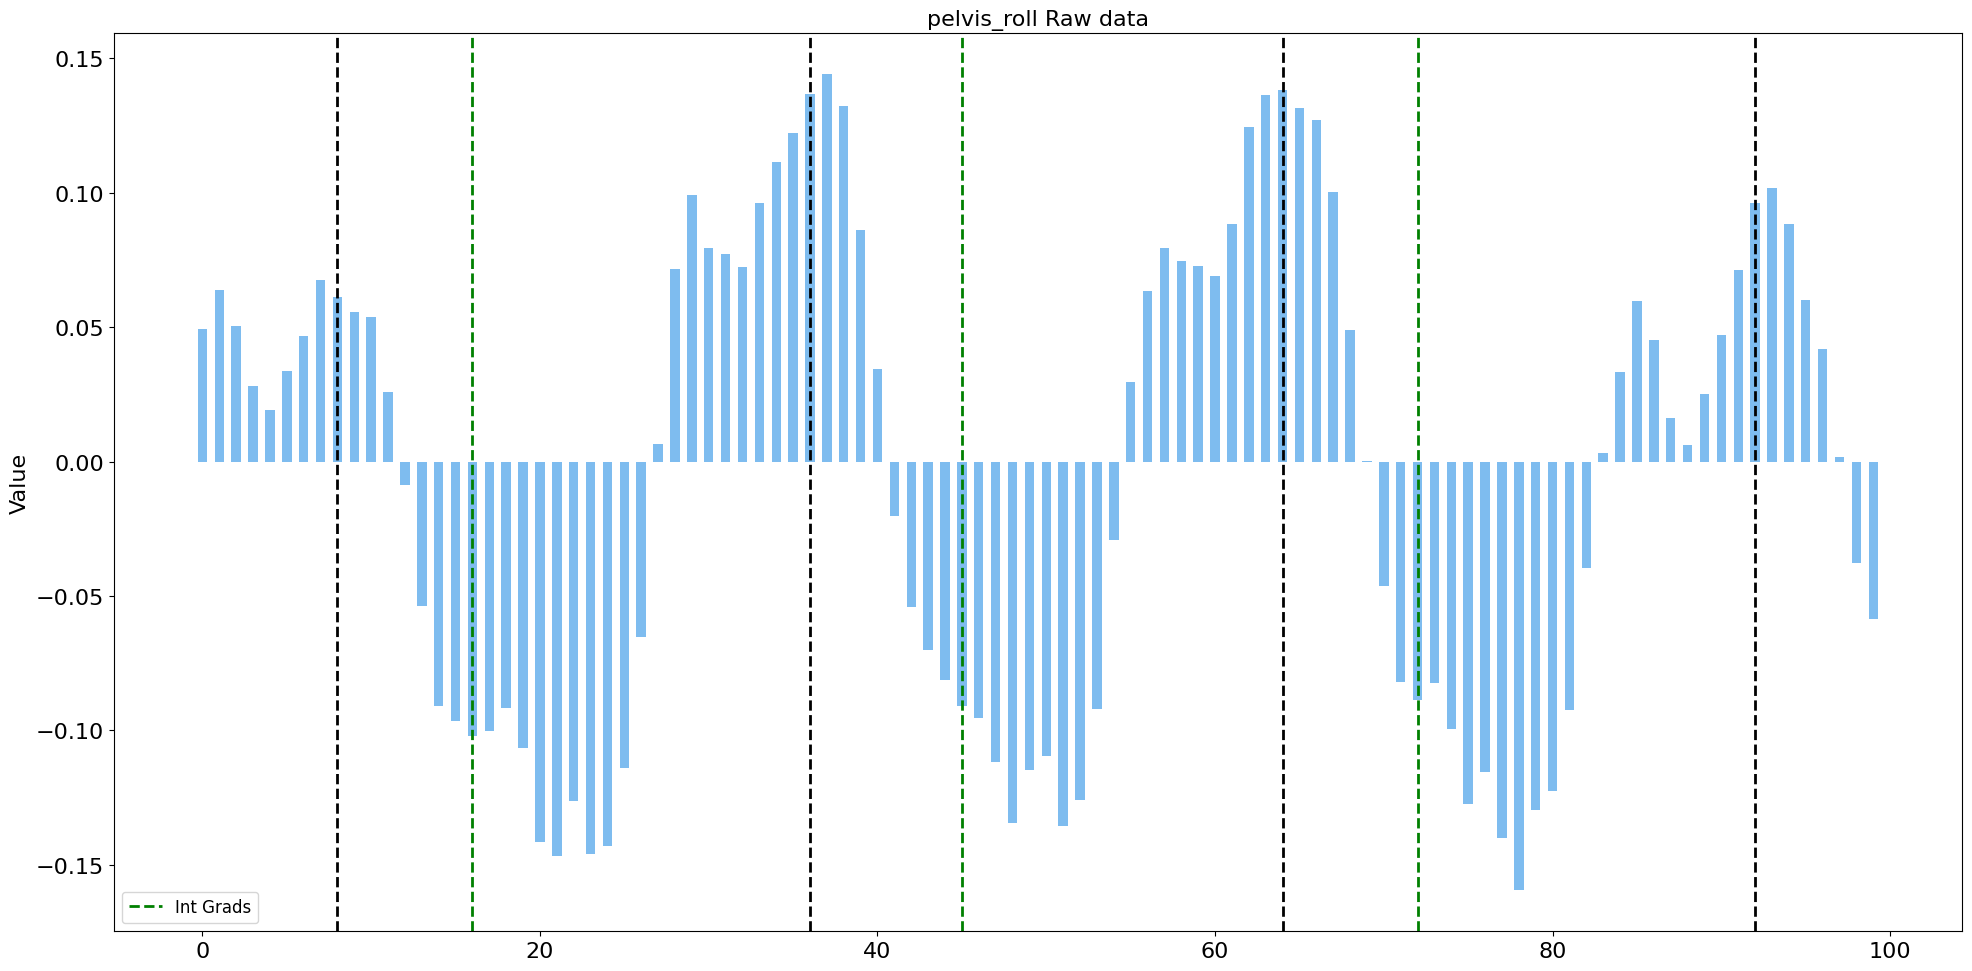

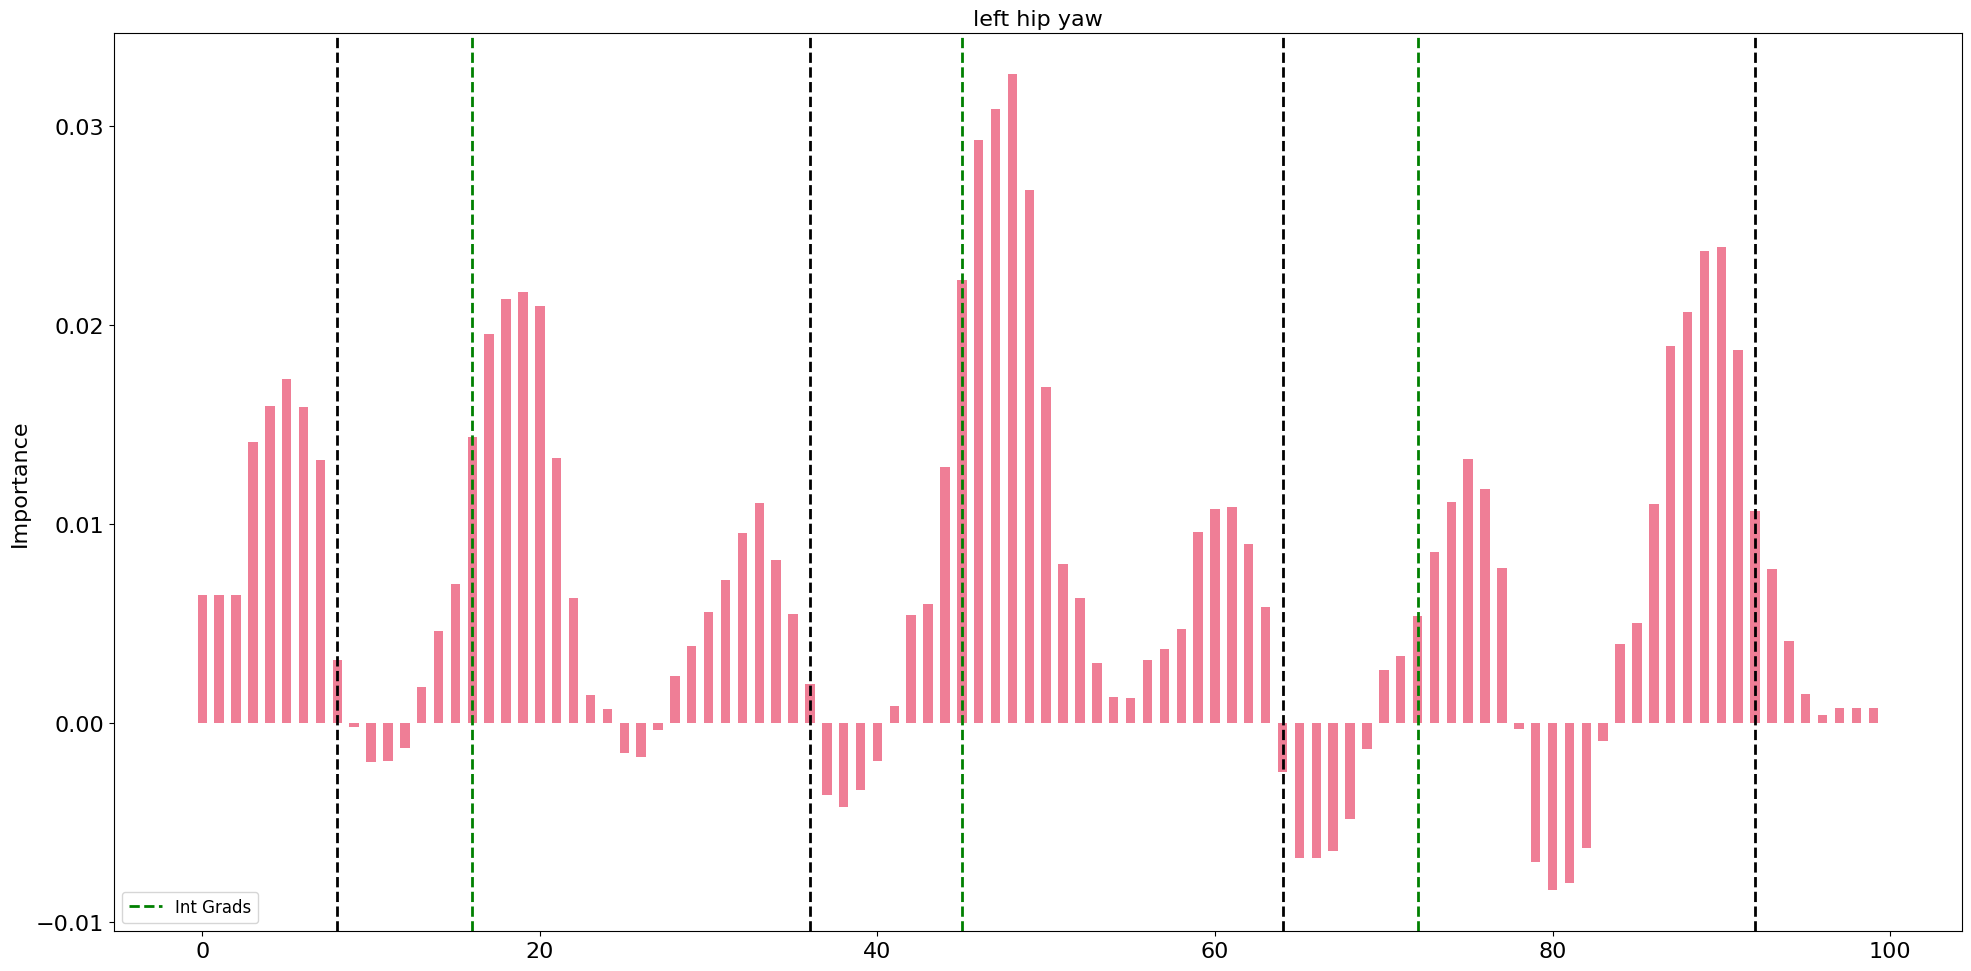

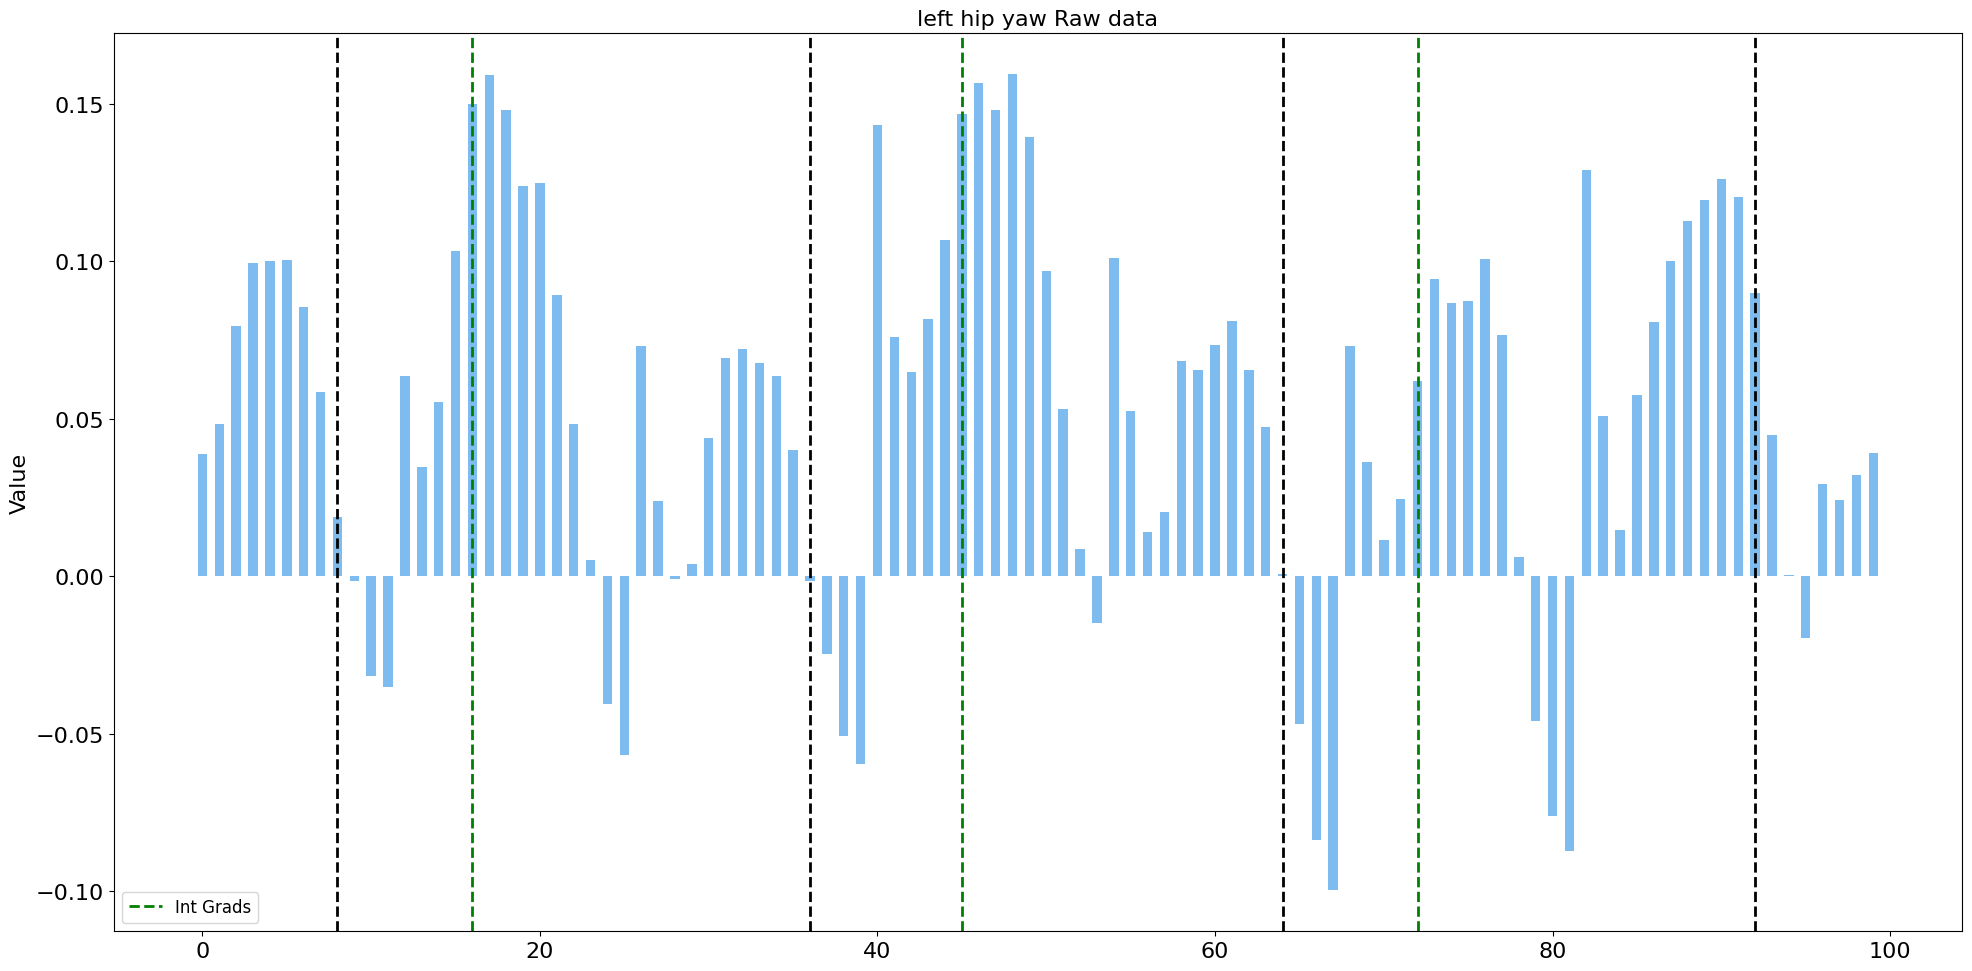

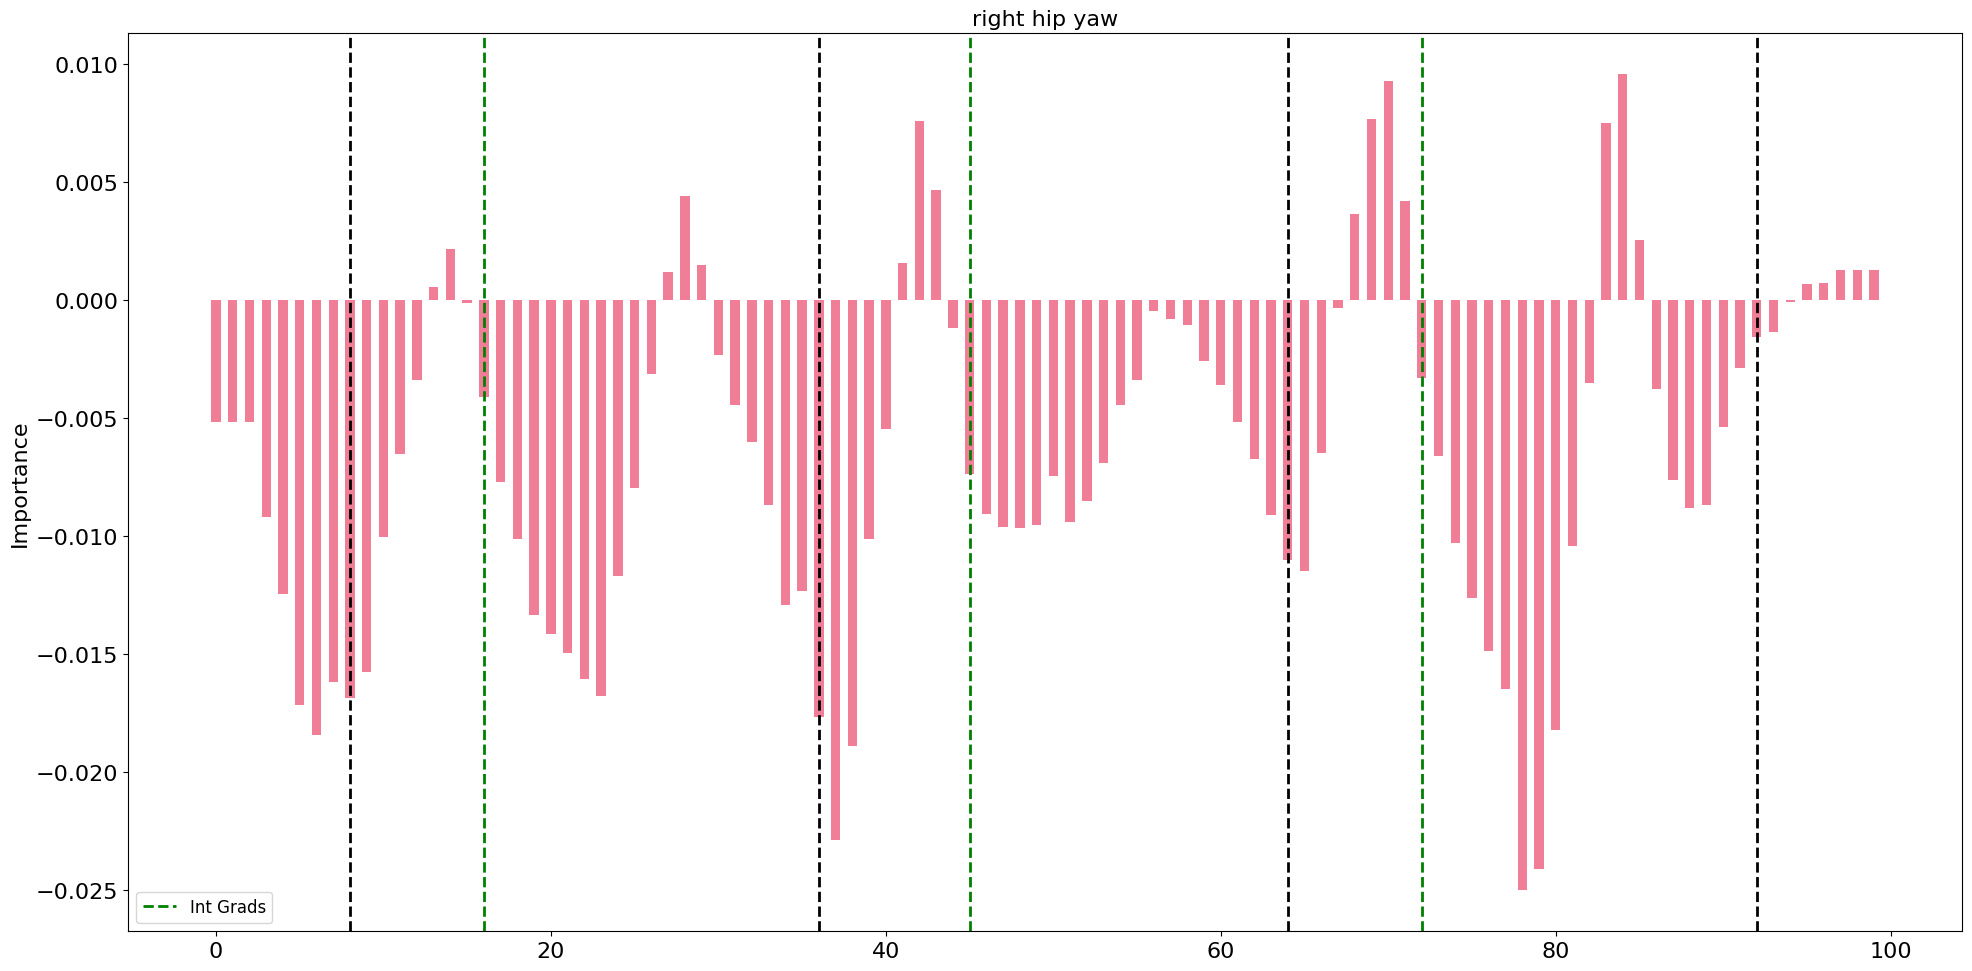

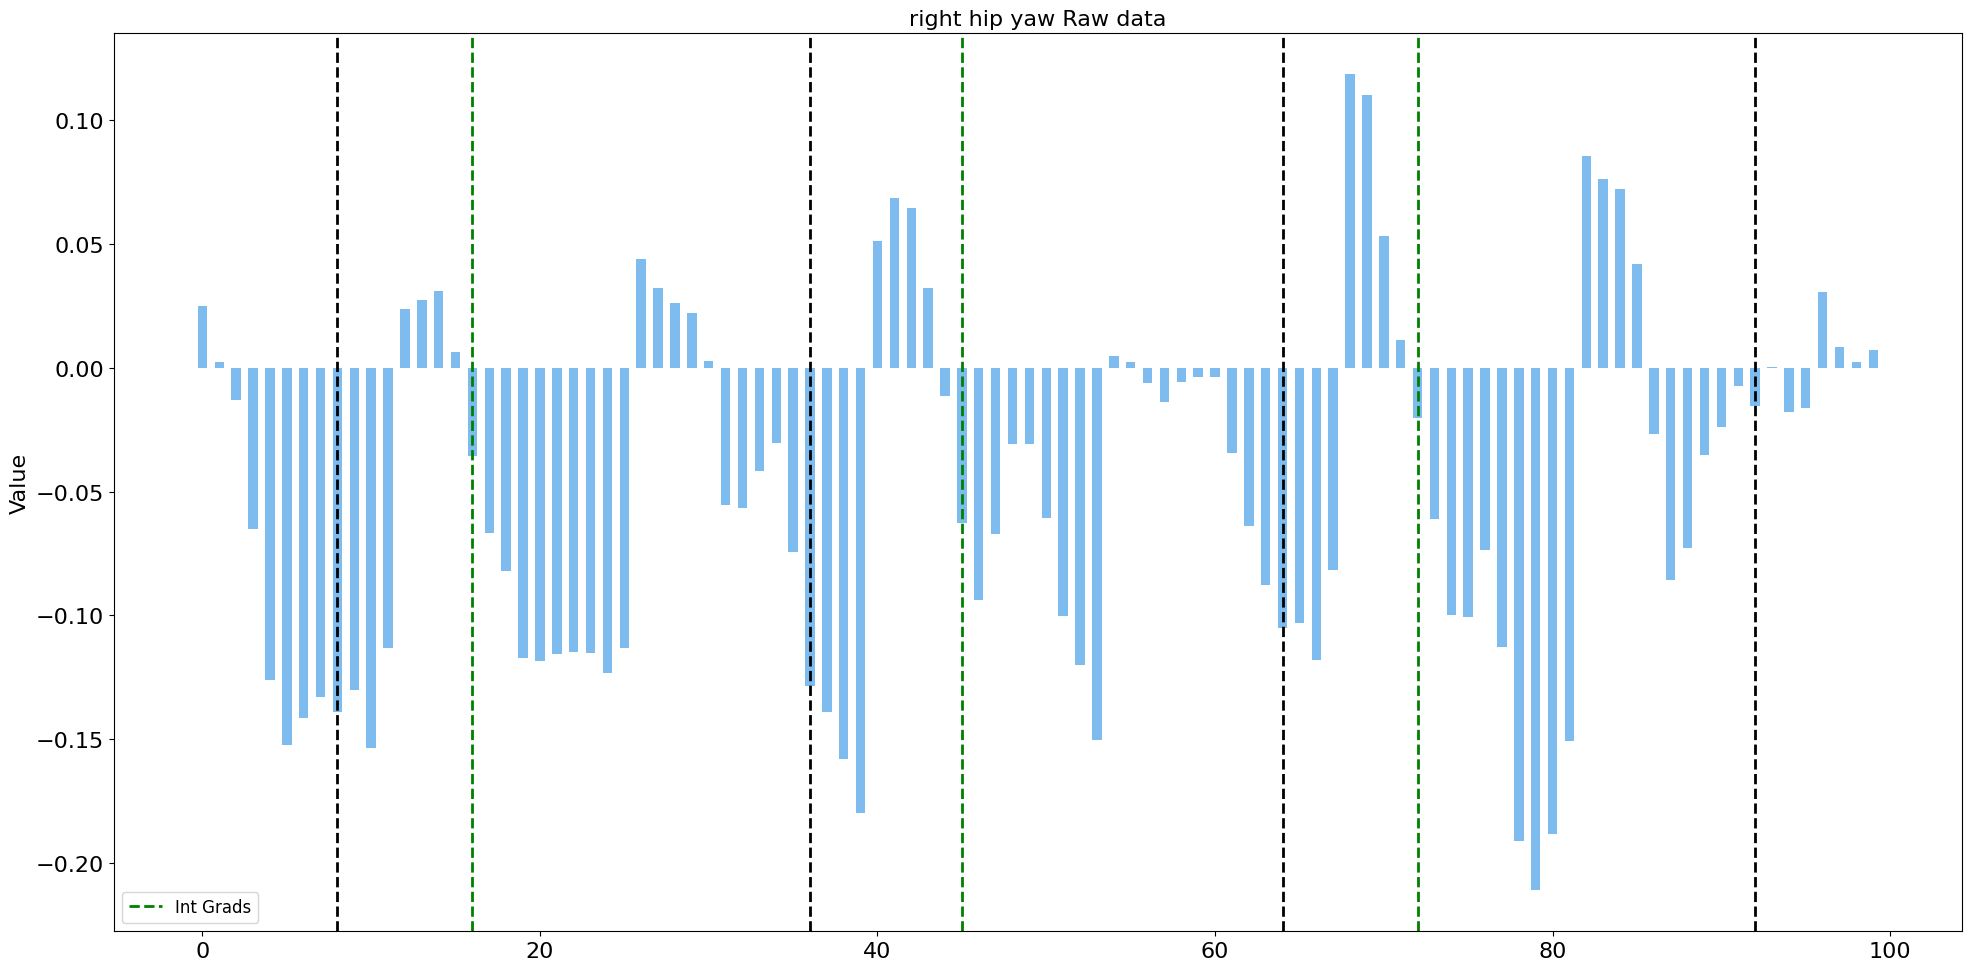

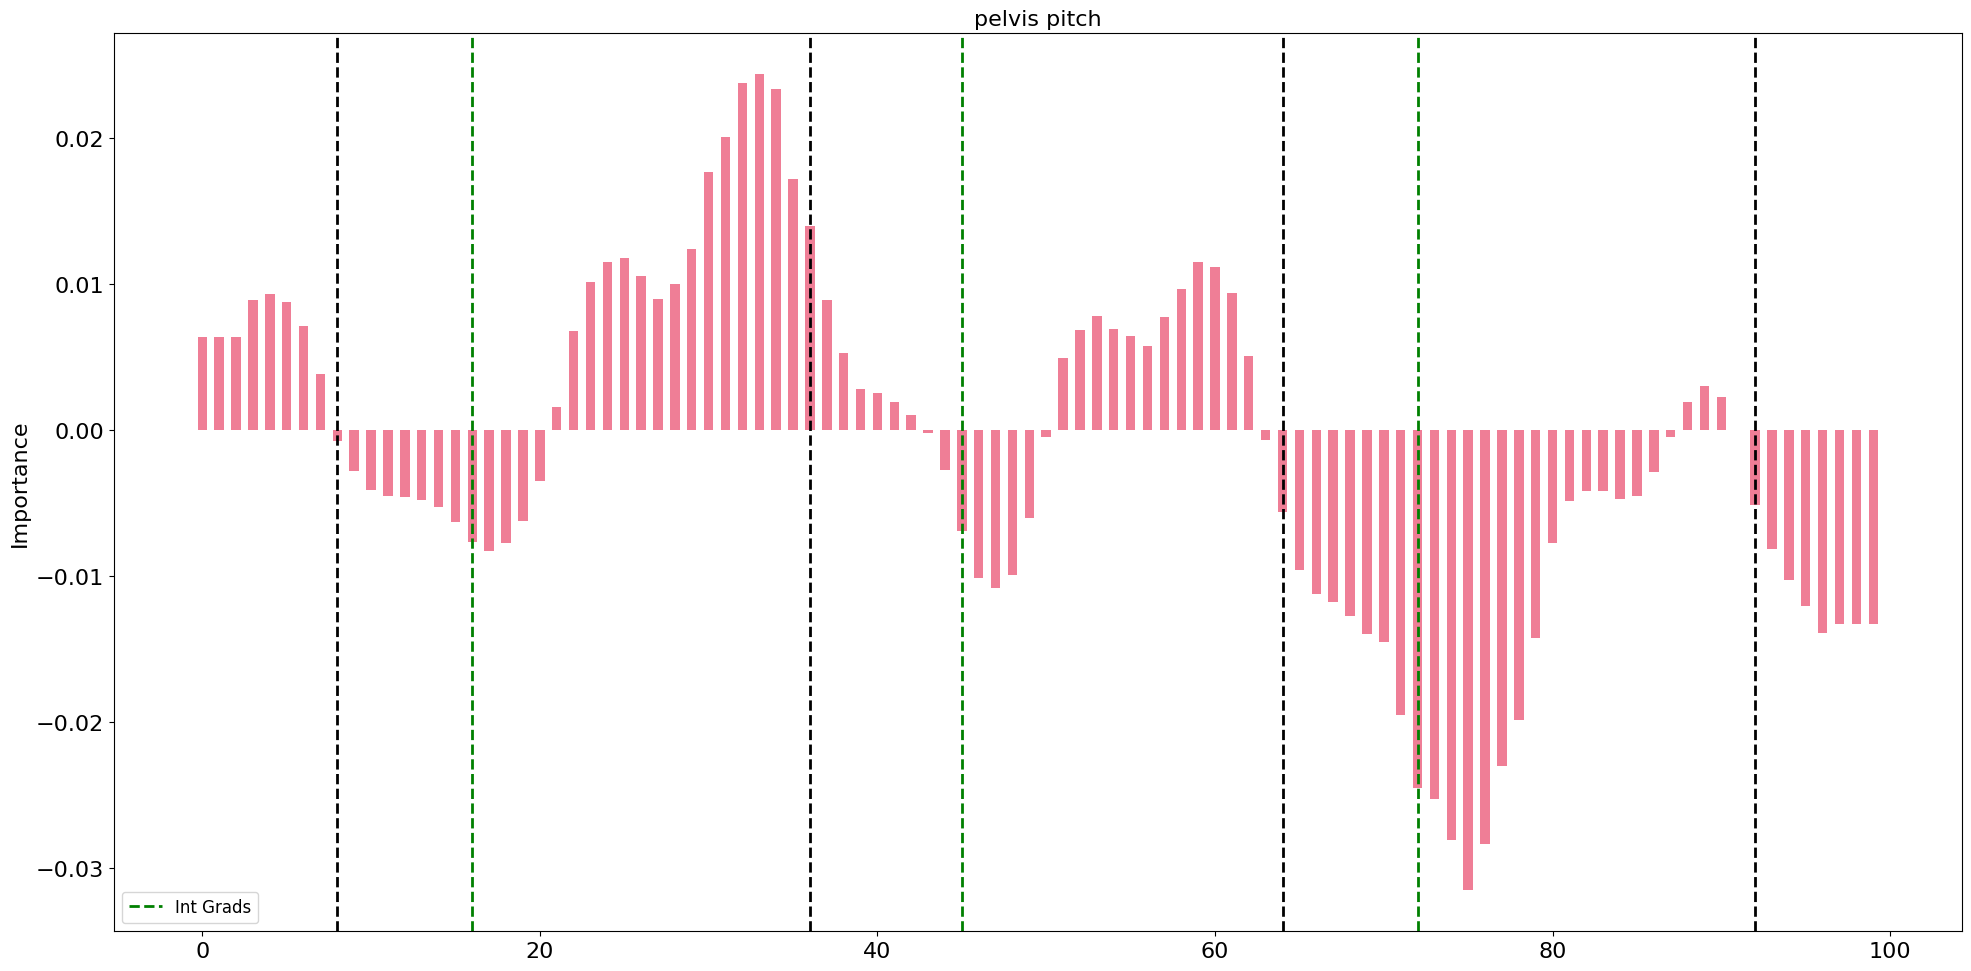

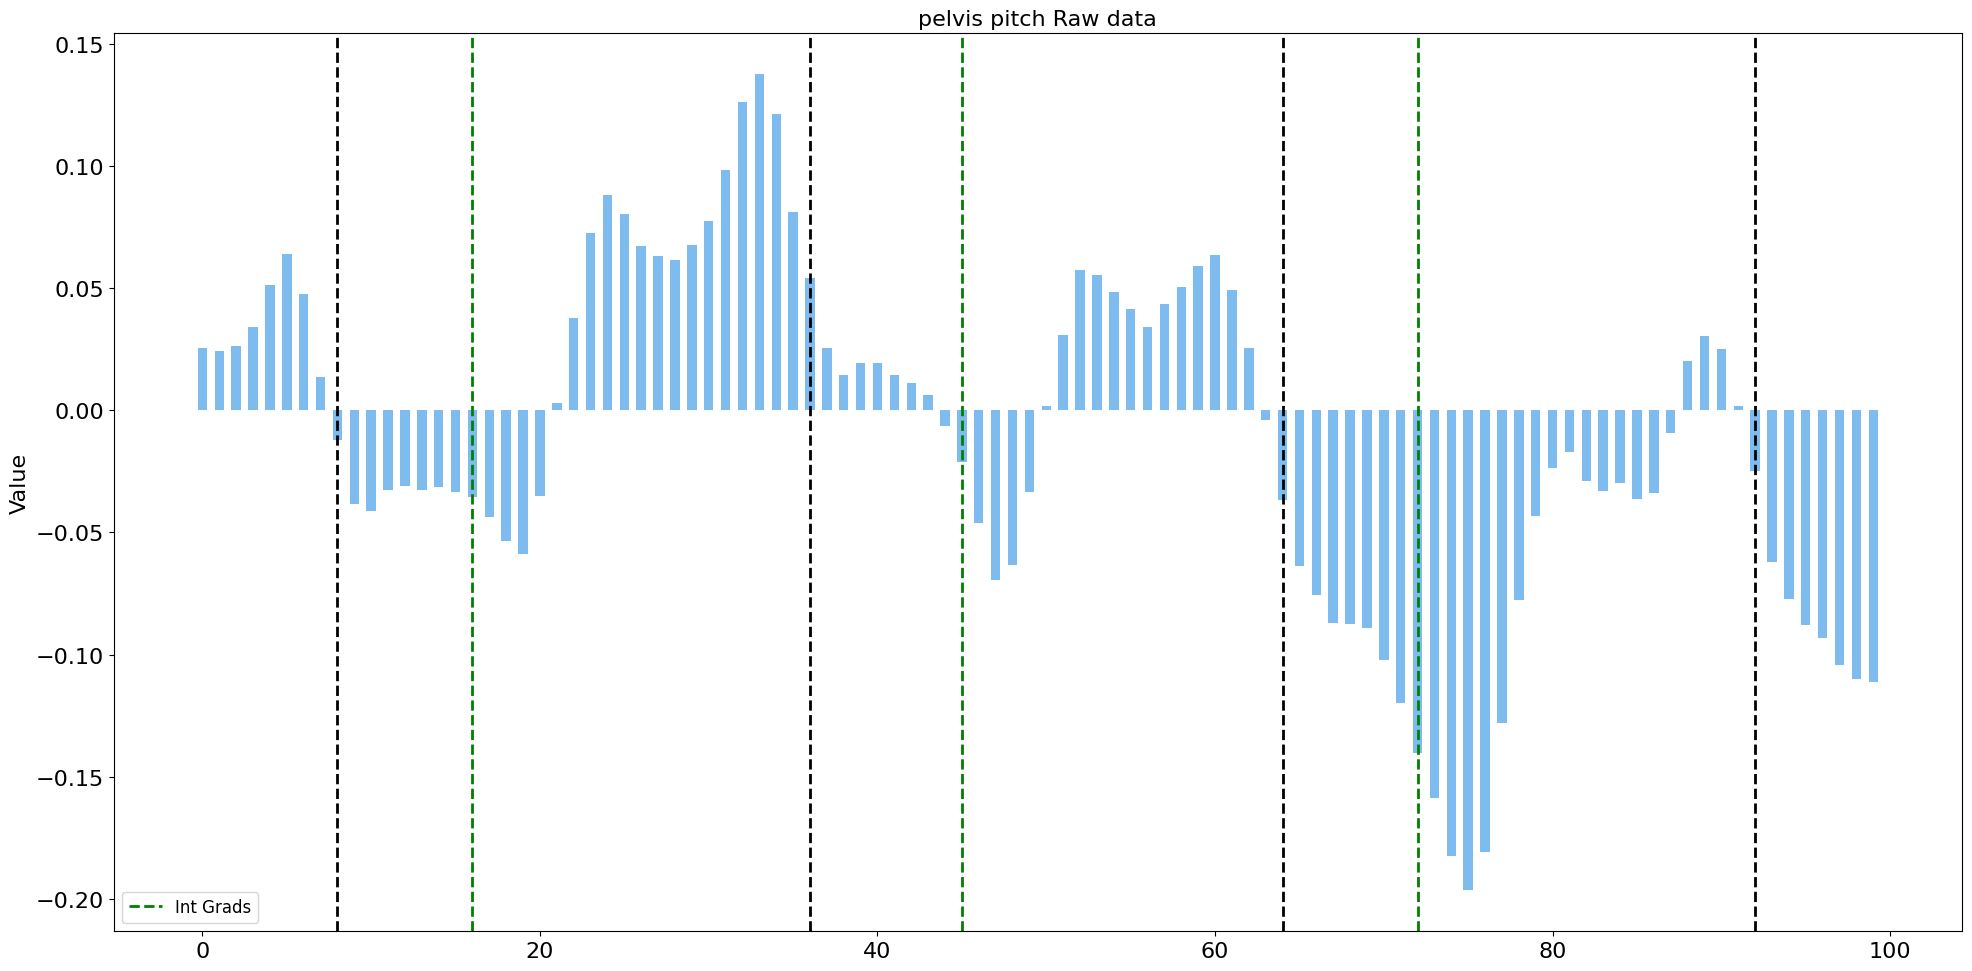

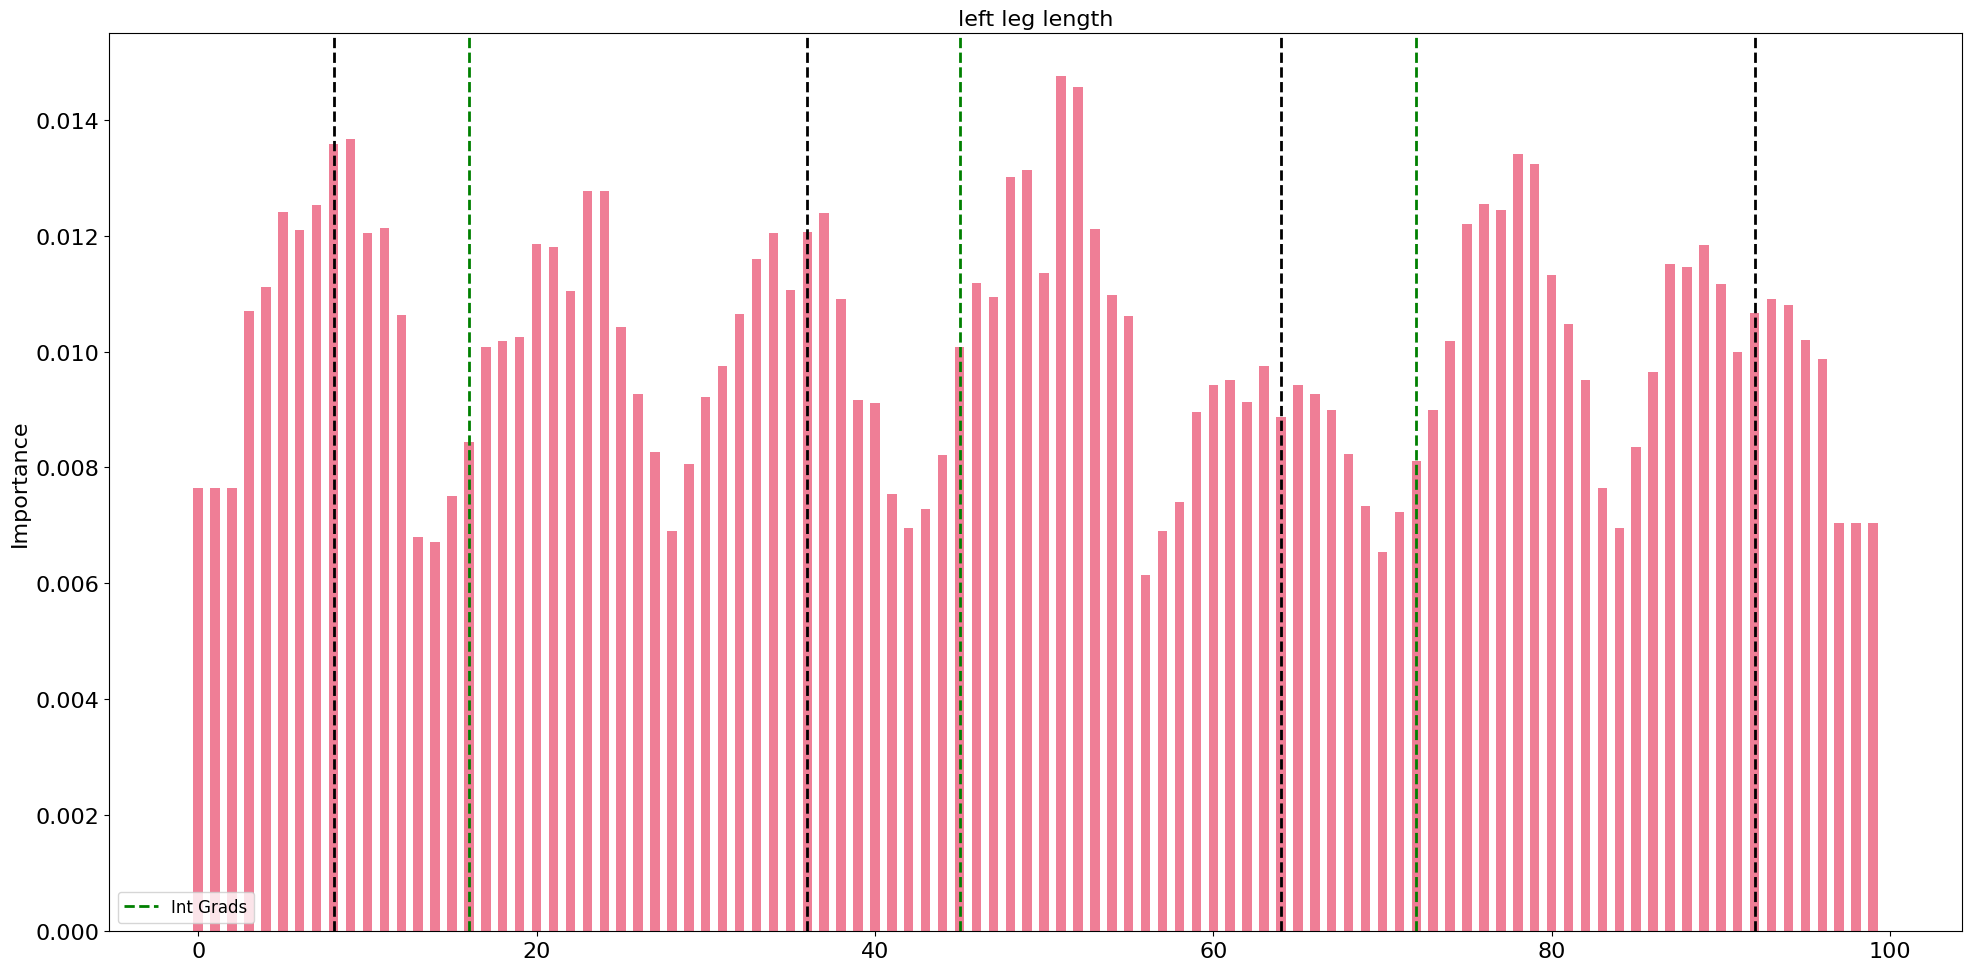

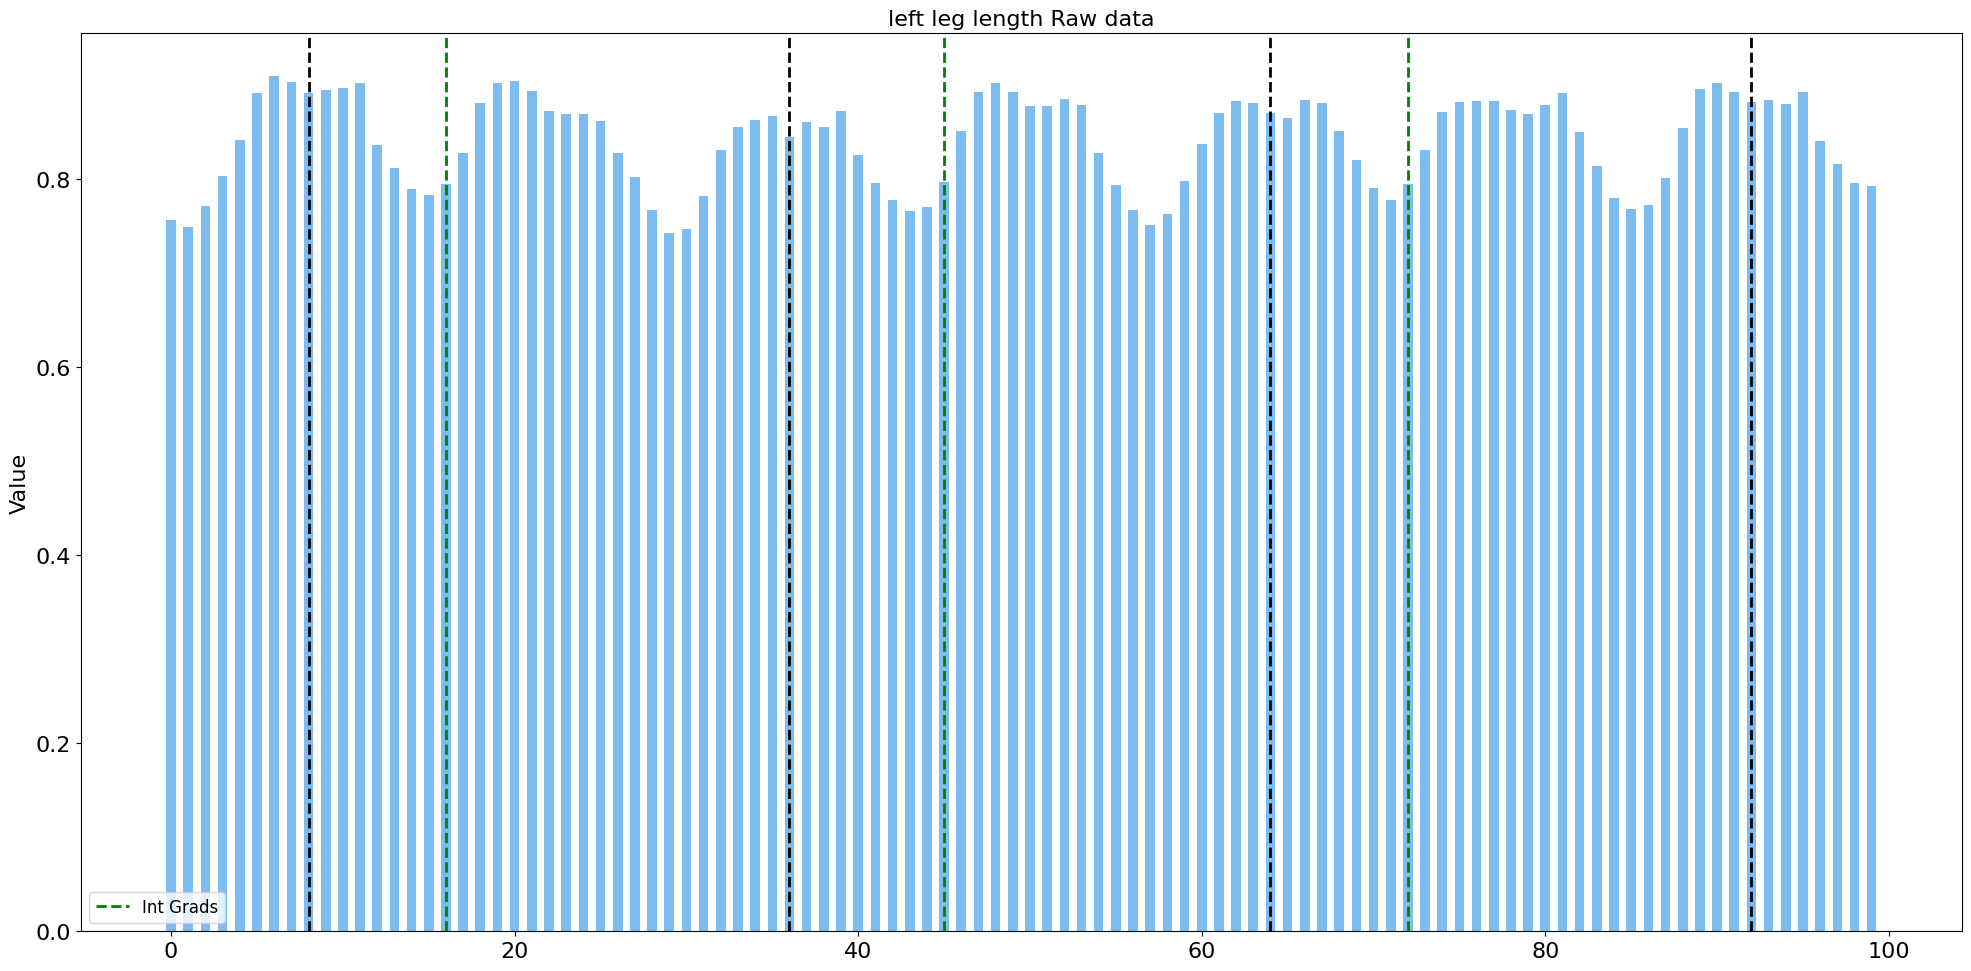

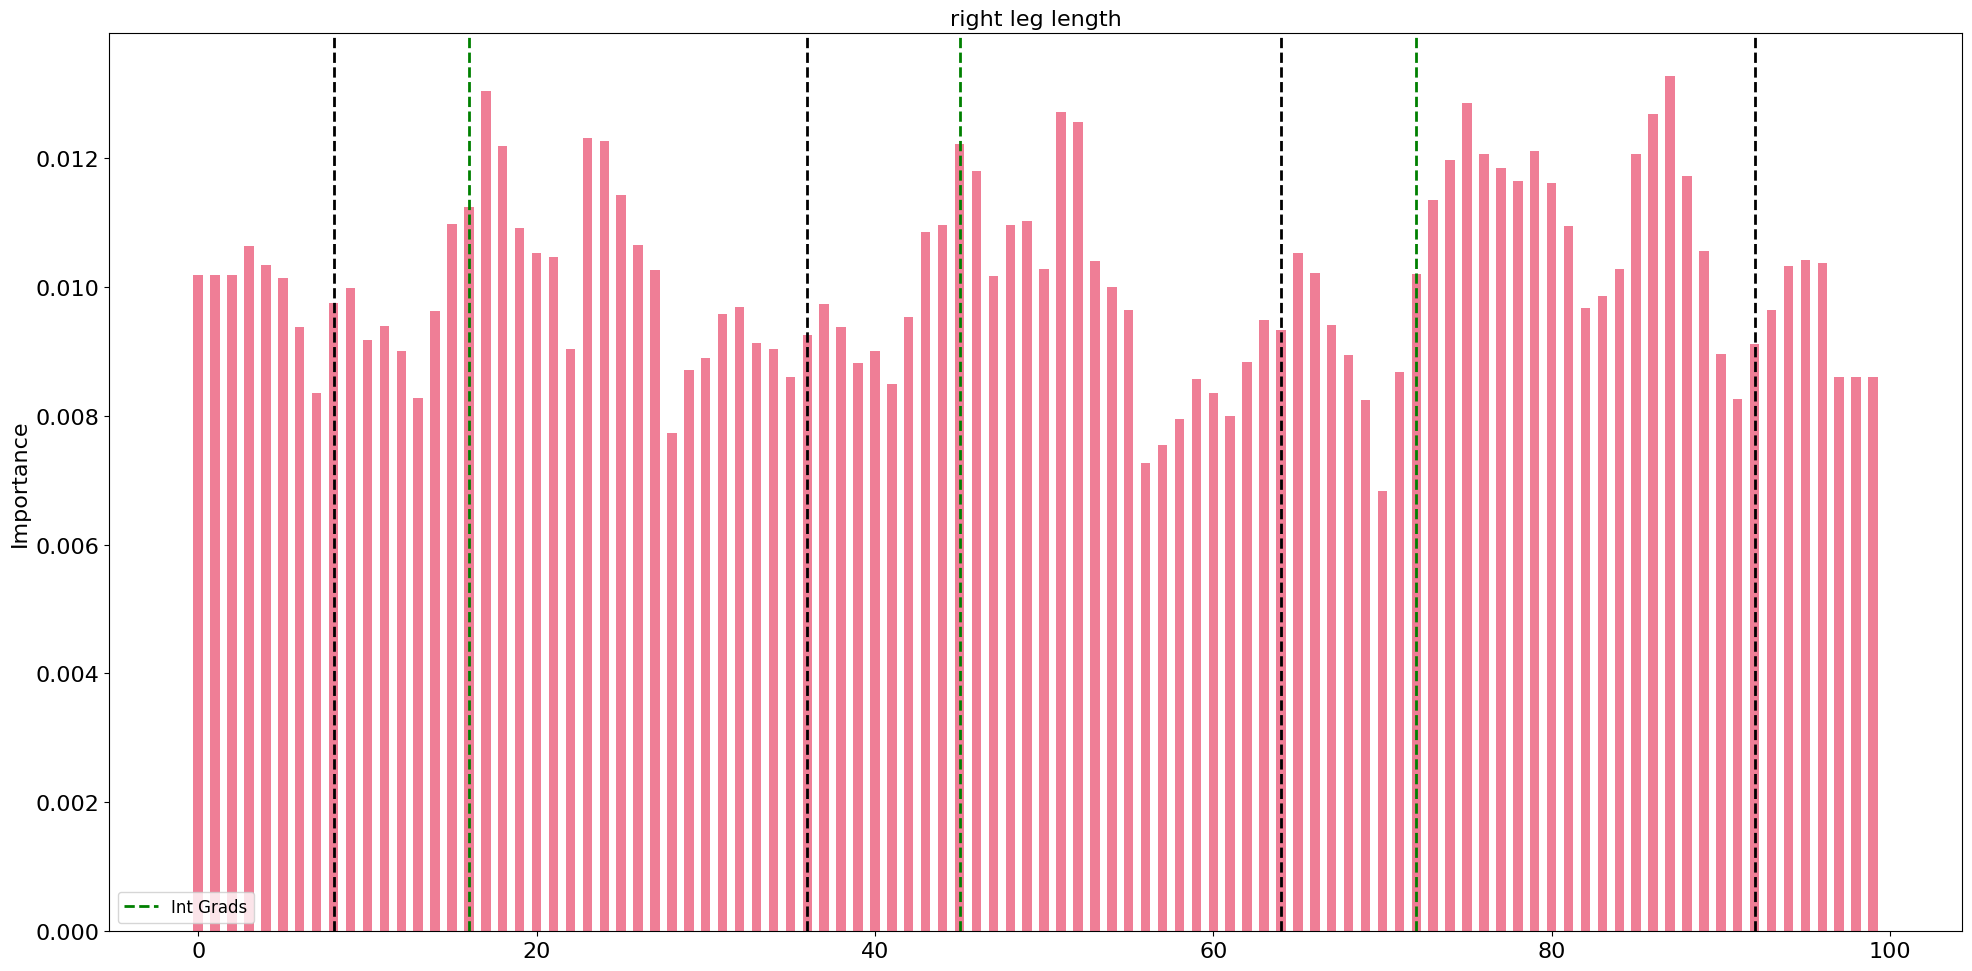

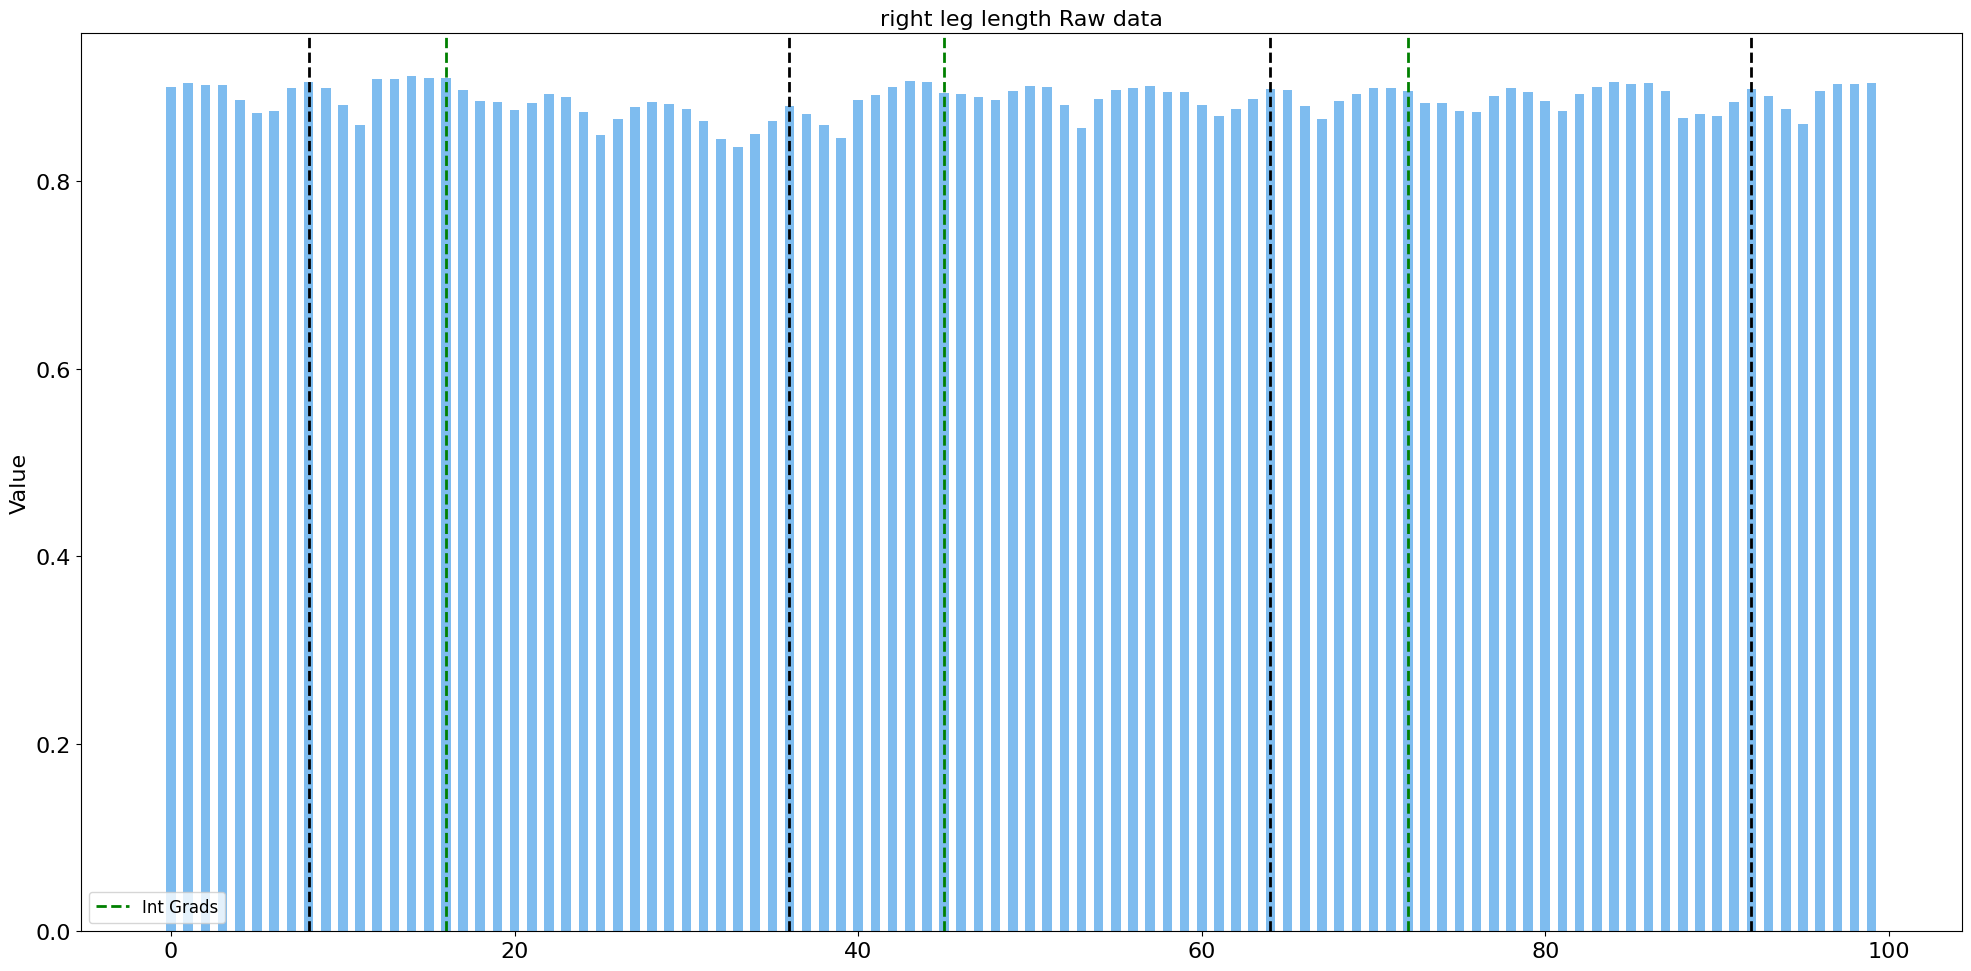

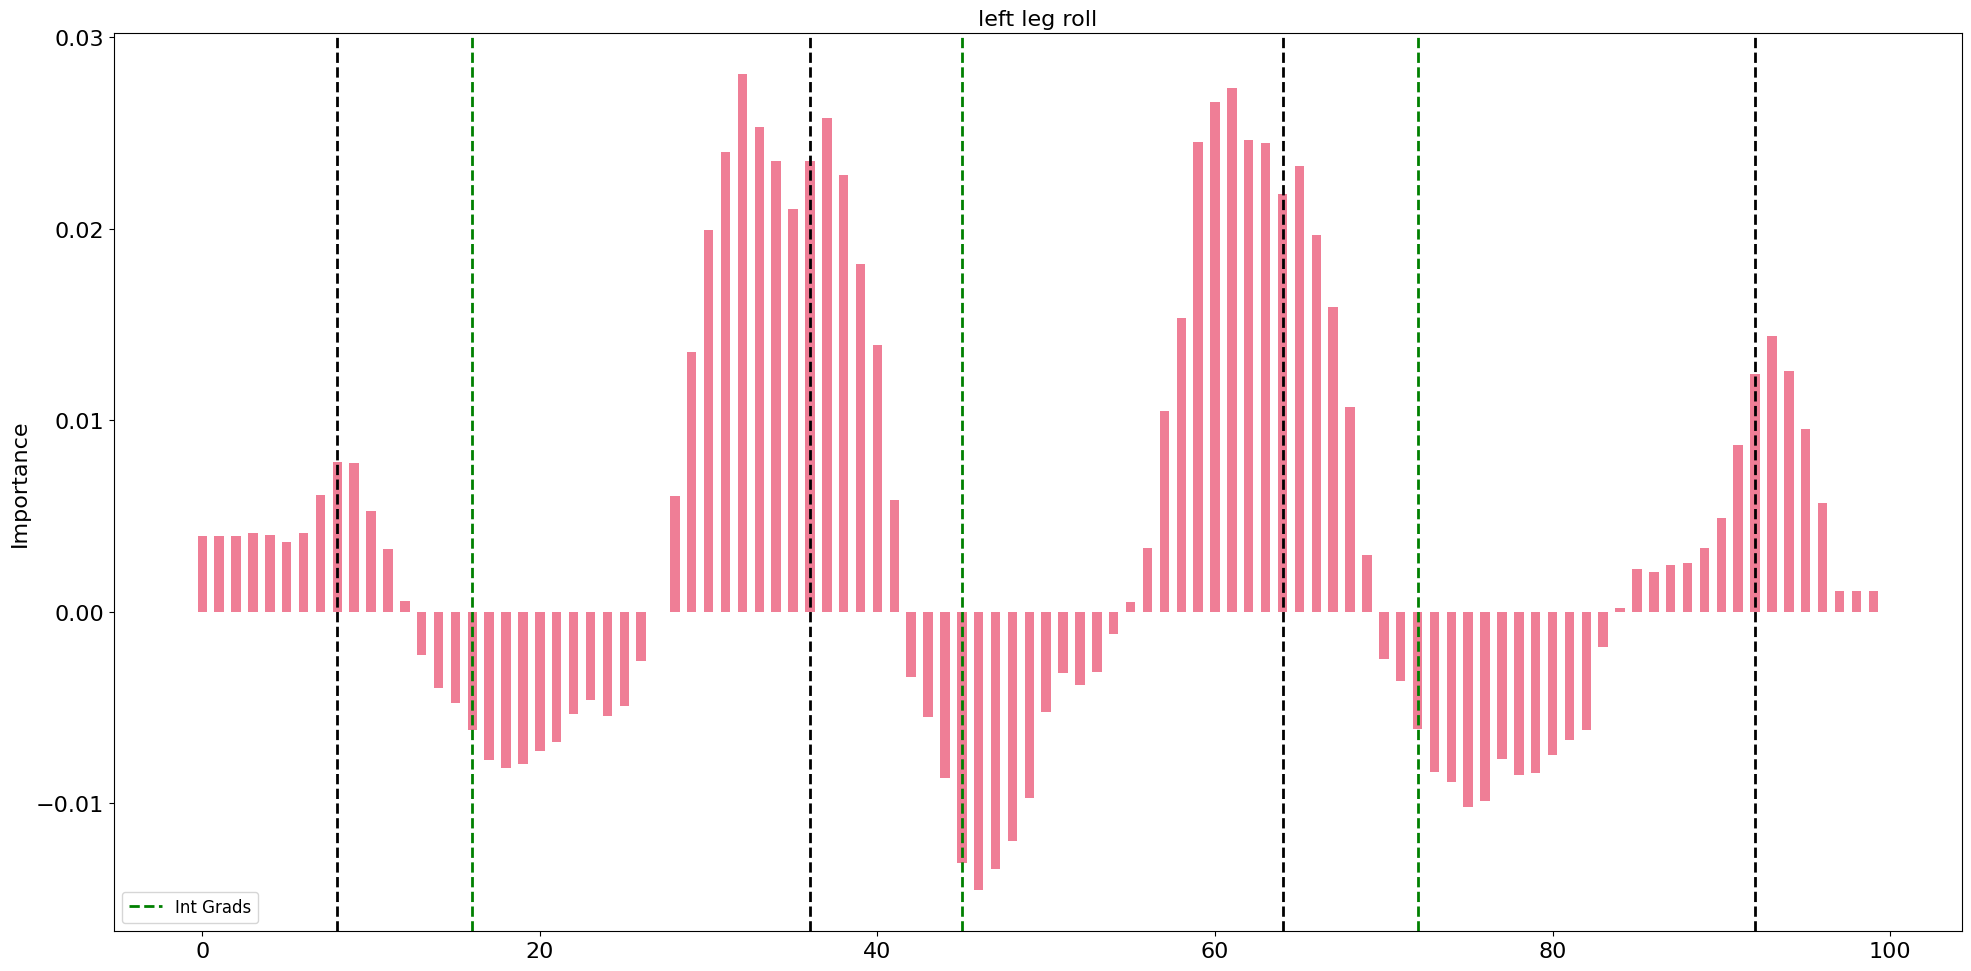

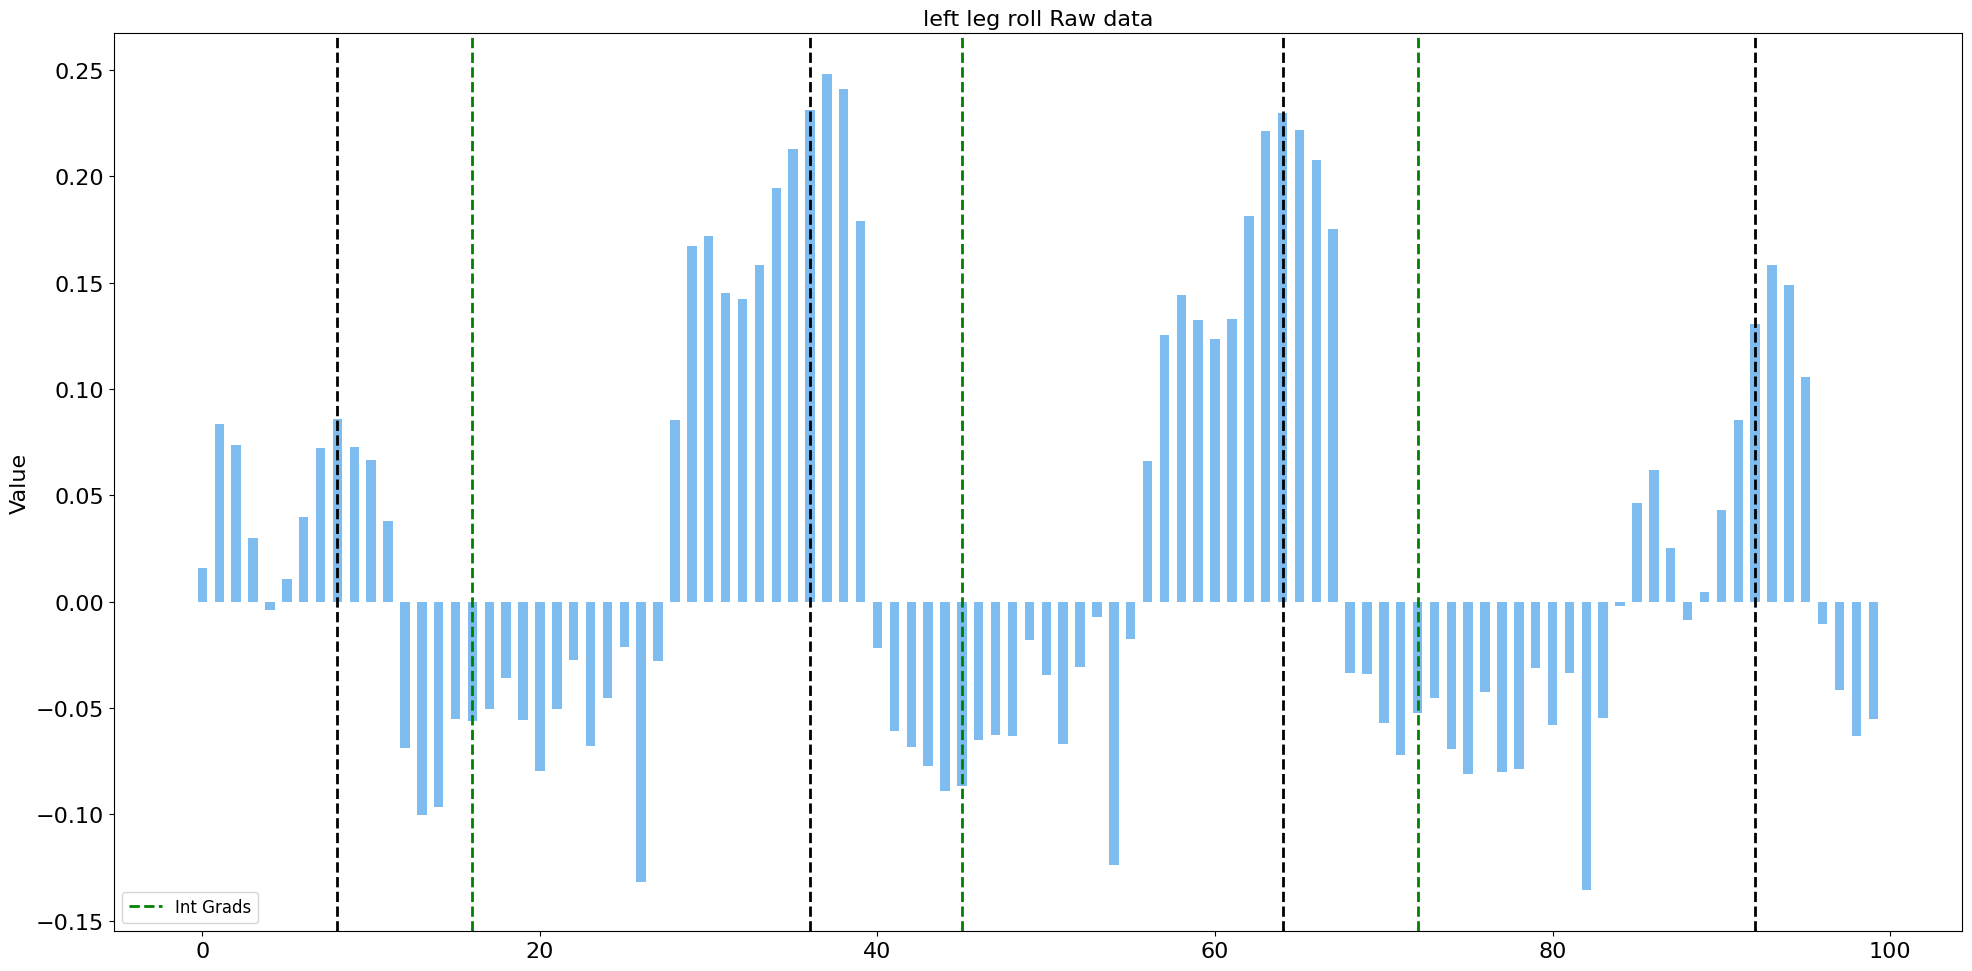

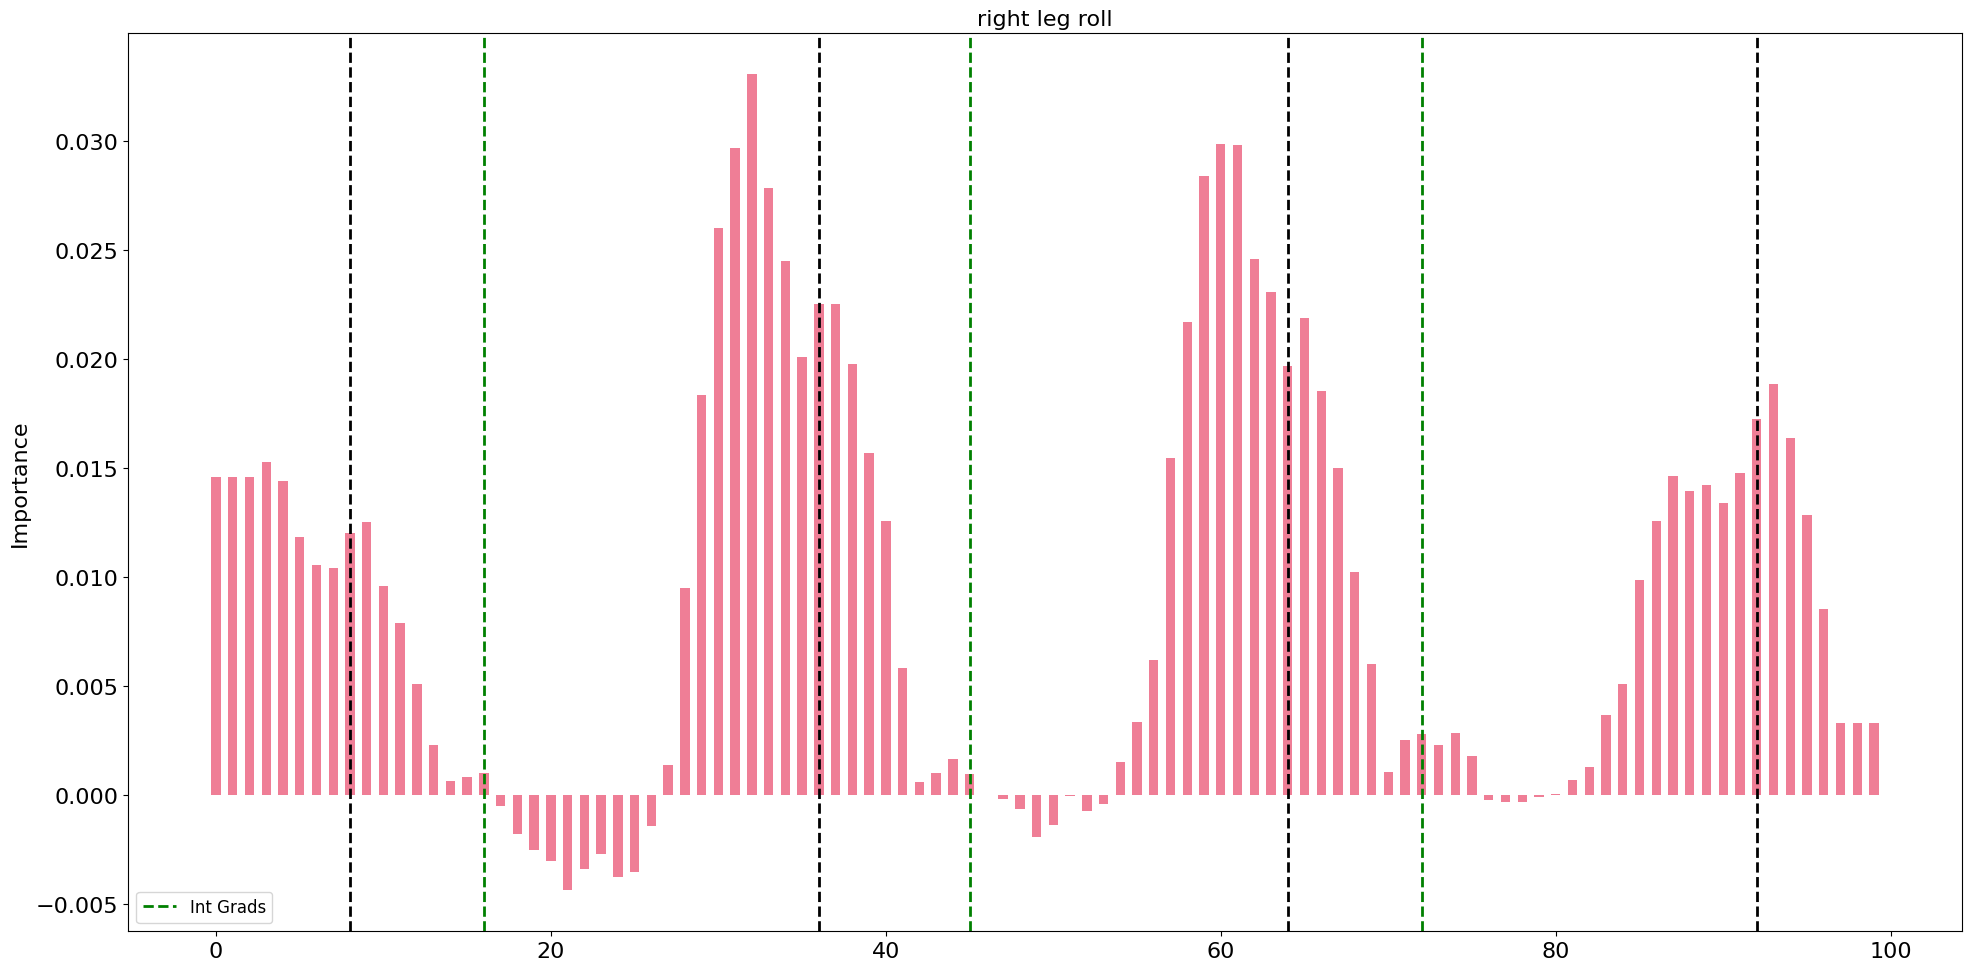

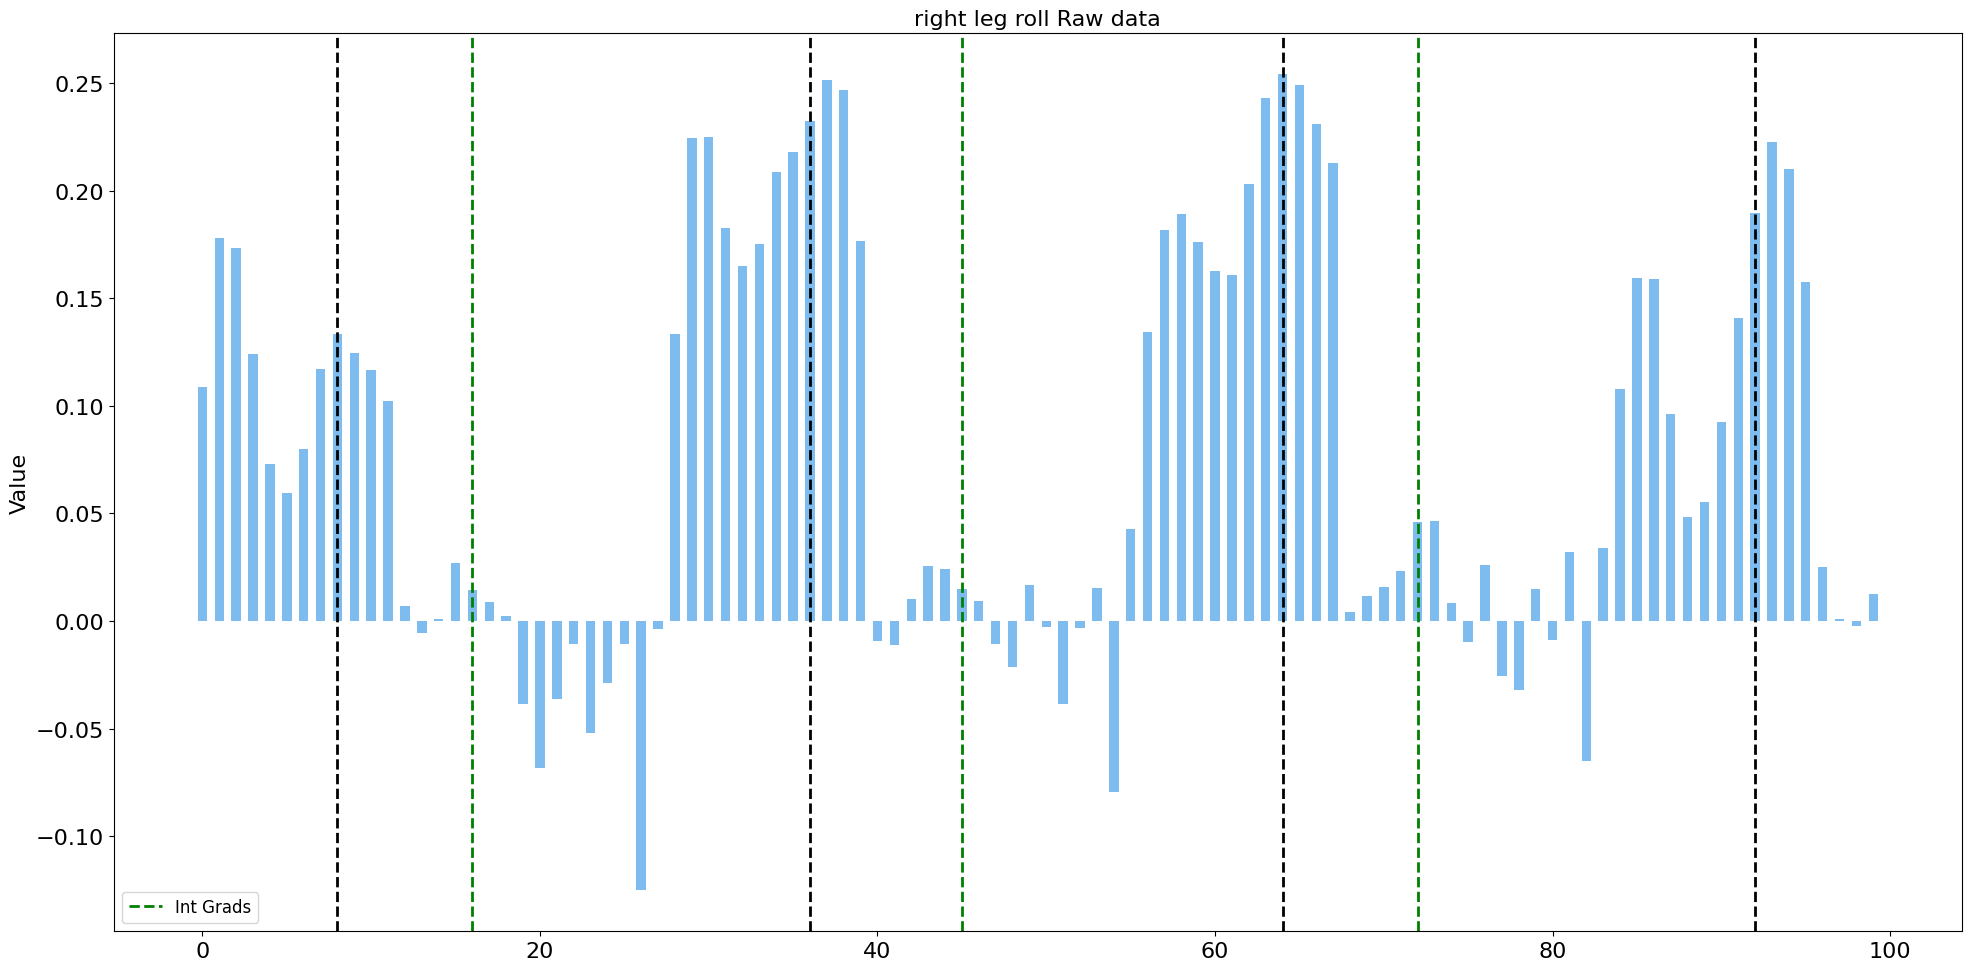

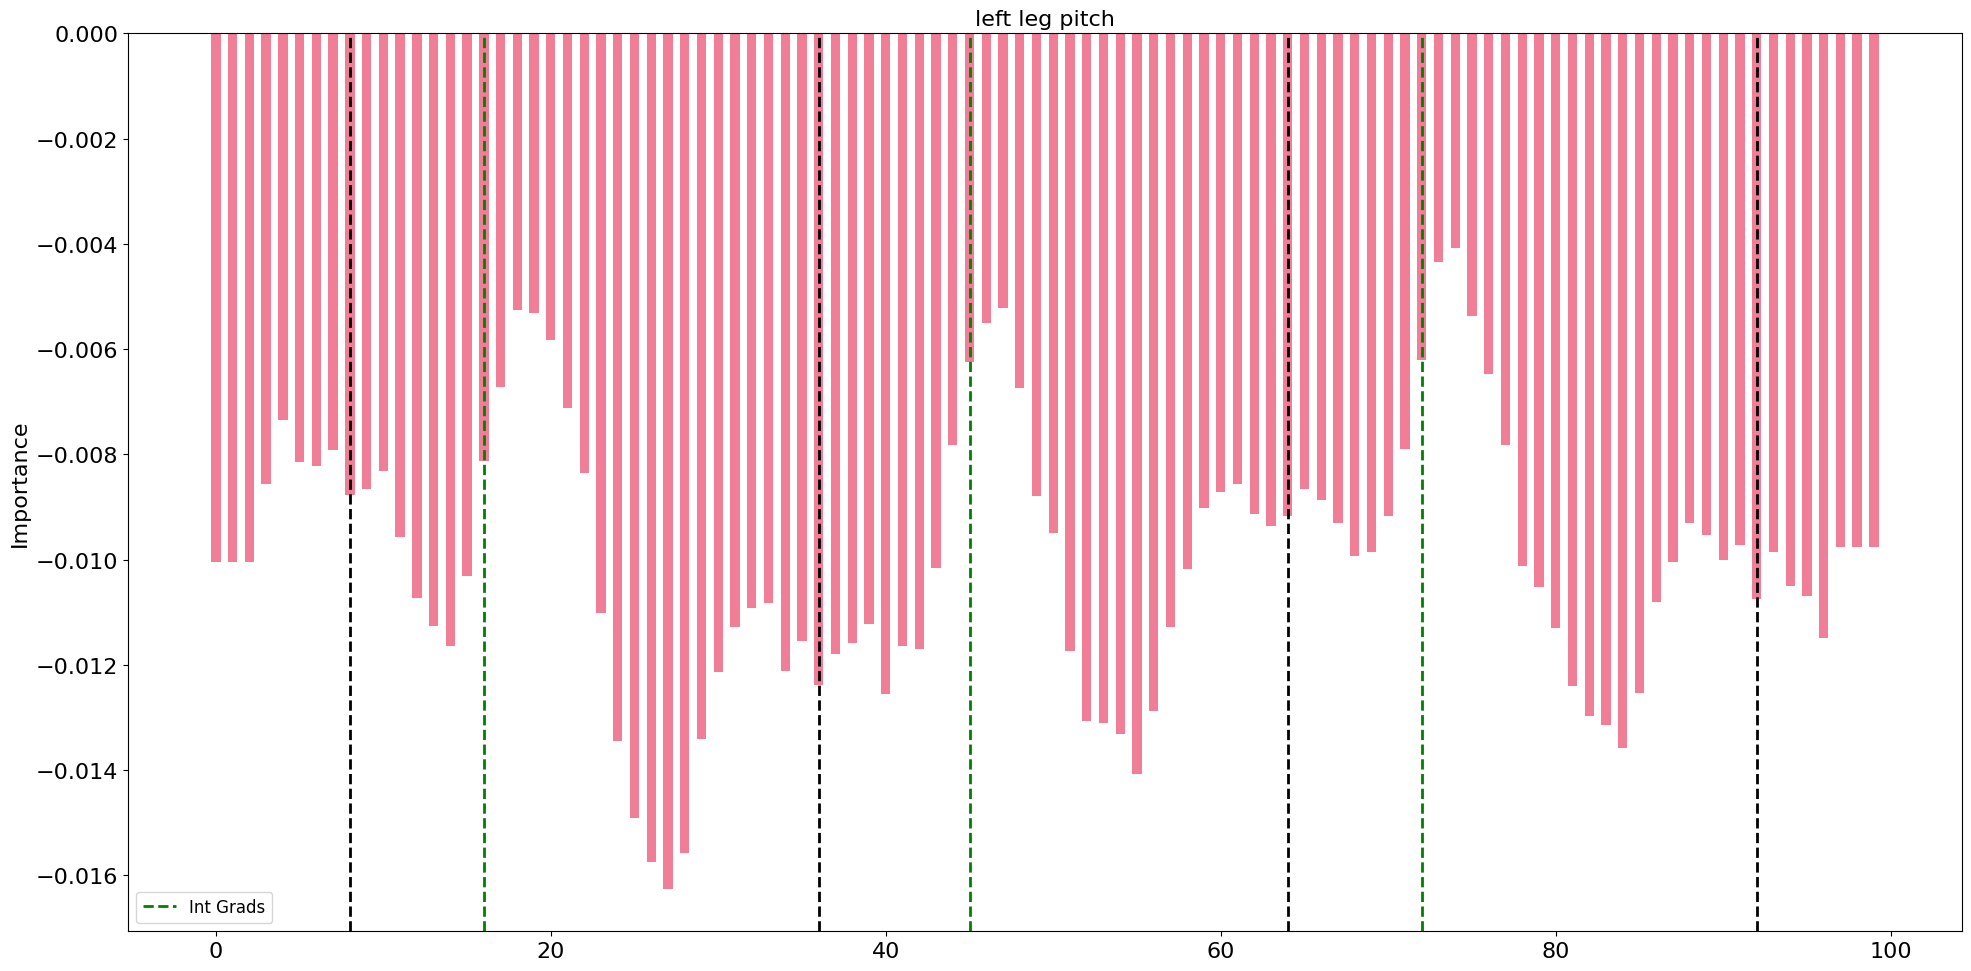

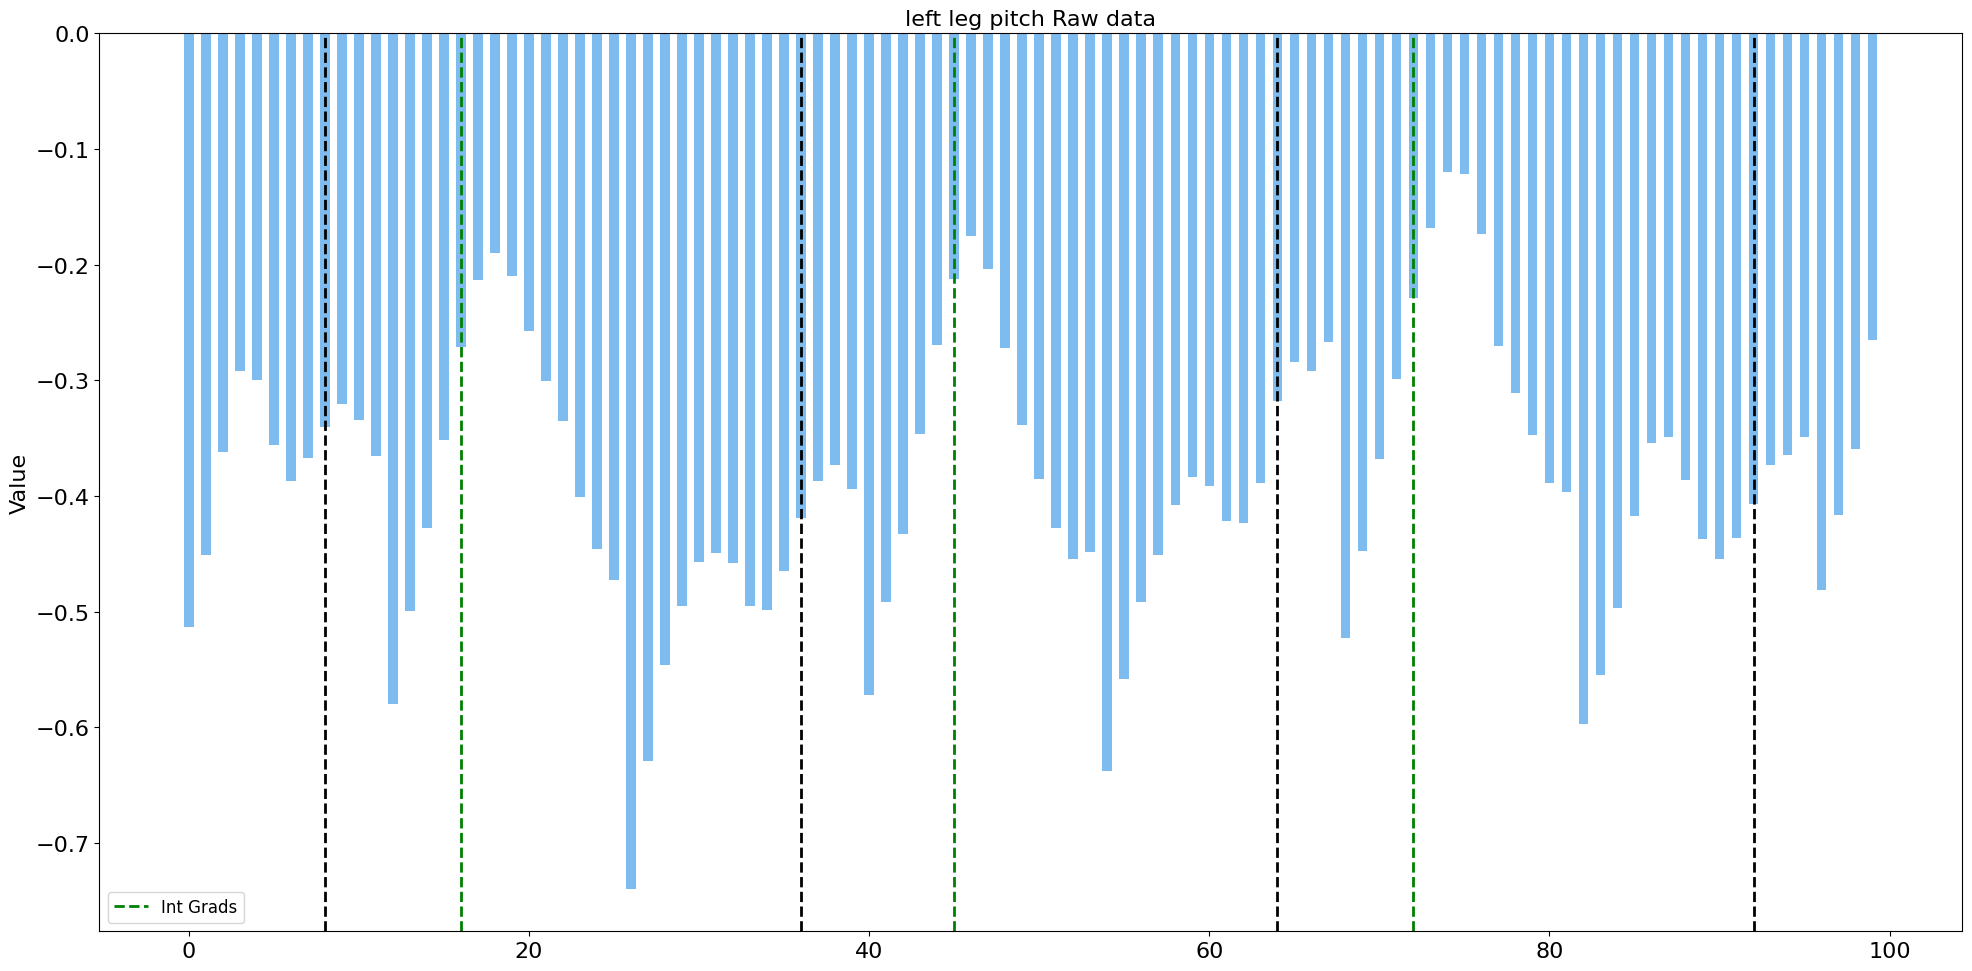

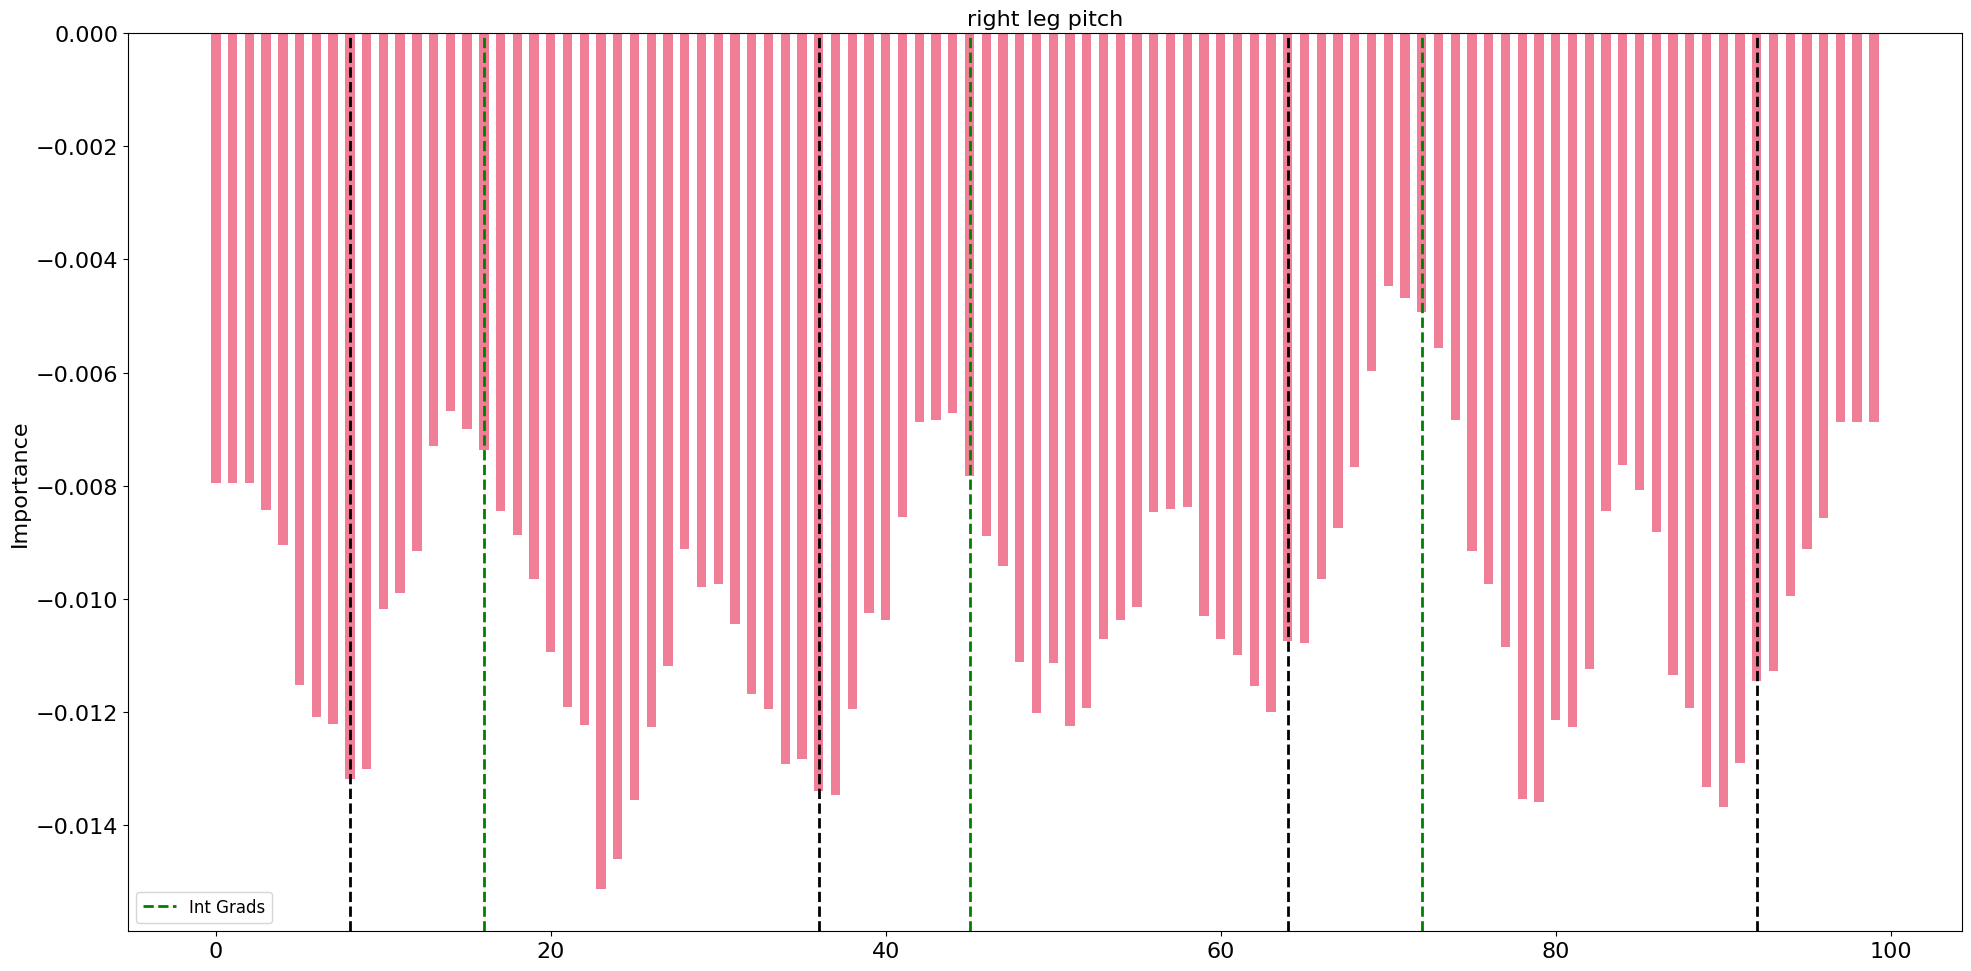

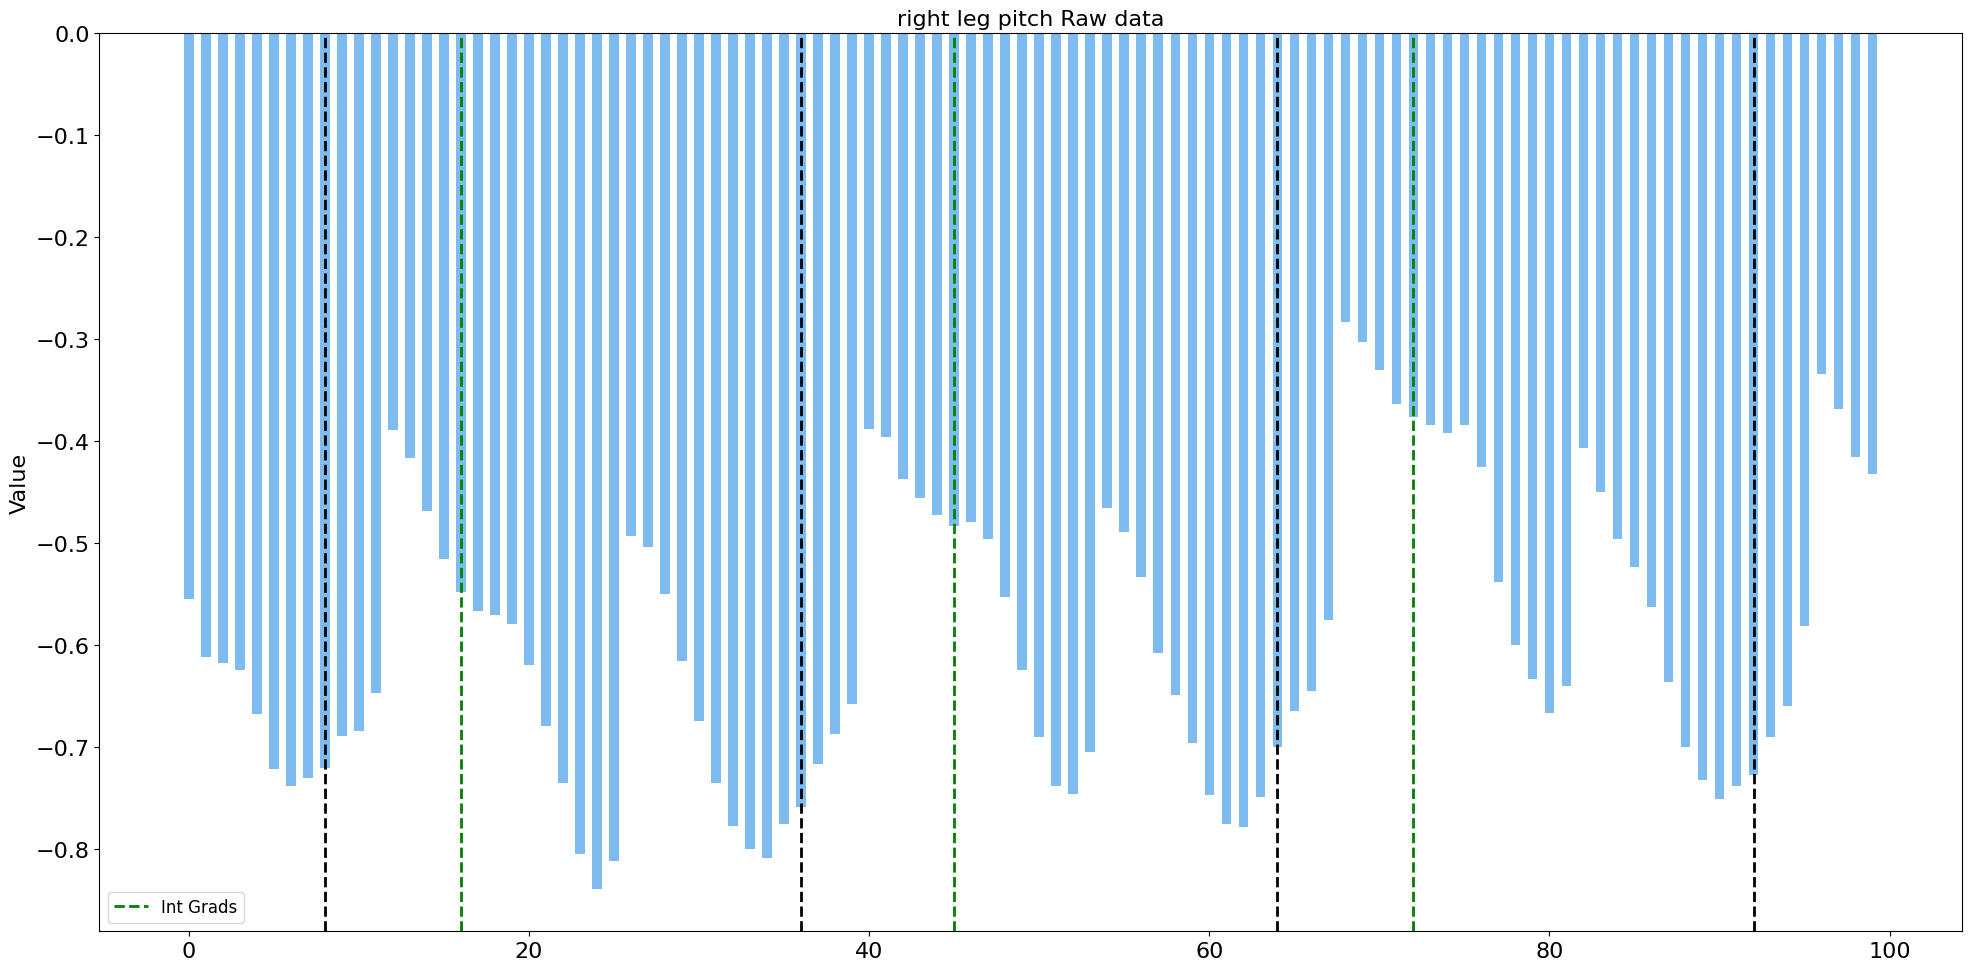

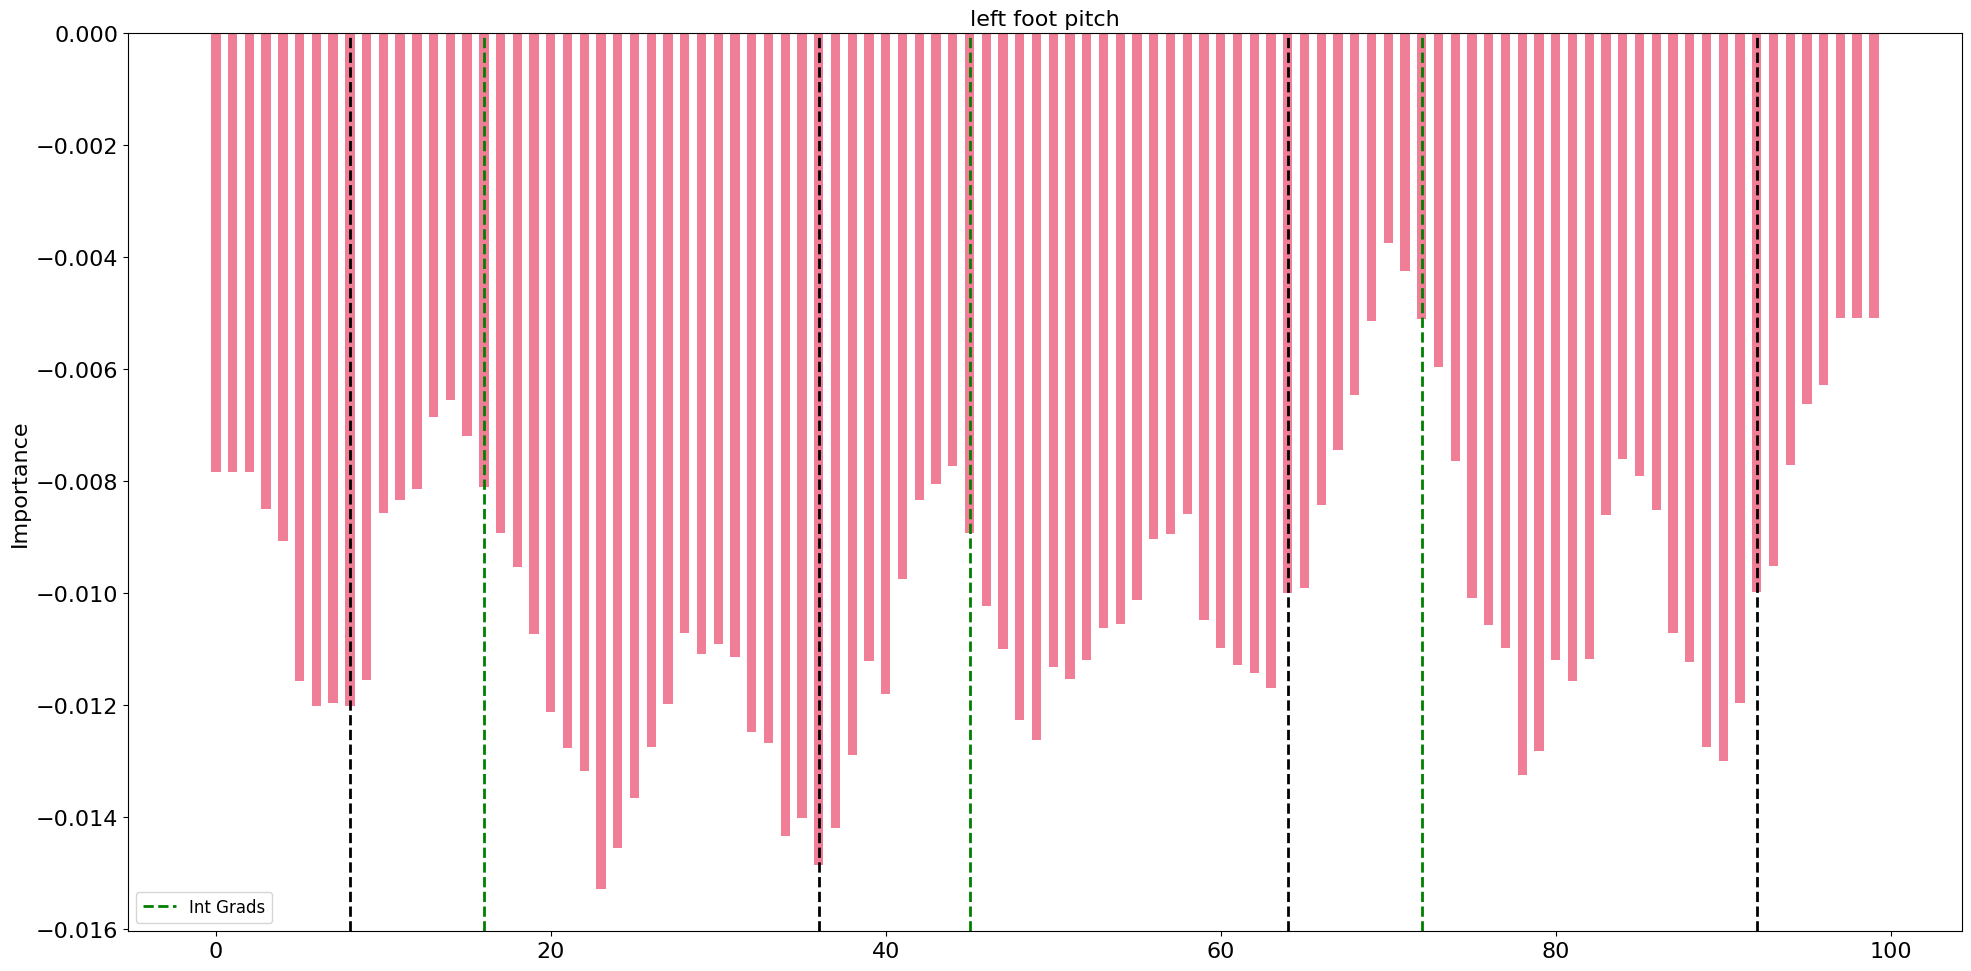

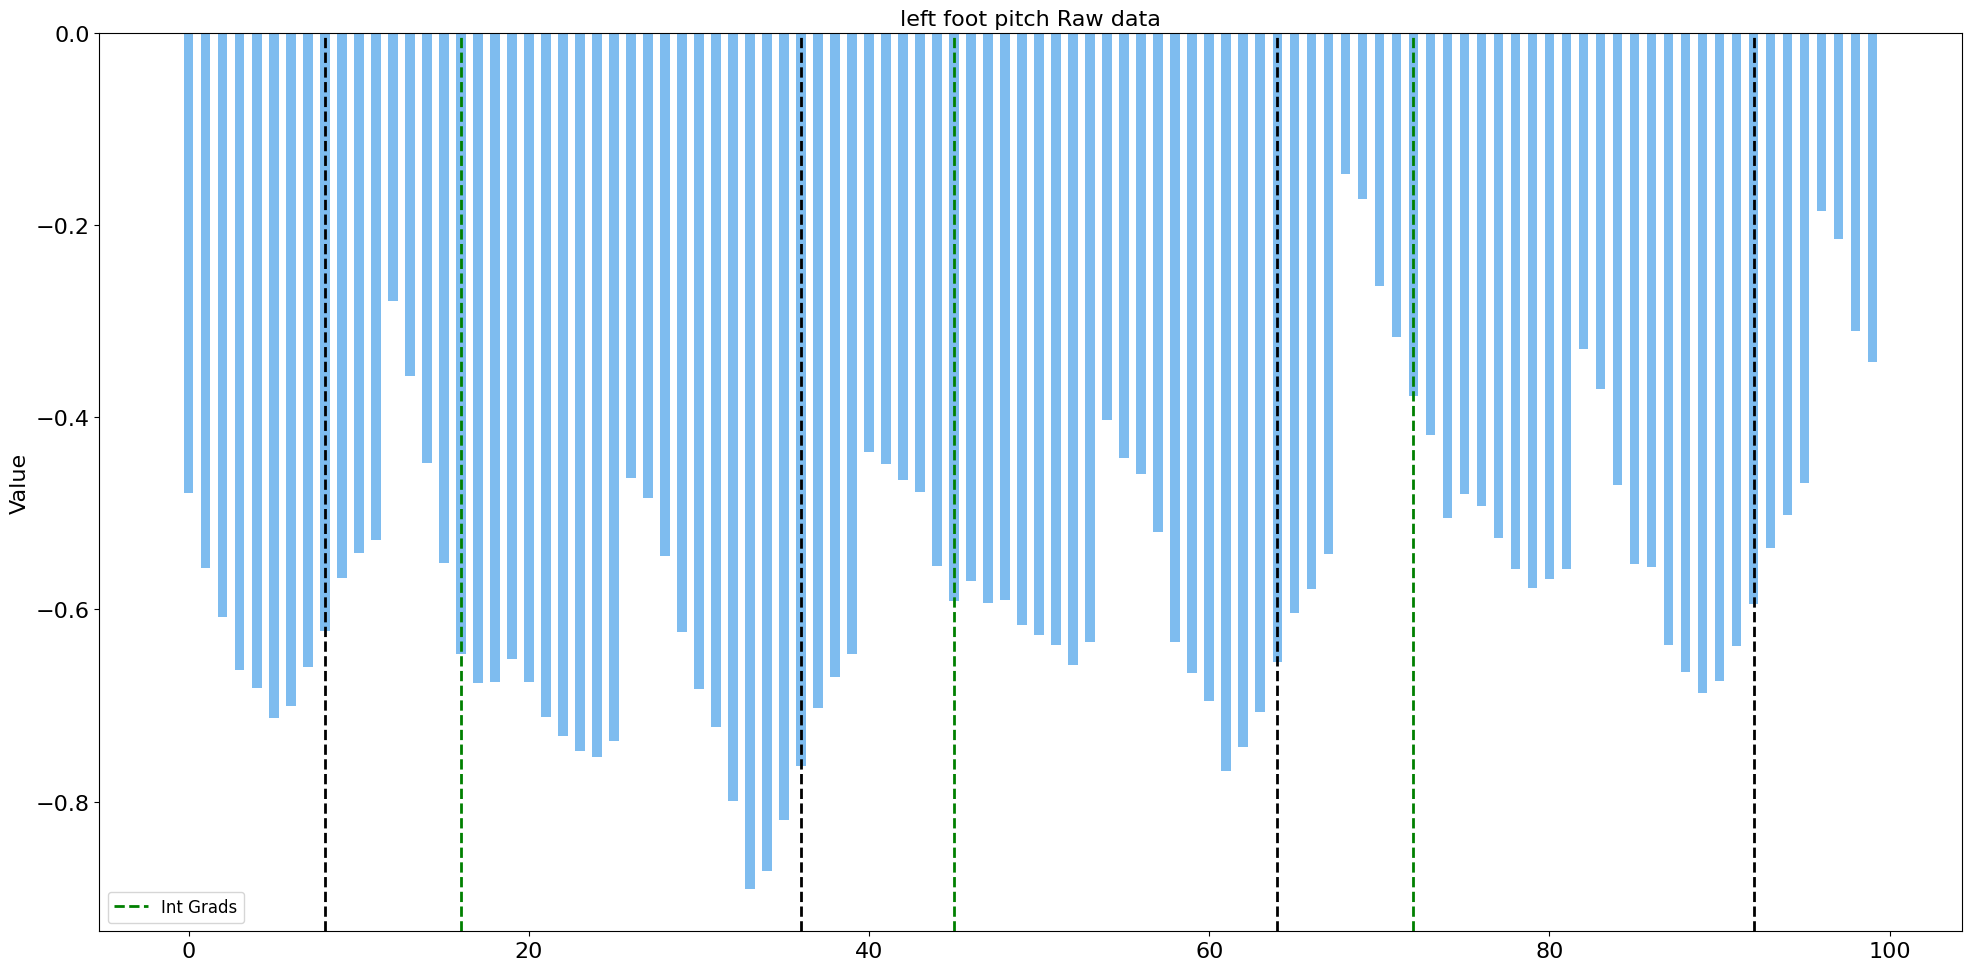

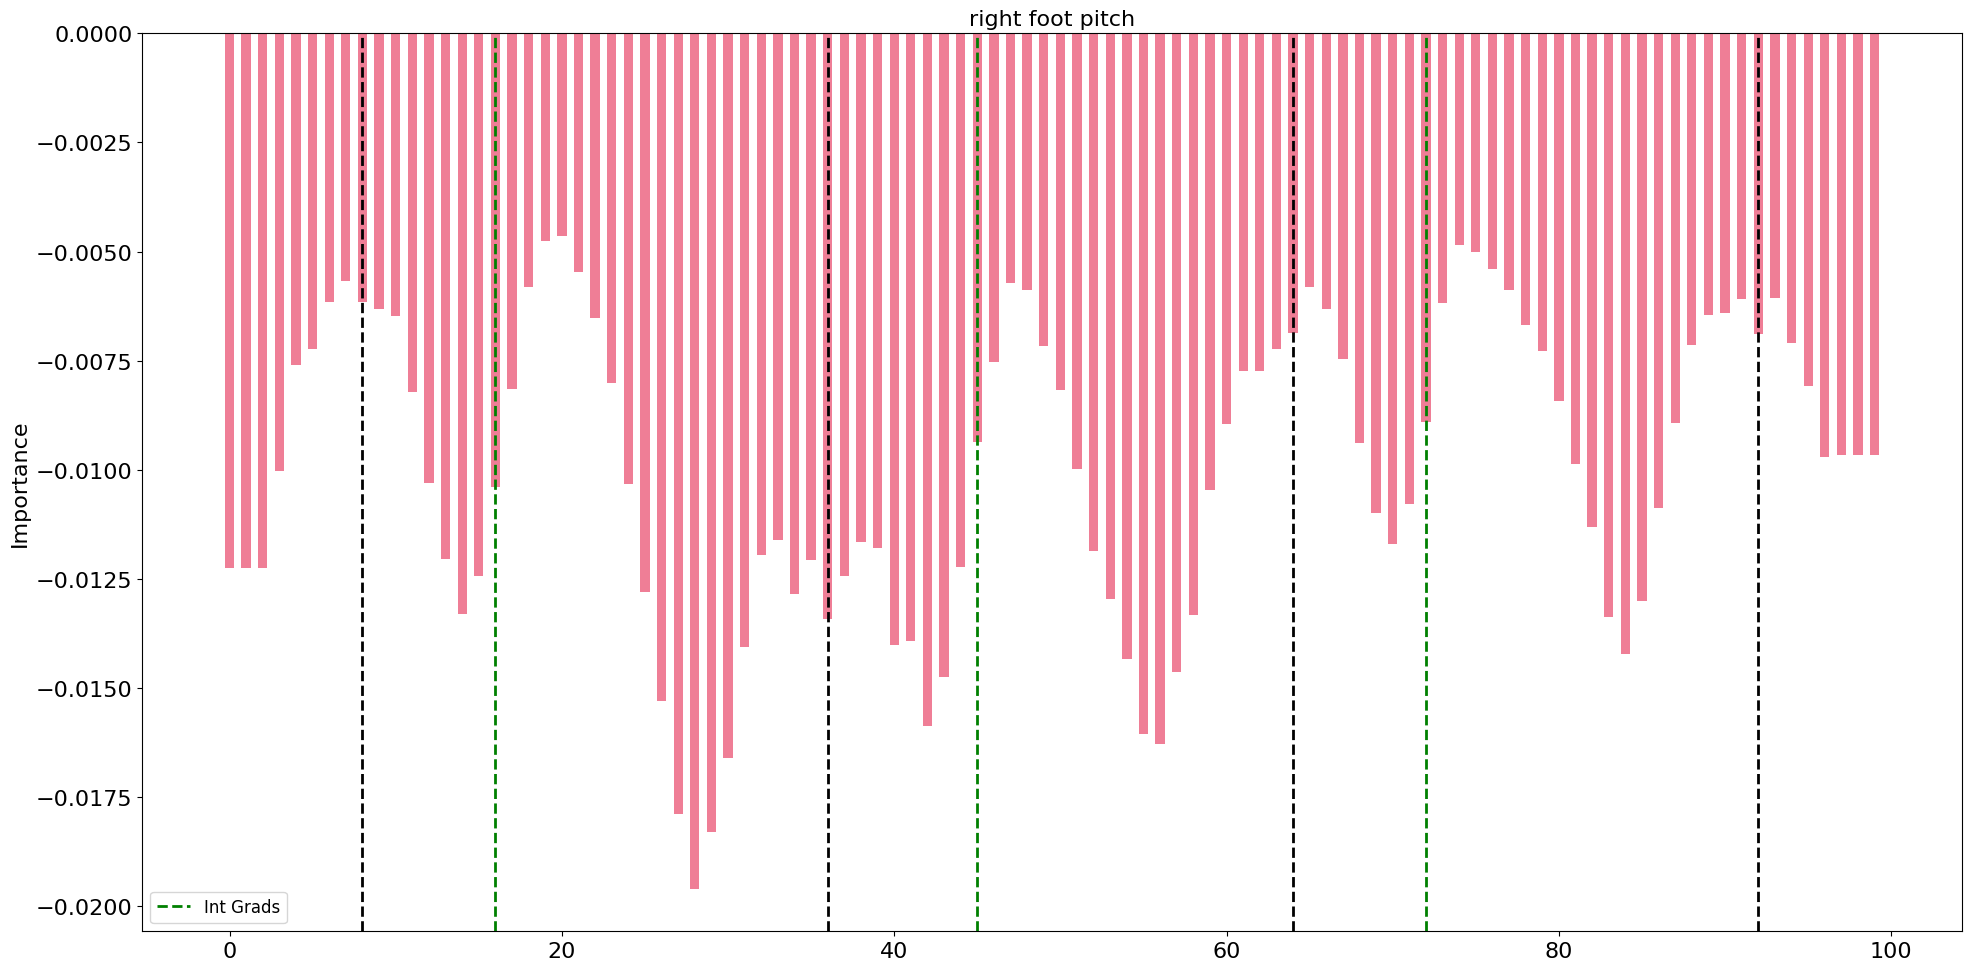

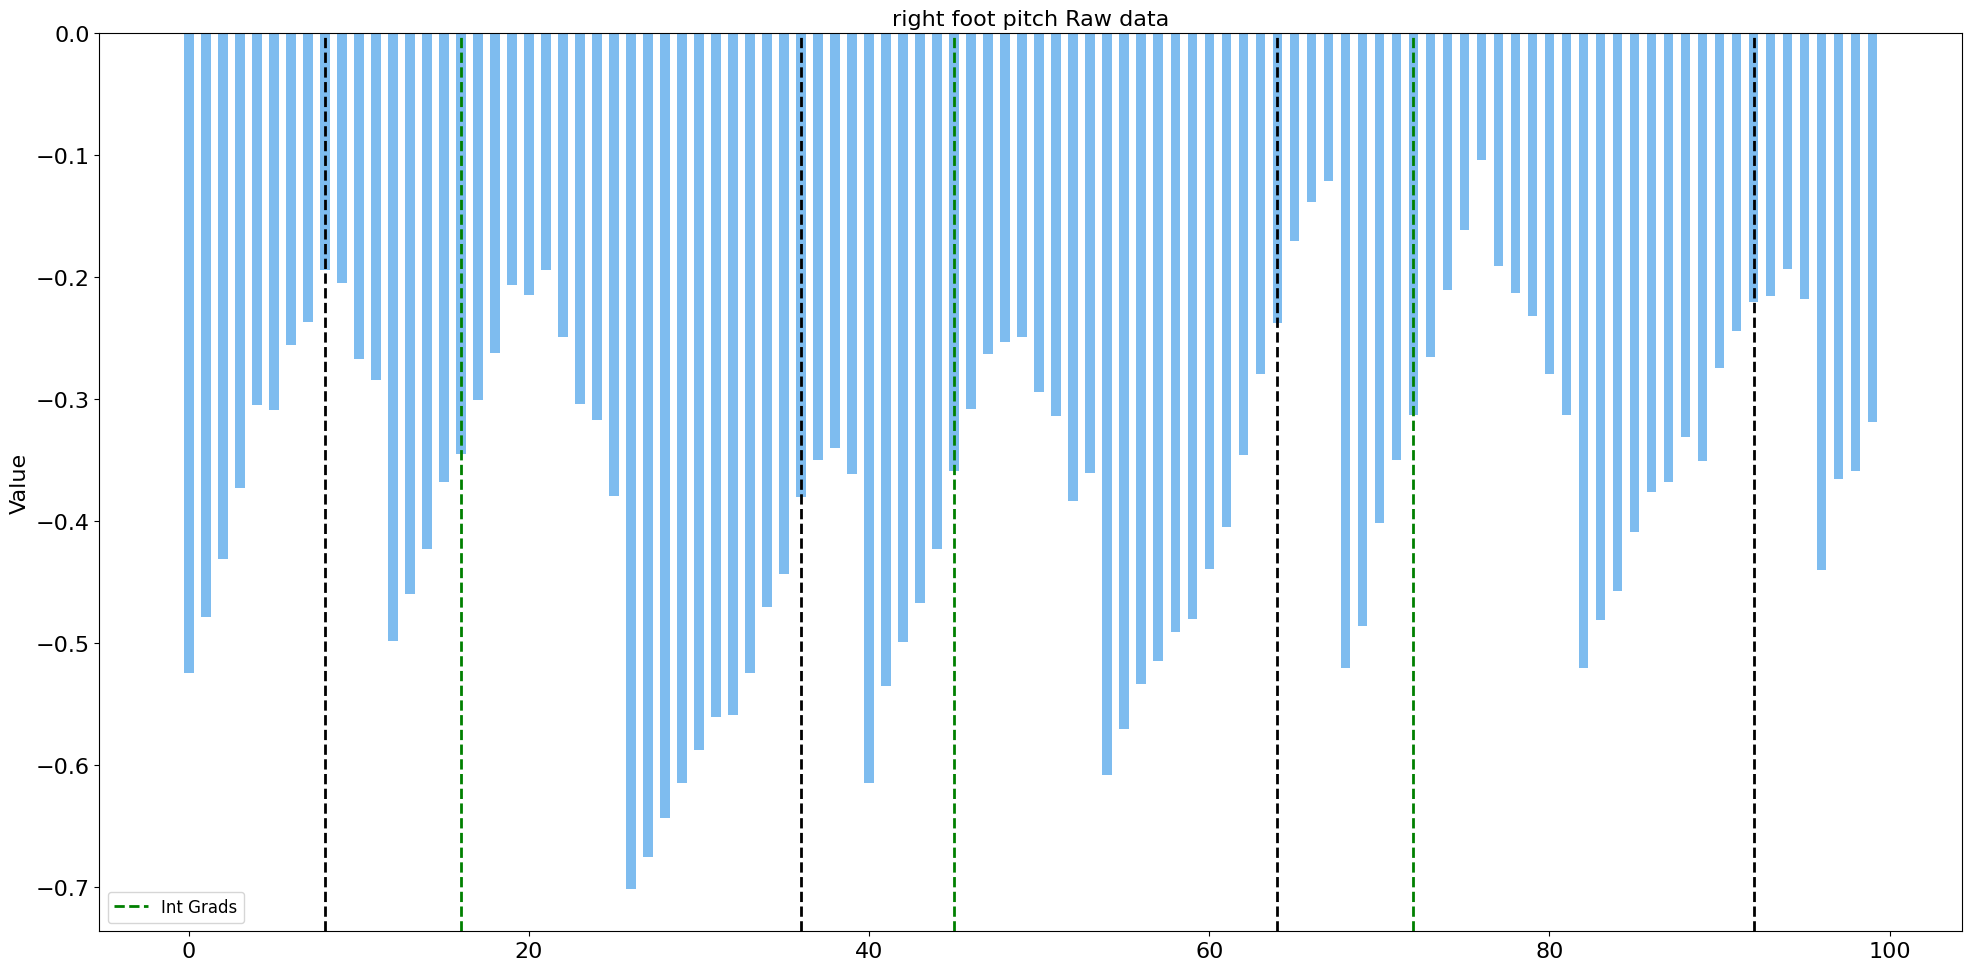

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

feature_names = [
    "Action- Left Hip Roll",
    "Action-Left Hip Yaw",
    "Action-Left Hip Pitch",
    "Action-Left Knee",
    "Action-Left Foot",
    "Action-Right Hip Roll",
    "Action-Right Hip Yaw",
    "Action-Right Hip Pitch",
    "Action-Rigt Knee",
    "Action-Rigt Foot",
    "com_to_cof",
    "left foot forces",
    "right foot forces",
    "Action norm",
    "distance to table",
    "Com Vel 1",
    "Com Vel 2",
    "Com Vel 3",
    "COM angular Mom 1",
    "COM angular Mom 2",
    "COM angular Mom 3",
    "pelvis_roll",
    "left hip yaw",
    "right hip yaw",
    "pelvis pitch",
    "left leg length",
    "right leg length",
    "left leg roll",
    "right leg roll",
    "left leg pitch",
    "right leg pitch",
    "left foot pitch",
    "right foot pitch",
]


def smooth_data(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    smoothed_data = np.convolve(data, weights, "valid")
    padding = (window_size - 1) // 2
    smoothed_data = np.pad(smoothed_data, (padding, padding), mode="edge")
    return smoothed_data


def plot_feature_at(feature: int = 1):
    feature_idx = feature
    if feature == 14:
        testing_begin_idx = 600
        testing_end_idx = 1200
    else:
        testing_begin_idx = 0
        testing_end_idx = 200
    test_data = torch.Tensor(data_set[testing_begin_idx:testing_end_idx, :]).to(device)
    ig_attr_test = ig.attribute(test_data, n_steps=50).cpu()
    x_axis_idx = np.arange(test_data.size()[0])
    x_axis_data = np.arange(test_data.size()[0])
    _axis_data_labels = list(map(lambda idx: x_axis_idx[idx], x_axis_data))

    ig_attr_test_sum = ig_attr_test.detach().numpy()[:, feature_idx]
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    ig_attr_test_norm_sum = smooth_data(
        ig_attr_test_norm_sum, window_size=5
    )  # Adjust the window size as desired

    width = 0.14 * 4
    legends = ["Int Grads"]
    plt.figure(figsize=(20, 10))

    ax = plt.subplot()
    ax.set_title(f"{feature_names[feature_idx]}")
    ax.set_ylabel("Importance")

    FONT_SIZE = 16
    plt.rc("font", size=FONT_SIZE)
    plt.rc("axes", titlesize=FONT_SIZE)
    plt.rc("axes", labelsize=FONT_SIZE)
    plt.rc("legend", fontsize=FONT_SIZE - 4)

    # find out steps where the robot is in the air
    selected_left_foot_forces = left_foot_forces[
        testing_begin_idx : testing_end_idx + 1
    ]
    selected_right_foot_forces = right_foot_forces[
        testing_begin_idx : testing_end_idx + 1
    ]

    if feature_idx == 11 or feature_idx != 12:
        left_foot_hit_ground = [
            i
            for i, x in enumerate(
                selected_left_foot_forces[: testing_end_idx - testing_begin_idx]
            )
            if (x == 0 and selected_left_foot_forces[i + 1] != 0)
        ]
        for pos in left_foot_hit_ground:
            ax.axvline(x=pos, color="green", linestyle="--", linewidth=2)

        left_foot_left_ground = [
            i
            for i, x in enumerate(
                selected_left_foot_forces[: testing_end_idx - testing_begin_idx]
            )
            if (x != 0 and selected_left_foot_forces[i + 1] == 0)
        ]
        for pos in left_foot_left_ground:
            ax.axvline(x=pos, color="black", linestyle="--", linewidth=2)

    if feature_idx == 12:
        right_foot_hit_ground = [
            i
            for i, x in enumerate(
                selected_right_foot_forces[: testing_end_idx - testing_begin_idx]
            )
            if (x == 0 and selected_right_foot_forces[i + 1] != 0)
        ]
        for pos in right_foot_hit_ground:
            ax.axvline(x=pos, color="green", linestyle="--", linewidth=2)

        right_foot_left_ground = [
            i
            for i, x in enumerate(
                selected_right_foot_forces[: testing_end_idx - testing_begin_idx]
            )
            if (x != 0 and selected_right_foot_forces[i + 1] == 0)
        ]
        for pos in right_foot_left_ground:
            ax.axvline(x=pos, color="black", linestyle="--", linewidth=2)

    # # Define the positions of the vertical bars
    # vertical_bar_positions = [2, 4, 7]

    # # Add vertical bars
    # for pos in vertical_bar_positions:
    #     ax.axvline(x=pos, color='black', linestyle='--', linewidth=2)

    ax.bar(
        x_axis_data,
        ig_attr_test_norm_sum,
        width,
        align="center",
        alpha=0.8,
        color="#eb5e7c",
    )
    ax.autoscale_view()
    plt.tight_layout()

    plt.legend(legends, loc=3)
    savefig = plt.gcf()
    plt.show()
    savefig.savefig(f"logs/reward_inference/plots/{feature_names[feature_idx]}_feature.png")

    plot_raw_data = True
    if plot_raw_data:
        test_data = torch.Tensor(data_set[testing_begin_idx:testing_end_idx, :]).to(
            device
        )
        ig_attr_test = ig.attribute(test_data, n_steps=50).cpu()
        x_axis_idx = np.arange(test_data.size()[0])
        x_axis_data = np.arange(test_data.size()[0])
        _axis_data_labels = list(map(lambda idx: x_axis_idx[idx], x_axis_data))

        ig_attr_test_sum = ig_attr_test.detach().numpy()[:, feature_idx]
        ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(
            ig_attr_test_sum, ord=1
        )
        ig_attr_test_norm_sum = smooth_data(
            ig_attr_test_norm_sum, window_size=5
        )  # Adjust the window size as desired
        raw_data = data_set[testing_begin_idx:testing_end_idx, feature_idx]

        width = 0.14 * 4
        legends = ["Int Grads"]
        plt.figure(figsize=(20, 10))

        ax = plt.subplot()
        ax.set_title(f"{feature_names[feature_idx]} Raw data")
        ax.set_ylabel("Value")

        FONT_SIZE = 16
        plt.rc("font", size=FONT_SIZE)
        plt.rc("axes", titlesize=FONT_SIZE)
        plt.rc("axes", labelsize=FONT_SIZE)
        plt.rc("legend", fontsize=FONT_SIZE - 4)

        # find out steps where the robot is in the air
        selected_left_foot_forces = left_foot_forces[
            testing_begin_idx : testing_end_idx + 1
        ]
        selected_right_foot_forces = right_foot_forces[
            testing_begin_idx : testing_end_idx + 1
        ]

        if feature_idx == 11 or feature_idx != 12:
            left_foot_hit_ground = [
                i
                for i, x in enumerate(
                    selected_left_foot_forces[: testing_end_idx - testing_begin_idx]
                )
                if (x == 0 and selected_left_foot_forces[i + 1] != 0)
            ]
            for pos in left_foot_hit_ground:
                ax.axvline(x=pos, color="green", linestyle="--", linewidth=2)

            left_foot_left_ground = [
                i
                for i, x in enumerate(
                    selected_left_foot_forces[: testing_end_idx - testing_begin_idx]
                )
                if (x != 0 and selected_left_foot_forces[i + 1] == 0)
            ]
            for pos in left_foot_left_ground:
                ax.axvline(x=pos, color="black", linestyle="--", linewidth=2)

        if feature_idx == 12:
            right_foot_hit_ground = [
                i
                for i, x in enumerate(
                    selected_right_foot_forces[: testing_end_idx - testing_begin_idx]
                )
                if (x == 0 and selected_right_foot_forces[i + 1] != 0)
            ]
            for pos in right_foot_hit_ground:
                ax.axvline(x=pos, color="green", linestyle="--", linewidth=2)

            right_foot_left_ground = [
                i
                for i, x in enumerate(
                    selected_right_foot_forces[: testing_end_idx - testing_begin_idx]
                )
                if (x != 0 and selected_right_foot_forces[i + 1] == 0)
            ]
            for pos in right_foot_left_ground:
                ax.axvline(x=pos, color="black", linestyle="--", linewidth=2)

        # # Define the positions of the vertical bars
        # vertical_bar_positions = [2, 4, 7]

        # # Add vertical bars
        # for pos in vertical_bar_positions:
        #     ax.axvline(x=pos, color='black', linestyle='--', linewidth=2)

        ax.bar(x_axis_data, raw_data, width, align="center", alpha=0.8, color="#5eaceb")
        ax.autoscale_view()
        plt.tight_layout()

        plt.legend(legends, loc=3)
        savefig = plt.gcf()
        plt.show()

        savefig.savefig(f"logs/reward_inference/plots/{feature_names[feature_idx]}_raw_data.png")

os.makedirs('logs/reward_inference/plots', exist_ok=True)
for i in range(len(feature_names)):
    plot_feature_at(i)